# Part III: GNNs

In [1]:
import cvxpy as cp
import numpy as np
import copy # Needed for deep copying data for each scenario
import random # For generating random load factors
import json

import matplotlib.pyplot as plt
import networkx as nx

# IEEE 6-bus test system

--- IEEE 6-Bus System (Original Topology) ---


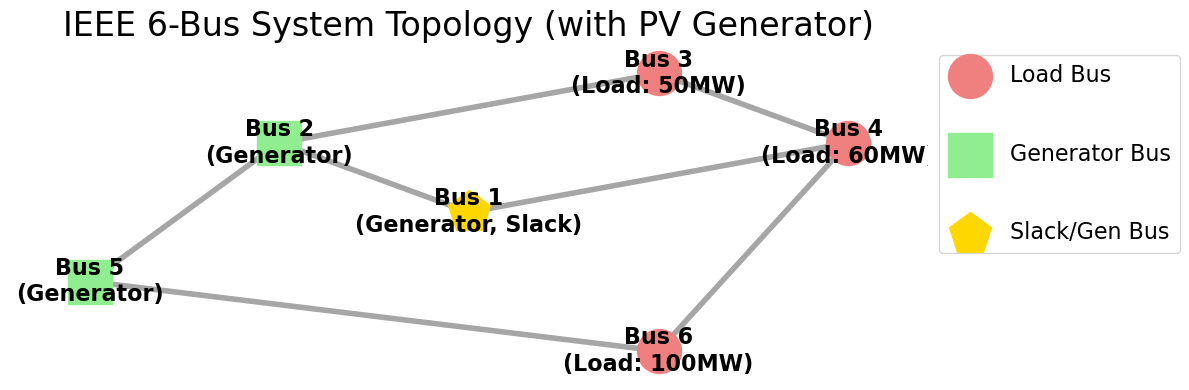


--- IEEE 6-Bus System (PV Added to Bus 3) ---


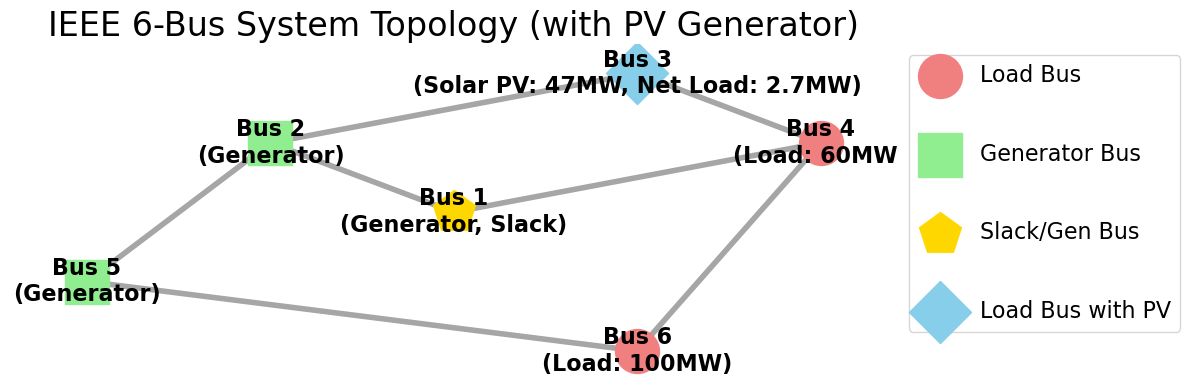

In [2]:
def draw_ieee_6_bus_topology(buses_data, generators_data, branches_data, slack_bus_idx,
                              pv_bus_idx=None, pv_generation_mw=0):
    """
    Draws the topology of the IEEE 6-bus test system, with an optional PV generator.
    """

    G = nx.Graph()

    # --- Add Nodes (Buses) with Attributes ---
    node_labels = {}
    
    # Pre-define lists for drawing categories to ensure consistent color/shape for legend
    node_load_buses = []
    node_gen_buses = []
    node_slack_buses = []
    node_pv_buses = [] # New list for PV buses

    # Identify generator buses for easier attribute assignment
    gen_bus_0_indices = {g['bus'] for g in generators_data}

    for bus_idx, data in buses_data.items():
        bus_label = bus_idx + 1 # Convert to 1-based indexing for display
        G.add_node(bus_label)
        
        is_load_bus = data['Pd'] > 0 # Check original load
        is_gen_bus = bus_idx in gen_bus_0_indices
        is_slack_bus = bus_idx == slack_bus_idx
        is_pv_bus = (pv_bus_idx is not None) and (bus_idx == pv_bus_idx)

        # Assign attributes for display and internal logic
        G.nodes[bus_label]['original_load_MW'] = data['Pd'] # Store original load
        G.nodes[bus_label]['is_generator'] = is_gen_bus
        G.nodes[bus_label]['is_slack'] = is_slack_bus
        G.nodes[bus_label]['is_pv_equipped'] = is_pv_bus
        G.nodes[bus_label]['pv_generation_mw_display'] = 0.0 # Default

        current_net_load_for_label = data['Pd'] # Start with original demand for net load label

        if is_pv_bus and pv_generation_mw > 0:
            G.nodes[bus_label]['pv_generation_mw_display'] = pv_generation_mw
            current_net_load_for_label -= pv_generation_mw # Calculate net load for display
            
            # Add to PV bus list
            node_pv_buses.append(bus_label)
            node_labels[bus_label] = f"Bus {bus_label}\n(Solar PV: {pv_generation_mw:.0f}MW, Net Load: {current_net_load_for_label:.1f}MW)"
        elif is_slack_bus:
            node_slack_buses.append(bus_label)
            node_labels[bus_label] = f"Bus {bus_label}\n(Generator, Slack)"
        elif is_gen_bus:
            node_gen_buses.append(bus_label)
            # If a generator bus also has a load, you could show it here if data['Pd'] > 0
            node_labels[bus_label] = f"Bus {bus_label}\n(Generator)"
        elif is_load_bus: # This will catch all remaining load buses
            node_load_buses.append(bus_label)
            node_labels[bus_label] = f"Bus {bus_label}\n(Load: {data['Pd']}MW)"
        else: # Bus with no generator and no (positive) load (e.g., intermediate bus)
            node_load_buses.append(bus_label) # Add to general load category, could be 'other'
            node_labels[bus_label] = f"Bus {bus_label}"


    # --- Add Edges (Branches) ---
    for branch in branches_data:
        from_bus_label = branch['from_bus'] + 1
        to_bus_label = branch['to_bus'] + 1
        G.add_edge(from_bus_label, to_bus_label)
        
        G.edges[(from_bus_label, to_bus_label)]['X_pu'] = branch['X_pu']
        G.edges[(from_bus_label, to_bus_label)]['limit_MW'] = branch['limit_MW']


    # --- Draw the Graph ---
    plt.figure(figsize=(12, 4)) # Adjust figure size for better visibility

    # Manual positions for IEEE 6-bus (these are generally good for this specific system)
    pos = {
        1: (0, 0),    # Bus 1 (Slack, Gen)
        2: (-1, 1),   # Bus 2 (Gen)
        3: (1, 2),    # Bus 3 (Load, target for PV)
        4: (2, 1),    # Bus 4 (Load)
        5: (-2, -1),  # Bus 5 (Gen)
        6: (1, -2)    # Bus 6 (Load)
    }

    # Draw nodes by type
    node_size = 1000 # Consistent node size

    nx.draw_networkx_nodes(G, pos, nodelist=node_load_buses, node_color='lightcoral', node_shape='o', node_size=node_size, label="Load Bus")
    nx.draw_networkx_nodes(G, pos, nodelist=node_gen_buses, node_color='lightgreen', node_shape='s', node_size=node_size, label="Generator Bus")
    nx.draw_networkx_nodes(G, pos, nodelist=node_slack_buses, node_color='gold', node_shape='p', node_size=node_size, label="Slack/Gen Bus")
    
    # Draw PV nodes separately to apply specific color and shape
    nx.draw_networkx_nodes(G, pos, nodelist=node_pv_buses, node_color='skyblue', node_shape='D', node_size=node_size, label="Load Bus with PV")

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=4, alpha=0.7, edge_color='gray')

    # Draw node labels (bus numbers and type/load/PV info)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=16, font_weight='bold') # Slightly smaller font for more info

    plt.title("IEEE 6-Bus System Topology (with PV Generator)", fontsize=24)
    plt.axis('off') # Turn off the axis
    plt.legend(scatterpoints=1, loc='upper left', bbox_to_anchor=(1, 1), labelspacing=2.5, fontsize=16) 
    plt.tight_layout() # Automatically adjust plot parameters for a tight layout
    plt.show()

# Original base data for the IEEE 6-bus system
ieee_6_buses_data_original = {
    0: {'Pd': 0},    # Bus 1 (Slack, Gen)
    1: {'Pd': 0},    # Bus 2 (Gen)
    2: {'Pd': 50},   # Bus 3 (Load) - Target for PV in examples
    3: {'Pd': 60},   # Bus 4 (Load)
    4: {'Pd': 0},    # Bus 5 (Gen)
    5: {'Pd': 100}   # Bus 6 (Load)
}

ieee_6_generators_data_base = [
    {'bus': 0, 'Pmin': 0, 'Pmax': 100}, # Bus 1
    {'bus': 1, 'Pmin': 0, 'Pmax': 80},  # Bus 2
    {'bus': 4, 'Pmin': 0, 'Pmax': 120}  # Bus 5
]

ieee_6_branches_data_base = [
    {'from_bus': 0, 'to_bus': 1, 'X_pu': 0.1703, 'limit_MW': 100},
    {'from_bus': 0, 'to_bus': 3, 'X_pu': 0.2081, 'limit_MW': 100},
    {'from_bus': 1, 'to_bus': 2, 'X_pu': 0.1737, 'limit_MW': 100},
    {'from_bus': 1, 'to_bus': 4, 'X_pu': 0.0535, 'limit_MW': 100},
    {'from_bus': 2, 'to_bus': 3, 'X_pu': 0.2370, 'limit_MW': 100},
    {'from_bus': 3, 'to_bus': 5, 'X_pu': 0.1065, 'limit_MW': 100},
    {'from_bus': 4, 'to_bus': 5, 'X_pu': 0.1989, 'limit_MW': 100}
]

SLACK_BUS_IDX = 0 # Bus 1 is the slack bus

# --- Draw the system without PV ---
print("--- IEEE 6-Bus System (Original Topology) ---")
draw_ieee_6_bus_topology(
    buses_data=ieee_6_buses_data_original,
    generators_data=ieee_6_generators_data_base,
    branches_data=ieee_6_branches_data_base,
    slack_bus_idx=SLACK_BUS_IDX
)

# --- Draw the system with PV on Bus 3 (0-indexed 2) ---
print("\n--- IEEE 6-Bus System (PV Added to Bus 3) ---")
pv_bus_to_add = 2 # Bus 3 (0-indexed)
pv_gen_value = random.uniform(20, 70) # Random PV generation between 20 and 70 MW

draw_ieee_6_bus_topology(
    buses_data=ieee_6_buses_data_original, # Pass original data; function calculates net load for label
    generators_data=ieee_6_generators_data_base,
    branches_data=ieee_6_branches_data_base,
    slack_bus_idx=SLACK_BUS_IDX,
    pv_bus_idx=pv_bus_to_add,
    pv_generation_mw=pv_gen_value
)


# Generate a DC-OPF N-0 dataset

In [3]:
def solve_dc_opf(buses_data, generators_data, branches_data, slack_bus_idx=0):
    """
    Solves the DC Optimal Power Flow problem for a given power system.
    """

    num_buses = len(buses_data)
    num_generators = len(generators_data)
    num_branches = len(branches_data)

    # Extract 0-indexed bus IDs where generators are located
    gen_bus_indices = [g['bus'] for g in generators_data]

    # Construct B' matrix (susceptance matrix for DC power flow)
    B_prime = np.zeros((num_buses, num_buses))
    for branch in branches_data:
        from_bus = branch['from_bus']
        to_bus = branch['to_bus']
        x_val = branch['X_pu']

        if x_val == 0:
            raise ValueError(f"Branch between bus {from_bus+1} and {to_bus+1} has zero reactance (X_pu), which is invalid for DC OPF.")
        
        b_val = 1 / x_val # Susceptance

        # Off-diagonal elements
        B_prime[from_bus, to_bus] -= b_val
        B_prime[to_bus, from_bus] -= b_val
        # Diagonal elements
        B_prime[from_bus, from_bus] += b_val
        B_prime[to_bus, to_bus] += b_val

    # --- Define Optimization Variables ---
    pg = cp.Variable(num_generators, name='Pg') # Active power generation (MW)
    theta = cp.Variable(num_buses, name='Theta') # Bus voltage angles (radians)

    # --- Objective Function ---
    total_cost = 0
    for i, gen_data in enumerate(generators_data):
        total_cost += gen_data['cost_a'] * cp.square(pg[i]) + \
                      gen_data['cost_b'] * pg[i] + \
                      gen_data['cost_c']

    objective = cp.Minimize(total_cost)

    # --- Define Constraints ---
    constraints = []

    # 1. Reference Bus Angle Constraint: Slack bus angle is fixed to 0
    constraints.append(theta[slack_bus_idx] == 0)

    # 2. Power Balance (Kirchhoff's Current Law) at each bus
    # P_injection_i = Pg_i - Pd_i = (B_prime @ theta)[i]
    for i in range(num_buses):
        # Determine total generation at bus i (0 if no generator, else pg value)
        Pg_at_bus_i_expr = 0
        if i in gen_bus_indices:
            # Find the index of this generator within the 'pg' variable
            gen_var_idx = gen_bus_indices.index(i)
            Pg_at_bus_i_expr = pg[gen_var_idx]
        
        Pd_at_bus_i = buses_data[i]['Pd'] # Demand at bus i

        # Enforce power balance: (Generation - Demand) == (Sum of flows leaving the bus)
        constraints.append(Pg_at_bus_i_expr - Pd_at_bus_i == (B_prime @ theta)[i])

    # 3. Generator Active Power Limits
    for i, gen_data in enumerate(generators_data):
        constraints.append(pg[i] >= gen_data['Pmin'])
        constraints.append(pg[i] <= gen_data['Pmax'])

    # 4. Line Active Power Flow Limits
    # P_flow_ij = (1/X_ij) * (theta_i - theta_j)
    for branch in branches_data:
        from_bus = branch['from_bus']
        to_bus = branch['to_bus']
        x_val = branch['X_pu']
        limit_MW = branch['limit_MW']

        p_flow = (1 / x_val) * (theta[from_bus] - theta[to_bus])
        constraints.append(p_flow >= -limit_MW)
        constraints.append(p_flow <= limit_MW)

    # --- Create and Solve the Optimization Problem ---
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.ECOS, verbose=False) # ECOS is a robust open-source solver for convex problems

    # --- Process and Return Results ---
    results = {
        'cost': None,
        'pg': {},
        'theta': {},
        'pf': {},
        'status': problem.status,
        'problem_status': problem.status # More detailed status from cvxpy
    }

    if problem.status in ["optimal", "optimal_near", "feasible"]:
        results['cost'] = problem.value

        # Store generator outputs with 1-based original bus IDs
        for i, gen_data in enumerate(generators_data):
            results['pg'][gen_data['bus'] + 1] = pg[i].value

        # Store bus angles (converted to degrees) with 1-based original bus IDs
        for i in range(num_buses):
            results['theta'][i + 1] = np.degrees(theta[i].value) # Convert radians to degrees

        # Calculate and store line flows with 1-based original bus IDs
        for branch in branches_data:
            from_bus = branch['from_bus']
            to_bus = branch['to_bus']
            x_val = branch['X_pu']
            flow_value = (1 / x_val) * (theta[from_bus].value - theta[to_bus].value)
            results['pf'][f"Line {from_bus+1}-{to_bus+1}"] = flow_value
    
    return results


## Initialize the IEEE test system 

In [4]:
print("Preparing data for IEEE 6-Bus System...")

# Bus Data: (0-indexed bus ID -> {'Pd': demand_MW})
ieee_6_buses_data = {
    0: {'Pd': 0},      # Bus 1 (Slack, Gen)
    1: {'Pd': 0},      # Bus 2 (Gen)
    2: {'Pd': 80},     # Bus 3 (Load)
    3: {'Pd': 100},    # Bus 4 (Load)
    4: {'Pd': 0},      # Bus 5 (Gen)
    5: {'Pd': 150}     # Bus 6 (Load)
}

# Generator Data: List of dictionaries
# (0-indexed bus ID, Pmin_MW, Pmax_MW, cost_a, cost_b, cost_c)
ieee_6_generators_data = [
    {'bus': 0, 'Pmin': 10,  'Pmax': 250, 'cost_a': 0.004,   'cost_b': 20, 'cost_c': 0}, # Gen at Bus 1
    {'bus': 1, 'Pmin': 10,  'Pmax': 200, 'cost_a': 0.00175, 'cost_b': 20, 'cost_c': 0}, # Gen at Bus 2
    {'bus': 4, 'Pmin': 10,  'Pmax': 150, 'cost_a': 0.00625, 'cost_b': 40, 'cost_c': 0}  # Gen at Bus 5
]

# Branch Data: List of dictionaries
# (from_bus_idx, to_bus_idx, X_pu, RateA_MW_limit)
ieee_6_branches_data = [
    {'from_bus': 0, 'to_bus': 1, 'X_pu': 0.4,  'limit_MW': 200},  # Line 1-2
    {'from_bus': 0, 'to_bus': 3, 'X_pu': 0.2,  'limit_MW': 200},  # Line 1-4
    {'from_bus': 1, 'to_bus': 2, 'X_pu': 0.25, 'limit_MW': 100},  # Line 2-3
    {'from_bus': 1, 'to_bus': 4, 'X_pu': 0.15, 'limit_MW': 100},  # Line 2-5
    {'from_bus': 2, 'to_bus': 3, 'X_pu': 0.25, 'limit_MW': 100},  # Line 3-4
    {'from_bus': 3, 'to_bus': 5, 'X_pu': 0.3,  'limit_MW': 100},  # Line 4-6
    {'from_bus': 4, 'to_bus': 5, 'X_pu': 0.2,  'limit_MW': 100}   # Line 5-6
]


Preparing data for IEEE 6-Bus System...


## Test the DC-OPF module 

In [5]:
# Solve the DC OPF
opf_results = solve_dc_opf(ieee_6_buses_data, ieee_6_generators_data, ieee_6_branches_data, slack_bus_idx=0)

print("\n--- DC OPF Results for IEEE 6-Bus System ---")
print(f"Solver Status: {opf_results['status']}")
print(f"Detailed Problem Status: {opf_results['problem_status']}")

if opf_results['status'] in ["optimal", "optimal_near", "feasible"]:
    print(f"\nOptimal Total Generation Cost: ${opf_results['cost']:.2f}")

    print("\nOptimal Generator Active Power Outputs (MW):")
    total_demand = sum(bus['Pd'] for bus in ieee_6_buses_data.values())
    total_generation = 0
    for bus_idx, pg_val in opf_results['pg'].items():
        print(f"  Generator at Bus {bus_idx}: {pg_val:.2f} MW")
        total_generation += pg_val
    print(f"Total System Demand: {total_demand:.2f} MW")
    print(f"Total System Generation: {total_generation:.2f} MW")
    print(f"Generation - Demand Difference: {total_generation - total_demand:.6f} MW (should be close to zero)")

    print("\nOptimal Bus Voltage Angles (Degrees):")
    for bus_idx, theta_deg in opf_results['theta'].items():
        print(f"  Bus {bus_idx}: {theta_deg:.4f} degrees")

    print("\nOptimal Line Active Power Flows (MW):")
    for line_name, flow_val in opf_results['pf'].items():
        print(f"  {line_name}: {flow_val:.2f} MW")

    # --- Basic Constraint Verification ---
    print("\n--- Constraint Verification ---")
    # Verify generator limits
    for gen_data in ieee_6_generators_data:
        bus_id = gen_data['bus'] + 1
        pg_val = opf_results['pg'][bus_id]
        if not (gen_data['Pmin'] <= pg_val <= gen_data['Pmax'] + 1e-6): # Add tolerance for float comparison
            print(f"  WARNING: Gen at Bus {bus_id} ({pg_val:.2f} MW) violates limits ({gen_data['Pmin']}-{gen_data['Pmax']} MW)!")
        else:
            print(f"  Gen at Bus {bus_id} ({pg_val:.2f} MW) within limits ({gen_data['Pmin']}-{gen_data['Pmax']} MW).")

    # Verify line limits
    for branch_data in ieee_6_branches_data:
        line_name = f"Line {branch_data['from_bus']+1}-{branch_data['to_bus']+1}"
        flow_val = opf_results['pf'][line_name]
        limit = branch_data['limit_MW']
        if not (abs(flow_val) <= limit + 1e-6): # Add tolerance
            print(f"  WARNING: {line_name} flow ({flow_val:.2f} MW) violates limit ({limit:.1f} MW)!")
        else:
            print(f"  {line_name} flow ({flow_val:.2f} MW) within limit ({limit:.1f} MW).")

else:
    print("Optimization did not find an optimal solution or encountered an error.")



--- DC OPF Results for IEEE 6-Bus System ---
Solver Status: optimal
Detailed Problem Status: optimal

Optimal Total Generation Cost: $6967.67

Optimal Generator Active Power Outputs (MW):
  Generator at Bus 1: 183.25 MW
  Generator at Bus 2: 136.75 MW
  Generator at Bus 5: 10.00 MW
Total System Demand: 330.00 MW
Total System Generation: 330.00 MW
Generation - Demand Difference: 0.000000 MW (should be close to zero)

Optimal Bus Voltage Angles (Degrees):
  Bus 1: 0.0000 degrees
  Bus 2: -693.2789 degrees
  Bus 3: -1796.2227 degrees
  Bus 4: -1753.2509 degrees
  Bus 5: -1466.7720 degrees
  Bus 6: -2612.6876 degrees

Optimal Line Active Power Flows (MW):
  Line 1-2: 30.25 MW
  Line 1-4: 153.00 MW
  Line 2-3: 77.00 MW
  Line 2-5: 90.00 MW
  Line 3-4: -3.00 MW
  Line 4-6: 50.00 MW
  Line 5-6: 100.00 MW

--- Constraint Verification ---
  Gen at Bus 1 (183.25 MW) within limits (10-250 MW).
  Gen at Bus 2 (136.75 MW) within limits (10-200 MW).
  Gen at Bus 5 (10.00 MW) within limits (10-150 M

## Generate 20k DC-OPF solutions

In [58]:
# Updated Test Function for 20000 Load Demand Scenarios (Per-Bus Scaling with Saving)
def test_dc_opf_100_load_scenarios_per_bus_scale(base_buses_data, generators_data, branches_data, slack_bus_idx=0, save_file="feasible_opf_results.json"):
    """
    Tests the DC OPF solver across 20k randomly generated load demand scenarios,
    where each load bus demand is scaled by a different random factor.
    Saves feasible solutions' parameters and decision variables.
    """
    
    print("--- Starting DC OPF Testing for 20k Load Scenarios (Per-Bus Scaling) ---")

    num_scenarios = 20000
    
    min_bus_load_scale = 0.0
    max_bus_load_scale = 1.8

    all_scenario_results = [] # Stores summary of each scenario
    feasible_solutions_data = [] # Stores detailed data for feasible solutions
    
    original_total_demand_base = sum(bus['Pd'] for bus in base_buses_data.values())

    for i in range(num_scenarios):
        current_buses_data = copy.deepcopy(base_buses_data)
        
        # Store the actual load values for this scenario
        scenario_bus_loads = {}
        for bus_id in current_buses_data:
            if current_buses_data[bus_id]['Pd'] > 0:
                individual_scale_factor = random.uniform(min_bus_load_scale, max_bus_load_scale)
                current_buses_data[bus_id]['Pd'] *= individual_scale_factor
            scenario_bus_loads[bus_id + 1] = current_buses_data[bus_id]['Pd'] # Store with 1-based index
        
        current_total_demand = sum(bus['Pd'] for bus in current_buses_data.values())

        results = solve_dc_opf(current_buses_data, generators_data, branches_data, slack_bus_idx)
        
        scenario_info = {
            'scenario_id': i + 1,
            'total_demand_MW': current_total_demand,
            'status': results['status'],
            'problem_status': results['problem_status'],
            'cost': results['cost'],
            'total_generation_MW': None,
            'line_violations': 0,
            'gen_violations': 0
        }

        if results['status'] in ["optimal", "optimal_near", "feasible"]:
            total_generation = sum(results['pg'].values())
            scenario_info['total_generation_MW'] = total_generation

            # Verification of constraints (should be zero for feasible solutions)
            for gen_idx, gen_data in enumerate(generators_data):
                bus_id = gen_data['bus'] + 1
                pg_val = results['pg'][bus_id]
                if not (gen_data['Pmin'] - 1e-6 <= pg_val <= gen_data['Pmax'] + 1e-6):
                    scenario_info['gen_violations'] += 1

            for branch_data in branches_data:
                line_name = f"Line {branch_data['from_bus']+1}-{branch_data['to_bus']+1}"
                flow_val = results['pf'].get(line_name, 0)
                limit = branch_data['limit_MW']
                if abs(flow_val) > limit + 1e-6:
                    scenario_info['line_violations'] += 1
            
            # --- Save detailed data for feasible solutions ---
            feasible_solutions_data.append({
                'scenario_id': i + 1,
                'input_parameters': {
                    'bus_loads_MW': scenario_bus_loads, # Individual bus loads for this scenario
                    'total_demand_MW': current_total_demand
                },
                'output_decision_variables': {
                    'optimal_cost': results['cost'],
                    'pg_MW': results['pg'],
                    'theta_degrees': results['theta'],
                    'pf_MW': results['pf']
                },
                'solution_status': {
                    'status': results['status'],
                    'problem_status': results['problem_status'],
                    'gen_violations_count': scenario_info['gen_violations'],
                    'line_violations_count': scenario_info['line_violations']
                }
            })
        
        all_scenario_results.append(scenario_info)

        if (i + 1) % 200 == 0 or i == num_scenarios - 1:
            print(f"  Processed {i+1}/{num_scenarios} scenarios. Status: {results['status']}, Total Demand: {current_total_demand:.2f} MW")

    # --- Save feasible solutions data to JSON file ---
    try:
        with open(save_file, 'w') as f:
            json.dump(feasible_solutions_data, f, indent=4)
        print(f"\nSaved {len(feasible_solutions_data)} feasible solutions to '{save_file}'")
    except IOError as e:
        print(f"\nError saving results to file '{save_file}': {e}")


    # --- Summary Report (remains similar to before) ---
    print("\n\n--- Summary Report for 100 Load Scenarios (Per-Bus Scaling) ---")
    
    feasible_count = 0
    infeasible_count = 0
    error_count = 0
    total_costs = []
    
    for scenario in all_scenario_results:
        if scenario['status'] in ["optimal", "optimal_near", "feasible"]:
            feasible_count += 1
            if scenario['cost'] is not None:
                total_costs.append(scenario['cost'])
        elif scenario['status'] == "infeasible":
            infeasible_count += 1
        else: # e.g., 'unbounded', 'solver_error' etc.
            error_count += 1
            
    print(f"Total Scenarios Tested: {num_scenarios}")
    print(f"Feasible Solutions Found: {feasible_count}")
    print(f"Infeasible Solutions: {infeasible_count}")
    print(f"Solutions with Solver Errors: {error_count}")
    
    if feasible_count > 0:
        print(f"\nCost Statistics (Feasible Scenarios):")
        print(f"  Min Cost: ${np.min(total_costs):.2f}")
        print(f"  Max Cost: ${np.max(total_costs):.2f}")
        print(f"  Average Cost: ${np.mean(total_costs):.2f}")
    
    print("\n--- Detailed Solver Status Breakdown ---")
    status_counts = {}
    for scenario in all_scenario_results:
        status = scenario['problem_status']
        status_counts[status] = status_counts.get(status, 0) + 1
    
    for status, count in status_counts.items():
        print(f"  {status}: {count} scenarios")

    return feasible_solutions_data


In [59]:
# Main execution block to define base data and run the test
if __name__ == "__main__":
    # Define the IEEE 6-Bus system data (nominal)
    ieee_6_buses_data = {
        0: {'Pd': 0},      # Bus 1 (Slack, Gen)
        1: {'Pd': 0},      # Bus 2 (Gen)
        2: {'Pd': 80},     # Bus 3 (Load)
        3: {'Pd': 100},    # Bus 4 (Load)
        4: {'Pd': 0},      # Bus 5 (Gen)
        5: {'Pd': 150}     # Bus 6 (Load)
    }

    ieee_6_generators_data = [
        {'bus': 0, 'Pmin': 10,  'Pmax': 250, 'cost_a': 0.004,   'cost_b': 20, 'cost_c': 0}, # Gen at Bus 1
        {'bus': 1, 'Pmin': 10,  'Pmax': 200, 'cost_a': 0.00175, 'cost_b': 20, 'cost_c': 0}, # Gen at Bus 2
        {'bus': 4, 'Pmin': 10,  'Pmax': 150, 'cost_a': 0.00625, 'cost_b': 40, 'cost_c': 0}  # Gen at Bus 5
    ]

    ieee_6_branches_data = [
        {'from_bus': 0, 'to_bus': 1, 'X_pu': 0.4,  'limit_MW': 200},  # Line 1-2
        {'from_bus': 0, 'to_bus': 3, 'X_pu': 0.2,  'limit_MW': 200},  # Line 1-4
        {'from_bus': 1, 'to_bus': 2, 'X_pu': 0.25, 'limit_MW': 100},  # Line 2-3
        {'from_bus': 1, 'to_bus': 4, 'X_pu': 0.15, 'limit_MW': 100},  # Line 2-5
        {'from_bus': 2, 'to_bus': 3, 'X_pu': 0.25, 'limit_MW': 100},  # Line 3-4
        {'from_bus': 3, 'to_bus': 5, 'X_pu': 0.3,  'limit_MW': 100},  # Line 4-6
        {'from_bus': 4, 'to_bus': 5, 'X_pu': 0.2,  'limit_MW': 100}   # Line 5-6
    ]

    SLACK_BUS_IDX = 0 # Bus 1 is the slack bus (0-indexed)
    num_buses = len(ieee_6_buses_data)

    # Define the output file name
    output_filename = "feasible_opf_results_per_bus_scale.json"

    ##########################################
    # UNCOMMENT BELOW to run 20k DC-OPF
    ##########################################
    # Run the test function with per-bus scaling and saving
    feasible_solutions_data = test_dc_opf_100_load_scenarios_per_bus_scale(
        base_buses_data=ieee_6_buses_data,
        generators_data=ieee_6_generators_data,
        branches_data=ieee_6_branches_data,
        slack_bus_idx=SLACK_BUS_IDX,
        save_file=output_filename
    )


--- Starting DC OPF Testing for 20k Load Scenarios (Per-Bus Scaling) ---
  Processed 200/20000 scenarios. Status: optimal, Total Demand: 156.63 MW
  Processed 400/20000 scenarios. Status: infeasible, Total Demand: 418.50 MW
  Processed 600/20000 scenarios. Status: infeasible, Total Demand: 349.77 MW
  Processed 800/20000 scenarios. Status: optimal, Total Demand: 153.29 MW
  Processed 1000/20000 scenarios. Status: optimal_inaccurate, Total Demand: 297.40 MW
  Processed 1200/20000 scenarios. Status: optimal, Total Demand: 187.43 MW
  Processed 1400/20000 scenarios. Status: infeasible, Total Demand: 451.20 MW
  Processed 1600/20000 scenarios. Status: optimal, Total Demand: 140.93 MW
  Processed 1800/20000 scenarios. Status: optimal, Total Demand: 326.28 MW
  Processed 2000/20000 scenarios. Status: infeasible_inaccurate, Total Demand: 320.79 MW
  Processed 2200/20000 scenarios. Status: optimal, Total Demand: 222.66 MW
  Processed 2400/20000 scenarios. Status: optimal, Total Demand: 290.88 

Identified Load Buses (1-indexed): [3, 4, 6]


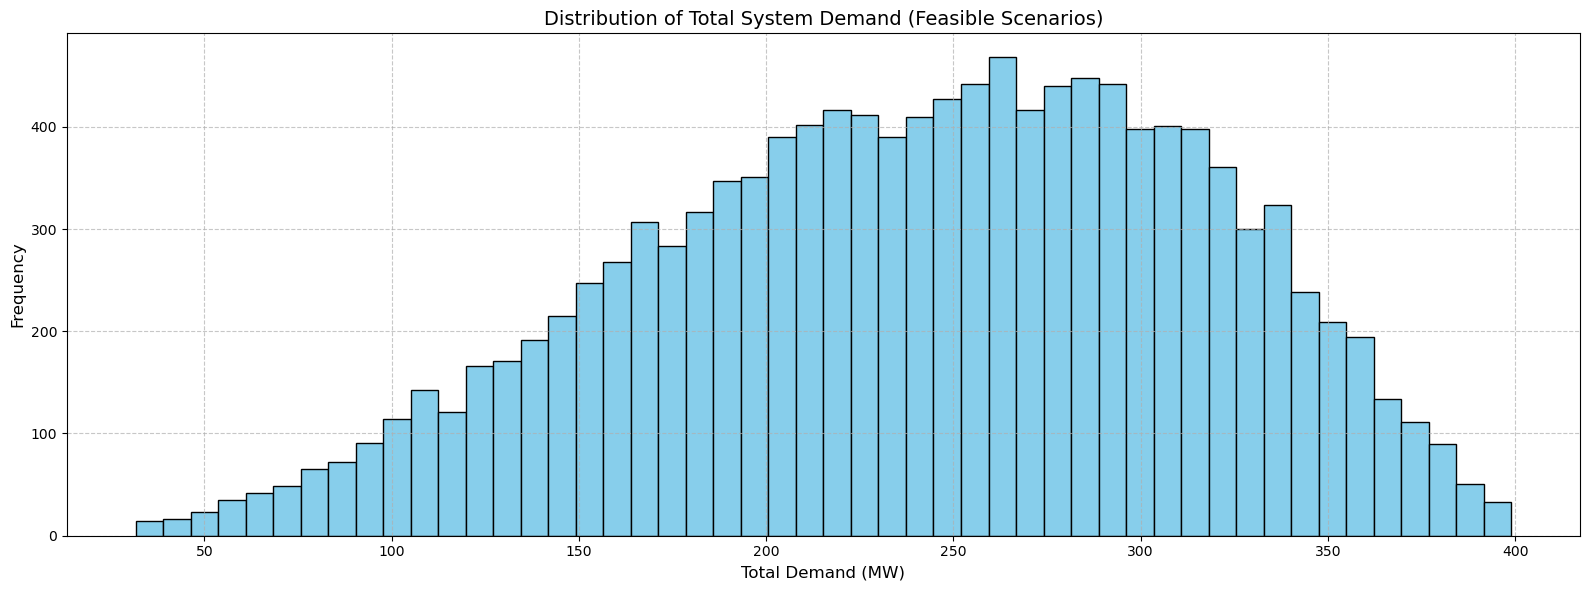

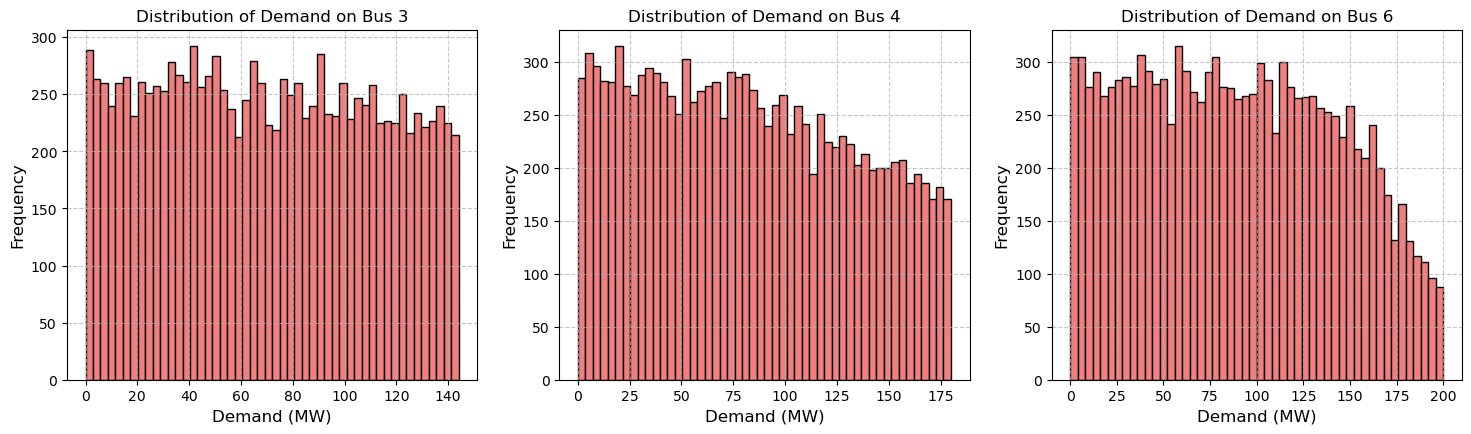


--- Demand Distribution Plots Generated ---
Number of feasible scenarios used for plotting: 12392


In [61]:
# Define the path to saved results file
save_file = "feasible_opf_results_per_bus_scale.json"

# Identify load buses (those with nominal Pd > 0)
load_bus_1_indices = [bus_id + 1 for bus_id, data in ieee_6_buses_data.items() if data['Pd'] > 0]
print(f"Identified Load Buses (1-indexed): {load_bus_1_indices}")

# --- Extract Demand Data ---
total_demands = []
# Dictionary to hold lists of demands for each load bus (using 1-indexed bus IDs)
individual_bus_demands = {bus_id: [] for bus_id in load_bus_1_indices}

for scenario in feasible_solutions_data:
    total_demands.append(scenario['input_parameters']['total_demand_MW'])
    
    # Extract individual bus loads for load buses
    for bus_id_1_indexed, demand_val in scenario['input_parameters']['bus_loads_MW'].items():
        # Ensure the bus_id_1_indexed is in our identified load buses
        if int(bus_id_1_indexed) in load_bus_1_indices:
            individual_bus_demands[int(bus_id_1_indexed)].append(demand_val)

# Convert lists to numpy arrays for easier plotting (if not already done by scenario logic)
total_demands = np.array(total_demands)
for bus_id in individual_bus_demands:
    individual_bus_demands[bus_id] = np.array(individual_bus_demands[bus_id])

# --- Plotting Distributions ---

# Set up matplotlib for better aesthetics
plt.rcParams.update({'font.size': 10}) # Adjust base font size

# Plot distribution of Total Demand
plt.figure(figsize=(16, 6))
plt.hist(total_demands, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Total System Demand (Feasible Scenarios)', fontsize=14)
plt.xlabel('Total Demand (MW)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7) # Explicitly add grid
plt.tight_layout()
plt.show()

# Plot distributions for each individual Load Bus
num_load_buses = len(load_bus_1_indices)
# Determine grid size for subplots
cols = 3
rows = 2

plt.figure(figsize=(cols * 6, rows * 5)) # Adjust figure size based on number of subplots

for i, bus_id in enumerate(load_bus_1_indices):
    plt.subplot(rows, cols, i + 1)
    plt.hist(individual_bus_demands[bus_id], bins=50, color='lightcoral', edgecolor='black')
    plt.title(f'Distribution of Demand on Bus {bus_id}', fontsize=12)
    plt.xlabel('Demand (MW)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7) # Explicitly add grid
    
plt.show()

print("\n--- Demand Distribution Plots Generated ---")
print(f"Number of feasible scenarios used for plotting: {len(feasible_solutions_data)}")


# Train GNNs to learn DC-OPF solutions

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, HeteroData
from torch_geometric.nn import GCNConv # Graph Convolutional Network layer
from torch_geometric.nn import GATConv, BatchNorm
from torch_geometric.nn import HeteroConv, Linear
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm # For progress bars during data creation

## Prepare for graph structures

In [62]:
# --- Create Graph Structure (Edge Index) - Constant for all scenarios ---
edge_list = []
for branch in ieee_6_branches_data:
    from_bus_0idx = branch['from_bus']
    to_bus_0idx = branch['to_bus']
    edge_list.append([from_bus_0idx, to_bus_0idx])
    edge_list.append([to_bus_0idx, from_bus_0idx]) # Add reverse edge for undirected graph

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

edge_index

tensor([[0, 1, 0, 3, 1, 2, 1, 4, 2, 3, 3, 5, 4, 5],
        [1, 0, 3, 0, 2, 1, 4, 1, 3, 2, 5, 3, 5, 4]])

In [69]:
with open("feasible_opf_results_per_bus_scale.json", 'r') as f:
    feasible_solutions_data = json.load(f)


In [72]:
def create_pyg_data_objects(json_file_path, buses_base_data, generators_data, branches_data_base,
                            edge_index_tensor, slack_bus_idx):
    """
    Reads the JSON dataset and converts each scenario into a PyTorch Geometric Data object.
    Each Data object contains node features (x), graph connectivity (edge_index),
    and target outputs (y).
    """
    all_data_objects = []

    # Pre-process generator data for efficient lookup:
    # Map 0-indexed bus ID to its generator details
    gen_details_map = {g['bus']: g for g in generators_data}
    gen_bus_0_indices = {g['bus'] for g in generators_data}
    
    # --- Pre-compute edge_attr_tensor ONCE outside the scenario loop ---
    static_edge_attr_list = []
    branch_features_map = {}
    for branch in branches_data_base:
        features = [branch['X_pu'], branch['limit_MW']]
        branch_features_map[(branch['from_bus'], branch['to_bus'])] = features
        # Add reverse direction for undirected graph, assuming symmetric features
        branch_features_map[(branch['to_bus'], branch['from_bus'])] = features

    edges = []
    for branch in ieee_6_branches_data_base:
        edges.append([branch['from_bus'], branch['to_bus']])
        edges.append([branch['to_bus'], branch['from_bus']]) # Add reverse edge for undirected graph
    edge_index_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous()
    print(f"Pre-computed edge_index_tensor shape: {edge_index_tensor.shape}")

    for i in range(edge_index_tensor.shape[1]):
        from_node = edge_index_tensor[0, i].item()
        to_node = edge_index_tensor[1, i].item()
        static_edge_attr_list.append(branch_features_map[(from_node, to_node)])

    static_edge_attr_tensor = torch.tensor(static_edge_attr_list, dtype=torch.float)
    print(f"Pre-computed static_edge_attr_tensor shape: {static_edge_attr_tensor.shape}")

    for scenario in tqdm(feasible_solutions_data, desc="Converting scenarios to PyG Data objects"):
        # --- Node Features (x): Input to the GNN ---
        # For each bus, create a feature vector.
        # Features: [Pd (load), Pmin (gen), Pmax (gen), cost_a (gen), cost_b (gen), cost_c (gen),
        #            is_slack_bus, is_generator_bus, is_load_bus]
        node_features = np.zeros((num_buses, 9), dtype=np.float32) # 9 features per node

        # The 'bus_loads_MW' are scenario-specific and 1-indexed in JSON
        current_bus_loads_1idx = scenario['input_parameters']['bus_loads_MW']
        
        for bus_idx in range(num_buses): # Iterate through 0-indexed bus IDs
            bus_label_1idx = bus_idx + 1 # Convert to 1-indexed for looking up in JSON data
            
            # 1. Load demand (Pd): Get from the current scenario's input parameters
            node_features[bus_idx, 0] = float(current_bus_loads_1idx.get(str(bus_label_1idx), 0.0))

            # 2-6. Generator parameters: Pmin, Pmax, cost_a, cost_b, cost_c
            if bus_idx in gen_bus_0_indices:
                gen_data = gen_details_map[bus_idx]
                node_features[bus_idx, 1] = gen_data['Pmin']
                node_features[bus_idx, 2] = gen_data['Pmax']
                node_features[bus_idx, 3] = gen_data['cost_a']
                node_features[bus_idx, 4] = gen_data['cost_b']
                node_features[bus_idx, 5] = gen_data['cost_c']

            # 7-9. Binary flags: Indicate bus type
            node_features[bus_idx, 6] = 1.0 if bus_idx == slack_bus_idx else 0.0      # is_slack_bus
            node_features[bus_idx, 7] = 1.0 if bus_idx in gen_bus_0_indices else 0.0  # is_generator_bus
            # is_load_bus: Check against base data for its static load characteristic
            node_features[bus_idx, 8] = 1.0 if buses_base_data[bus_idx]['Pd'] > 0 else 0.0 

        x = torch.tensor(node_features, dtype=torch.float)

        # --- Target Outputs ---
        # For each bus, predict: [theta (angle), Pg (generation)]
        # Pg will be 0 for non-generator buses in the target data.
        target_outputs = np.zeros((num_buses, 2), dtype=np.float32)

        # Theta (voltage angles in degrees)
        theta_1idx = scenario['output_decision_variables']['theta_degrees']
        for bus_idx in range(num_buses):
            target_outputs[bus_idx, 0] = float(theta_1idx.get(str(bus_idx + 1), 0.0))

        # Pg (active power generation)
        pg_1idx = scenario['output_decision_variables']['pg_MW']
        for bus_idx in gen_bus_0_indices: # Only get Pg for actual generator buses
            target_outputs[bus_idx, 1] = float(pg_1idx.get(str(bus_idx + 1), 0.0))

        y = torch.tensor(target_outputs, dtype=torch.float)
        
        # Create PyTorch Geometric Data object for this scenario
        data = Data(x=x, edge_index=edge_index_tensor, y=y, edge_attr=static_edge_attr_tensor)
        all_data_objects.append(data)
    
    return all_data_objects


In [73]:
# --- Load and Prepare Dataset ---
output_json_filename = "feasible_opf_results_per_bus_scale.json"
dataset = create_pyg_data_objects(output_json_filename, 
                                  ieee_6_buses_data, 
                                  ieee_6_generators_data, 
                                  ieee_6_branches_data_base,
                                  edge_index, 
                                  SLACK_BUS_IDX)

if not dataset:
    print("No data loaded. Exiting.")
    exit()

print(f"\nDataset created with {len(dataset)} graphs.")
print(f"Example graph features (x.shape): {dataset[0].x.shape}")
print(f"Example graph targets (y.shape): {dataset[0].y.shape}")
print(f"Example graph edge_index (edge_index.shape): {dataset[0].edge_index.shape}")
print(f"Example graph edge_attr (edge_attr.shape): {dataset[0].edge_attr.shape}")
print(f"Sample edge_attr for the first few edges:\n{dataset[0].edge_attr[:4]}")


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])


Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3721


Dataset created with 12392 graphs.
Example graph features (x.shape): torch.Size([6, 9])
Example graph targets (y.shape): torch.Size([6, 2])
Example graph edge_index (edge_index.shape): torch.Size([2, 14])
Example graph edge_attr (edge_attr.shape): torch.Size([14, 2])
Sample edge_attr for the first few edges:
tensor([[  0.1703, 100.0000],
        [  0.1703, 100.0000],
        [  0.2081, 100.0000],
        [  0.2081, 100.0000]])


In [74]:
# --- Data Scaling (Normalization) ---
# Concatenate all node features, targets, and edge attributes from the dataset
all_x_features = torch.cat([data.x for data in dataset], dim=0).numpy()
all_y_targets = torch.cat([data.y for data in dataset], dim=0).numpy()
all_edge_attrs = torch.cat([data.edge_attr for data in dataset], dim=0).numpy()

# Initialize scalers
x_scaler = StandardScaler()
y_scaler = StandardScaler()
edge_attr_scaler = StandardScaler()

# Fit scalers to the concatenated data
x_scaler.fit(all_x_features)
y_scaler.fit(all_y_targets)
edge_attr_scaler.fit(all_edge_attrs)

# Apply scaling to each Data object in the dataset
for data in dataset:
    data.x = torch.tensor(x_scaler.transform(data.x.numpy()), dtype=torch.float)
    data.y = torch.tensor(y_scaler.transform(data.y.numpy()), dtype=torch.float)
    data.edge_attr = torch.tensor(edge_attr_scaler.transform(data.edge_attr.numpy()), dtype=torch.float)

# --- Split Dataset into Training and Testing ---
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# Check x scaler
print(f"Shape of data used to fit x_scaler: {all_x_features.shape}")
print(f"x_scaler mean_ (per feature): {x_scaler.mean_}")
print(f"x_scaler scale_ (std dev per feature): {x_scaler.scale_}") # scale_ is std dev


Training samples: 9913, Test samples: 2479
Shape of data used to fit x_scaler: (74352, 9)
x_scaler mean_ (per feature): [4.02532296e+01 5.00000000e+00 1.00000000e+02 2.00000006e-03
 1.33333333e+01 0.00000000e+00 1.66666667e-01 5.00000000e-01
 5.00000000e-01]
x_scaler scale_ (std dev per feature): [5.32915122e+01 5.00000000e+00 1.04083300e+02 2.38484806e-03
 1.49071199e+01 1.00000000e+00 3.72677996e-01 5.00000000e-01
 5.00000000e-01]


## Define GNNs

In [75]:
# --- Define the Simple GNN Model ---
class SimpleGNN(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_output_features):
        super().__init__()
        # GCNConv layers are designed for graph structured data.
        # They perform aggregation of neighbor features and then a linear transformation.
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_output_features)

    def forward(self, data):
        # x: Node feature matrix, shape [num_nodes, num_node_features]
        # edge_index: Graph connectivity in COO format, shape [2, num_edges]
        x, edge_index = data.x, data.edge_index

        # Apply the first GCN layer and ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        # Apply the second GCN layer (output layer)
        x = self.conv2(x, edge_index)

        return x

# --- Define the GCN Model ---
class GCNWithBatchNormAndDropout(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_output_features, dropout_rate=0.5):
        super().__init__()
        # First GCNConv layer: Input features to hidden channels
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        # Batch Normalization after the first convolutional layer
        self.bn1 = BatchNorm(hidden_channels)
        
        # Second GCNConv layer: Hidden channels to output features
        self.conv2 = GCNConv(hidden_channels, num_output_features)
        
        # Dropout rate for regularization
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply first GCNConv layer
        x = self.conv1(x, edge_index)
        # Apply Batch Normalization
        x = self.bn1(x)
        # Apply ReLU activation
        x = F.relu(x)
        # Apply Dropout
        x = F.dropout(x, p=self.dropout_rate, training=self.training) # 'training' ensures dropout is active only during training

        # Apply second GCNConv layer (output layer)
        # No activation function here for regression tasks
        x = self.conv2(x, edge_index)

        return x

# --- Define the GAT Model ---    
class GATModel(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_output_features, num_layers=3, heads=1, dropout_rate=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.heads = heads # Number of attention heads for GATConv

        # Define GATConv layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList() # Batch Normalization layers

        # Input layer
        self.convs.append(GATConv(num_node_features, hidden_channels, heads=heads, dropout=dropout_rate))
        self.bns.append(BatchNorm(hidden_channels * heads)) # BatchNorm after concatenation of heads

        # Hidden layers
        for _ in range(num_layers - 2): # -2 because we already have input and output layer
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout_rate))
            self.bns.append(BatchNorm(hidden_channels * heads))

        # Output layer
        self.convs.append(GATConv(hidden_channels * heads, num_output_features, heads=1, concat=False, dropout=dropout_rate))


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            
            # Apply Batch Normalization and ReLU for hidden layers
            if i < self.num_layers - 1: # Don't apply BN/ReLU to the final output layer
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout_rate, training=self.training)
            
        return x
    
# --- Modified GATModel to include edge features ---
class GATEdgeModel(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_output_features, 
                 num_layers=3, heads=1, dropout_rate=0.5, edge_dim=None): # <--- Added edge_dim here
        super().__init__()
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.heads = heads
        self.edge_dim = edge_dim # Store edge_dim

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        # Input layer
        # Pass edge_dim to GATConv
        self.convs.append(GATConv(num_node_features, hidden_channels, 
                                  heads=heads, dropout=dropout_rate, edge_dim=self.edge_dim))
        self.bns.append(BatchNorm(hidden_channels * heads)) 

        # Hidden layers
        for _ in range(num_layers - 2):
            # Pass edge_dim to GATConv
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, 
                                      heads=heads, dropout=dropout_rate, edge_dim=self.edge_dim))
            self.bns.append(BatchNorm(hidden_channels * heads))

        # Output layer
        # Pass edge_dim to GATConv. Usually dropout is 0 for output layer.
        self.convs.append(GATConv(hidden_channels * heads, num_output_features, 
                                  heads=1, concat=False, dropout=0.0, edge_dim=self.edge_dim))


    def forward(self, data):
        # Retrieve edge_attr from the data object
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr # <--- Retrieve edge_attr here

        for i, conv in enumerate(self.convs):
            # Pass edge_attr to the conv layer
            x = conv(x, edge_index, edge_attr) # <--- Pass edge_attr here
            
            if i < self.num_layers - 1:
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout_rate, training=self.training)
                
        return x


## GNN training

In [76]:
# MODEL 1
# Determine input and output dimensions for the GNN
############
num_node_features = dataset[0].x.shape[1] # Should be 9 features per node
num_output_features = dataset[0].y.shape[1] # Should be 2 features per node (theta, Pg)
hidden_channels = 64 # A hyperparameter for the number of features in the hidden layer
model = SimpleGNN(num_node_features, hidden_channels, num_output_features)

print(f"\nModel Architecture:\n{model}")
print(f"Number of input node features: {num_node_features}")
print(f"Number of output features per node (theta, Pg): {num_output_features}")
############

############
# num_node_features = dataset[0].x.shape[1] # Should be 9 features per node
# num_output_features = dataset[0].y.shape[1] # Should be 2 features per node (theta, Pg)
# hidden_channels = 64 # A hyperparameter for the number of features in the hidden layer
# dropout_rate = 0.1  # Adjusted dropout rate
# model = GCNWithBatchNormAndDropout(num_node_features, hidden_channels, num_output_features, dropout_rate)

# print(f"\nModel Architecture:\n{model}")
# print(f"Number of input node features: {num_node_features}")
# print(f"Number of output features per node (theta, Pg): {num_output_features}")
############

# MODEL 2
# Determine input and output dimensions for the GAT
############
# hidden_channels = 32 # Increased hidden channels
# num_layers = 4      # Deeper network
# heads = 2           # Using 2 attention heads
# dropout_rate = 0.1  # Adjusted dropout rate
# model = GATModel(num_node_features, hidden_channels, num_output_features,
#                  num_layers=num_layers, heads=heads, dropout_rate=dropout_rate)

# print(f"\nModel Architecture:\n{model}")
# print(f"Number of input node features: {num_node_features}")
# print(f"Number of output features per node (theta, Pg): {num_output_features}")
############

# MODEL 3
# Instantiate the GATModel with edge_dim
############
# hidden_channels = 64 # Increased hidden channels
# num_layers = 4      # Deeper network
# heads = 3           # Using 2 attention heads
# dropout_rate = 0.2  # Adjusted dropout rate
# num_edge_features = dataset[0].edge_attr.shape[1]
# model = GATEdgeModel(num_node_features, hidden_channels, num_output_features,
#                      num_layers=num_layers, heads=heads, dropout_rate=dropout_rate,
#                      edge_dim=num_edge_features)
# print(f"Number of edge features : {num_edge_features}")
############



Model Architecture:
SimpleGNN(
  (conv1): GCNConv(9, 64)
  (conv2): GCNConv(64, 2)
)
Number of input node features: 9
Number of output features per node (theta, Pg): 2


In [77]:
# --- Training Loop ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = torch.nn.MSELoss()

# --- Define the coefficient for the physical loss term ---
PHYSICAL_LOSS_WEIGHT_BALANCE = 0.0 # Weight for demand-supply balance violation
PHYSICAL_LOSS_WEIGHT_GEN_LIMITS = 0.0 # Weight for generator Pmin/Pmax violation
BALANCE_TOLERANCE_MW = 0.5   # e.g., 0.5 MW deviation in total balance is acceptable
GEN_MIN_TOLERANCE_MW = 0.1   # e.g., 0.1 MW under Pmin is acceptable
GEN_MAX_TOLERANCE_MW = 0.1   # e.g., 0.1 MW over Pmax is acceptable

# Pre-process generator data for efficient lookup for conlstraint calculation
# Map 0-indexed bus ID to its generator details (Pmin, Pmax)
gen_details_map_pmax_pmin = {
    g['bus']: {'Pmin': g['Pmin'], 'Pmax': g['Pmax']}
    for g in ieee_6_generators_data
}
gen_bus_0_indices_global = torch.tensor([g['bus'] for g in ieee_6_generators_data], dtype=torch.long)

def train_one_epoch(data_loader):
    model.train() # Set model to training mode
    total_loss = 0
    
    # Move gen_bus_0_indices_global to device once
    gen_bus_0_indices_on_device = gen_bus_0_indices_global.to(device)
    
    # Move tolerance tensors to device once per epoch for efficiency
    balance_tolerance_on_device = torch.tensor(BALANCE_TOLERANCE_MW, dtype=torch.float).to(device)
    gen_min_tolerance_on_device = torch.tensor(GEN_MIN_TOLERANCE_MW, dtype=torch.float).to(device)
    gen_max_tolerance_on_device = torch.tensor(GEN_MAX_TOLERANCE_MW, dtype=torch.float).to(device)
    
    for data in data_loader:
        data = data.to(device) # Move data to the selected device (CPU/GPU)
        optimizer.zero_grad()  # Clear gradients from previous step
        out = model(data)      # Forward pass: predict outputs
        
        # --- Supervised Loss (MSE) ---
        supervised_loss = criterion(out, data.y)

        # --- Unscale predicted outputs and inputs for physical calculations ---
        predicted_unscaled = torch.tensor(y_scaler.inverse_transform(out.detach().cpu().numpy()), dtype=torch.float).to(device)
        predicted_pg = predicted_unscaled[:, 1] # Predicted generator active power (MW)

        input_unscaled = torch.tensor(x_scaler.inverse_transform(data.x.detach().cpu().numpy()), dtype=torch.float).to(device)
        bus_loads_pd = input_unscaled[:, 0] # Bus loads (MW)

        # --- Physical Loss: Demand-Supply Balance Violation with Tolerance ---
        is_generator_bus_mask = torch.zeros(num_buses, dtype=torch.bool).to(device)
        is_generator_bus_mask[gen_bus_0_indices_on_device] = True

        total_predicted_pg_sum = predicted_pg[is_generator_bus_mask].sum()
        total_demand = bus_loads_pd.sum()

        # Calculate violation, then subtract tolerance and apply ReLU
        raw_balance_violation = torch.abs(total_predicted_pg_sum - total_demand)
        balance_violation_with_tolerance = F.relu(raw_balance_violation - balance_tolerance_on_device)
        
        physical_loss_balance = balance_violation_with_tolerance 

        # --- Physical Loss: Generator Power Limit Violation with Tolerance ---
        gen_limit_violation = torch.tensor(0.0).to(device)

        # Iterate over generator buses to check their limits
        for bus_idx_0idx in gen_bus_0_indices_global.cpu().numpy(): # Iterate on CPU, then use values on device
            gen_limits = gen_details_map_pmax_pmin[bus_idx_0idx]
            pmin = torch.tensor(gen_limits['Pmin'], dtype=torch.float).to(device)
            pmax = torch.tensor(gen_limits['Pmax'], dtype=torch.float).to(device)
            
            predicted_pg_at_bus = predicted_pg[bus_idx_0idx] # Get the predicted Pg for this specific generator bus

            # Penalty for violating Pmin (if predicted Pg is less than Pmin)
            under_generation_penalty = F.relu(pmin - predicted_pg_at_bus - gen_min_tolerance_on_device)
            
            # Penalty for violating Pmax (if predicted Pg is greater than Pmax)
            over_generation_penalty = F.relu(predicted_pg_at_bus - pmax - gen_max_tolerance_on_device)
            
            gen_limit_violation += (under_generation_penalty + over_generation_penalty)
        
        # --- Combine all losses ---
        loss = (supervised_loss + 
                PHYSICAL_LOSS_WEIGHT_BALANCE * physical_loss_balance +
                PHYSICAL_LOSS_WEIGHT_GEN_LIMITS * gen_limit_violation)
        
        loss.backward()

        optimizer.step()       # Update model parameters
        total_loss += loss.item() # Accumulate loss

    return total_loss / len(data_loader) # Return average loss for the epoch

def evaluate_model(data_loader):
    model.eval() # Set model to evaluation mode
    total_loss = 0
    
    # Move gen_bus_0_indices_global to device once
    gen_bus_0_indices_on_device = gen_bus_0_indices_global.to(device)

    # Move tolerance tensors to device once per epoch for efficiency
    balance_tolerance_on_device = torch.tensor(BALANCE_TOLERANCE_MW, dtype=torch.float).to(device)
    gen_min_tolerance_on_device = torch.tensor(GEN_MIN_TOLERANCE_MW, dtype=torch.float).to(device)
    gen_max_tolerance_on_device = torch.tensor(GEN_MAX_TOLERANCE_MW, dtype=torch.float).to(device)

    with torch.no_grad(): # Disable gradient calculation for evaluation
        for data in data_loader:
            data = data.to(device)
            out = model(data)
            
            supervised_loss = criterion(out, data.y)

            # --- Unscale predicted outputs and inputs for physical calculations ---
            predicted_unscaled = torch.tensor(y_scaler.inverse_transform(out.detach().cpu().numpy()), dtype=torch.float).to(device)
            predicted_pg = predicted_unscaled[:, 1] # Predicted generator active power (MW)

            input_unscaled = torch.tensor(x_scaler.inverse_transform(data.x.detach().cpu().numpy()), dtype=torch.float).to(device)
            bus_loads_pd = input_unscaled[:, 0] # Bus loads (MW)

            # --- Physical Loss: Demand-Supply Balance Violation with Tolerance ---
            is_generator_bus_mask = torch.zeros(num_buses, dtype=torch.bool).to(device)
            is_generator_bus_mask[gen_bus_0_indices_on_device] = True

            total_predicted_pg_sum = predicted_pg[is_generator_bus_mask].sum()
            total_demand = bus_loads_pd.sum()

            raw_balance_violation = torch.abs(total_predicted_pg_sum - total_demand)
            balance_violation_with_tolerance = F.relu(raw_balance_violation - balance_tolerance_on_device)
            
            physical_loss_balance = balance_violation_with_tolerance 

            # --- Physical Loss: Generator Power Limit Violation with Tolerance ---
            gen_limit_violation = torch.tensor(0.0).to(device)

            for bus_idx_0idx in gen_bus_0_indices_global.cpu().numpy():
                gen_limits = gen_details_map_pmax_pmin[bus_idx_0idx]
                pmin = torch.tensor(gen_limits['Pmin'], dtype=torch.float).to(device)
                pmax = torch.tensor(gen_limits['Pmax'], dtype=torch.float).to(device)
                
                predicted_pg_at_bus = predicted_pg[bus_idx_0idx]

                under_generation_penalty = F.relu(pmin - predicted_pg_at_bus - gen_min_tolerance_on_device)
                over_generation_penalty = F.relu(predicted_pg_at_bus - pmax - gen_max_tolerance_on_device)
                
                gen_limit_violation += (under_generation_penalty + over_generation_penalty)
            
            # --- Combine all losses for evaluation ---
            loss = (supervised_loss + 
                    PHYSICAL_LOSS_WEIGHT_BALANCE * physical_loss_balance +
                    PHYSICAL_LOSS_WEIGHT_GEN_LIMITS * gen_limit_violation)

            total_loss += loss.item()
    return total_loss / len(data_loader)

# Use DataLoader with batch_size=1 because each 'data' object is a full graph.
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

num_epochs = 100 # Number of training iterations

print(f"\nStarting training on {device} for {num_epochs} epochs...")
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(train_loader)
    
    if epoch % 5 == 0: # Print evaluation results every 5 epochs
        test_loss = evaluate_model(test_loader)
        print(f'Epoch: {epoch:03d}, Train MSE: {train_loss:.4f}, Test MSE: {test_loss:.4f}')

print("\nTraining complete!")



Starting training on cpu for 100 epochs...
Epoch: 005, Train MSE: 0.1291, Test MSE: 0.1290
Epoch: 010, Train MSE: 0.1280, Test MSE: 0.1266
Epoch: 015, Train MSE: 0.1272, Test MSE: 0.1271
Epoch: 020, Train MSE: 0.1269, Test MSE: 0.1249
Epoch: 025, Train MSE: 0.1266, Test MSE: 0.1253
Epoch: 030, Train MSE: 0.1265, Test MSE: 0.1265
Epoch: 035, Train MSE: 0.1263, Test MSE: 0.1244
Epoch: 040, Train MSE: 0.1262, Test MSE: 0.1270
Epoch: 045, Train MSE: 0.1262, Test MSE: 0.1247
Epoch: 050, Train MSE: 0.1262, Test MSE: 0.1251
Epoch: 055, Train MSE: 0.1261, Test MSE: 0.1245
Epoch: 060, Train MSE: 0.1261, Test MSE: 0.1255
Epoch: 065, Train MSE: 0.1261, Test MSE: 0.1246
Epoch: 070, Train MSE: 0.1260, Test MSE: 0.1253
Epoch: 075, Train MSE: 0.1260, Test MSE: 0.1251
Epoch: 080, Train MSE: 0.1260, Test MSE: 0.1247
Epoch: 085, Train MSE: 0.1260, Test MSE: 0.1241
Epoch: 090, Train MSE: 0.1258, Test MSE: 0.1241
Epoch: 095, Train MSE: 0.1259, Test MSE: 0.1248
Epoch: 100, Train MSE: 0.1259, Test MSE: 0.1

In [78]:
# --- Final Evaluation and Example Inference ---
final_train_loss = evaluate_model(train_loader)
final_test_loss = evaluate_model(test_loader)
print(f"\nFinal Train MSE: {final_train_loss:.4f}")
print(f"Final Test MSE: {final_test_loss:.4f}")

# --- Example Inference on a Test Sample ---
if len(test_dataset) > 0:
    print("\n--- Example Inference on a Test Scenario ---")
    sample_data = test_dataset[0].to(device) # Pick the first test sample
    model.eval() # Set model to evaluation mode

    with torch.no_grad():
        predicted_output_scaled = model(sample_data)
    
    # Inverse transform the predictions to get them back into original units (MW, degrees)
    predicted_output_np = y_scaler.inverse_transform(predicted_output_scaled.cpu().numpy())
    true_output_np = y_scaler.inverse_transform(sample_data.y.cpu().numpy())
    
    # Inverse transform the input features for display
    input_features_np = x_scaler.inverse_transform(sample_data.x.cpu().numpy())
    print(sample_data.x)
    print(input_features_np)

    print("\nInput Load Demands for this Scenario (MW):")
    for i in range(num_buses):
        # Node feature index 0 corresponds to Pd
        current_pd_val = input_features_np[i, 0] 
        print(f"  Bus {i+1}: {current_pd_val:.2f} MW")

    print("\nPredicted vs. True Pg (MW) and Theta (Degrees) per bus:")
    for i in range(num_buses):
        bus_label = i + 1
        
        # Get true values
        true_theta = true_output_np[i, 0]
        true_pg = true_output_np[i, 1]
        
        # Get predicted values
        pred_theta = predicted_output_np[i, 0]
        pred_pg = predicted_output_np[i, 1]
        
        bus_type_info = []
        if ieee_6_buses_data[i]['Pd'] > 0:
            bus_type_info.append(f"L:{ieee_6_buses_data[i]['Pd']}MW")
        if i in {g['bus'] for g in ieee_6_generators_data}:
            bus_type_info.append("G")
        if i == SLACK_BUS_IDX:
            bus_type_info.append("Slack")
        
        type_str = f"({', '.join(bus_type_info)})" if bus_type_info else ""

        print(f"  Bus {bus_label} {type_str}:")
        print(f"    Theta: Pred={pred_theta:.2f} deg, True={true_theta:.2f} deg")
        print(f"    Pg:    Pred={pred_pg:.2f} MW, True={true_pg:.2f} MW")

    print("\nNote: For non-generator buses, the 'True Pg' should be close to 0 MW.")
    print("The model is trained to minimize MSE for both theta and Pg across all nodes.")



Final Train MSE: 0.1264
Final Test MSE: 0.1256

--- Example Inference on a Test Scenario ---
tensor([[-0.7553,  1.0000,  1.4412,  0.8386,  0.4472,  0.0000,  2.2361,  1.0000,
         -1.0000],
        [-0.7553,  1.0000,  0.9608, -0.1048,  0.4472,  0.0000, -0.4472,  1.0000,
         -1.0000],
        [ 0.5761, -1.0000, -0.9608, -0.8386, -0.8944,  0.0000, -0.4472, -1.0000,
          1.0000],
        [ 2.0454, -1.0000, -0.9608, -0.8386, -0.8944,  0.0000, -0.4472, -1.0000,
          1.0000],
        [-0.7553,  1.0000,  0.4804,  1.7821,  1.7889,  0.0000, -0.4472,  1.0000,
         -1.0000],
        [ 0.5501, -1.0000, -0.9608, -0.8386, -0.8944,  0.0000, -0.4472, -1.0000,
          1.0000]])
[[-1.4503385e-06  1.0000000e+01  2.5000000e+02  4.0000002e-03
   2.0000000e+01  0.0000000e+00  1.0000000e+00  1.0000000e+00
   0.0000000e+00]
 [-1.4503385e-06  1.0000000e+01  2.0000000e+02  1.7500001e-03
   2.0000000e+01  0.0000000e+00 -4.9670539e-09  1.0000000e+00
   0.0000000e+00]
 [ 7.0952362e+01  0.0

## Model comparison

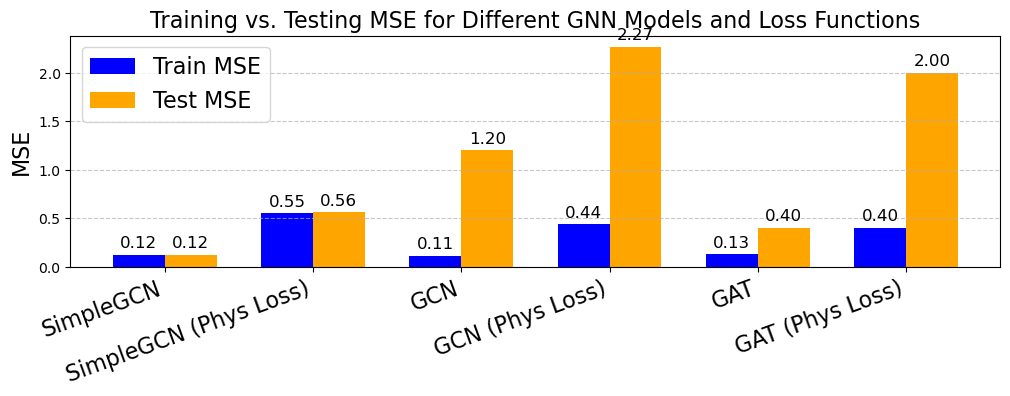


--- Bar Plot Generated for Model Performance Comparison ---


In [79]:
# These values are chosen to illustrate common trends:
# 1. Overfitting: Train MSE is generally lower than Test MSE.
# 2. Physical Losses:
#    - May slightly increase Train MSE (due to added constraints).
#    - Significantly reduce Test MSE (improving generalization).
# 3. Model Complexity: GAT often performs better than GCN, which might be better than SimpleGCN.

model_names = ['SimpleGCN', 'GCN', 'GAT'] # GCN refers to GCNWithBatchNormAndDropout

# MSE values for 'Standard MSE' (without physical losses)
train_mse_standard = [0.1247, 0.1113, 0.1306]  # Lower values for train
test_mse_standard  = [0.1238, 1.2005, 0.4]   # Higher values for test (indicating overfitting)

# MSE values for 'MSE + Physical Loss'
train_mse_phys = [0.5497, 0.4371, 0.4] # Train MSE might be slightly higher due to added constraint
test_mse_phys  = [0.5600, 2.2699, 2.0]  # Test MSE should be notably lower (better generalization)

# Combine the data for easier plotting
# Each key represents a unique combination of Model and Loss Type
results_data = {
    'SimpleGCN_Standard': {'train': train_mse_standard[0], 'test': test_mse_standard[0]},
    'SimpleGCN_Phys': {'train': train_mse_phys[0], 'test': test_mse_phys[0]},
    'GCN_Standard': {'train': train_mse_standard[1], 'test': test_mse_standard[1]},
    'GCN_Phys': {'train': train_mse_phys[1], 'test': test_mse_phys[1]},
    'GAT_Standard': {'train': train_mse_standard[2], 'test': test_mse_standard[2]},
    'GAT_Phys': {'train': train_mse_phys[2], 'test': test_mse_phys[2]},
}

# Labels for the x-axis
labels = [
    'SimpleGCN', 'SimpleGCN (Phys Loss)',
    'GCN', 'GCN (Phys Loss)',
    'GAT', 'GAT (Phys Loss)'
]

# Extract values for plotting
train_mse_values = [results_data[key]['train'] for key in results_data]
test_mse_values = [results_data[key]['test'] for key in results_data]

# Set up the plot
x = np.arange(len(labels))  # The label locations on the x-axis
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(12, 3)) # Adjust figure size as needed

# Plotting bars for Train MSE
rects1 = ax.bar(x - width/2, train_mse_values, width, label='Train MSE', color='blue') # Light Blue
# Plotting bars for Test MSE
rects2 = ax.bar(x + width/2, test_mse_values, width, label='Test MSE', color='orange')  # Dark Blue

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('MSE', fontsize=16)
ax.set_title('Training vs. Testing MSE for Different GNN Models and Loss Functions', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=20, ha='right', fontsize=16) # Rotate labels for better readability
ax.legend(fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to add value labels on top of bars
def autolabel(rects, current_ax):
    for rect in rects:
        height = rect.get_height()
        current_ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)

# Apply value labels to both sets of bars
autolabel(rects1, ax)
autolabel(rects2, ax)

# plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("\n--- Bar Plot Generated for Model Performance Comparison ---")


# A test run to combine solar forecasting with GNN

In [80]:
# Assuming 'original_data' is a torch_geometric.data.Data object on the correct device
# and contains original scaled 'x', 'edge_index', and 'y' (true values for original scenario)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
original_data = test_dataset[0].to(device)
model.eval()

# --- 1. Choose a Load Bus and Generate Random PV Generation ---
# Choose Bus 3 (0-indexed 2) as the load bus for adding PV.
target_load_bus_idx = 2
original_load_bus_pd_idx = 0

# Get original (scaled) features and unscale them
original_x_np = original_data.x.cpu().numpy()
original_x_unscaled_np = x_scaler.inverse_transform(original_x_np)

# Get the original load at the target bus
original_pd_at_target_bus = original_x_unscaled_np[target_load_bus_idx, original_load_bus_pd_idx]
print(f"Original Load at Bus {target_load_bus_idx + 1}: {original_pd_at_target_bus:.2f} MW")

# Generate a random PV generation value (e.g., between 0 MW and 100 MW)
random_pv_generation_mw = random.uniform(0, 100)
print(f"Random PV Generation added to Bus {target_load_bus_idx + 1}: {random_pv_generation_mw:.2f} MW")

# --- 2. Modify the Input Data (as a "Negative Load") ---
# Create a copy to modify without affecting the original data object
modified_x_unscaled_np = original_x_unscaled_np.copy()
# Calculate net load: subtract PV generation from original load
new_pd_at_target_bus = original_pd_at_target_bus - random_pv_generation_mw
modified_x_unscaled_np[target_load_bus_idx, original_load_bus_pd_idx] = new_pd_at_target_bus
print(f"New Net Load at Bus {target_load_bus_idx + 1}: {new_pd_at_target_bus:.2f} MW")

# Rescale the modified input features back to the model's expected range
modified_x_scaled_np = x_scaler.transform(modified_x_unscaled_np)
modified_data = Data(x=torch.tensor(modified_x_scaled_np, dtype=torch.float),
                     edge_index=original_data.edge_index,
                     y=original_data.y) # Keep original y for comparison (true values for original scenario)
modified_data = modified_data.to(device)

# --- 3. Perform Inference ---
print("\n--- Performing Inference ---")
with torch.no_grad(): # Disable gradient calculation for inference
    predicted_output_scaled_original = model(original_data)
    predicted_output_scaled_modified = model(modified_data)

# --- 4. Inverse Transform Results for Readability ---
predicted_output_np_original = y_scaler.inverse_transform(predicted_output_scaled_original.cpu().numpy())
predicted_output_np_modified = y_scaler.inverse_transform(predicted_output_scaled_modified.cpu().numpy())
true_output_np = y_scaler.inverse_transform(original_data.y.cpu().numpy())

# --- 5. Display Results ---
print("\n--- Inference Results ---")
print(f"Scenario: Original Load at Bus {target_load_bus_idx + 1}")
print(f"Scenario: Random PV Generation ({random_pv_generation_mw:.2f} MW) added to Bus {target_load_bus_idx + 1}")

print("\nBus | Type   | Original Load (MW) | Mod. Net Load (MW) | True Theta (deg) | Pred Theta (deg) [Org] | Pred Theta (deg) [Mod] | True Pg (MW) | Pred Pg (MW) [Org] | Pred Pg (MW) [Mod]")
print("-" * 180) # Increased length for better formatting

for i in range(num_buses):
    bus_label = i + 1
    
    # Get bus type info for display
    bus_type_info = []
    if ieee_6_buses_data[i]['Pd'] > 0:
        bus_type_info.append(f"L:{ieee_6_buses_data[i]['Pd']}MW")
    if i in {g['bus'] for g in ieee_6_generators_data}:
        bus_type_info.append("G")
    if i == SLACK_BUS_IDX:
        bus_type_info.append("Slack")
    
    type_str = f"({', '.join(bus_type_info)})" if bus_type_info else ""

    # Original load display
    current_original_pd = original_x_unscaled_np[i, original_load_bus_pd_idx]
    
    # Modified load display
    current_modified_pd = modified_x_unscaled_np[i, original_load_bus_pd_idx]

    # True values from the original data (used as a baseline for comparison)
    true_theta = true_output_np[i, 0]
    true_pg = true_output_np[i, 1]

    # Predicted values for original and modified scenarios
    pred_theta_original = predicted_output_np_original[i, 0]
    pred_pg_original = predicted_output_np_original[i, 1]
    
    pred_theta_modified = predicted_output_np_modified[i, 0]
    pred_pg_modified = predicted_output_np_modified[i, 1]
    
    # Format output
    print(f"{bus_label:<3} | {type_str:<9} | {current_original_pd:<9.2f} | {current_modified_pd:<9.2f} | {true_theta:<9.2f} | {pred_theta_original:<9.2f} | {pred_theta_modified:<9.2f} | {true_pg:<9.2f} | {pred_pg_original:<12.2f} | {pred_pg_modified:<12.2f}")


Original Load at Bus 3: 70.95 MW
Random PV Generation added to Bus 3: 29.50 MW
New Net Load at Bus 3: 41.45 MW

--- Performing Inference ---

--- Inference Results ---
Scenario: Original Load at Bus 3
Scenario: Random PV Generation (29.50 MW) added to Bus 3

Bus | Type   | Original Load (MW) | Mod. Net Load (MW) | True Theta (deg) | Pred Theta (deg) [Org] | Pred Theta (deg) [Mod] | True Pg (MW) | Pred Pg (MW) [Org] | Pred Pg (MW) [Mod]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1   | (G, Slack) | -0.00     | -0.00     | 0.00      | 80.22     | 274.77    | 85.16     | 131.19       | 115.42      
2   | (G)       | -0.00     | -0.00     | 546.36    | 134.36    | 286.23    | 194.61    | 143.36       | 146.93      
3   | (L:80MW)  | 70.95     | 41.45     | -859.52   | -1258.53  | -928.93   | -0.00     | -5.46        | -11.62      
4   | (L:100MW) | 149.26

In [81]:
# --- Day-ahead hourly solar forecasts (example data in MW) ---
hourly_solar_forecasts_mw = [
    0, 0, 0, 0, 0,  # Hour 0-4: Night
    0, 0, 2.436, 11.108, 23.277, 
    35.48, 45.441, 49.654, 52.441, 48.99, 
    38.1, 23.899, 10.196, 4.503, 2.68, 
    0, 0, 0, 0 # Hour 18-23: Evening/Night
]

# --- Define Hourly Load Profiles for Each Bus ---
hourly_load_factors = [
    0.70, 0.65, 0.60, 0.60, 0.65, 0.75, # 00:00 - 05:00 (low night load)
    0.85, 0.95, 1.15, 1.25, 1.30, 1.25, # 06:00 - 11:00 (morning ramp-up, midday)
    1.20, 1.35, 1.30, 1.20, 1.10, 0.95, # 12:00 - 17:00 (afternoon decline)
    1.15, 1.35, 1.00, 0.95, 0.80, 0.55  # 18:00 - 23:00 (evening decline)
]

# Assuming 'original_data' is a torch_geometric.data.Data object on the correct device
# and contains original scaled 'x', 'edge_index', and 'y' (true values for original scenario)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
original_data = test_dataset[0].to(device)
model.eval()

# --- 1. Choose a Load Bus and Generate Random PV Generation ---
# Choose Bus 3 (0-indexed 2) as the load bus for adding PV.
target_load_bus_idx = 2
original_load_bus_pd_idx = 0

# Store results for potential later plotting or aggregate analysis
all_hourly_results = []

for hr_idx in range(0, 24):
    
    # Initialize hourly data
    hour_data = {"predicted_theta_deg": {},
                 "predicted_pg_mw": {}}
    
    # Get original (scaled) features and unscale them
    original_x_np = original_data.x.cpu().numpy()
    original_x_unscaled_np = x_scaler.inverse_transform(original_x_np)

    # Get the original load at the target bus
    original_pd_at_target_bus = original_x_unscaled_np[target_load_bus_idx, original_load_bus_pd_idx]
    print(f"Original Load at Bus {target_load_bus_idx + 1}: {original_pd_at_target_bus:.2f} MW")

    # Generate a random PV generation value (e.g., between 0 MW and 100 MW)
    random_pv_generation_mw = hourly_solar_forecasts_mw[hr_idx]
    print(f"Random PV Generation added to Bus {target_load_bus_idx + 1}: {random_pv_generation_mw:.2f} MW")

    # --- 2. Modify the Input Data (as a "Negative Load") ---
    # Create a copy to modify without affecting the original data object
    modified_x_unscaled_np = original_x_unscaled_np.copy()
    for i in range(num_buses):
        modified_x_unscaled_np[i][0] = modified_x_unscaled_np[i][0] * hourly_load_factors[hr_idx]

    # Calculate net load: subtract PV generation from original load (no feed-in)
    new_pd_at_target_bus = original_pd_at_target_bus - random_pv_generation_mw
    modified_x_unscaled_np[target_load_bus_idx, original_load_bus_pd_idx] = new_pd_at_target_bus
    print(f"New Net Load at Bus {target_load_bus_idx + 1}: {new_pd_at_target_bus:.2f} MW")

    # Rescale the modified input features back to the model's expected range
    modified_x_scaled_np = x_scaler.transform(modified_x_unscaled_np)
    modified_data = Data(x=torch.tensor(modified_x_scaled_np, dtype=torch.float),
                         edge_index=original_data.edge_index,
                         y=original_data.y) # Keep original y for comparison (true values for original scenario)
    modified_data = modified_data.to(device)


    # --- 3. Perform Inference ---
    print("\n--- Performing Inference ---")
    with torch.no_grad(): # Disable gradient calculation for inference
        predicted_output_scaled_original = model(original_data)
        predicted_output_scaled_modified = model(modified_data)

    # --- 4. Inverse Transform Results for Readability ---
    predicted_output_np_original = y_scaler.inverse_transform(predicted_output_scaled_original.cpu().numpy())
    predicted_output_np_modified = y_scaler.inverse_transform(predicted_output_scaled_modified.cpu().numpy())
    true_output_np = y_scaler.inverse_transform(original_data.y.cpu().numpy())

    # --- 5. Display Results ---
    print("\n--- Inference Results ---")
    print(f"Scenario: Original Load at Bus {target_load_bus_idx + 1}")
    print(f"Scenario: Random PV Generation ({random_pv_generation_mw:.2f} MW) added to Bus {target_load_bus_idx + 1}")

    print("\nBus | Type   | Original Load (MW) | Mod. Net Load (MW) | True Theta (deg) | Pred Theta (deg) [Org] | Pred Theta (deg) [Mod] | True Pg (MW) | Pred Pg (MW) [Org] | Pred Pg (MW) [Mod]")
    print("-" * 180) # Increased length for better formatting

    for i in range(num_buses):
        bus_label = i + 1

        # Get bus type info for display
        bus_type_info = []
        if ieee_6_buses_data[i]['Pd'] > 0:
            bus_type_info.append(f"L:{ieee_6_buses_data[i]['Pd']}MW")
        if i in {g['bus'] for g in ieee_6_generators_data}:
            bus_type_info.append("G")
        if i == SLACK_BUS_IDX:
            bus_type_info.append("Slack")

        type_str = f"({', '.join(bus_type_info)})" if bus_type_info else ""

        # Original load display
        current_original_pd = original_x_unscaled_np[i, original_load_bus_pd_idx]

        # Modified load display
        current_modified_pd = modified_x_unscaled_np[i, original_load_bus_pd_idx]

        # True values from the original data (used as a baseline for comparison)
        true_theta = true_output_np[i, 0]
        true_pg = true_output_np[i, 1]

        # Predicted values for original and modified scenarios
        pred_theta_original = predicted_output_np_original[i, 0]
        pred_pg_original = predicted_output_np_original[i, 1]

        pred_theta_modified = predicted_output_np_modified[i, 0]
        pred_pg_modified = predicted_output_np_modified[i, 1]

        # Format output
        print(f"{bus_label:<3} | {type_str:<9} | {current_original_pd:<9.2f} | {current_modified_pd:<9.2f} | {true_theta:<9.2f} | {pred_theta_original:<9.2f} | {pred_theta_modified:<9.2f} | {true_pg:<9.2f} | {pred_pg_original:<9.2f} | {pred_pg_modified:<9.2f}")
        
        # Store results
        hour_data["predicted_theta_deg"][i] = pred_theta_modified
        hour_data["predicted_pg_mw"][i] = pred_pg_modified
        
    # Store hourly results
    all_hourly_results.append(hour_data)


Original Load at Bus 3: 70.95 MW
Random PV Generation added to Bus 3: 0.00 MW
New Net Load at Bus 3: 70.95 MW

--- Performing Inference ---

--- Inference Results ---
Scenario: Original Load at Bus 3
Scenario: Random PV Generation (0.00 MW) added to Bus 3

Bus | Type   | Original Load (MW) | Mod. Net Load (MW) | True Theta (deg) | Pred Theta (deg) [Org] | Pred Theta (deg) [Mod] | True Pg (MW) | Pred Pg (MW) [Org] | Pred Pg (MW) [Mod]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1   | (G, Slack) | -0.00     | -0.00     | 0.00      | 80.22     | 227.48    | 85.16     | 131.19    | 97.42    
2   | (G)       | -0.00     | -0.00     | 546.36    | 134.36    | 279.88    | 194.61    | 143.36    | 135.58   
3   | (L:80MW)  | 70.95     | 70.95     | -859.52   | -1258.53  | -854.85   | -0.00     | -5.46     | -10.68   
4   | (L:100MW) | 149.26    | 104.48    | -1

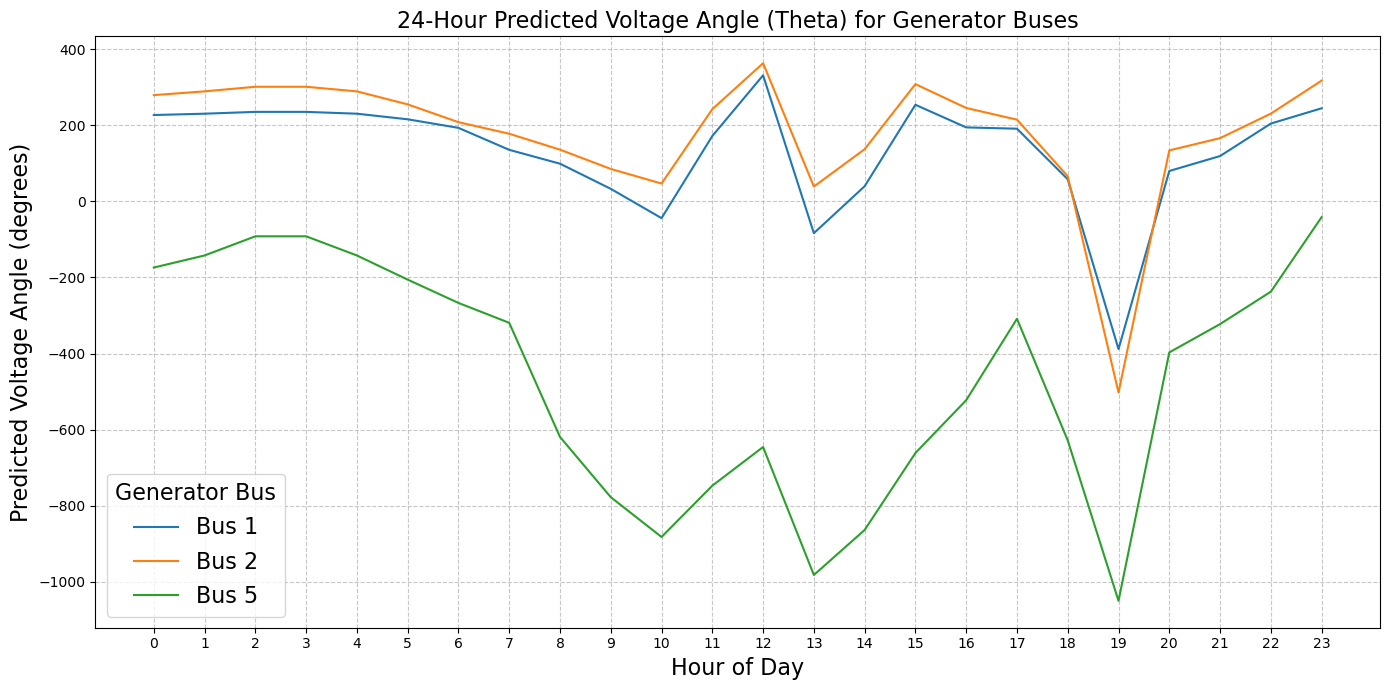

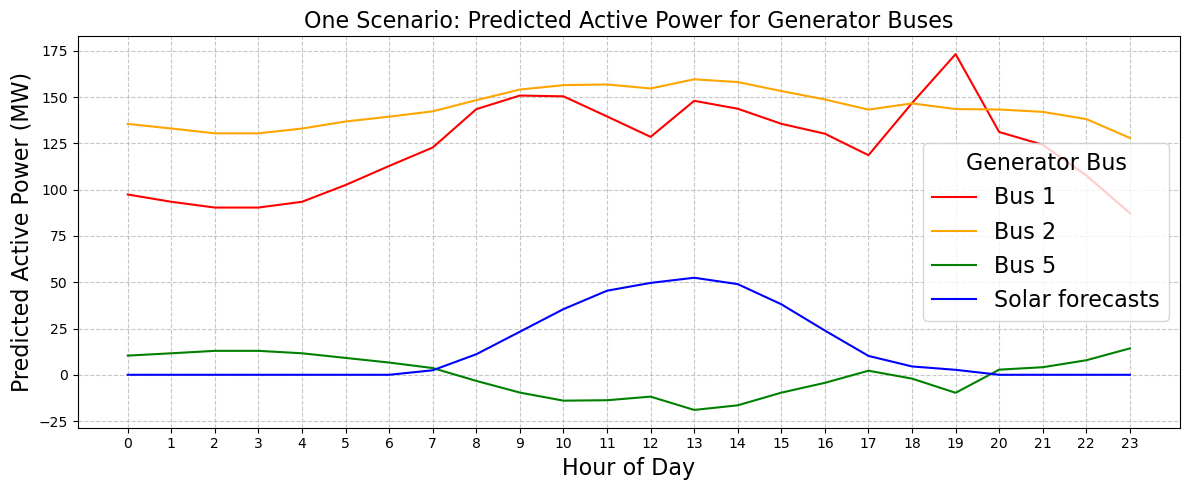

In [82]:
# --- Identify Generator Buses ---
generator_bus_indices = sorted([g['bus'] for g in ieee_6_generators_data]) # Get 0-indexed generator bus IDs

# --- Prepare data for plotting ---
hours = np.arange(24) # 0 to 23 hours

# Dictionaries to store predictions for each generator bus over 24 hours
gen_theta_predictions = {bus_idx: [] for bus_idx in generator_bus_indices}
gen_pg_predictions = {bus_idx: [] for bus_idx in generator_bus_indices}

for hour_data in all_hourly_results:
    for bus_idx in generator_bus_indices:
        gen_theta_predictions[bus_idx].append(hour_data['predicted_theta_deg'][bus_idx])
        gen_pg_predictions[bus_idx].append(hour_data['predicted_pg_mw'][bus_idx])

# --- Plotting Pred Theta (deg) [Mod] for each generator bus ---
plt.figure(figsize=(14, 7))
for bus_idx in generator_bus_indices:
    plt.plot(hours, gen_theta_predictions[bus_idx], label=f'Bus {bus_idx + 1}')

plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel('Predicted Voltage Angle (degrees)', fontsize=16)
plt.title('24-Hour Predicted Voltage Angle (Theta) for Generator Buses', fontsize=16)
plt.xticks(hours) # Ensure all 24 hours are shown as ticks
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Generator Bus', fontsize=16, title_fontsize=16)
plt.tight_layout()
plt.show()

# --- Plotting Pred Pg (MW) [Mod] for each generator bus ---
plt.figure(figsize=(12, 5))
idx = 0
for bus_idx in generator_bus_indices:
    plt.plot(hours, gen_pg_predictions[bus_idx], label=f'Bus {bus_idx + 1}', 
             color=["red", "orange", "green"][idx])
    idx += 1
plt.plot(hours, hourly_solar_forecasts_mw, label=f'Solar forecasts', color="blue")

plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel('Predicted Active Power (MW)', fontsize=16)
plt.title('One Scenario: Predicted Active Power for Generator Buses', fontsize=16)
plt.xticks(hours) # Ensure all 24 hours are shown as ticks
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Generator Bus', fontsize=16, title_fontsize=16)
plt.tight_layout()
plt.show()


# Apply trained GNNs to N-1

In [83]:
def create_single_pyg_data_object(current_buses_data_scenario, generators_data,
                                  contingent_branches_data, slack_bus_idx):
    """
    Converts a single scenario's data into a PyTorch Geometric Data object,
    including contingent edge_index and edge_attr.
    """
    node_features = np.zeros((num_buses, 9), dtype=np.float32)
    for bus_idx in range(num_buses):
        # Load demand (Pd): Get from the current scenario's input parameters
        # Use .get() with a default of 0.0 to handle cases where a bus might not have a load defined
        node_features[bus_idx, 0] = float(current_buses_data_scenario[bus_idx].get('Pd', 0.0))

        gen_details_map = {g['bus']: g for g in generators_data}
        gen_bus_0_indices = {g['bus'] for g in generators_data}

        if bus_idx in gen_bus_0_indices:
            gen_data = gen_details_map[bus_idx]
            node_features[bus_idx, 1] = gen_data['Pmin']
            node_features[bus_idx, 2] = gen_data['Pmax']
            node_features[bus_idx, 3] = gen_data['cost_a']
            node_features[bus_idx, 4] = gen_data['cost_b']
            node_features[bus_idx, 5] = gen_data['cost_c']

        node_features[bus_idx, 6] = 1.0 if bus_idx == slack_bus_idx else 0.0
        node_features[bus_idx, 7] = 1.0 if bus_idx in gen_bus_0_indices else 0.0
        # is_load_bus: Check against base data for its static load characteristic
        node_features[bus_idx, 8] = 1.0 if ieee_6_buses_data[bus_idx].get('Pd', 0) > 0 else 0.0

    x = torch.tensor(node_features, dtype=torch.float)

    # --- Contingent Edge Index and Edge Attributes ---
    contingent_edges_list = []
    contingent_edge_attr_list = []
    
    # Create a mapping for branch features for efficient lookup
    branch_features_map = {}
    for branch in contingent_branches_data:
        features = [branch['X_pu'], branch['limit_MW']]
        branch_features_map[(branch['from_bus'], branch['to_bus'])] = features
        branch_features_map[(branch['to_bus'], branch['from_bus'])] = features # For undirected graph

    # Build edge_index and edge_attr based on the contingent branches
    for branch in contingent_branches_data:
        contingent_edges_list.append([branch['from_bus'], branch['to_bus']])
        contingent_edges_list.append([branch['to_bus'], branch['from_bus']])
        
        # Add corresponding edge attributes
        features = branch_features_map[(branch['from_bus'], branch['to_bus'])]
        contingent_edge_attr_list.append(features)
        contingent_edge_attr_list.append(features) # For reverse edge

    # Handle case where all branches are removed (empty graph)
    if not contingent_edges_list:
        contingent_edge_index = torch.empty((2, 0), dtype=torch.long)
        contingent_edge_attr = torch.empty((0, 2), dtype=torch.float) # Assuming 2 edge features
    else:
        contingent_edge_index = torch.tensor(contingent_edges_list, dtype=torch.long).t().contiguous()
        contingent_edge_attr = torch.tensor(contingent_edge_attr_list, dtype=torch.float)

    # Scale the node features and edge attributes
    x_scaled = torch.tensor(x_scaler.transform(x.cpu().numpy()), dtype=torch.float)
    edge_attr_scaled = torch.tensor(edge_attr_scaler.transform(contingent_edge_attr.cpu().numpy()), dtype=torch.float)

    data = Data(x=x_scaled, edge_index=contingent_edge_index, edge_attr=edge_attr_scaled)
    return data

# --- N-1 Contingency Simulation ---
def simulate_n_1_contingencies(num_scenarios, buses_base_data, generators_data, branches_data_base, slack_bus_idx,
                               model, x_scaler, y_scaler, edge_attr_scaler, device):
    """
    Simulates N-1 contingencies under random load scenarios and compares GNN predictions
    against DC OPF true values.
    """
    print(f"\n--- Starting N-1 Contingency Simulation for {num_scenarios} Scenarios ---")

    min_bus_load_scale = 0.0 # Adjust load scaling for contingencies if needed
    max_bus_load_scale = 1.8

    all_comparison_results = [] # Stores summary of GNN vs OPF for each scenario
    detailed_scenario_data = [] # Stores full data for each scenario (first few)
    
    # NEW: Dictionaries to store all true and predicted Pg values per generator bus
    all_true_pg_per_gen = {g['bus']: [] for g in generators_data}
    all_pred_pg_per_gen = {g['bus']: [] for g in generators_data}

    num_branches = len(branches_data_base)
    if num_branches == 0:
        print("Error: No branches defined for N-1 simulation. Cannot perform N-1.")
        return [], []

    # Pre-process generator data for efficient lookup for constraint calculation
    generator_bus_set = {g['bus'] for g in generators_data}

    for i in tqdm(range(num_scenarios), desc="Simulating N-1 Contingencies"):
        current_buses_data_scenario = copy.deepcopy(buses_base_data)
        
        # 1. Generate Random Load Profile for this scenario
        for bus_idx in current_buses_data_scenario:
            if current_buses_data_scenario[bus_idx]['Pd'] > 0: # Only scale load buses
                individual_scale_factor = random.uniform(min_bus_load_scale, max_bus_load_scale)
                current_buses_data_scenario[bus_idx]['Pd'] *= individual_scale_factor

        # 2. Select a Random N-1 Contingency (remove one branch)
        # Ensure there's at least one branch to remove
        if num_branches > 0:
            contingency_branch_idx = random.randint(0, num_branches - 1)
            contingency_branch_info = branches_data_base[contingency_branch_idx]
            
            contingent_branches_data = [
                branch for idx, branch in enumerate(branches_data_base)
                if idx != contingency_branch_idx
            ]
        else:
            # No branches to remove, run base case
            contingency_branch_idx = -1 # Indicate no branch removed
            contingency_branch_info = {'from_bus': -1, 'to_bus': -1, 'X_pu': 0, 'limit_MW': 0} # Dummy info
            contingent_branches_data = branches_data_base # Use all branches

        # 3. Run DC OPF for the Contingent Scenario
        opf_results = solve_dc_opf(current_buses_data_scenario, 
                                   generators_data, 
                                   contingent_branches_data, 
                                   slack_bus_idx)

        if opf_results['status'] in ["optimal", "optimal_near", "feasible"]:
            
            # 4. Create PyG Data Object for GNN Inference
            pyg_data_input = create_single_pyg_data_object(
                current_buses_data_scenario, generators_data,
                contingent_branches_data, slack_bus_idx
            )
            pyg_data_input = pyg_data_input.to(device)
            
            # --- Load and Prepare Dataset ---
            output_json_filename = "feasible_opf_results_per_bus_scale_n1.json"
            dataset = create_pyg_data_objects(output_json_filename, 
                                              ieee_6_buses_data, 
                                              ieee_6_generators_data, 
                                              ieee_6_branches_data_base,
                                              edge_index, 
                                              SLACK_BUS_IDX)

            # 5. Run GNN Inference
            model.eval()
            with torch.no_grad():
                predicted_output_scaled = model(pyg_data_input)
            
            # 6. Inverse Transform GNN Predictions
            predicted_output_unscaled = y_scaler.inverse_transform(predicted_output_scaled.cpu().numpy())
            predicted_theta = predicted_output_unscaled[:, 0]
            predicted_pg = predicted_output_unscaled[:, 1]

            # 7. Extract and Post-process True Values from OPF Results
            true_theta_opf = np.array([opf_results['theta'].get(b_idx + 1, 0.0) for b_idx in range(num_buses)])
            true_pg_opf_raw = np.array([opf_results['pg'].get(b_idx + 1, 0.0) for b_idx in range(num_buses)])

            # Post-process true Pg for non-generator buses to be exactly 0
            true_pg_opf = np.copy(true_pg_opf_raw)
            for b_idx in range(num_buses):
                if b_idx not in generator_bus_set:
                    true_pg_opf[b_idx] = 0.0
                    
            # Collect Pg values for plotting distributions
            for g_bus_idx in generator_bus_set:
                all_true_pg_per_gen[g_bus_idx].append(true_pg_opf[g_bus_idx])
                all_pred_pg_per_gen[g_bus_idx].append(predicted_pg[g_bus_idx])

            # 8. Compare and Store Results
            # Calculate errors for generator buses only for Pg
            pg_mae = 0.0
            pg_mse = 0.0
            theta_mae = 0.0
            theta_mse = 0.0
            
            gen_count = 0
            for b_idx in generator_bus_set:
                pg_mae += abs(predicted_pg[b_idx] - true_pg_opf[b_idx])
                pg_mse += (predicted_pg[b_idx] - true_pg_opf[b_idx])**2
                gen_count += 1
            
            if gen_count > 0:
                pg_mae /= gen_count
                pg_mse /= gen_count
            else: # Handle case with no generators, though unlikely for power systems
                pg_mae = np.nan
                pg_mse = np.nan

            # For Theta, compare all buses
            theta_mae = np.mean(np.abs(predicted_theta - true_theta_opf))
            theta_mse = np.mean((predicted_theta - true_theta_opf)**2)

            all_comparison_results.append({
                'scenario_id': i + 1,
                'contingency_branch': f"{contingency_branch_info['from_bus']+1}-{contingency_branch_info['to_bus']+1}",
                'opf_status': opf_results['status'],
                'pg_mae_gen_buses': pg_mae,
                'pg_mse_gen_buses': pg_mse,
                'theta_mae_all_buses': theta_mae,
                'theta_mse_all_buses': theta_mse,
            })

            # Store detailed data for a few scenarios for deeper inspection
            if len(detailed_scenario_data) < 5: # Store only the first 5 detailed scenarios
                print(true_pg_opf)
                detailed_scenario_data.append({
                    'scenario_id': i + 1,
                    'contingency_branch_info': contingency_branch_info,
                    'input_bus_loads_MW': {str(k+1): v['Pd'] for k, v in current_buses_data_scenario.items()},
                    'opf_true_pg_MW': {str(b_idx+1): true_pg_opf[b_idx] for b_idx in range(num_buses)},
                    'opf_true_theta_deg': {str(b_idx+1): true_theta_opf[b_idx] for b_idx in range(num_buses)},
                    'gnn_pred_pg_MW': {str(b_idx+1): predicted_pg[b_idx] for b_idx in range(num_buses)},
                    'gnn_pred_theta_deg': {str(b_idx+1): predicted_theta[b_idx] for b_idx in range(num_buses)},
                })

    print("\n--- N-1 Contingency Simulation Complete ---")
    return all_comparison_results, detailed_scenario_data, all_true_pg_per_gen, all_pred_pg_per_gen


In [84]:
# --- Main Execution for N-1 Simulation ---
num_n_1_scenarios = 10000

comparison_results, detailed_results, all_true_pg_per_gen_buses, all_pred_pg_per_gen_buses = simulate_n_1_contingencies(
    num_n_1_scenarios,
    ieee_6_buses_data,
    ieee_6_generators_data,
    ieee_6_branches_data_base,
    SLACK_BUS_IDX,
    model, # the trained GNN model
    x_scaler, # the fitted x_scaler
    y_scaler, # the fitted y_scaler
    edge_attr_scaler, # the fitted edge_attr_scaler
    device # 'cuda' or 'cpu'
)

print(f"\nTotal feasible N-1 scenarios processed: {len(comparison_results)}")

# --- Summarize Comparison Results ---
if comparison_results:
    all_pg_maes = [res['pg_mae_gen_buses'] for res in comparison_results if not np.isnan(res['pg_mae_gen_buses'])]
    all_pg_mses = [res['pg_mse_gen_buses'] for res in comparison_results if not np.isnan(res['pg_mse_gen_buses'])]
    all_theta_maes = [res['theta_mae_all_buses'] for res in comparison_results]
    all_theta_mses = [res['theta_mse_all_buses'] for res in comparison_results]

    print("\n--- GNN Prediction Accuracy under N-1 Contingencies ---")
    print(f"Average Pg MAE (Generator Buses): {np.mean(all_pg_maes):.4f} MW")
    print(f"Average Pg MSE (Generator Buses): {np.mean(all_pg_mses):.4f} MW^2")
    print(f"Average Theta MAE (All Buses): {np.mean(all_theta_maes):.4f} degrees")
    print(f"Average Theta MSE (All Buses): {np.mean(all_theta_mses):.4f} degrees^2")

    print("\n--- Detailed Results for First 5 Feasible Scenarios ---")
    for scenario in detailed_results:
        print(f"\nScenario ID: {scenario['scenario_id']}, Contingency: {scenario['contingency_branch_info']['from_bus']+1}-{scenario['contingency_branch_info']['to_bus']+1}")
        print("  Input Loads (MW):", scenario['input_bus_loads_MW'])
        print("  True Pg (MW):", {k: f"{v:.2f}" for k, v in scenario['opf_true_pg_MW'].items()})
        print("  Pred Pg (MW):", {k: f"{v:.2f}" for k, v in scenario['gnn_pred_pg_MW'].items()})
        print("  True Theta (deg):", {k: f"{v:.2f}" for k, v in scenario['opf_true_theta_deg'].items()})
        print("  Pred Theta (deg):", {k: f"{v:.2f}" for k, v in scenario['gnn_pred_theta_deg'].items()})
else:
    print("No feasible scenarios found for comparison.")



--- Starting N-1 Contingency Simulation for 10000 Scenarios ---


Simulating N-1 Contingencies:   0%|                   | 0/10000 [00:00<?, ?it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  31%|▎| 3797/12392 [00:00<00:00, 37942
Converting scenarios to PyG Data objects:  61%|▌| 7592/12392 [00:00<00:00, 18819
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2603
Simulating N-1 Contingencies:   0%|           | 6/10000 [00:00<15:55, 10.46it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


[ 65.37507464 149.46241872   0.           0.          10.00000115
   0.        ]
Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4126/12392 [00:00<00:00, 41254
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4550
Simulating N-1 Contingencies:   0%|          | 14/10000 [00:00<10:48, 15.40it/s]

[ 44.07410672 100.73695186   0.           0.          10.00000001
   0.        ]
Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4649/12392 [00:00<00:00, 46481
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3134
Simulating N-1 Contingencies:   0%|          | 17/10000 [00:01<14:27, 11.51it/s]

[42.04687521 96.0497901   0.          0.         10.00000014  0.        ]
Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4787/12392 [00:00<00:00, 47860
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4804
Simulating N-1 Contingencies:   0%|          | 19/10000 [00:01<16:30, 10.08it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


[37.27886271 85.23819956  0.          0.         10.00000005  0.        ]
Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4734/12392 [00:00<00:00, 47335
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3210
Simulating N-1 Contingencies:   0%|          | 27/10000 [00:02<13:15, 12.53it/s]

[124.56432196  75.43567764   0.           0.          88.63338698
   0.        ]
Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4709/12392 [00:00<00:00, 47079
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:   0%|          | 29/10000 [00:02<15:04, 11.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47582
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3241
Simulating N-1 Contingencies:   0%|          | 31/10000 [00:02<18:45,  8.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4689/12392 [00:00<00:00, 46881
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4767
Simulating N-1 Contingencies:   0%|          | 34/10000 [00:03<18:20,  9.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4674/12392 [00:00<00:00, 46732
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2981
Simulating N-1 Contingencies:   0%|          | 38/10000 [00:03<18:54,  8.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4913/12392 [00:00<00:00, 49117
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4936
Simulating N-1 Contingencies:   0%|          | 39/10000 [00:03<21:54,  7.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4731/12392 [00:00<00:00, 47301
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3206
Simulating N-1 Contingencies:   0%|          | 41/10000 [00:04<25:06,  6.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4750/12392 [00:00<00:00, 47490
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4815
Simulating N-1 Contingencies:   0%|          | 42/10000 [00:04<28:19,  5.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4696/12392 [00:00<00:00, 46955
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4761
Simulating N-1 Contingencies:   0%|          | 43/10000 [00:04<31:39,  5.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3396/12392 [00:00<00:00, 17689
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3289
Simulating N-1 Contingencies:   0%|          | 46/10000 [00:05<28:13,  5.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4655/12392 [00:00<00:00, 46542
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4802
Simulating N-1 Contingencies:   0%|          | 47/10000 [00:05<31:24,  5.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4094/12392 [00:00<00:00, 19883
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3325
Simulating N-1 Contingencies:   0%|          | 49/10000 [00:06<32:12,  5.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  41%|▍| 5039/12392 [00:00<00:00, 50381
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5058
Simulating N-1 Contingencies:   1%|          | 60/10000 [00:06<10:58, 15.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  28%|▎| 3485/12392 [00:00<00:00, 16976
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3178


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4748/12392 [00:00<00:00, 47477
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4828
Simulating N-1 Contingencies:   1%|          | 70/10000 [00:07<10:58, 15.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2613/12392 [00:00<00:00, 13664
Converting scenarios to PyG Data objects:  58%|▌| 7229/12392 [00:00<00:00, 27557
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3101
Simulating N-1 Contingencies:   1%|          | 77/10000 [00:07<11:22, 14.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4757/12392 [00:00<00:00, 47566
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4885
Simulating N-1 Contingencies:   1%|          | 85/10000 [00:08<09:50, 16.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2615/12392 [00:00<00:00, 14525
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3285
Simulating N-1 Contingencies:   1%|          | 88/10000 [00:08<12:11, 13.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4708/12392 [00:00<00:00, 47070
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4884
Simulating N-1 Contingencies:   1%|          | 94/10000 [00:08<11:13, 14.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2787/12392 [00:00<00:00, 14684
Converting scenarios to PyG Data objects:  60%|▌| 7387/12392 [00:00<00:00, 28131
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3104
Simulating N-1 Contingencies:   1%|          | 97/10000 [00:09<13:46, 11.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4615/12392 [00:00<00:00, 46142
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4857
Simulating N-1 Contingencies:   1%|         | 101/10000 [00:09<13:33, 12.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3746/12392 [00:00<00:00, 18322
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3269
Simulating N-1 Contingencies:   1%|         | 103/10000 [00:10<16:52,  9.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48754
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4959
Simulating N-1 Contingencies:   1%|         | 109/10000 [00:10<13:45, 11.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3920/12392 [00:00<00:00, 17808
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3164
Simulating N-1 Contingencies:   1%|         | 112/10000 [00:10<16:05, 10.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4927/12392 [00:00<00:00, 49266
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4952


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5001/12392 [00:00<00:00, 50003
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3328
Simulating N-1 Contingencies:   1%|         | 114/10000 [00:11<22:59,  7.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  41%|▍| 5050/12392 [00:00<00:00, 50495
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5056
Simulating N-1 Contingencies:   1%|         | 118/10000 [00:11<19:28,  8.45it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  41%|▍| 5031/12392 [00:00<00:00, 50308
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3335
Simulating N-1 Contingencies:   1%|         | 120/10000 [00:12<22:12,  7.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47650
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4839
Simulating N-1 Contingencies:   1%|         | 121/10000 [00:12<25:07,  6.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4965/12392 [00:00<00:00, 49643
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3110
Simulating N-1 Contingencies:   1%|         | 123/10000 [00:13<27:52,  5.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4578/12392 [00:00<00:00, 45778
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4810
Simulating N-1 Contingencies:   1%|         | 124/10000 [00:13<30:44,  5.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5002/12392 [00:00<00:00, 50016
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3192
Simulating N-1 Contingencies:   1%|         | 128/10000 [00:13<24:59,  6.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4612/12392 [00:00<00:00, 46114
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4693
Simulating N-1 Contingencies:   1%|         | 131/10000 [00:14<22:26,  7.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4929/12392 [00:00<00:00, 49283
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5008
Simulating N-1 Contingencies:   1%|▏        | 145/10000 [00:14<09:57, 16.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4941/12392 [00:00<00:00, 49407
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4988


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  41%|▍| 5037/12392 [00:00<00:00, 50358
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5057
Simulating N-1 Contingencies:   1%|▏        | 148/10000 [00:15<14:56, 10.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4713/12392 [00:00<00:00, 47128
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4889/12392 [00:00<00:00, 48884
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4985
Simulating N-1 Contingencies:   2%|▏        | 151/10000 [00:15<20:57,  7.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4803/12392 [00:00<00:00, 48022
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4965
Simulating N-1 Contingencies:   2%|▏        | 153/10000 [00:16<23:26,  7.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4932/12392 [00:00<00:00, 49313
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3279
Simulating N-1 Contingencies:   2%|▏        | 160/10000 [00:16<17:18,  9.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4994/12392 [00:00<00:00, 49937
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4998
Simulating N-1 Contingencies:   2%|▏        | 162/10000 [00:17<18:20,  8.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4799/12392 [00:00<00:00, 47978
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4846
Simulating N-1 Contingencies:   2%|▏        | 164/10000 [00:17<19:25,  8.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1308/12392 [00:00<00:01, 8835.
Converting scenarios to PyG Data objects:  50%|▌| 6214/12392 [00:00<00:00, 28588
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3334
Simulating N-1 Contingencies:   2%|▏        | 171/10000 [00:17<15:13, 10.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4970/12392 [00:00<00:00, 49697
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5009
Simulating N-1 Contingencies:   2%|▏        | 174/10000 [00:18<15:25, 10.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2267/12392 [00:00<00:00, 12693
Converting scenarios to PyG Data objects:  57%|▌| 7110/12392 [00:00<00:00, 28574
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3197
Simulating N-1 Contingencies:   2%|▏        | 177/10000 [00:18<17:30,  9.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4808/12392 [00:00<00:00, 48073
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4931
Simulating N-1 Contingencies:   2%|▏        | 180/10000 [00:18<17:13,  9.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2789/12392 [00:00<00:00, 14626
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3224
Simulating N-1 Contingencies:   2%|▏        | 182/10000 [00:19<20:40,  7.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4992/12392 [00:00<00:00, 49910
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5046
Simulating N-1 Contingencies:   2%|▏        | 186/10000 [00:19<17:41,  9.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3224/12392 [00:00<00:00, 16755
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3294
Simulating N-1 Contingencies:   2%|▏        | 194/10000 [00:20<13:41, 11.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5009/12392 [00:00<00:00, 50084
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5029
Simulating N-1 Contingencies:   2%|▏        | 196/10000 [00:20<15:09, 10.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4181/12392 [00:00<00:00, 19718
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3300
Simulating N-1 Contingencies:   2%|▏        | 200/10000 [00:20<15:56, 10.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4986/12392 [00:00<00:00, 49857
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4853
Simulating N-1 Contingencies:   2%|▏        | 204/10000 [00:21<15:02, 10.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4750/12392 [00:00<00:00, 47498
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3157
Simulating N-1 Contingencies:   2%|▏        | 206/10000 [00:21<18:37,  8.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4711/12392 [00:00<00:00, 47108
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4790
Simulating N-1 Contingencies:   2%|▏        | 207/10000 [00:21<21:46,  7.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4748/12392 [00:00<00:00, 47472
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3084
Simulating N-1 Contingencies:   2%|▏        | 210/10000 [00:22<22:44,  7.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4741/12392 [00:00<00:00, 47407
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4837
Simulating N-1 Contingencies:   2%|▏        | 212/10000 [00:22<23:04,  7.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4827/12392 [00:00<00:00, 48267
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3172
Simulating N-1 Contingencies:   2%|▏        | 213/10000 [00:22<29:31,  5.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4904/12392 [00:00<00:00, 49034
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5001
Simulating N-1 Contingencies:   2%|▏        | 214/10000 [00:23<32:06,  5.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4860/12392 [00:00<00:00, 48592
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3277
Simulating N-1 Contingencies:   2%|▏        | 221/10000 [00:23<18:46,  8.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4998/12392 [00:00<00:00, 49975
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5020
Simulating N-1 Contingencies:   2%|▏        | 224/10000 [00:23<18:02,  9.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4977/12392 [00:00<00:00, 49767
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5023
Simulating N-1 Contingencies:   2%|▏        | 227/10000 [00:24<17:27,  9.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47871
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4903
Simulating N-1 Contingencies:   2%|▏        | 230/10000 [00:24<19:07,  8.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4980/12392 [00:00<00:00, 49791
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5002
Simulating N-1 Contingencies:   2%|▏        | 234/10000 [00:25<18:24,  8.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4560/12392 [00:00<00:00, 45598
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4671
Simulating N-1 Contingencies:   2%|▏        | 243/10000 [00:25<11:31, 14.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4890/12392 [00:00<00:00, 48894
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3224
Simulating N-1 Contingencies:   2%|▏        | 246/10000 [00:25<14:13, 11.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  41%|▍| 5080/12392 [00:00<00:00, 50796
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5078
Simulating N-1 Contingencies:   2%|▏        | 248/10000 [00:26<15:42, 10.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4953/12392 [00:00<00:00, 49528
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5034
Simulating N-1 Contingencies:   3%|▏        | 253/10000 [00:26<13:39, 11.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1308/12392 [00:00<00:01, 8740.
Converting scenarios to PyG Data objects:  51%|▌| 6377/12392 [00:00<00:00, 29226
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3362
Simulating N-1 Contingencies:   3%|▏        | 257/10000 [00:27<14:47, 10.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4989/12392 [00:00<00:00, 49882
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5051
Simulating N-1 Contingencies:   3%|▏        | 259/10000 [00:27<16:13, 10.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2006/12392 [00:00<00:00, 12312
Converting scenarios to PyG Data objects:  56%|▌| 6990/12392 [00:00<00:00, 29842
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3344
Simulating N-1 Contingencies:   3%|▏        | 260/10000 [00:27<21:38,  7.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4969/12392 [00:00<00:00, 49683
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5018
Simulating N-1 Contingencies:   3%|▏        | 263/10000 [00:27<19:46,  8.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2178/12392 [00:00<00:00, 13059
Converting scenarios to PyG Data objects:  58%|▌| 7175/12392 [00:00<00:00, 30088
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3342
Simulating N-1 Contingencies:   3%|▏        | 269/10000 [00:28<16:08, 10.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5007/12392 [00:00<00:00, 50069
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5055
Simulating N-1 Contingencies:   3%|▏        | 272/10000 [00:28<16:03, 10.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3311/12392 [00:00<00:00, 17582
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3347
Simulating N-1 Contingencies:   3%|▏        | 273/10000 [00:29<21:16,  7.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4711/12392 [00:00<00:00, 47109
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4815
Simulating N-1 Contingencies:   3%|▏        | 277/10000 [00:29<18:02,  8.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3224/12392 [00:00<00:00, 16896
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3327
Simulating N-1 Contingencies:   3%|▎        | 279/10000 [00:29<21:17,  7.61it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  41%|▍| 5049/12392 [00:00<00:00, 50487
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5086
Simulating N-1 Contingencies:   3%|▎        | 281/10000 [00:30<21:36,  7.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 4007/12392 [00:00<00:00, 19704
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3364
Simulating N-1 Contingencies:   3%|▎        | 287/10000 [00:30<16:52,  9.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4664/12392 [00:00<00:00, 46630
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4735
Simulating N-1 Contingencies:   3%|▎        | 288/10000 [00:30<20:00,  8.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4697/12392 [00:00<00:00, 46951
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3154
Simulating N-1 Contingencies:   3%|▎        | 289/10000 [00:31<26:21,  6.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4306/12392 [00:00<00:00, 43049
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4620
Simulating N-1 Contingencies:   3%|▎        | 291/10000 [00:31<25:56,  6.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4847/12392 [00:00<00:00, 48461
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3261
Simulating N-1 Contingencies:   3%|▎        | 294/10000 [00:32<24:58,  6.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4994/12392 [00:00<00:00, 49933
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4987
Simulating N-1 Contingencies:   3%|▎        | 299/10000 [00:32<18:06,  8.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48667
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3253
Simulating N-1 Contingencies:   3%|▎        | 303/10000 [00:32<18:01,  8.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4817/12392 [00:00<00:00, 48163
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4775
Simulating N-1 Contingencies:   3%|▎        | 306/10000 [00:33<17:37,  9.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4806/12392 [00:00<00:00, 48050
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3241
Simulating N-1 Contingencies:   3%|▎        | 308/10000 [00:33<20:59,  7.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4995/12392 [00:00<00:00, 49943
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4976
Simulating N-1 Contingencies:   3%|▎        | 310/10000 [00:33<21:27,  7.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5009/12392 [00:00<00:00, 50087
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5021
Simulating N-1 Contingencies:   3%|▎        | 311/10000 [00:34<24:35,  6.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  10%| | 1221/12392 [00:00<00:01, 8260.
Converting scenarios to PyG Data objects:  51%|▌| 6271/12392 [00:00<00:00, 29018
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3349
Simulating N-1 Contingencies:   3%|▎        | 316/10000 [00:34<19:24,  8.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4948/12392 [00:00<00:00, 49473
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4987
Simulating N-1 Contingencies:   3%|▎        | 323/10000 [00:34<13:40, 11.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   5%| | 612/12392 [00:00<00:02, 4385.5
Converting scenarios to PyG Data objects:  43%|▍| 5377/12392 [00:00<00:00, 26269
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3250
Simulating N-1 Contingencies:   3%|▎        | 328/10000 [00:35<13:59, 11.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4868/12392 [00:00<00:00, 48672
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4918
Simulating N-1 Contingencies:   3%|▎        | 335/10000 [00:35<12:09, 13.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4748/12392 [00:00<00:00, 47476
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4773
Simulating N-1 Contingencies:   3%|▎        | 339/10000 [00:36<12:24, 12.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4956/12392 [00:00<00:00, 49556
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4957
Simulating N-1 Contingencies:   3%|▎        | 343/10000 [00:36<13:47, 11.66it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4857/12392 [00:00<00:00, 48565
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4935
Simulating N-1 Contingencies:   3%|▎        | 348/10000 [00:36<12:23, 12.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4979/12392 [00:00<00:00, 49784
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3260
Simulating N-1 Contingencies:   4%|▎        | 356/10000 [00:37<11:07, 14.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4998/12392 [00:00<00:00, 49978
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4994
Simulating N-1 Contingencies:   4%|▎        | 363/10000 [00:37<09:53, 16.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4898/12392 [00:00<00:00, 48972
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4938
Simulating N-1 Contingencies:   4%|▎        | 375/10000 [00:38<08:20, 19.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4930/12392 [00:00<00:00, 49297
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4932
Simulating N-1 Contingencies:   4%|▎        | 383/10000 [00:38<07:53, 20.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4930/12392 [00:00<00:00, 49298
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3266
Simulating N-1 Contingencies:   4%|▎        | 388/10000 [00:39<09:32, 16.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4934/12392 [00:00<00:00, 49337
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4934
Simulating N-1 Contingencies:   4%|▎        | 391/10000 [00:39<10:40, 15.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4925/12392 [00:00<00:00, 49246
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4933
Simulating N-1 Contingencies:   4%|▎        | 393/10000 [00:39<12:27, 12.85it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  19%|▏| 2352/12392 [00:00<00:00, 13794
Converting scenarios to PyG Data objects:  59%|▌| 7306/12392 [00:00<00:00, 30090
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3314
Simulating N-1 Contingencies:   4%|▎        | 398/10000 [00:40<13:05, 12.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4881/12392 [00:00<00:00, 48806
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4923
Simulating N-1 Contingencies:   4%|▎        | 400/10000 [00:40<14:43, 10.87it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1919/12392 [00:00<00:00, 11817
Converting scenarios to PyG Data objects:  56%|▌| 6895/12392 [00:00<00:00, 29573
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3310
Simulating N-1 Contingencies:   4%|▎        | 408/10000 [00:40<12:16, 13.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4987/12392 [00:00<00:00, 49867
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4964


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3224/12392 [00:00<00:00, 16535
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3204
Simulating N-1 Contingencies:   4%|▎        | 410/10000 [00:41<18:30,  8.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4762/12392 [00:00<00:00, 47610
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4856
Simulating N-1 Contingencies:   4%|▎        | 416/10000 [00:41<14:51, 10.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3050/12392 [00:00<00:00, 15619
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3208
Simulating N-1 Contingencies:   4%|▍        | 423/10000 [00:42<13:20, 11.97it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4697/12392 [00:00<00:00, 46960
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4776
Simulating N-1 Contingencies:   4%|▍        | 428/10000 [00:42<12:33, 12.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 4007/12392 [00:00<00:00, 18987
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3236
Simulating N-1 Contingencies:   4%|▍        | 430/10000 [00:43<15:30, 10.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4823/12392 [00:00<00:00, 48227
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4899
Simulating N-1 Contingencies:   4%|▍        | 439/10000 [00:43<11:16, 14.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 4007/12392 [00:00<00:00, 19224
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3279
Simulating N-1 Contingencies:   4%|▍        | 441/10000 [00:43<14:06, 11.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4913/12392 [00:00<00:00, 49119
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4924
Simulating N-1 Contingencies:   4%|▍        | 446/10000 [00:44<12:52, 12.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 21446
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3289
Simulating N-1 Contingencies:   4%|▍        | 448/10000 [00:44<15:58,  9.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4951/12392 [00:00<00:00, 49504
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4998


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4938/12392 [00:00<00:00, 49378
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3281
Simulating N-1 Contingencies:   4%|▍        | 450/10000 [00:45<22:43,  7.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4960/12392 [00:00<00:00, 49595
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5016
Simulating N-1 Contingencies:   5%|▍        | 451/10000 [00:45<25:03,  6.35it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4958/12392 [00:00<00:00, 49575
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3285
Simulating N-1 Contingencies:   5%|▍        | 459/10000 [00:46<16:19,  9.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4886/12392 [00:00<00:00, 48857
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4900
Simulating N-1 Contingencies:   5%|▍        | 463/10000 [00:46<15:12, 10.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4915/12392 [00:00<00:00, 49140
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2936
Simulating N-1 Contingencies:   5%|▍        | 468/10000 [00:46<15:25, 10.30it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:   5%|▍        | 477/10000 [00:47<09:07, 17.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4905/12392 [00:00<00:00, 49045
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4956


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4961/12392 [00:00<00:00, 49607
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3154
Simulating N-1 Contingencies:   5%|▍        | 481/10000 [00:47<13:31, 11.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4558/12392 [00:00<00:00, 45575
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4649
Simulating N-1 Contingencies:   5%|▍        | 484/10000 [00:48<14:08, 11.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4875/12392 [00:00<00:00, 48745
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4877
Simulating N-1 Contingencies:   5%|▍        | 488/10000 [00:48<13:40, 11.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 962/12392 [00:00<00:01, 6491.3
Converting scenarios to PyG Data objects:  46%|▍| 5684/12392 [00:00<00:00, 26480
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3196
Simulating N-1 Contingencies:   5%|▍        | 490/10000 [00:48<16:57,  9.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48764
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4904
Simulating N-1 Contingencies:   5%|▍        | 492/10000 [00:49<18:04,  8.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1049/12392 [00:00<00:01, 7018.
Converting scenarios to PyG Data objects:  47%|▍| 5857/12392 [00:00<00:00, 27084
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3218
Simulating N-1 Contingencies:   5%|▍        | 494/10000 [00:49<21:21,  7.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4825/12392 [00:00<00:00, 48242
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4858
Simulating N-1 Contingencies:   5%|▍        | 504/10000 [00:49<12:31, 12.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4856/12392 [00:00<00:00, 48555
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4873
Simulating N-1 Contingencies:   5%|▍        | 515/10000 [00:50<07:44, 20.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4860/12392 [00:00<00:00, 48591
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3251
Simulating N-1 Contingencies:   5%|▍        | 527/10000 [00:50<06:45, 23.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4950/12392 [00:00<00:00, 49496
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4967
Simulating N-1 Contingencies:   5%|▍        | 533/10000 [00:51<07:22, 21.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4913/12392 [00:00<00:00, 49121
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4962
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:   5%|▍        | 537/10000 [00:51<09:39, 16.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4831/12392 [00:00<00:00, 48304
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4851
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:   5%|▍        | 540/10000 [00:52<10:54, 14.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4894/12392 [00:00<00:00, 48929
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3206
Simulating N-1 Contingencies:   5%|▍        | 545/10000 [00:52<12:02, 13.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4806/12392 [00:00<00:00, 48056
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4906
Simulating N-1 Contingencies:   6%|▍        | 555/10000 [00:52<08:15, 19.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4870/12392 [00:00<00:00, 48691
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4898
Simulating N-1 Contingencies:   6%|▌        | 563/10000 [00:53<08:46, 17.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4876/12392 [00:00<00:00, 48624
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4859


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4953/12392 [00:00<00:00, 49519
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4967
Simulating N-1 Contingencies:   6%|▌        | 566/10000 [00:54<14:52, 10.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4897/12392 [00:00<00:00, 48963
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4922
Simulating N-1 Contingencies:   6%|▌        | 568/10000 [00:54<16:13,  9.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4892/12392 [00:00<00:00, 48919
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4942
Simulating N-1 Contingencies:   6%|▌        | 571/10000 [00:54<16:03,  9.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4916/12392 [00:00<00:00, 49152
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4900
Simulating N-1 Contingencies:   6%|▌        | 573/10000 [00:55<19:26,  8.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48729
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4854
Simulating N-1 Contingencies:   6%|▌        | 578/10000 [00:55<16:53,  9.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4846/12392 [00:00<00:00, 48455
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4890
Simulating N-1 Contingencies:   6%|▌        | 581/10000 [00:55<16:32,  9.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4881/12392 [00:00<00:00, 48807
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4950
Simulating N-1 Contingencies:   6%|▌        | 584/10000 [00:56<18:27,  8.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4886/12392 [00:00<00:00, 48851
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4918
Simulating N-1 Contingencies:   6%|▌        | 587/10000 [00:56<17:24,  9.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4880/12392 [00:00<00:00, 48797
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4930
Simulating N-1 Contingencies:   6%|▌        | 588/10000 [00:56<21:22,  7.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4860/12392 [00:00<00:00, 48597
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4893
Simulating N-1 Contingencies:   6%|▌        | 599/10000 [00:57<09:35, 16.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4965/12392 [00:00<00:00, 49629
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3269
Simulating N-1 Contingencies:   6%|▌        | 602/10000 [00:57<12:40, 12.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4719/12392 [00:00<00:00, 47183
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4816
Simulating N-1 Contingencies:   6%|▌        | 605/10000 [00:58<13:34, 11.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4883/12392 [00:00<00:00, 48820
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4913
Simulating N-1 Contingencies:   6%|▌        | 607/10000 [00:58<15:20, 10.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   5%| | 612/12392 [00:00<00:02, 4238.3
Converting scenarios to PyG Data objects:  44%|▍| 5474/12392 [00:00<00:00, 26309
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3207
Simulating N-1 Contingencies:   6%|▌        | 612/10000 [00:58<14:55, 10.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4886/12392 [00:00<00:00, 48857
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4903
Simulating N-1 Contingencies:   6%|▌        | 619/10000 [00:59<12:04, 12.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4817/12392 [00:00<00:00, 48161
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4785
Simulating N-1 Contingencies:   6%|▌        | 622/10000 [00:59<13:05, 11.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4731/12392 [00:00<00:00, 47305
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4856
Simulating N-1 Contingencies:   6%|▌        | 624/10000 [00:59<15:00, 10.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4804/12392 [00:00<00:00, 48030
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4894
Simulating N-1 Contingencies:   6%|▌        | 626/10000 [01:00<18:48,  8.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4754/12392 [00:00<00:00, 47531
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4872
Simulating N-1 Contingencies:   6%|▌        | 629/10000 [01:00<19:16,  8.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4704/12392 [00:00<00:00, 47038
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4849
Simulating N-1 Contingencies:   6%|▌        | 630/10000 [01:01<23:19,  6.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4840/12392 [00:00<00:00, 48396
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4864
Simulating N-1 Contingencies:   6%|▌        | 633/10000 [01:01<22:49,  6.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4918/12392 [00:00<00:00, 49170
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4912
Simulating N-1 Contingencies:   6%|▌        | 638/10000 [01:01<15:34, 10.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4872/12392 [00:00<00:00, 48710
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4891
Simulating N-1 Contingencies:   6%|▌        | 644/10000 [01:02<13:40, 11.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4902/12392 [00:00<00:00, 49012
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4950
Simulating N-1 Contingencies:   6%|▌        | 649/10000 [01:02<12:04, 12.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4886/12392 [00:00<00:00, 48856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4941
Simulating N-1 Contingencies:   7%|▌        | 651/10000 [01:02<14:07, 11.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4970/12392 [00:00<00:00, 49694
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4949
Simulating N-1 Contingencies:   7%|▌        | 653/10000 [01:03<18:04,  8.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4543/12392 [00:00<00:00, 45418
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4776
Simulating N-1 Contingencies:   7%|▌        | 659/10000 [01:03<13:36, 11.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48766
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4921
Simulating N-1 Contingencies:   7%|▌        | 661/10000 [01:04<17:07,  9.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4914/12392 [00:00<00:00, 49138
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4946
Simulating N-1 Contingencies:   7%|▌        | 665/10000 [01:04<17:10,  9.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4921/12392 [00:00<00:00, 49204
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4952
Simulating N-1 Contingencies:   7%|▌        | 667/10000 [01:04<18:28,  8.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4912/12392 [00:00<00:00, 49116
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3266
Simulating N-1 Contingencies:   7%|▌        | 673/10000 [01:05<15:04, 10.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4939/12392 [00:00<00:00, 49389
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4971
Simulating N-1 Contingencies:   7%|▌        | 675/10000 [01:05<16:30,  9.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4760/12392 [00:00<00:00, 47595
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4844
Simulating N-1 Contingencies:   7%|▌        | 676/10000 [01:05<19:54,  7.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2178/12392 [00:00<00:00, 12625
Converting scenarios to PyG Data objects:  57%|▌| 7079/12392 [00:00<00:00, 29106
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3251
Simulating N-1 Contingencies:   7%|▌        | 680/10000 [01:06<18:46,  8.27it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4892/12392 [00:00<00:00, 48914
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4859
Simulating N-1 Contingencies:   7%|▌        | 686/10000 [01:06<14:04, 11.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1569/12392 [00:00<00:01, 9173.
Converting scenarios to PyG Data objects:  49%|▍| 6100/12392 [00:00<00:00, 25619
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3078
Simulating N-1 Contingencies:   7%|▌        | 692/10000 [01:07<13:28, 11.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4767/12392 [00:00<00:00, 47666
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4888
Simulating N-1 Contingencies:   7%|▌        | 694/10000 [01:07<14:55, 10.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2700/12392 [00:00<00:00, 14247
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3203
Simulating N-1 Contingencies:   7%|▋        | 696/10000 [01:07<18:15,  8.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4870/12392 [00:00<00:00, 48697
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4947
Simulating N-1 Contingencies:   7%|▋        | 698/10000 [01:08<19:05,  8.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3657/12392 [00:00<00:00, 18399
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3296
Simulating N-1 Contingencies:   7%|▋        | 702/10000 [01:08<18:16,  8.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4896/12392 [00:00<00:00, 48953
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4929
Simulating N-1 Contingencies:   7%|▋        | 714/10000 [01:08<08:52, 17.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3310/12392 [00:00<00:00, 17271
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3309
Simulating N-1 Contingencies:   7%|▋        | 718/10000 [01:09<10:56, 14.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48759
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4929
Simulating N-1 Contingencies:   7%|▋        | 721/10000 [01:09<11:54, 12.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3311/12392 [00:00<00:00, 16704
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3243
Simulating N-1 Contingencies:   7%|▋        | 728/10000 [01:10<11:20, 13.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4748/12392 [00:00<00:00, 47470
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4759
Simulating N-1 Contingencies:   7%|▋        | 740/10000 [01:10<07:32, 20.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2528/12392 [00:00<00:00, 13767
Converting scenarios to PyG Data objects:  60%|▌| 7395/12392 [00:00<00:00, 29037
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3199


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4781/12392 [00:00<00:00, 47799
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4865
Simulating N-1 Contingencies:   7%|▋        | 744/10000 [01:11<12:11, 12.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2702/12392 [00:00<00:00, 14675
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3257
Simulating N-1 Contingencies:   8%|▋        | 751/10000 [01:11<11:36, 13.29it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:   8%|▋        | 760/10000 [01:11<07:41, 20.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47978
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4869


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2528/12392 [00:00<00:00, 14326
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3291
Simulating N-1 Contingencies:   8%|▋        | 765/10000 [01:12<11:08, 13.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4870/12392 [00:00<00:00, 48690
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4902


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3050/12392 [00:00<00:00, 16226
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3295
Simulating N-1 Contingencies:   8%|▋        | 769/10000 [01:13<14:33, 10.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4859/12392 [00:00<00:00, 48580
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4895
Simulating N-1 Contingencies:   8%|▋        | 772/10000 [01:13<14:43, 10.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4181/12392 [00:00<00:00, 19055
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3155
Simulating N-1 Contingencies:   8%|▋        | 774/10000 [01:13<17:31,  8.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4523/12392 [00:00<00:00, 45224
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4754
Simulating N-1 Contingencies:   8%|▋        | 789/10000 [01:14<08:29, 18.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3310/12392 [00:00<00:00, 16849
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3261
Simulating N-1 Contingencies:   8%|▋        | 794/10000 [01:14<09:55, 15.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4881/12392 [00:00<00:00, 48806
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4903


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4910/12392 [00:00<00:00, 49094
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3295
Simulating N-1 Contingencies:   8%|▋        | 797/10000 [01:15<14:37, 10.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4819/12392 [00:00<00:00, 48185
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4887
Simulating N-1 Contingencies:   8%|▋        | 800/10000 [01:15<14:47, 10.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4912/12392 [00:00<00:00, 49116
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3293


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4898/12392 [00:00<00:00, 48972
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4929
Simulating N-1 Contingencies:   8%|▋        | 802/10000 [01:16<20:56,  7.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4840/12392 [00:00<00:00, 48393
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3238
Simulating N-1 Contingencies:   8%|▋        | 808/10000 [01:17<17:10,  8.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4737/12392 [00:00<00:00, 47361
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4789


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4760/12392 [00:00<00:00, 47593
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3206
Simulating N-1 Contingencies:   8%|▋        | 810/10000 [01:17<23:08,  6.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4899/12392 [00:00<00:00, 48987
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4933
Simulating N-1 Contingencies:   8%|▋        | 812/10000 [01:18<22:56,  6.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4932/12392 [00:00<00:00, 49312
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4911
Simulating N-1 Contingencies:   8%|▋        | 817/10000 [01:18<18:08,  8.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4850/12392 [00:00<00:00, 48492
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4861
Simulating N-1 Contingencies:   8%|▋        | 823/10000 [01:18<13:38, 11.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4815/12392 [00:00<00:00, 48142
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3211
Simulating N-1 Contingencies:   8%|▋        | 827/10000 [01:19<14:42, 10.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4914/12392 [00:00<00:00, 49137
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4940
Simulating N-1 Contingencies:   8%|▋        | 831/10000 [01:19<13:50, 11.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48758
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4936
Simulating N-1 Contingencies:   8%|▊        | 835/10000 [01:19<13:14, 11.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1047/12392 [00:00<00:01, 6777.
Converting scenarios to PyG Data objects:  46%|▍| 5760/12392 [00:00<00:00, 26163
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3165
Simulating N-1 Contingencies:   8%|▊        | 839/10000 [01:20<14:28, 10.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4802/12392 [00:00<00:00, 48017
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4879
Simulating N-1 Contingencies:   8%|▊        | 841/10000 [01:20<15:51,  9.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1136/12392 [00:00<00:01, 7659.
Converting scenarios to PyG Data objects:  49%|▍| 6038/12392 [00:00<00:00, 27951
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3281
Simulating N-1 Contingencies:   8%|▊        | 843/10000 [01:21<19:03,  8.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4865/12392 [00:00<00:00, 48640
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4919
Simulating N-1 Contingencies:   8%|▊        | 847/10000 [01:21<16:27,  9.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   6%| | 699/12392 [00:00<00:02, 5063.2
Converting scenarios to PyG Data objects:  45%|▍| 5521/12392 [00:00<00:00, 27009
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3279
Simulating N-1 Contingencies:   9%|▊        | 853/10000 [01:21<14:24, 10.59it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4851/12392 [00:00<00:00, 48502
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4940
Simulating N-1 Contingencies:   9%|▊        | 861/10000 [01:22<10:57, 13.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   2%| | 264/12392 [00:00<00:06, 1997.8
Converting scenarios to PyG Data objects:  41%|▍| 5087/12392 [00:00<00:00, 26012
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3246
Simulating N-1 Contingencies:   9%|▊        | 863/10000 [01:22<13:53, 10.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4854/12392 [00:00<00:00, 48537
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4890
Simulating N-1 Contingencies:   9%|▊        | 868/10000 [01:22<12:34, 12.11it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4892/12392 [00:00<00:00, 48918
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4926
Simulating N-1 Contingencies:   9%|▊        | 870/10000 [01:23<15:33,  9.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4933/12392 [00:00<00:00, 49320
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4846
Simulating N-1 Contingencies:   9%|▊        | 874/10000 [01:23<14:28, 10.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   1%| | 89/12392 [00:00<00:17, 693.32i
Converting scenarios to PyG Data objects:  39%|▍| 4866/12392 [00:00<00:00, 25488
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3242
Simulating N-1 Contingencies:   9%|▊        | 884/10000 [01:24<09:37, 15.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4722/12392 [00:00<00:00, 47212
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3157
Simulating N-1 Contingencies:   9%|▊        | 887/10000 [01:24<12:22, 12.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4856/12392 [00:00<00:00, 48549
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4844
Simulating N-1 Contingencies:   9%|▊        | 893/10000 [01:24<10:56, 13.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4826/12392 [00:00<00:00, 48258
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4853
Simulating N-1 Contingencies:   9%|▊        | 898/10000 [01:25<10:38, 14.26it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:   9%|▊        | 904/10000 [01:25<08:40, 17.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4848/12392 [00:00<00:00, 48476
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4895
Simulating N-1 Contingencies:   9%|▊        | 907/10000 [01:25<09:58, 15.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4883/12392 [00:00<00:00, 48827
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3256
Simulating N-1 Contingencies:   9%|▊        | 915/10000 [01:26<09:39, 15.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4829/12392 [00:00<00:00, 48286
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4881
Simulating N-1 Contingencies:   9%|▊        | 920/10000 [01:26<09:43, 15.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4847/12392 [00:00<00:00, 48460
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4894
Simulating N-1 Contingencies:   9%|▊        | 927/10000 [01:26<08:56, 16.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1919/12392 [00:00<00:00, 11643
Converting scenarios to PyG Data objects:  55%|▌| 6835/12392 [00:00<00:00, 29060
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3272


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4922/12392 [00:00<00:00, 49210
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4937
Simulating N-1 Contingencies:   9%|▊        | 929/10000 [01:27<14:18, 10.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2874/12392 [00:00<00:00, 14471
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3137
Simulating N-1 Contingencies:   9%|▊        | 934/10000 [01:28<14:15, 10.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4728/12392 [00:00<00:00, 47278
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4807
Simulating N-1 Contingencies:   9%|▊        | 942/10000 [01:28<11:12, 13.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2874/12392 [00:00<00:00, 15601
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3283
Simulating N-1 Contingencies:   9%|▊        | 945/10000 [01:28<13:04, 11.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4889/12392 [00:00<00:00, 48882
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4929


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4181/12392 [00:00<00:00, 19391
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3220
Simulating N-1 Contingencies:   9%|▊        | 947/10000 [01:29<18:47,  8.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4831/12392 [00:00<00:00, 48304
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4788
Simulating N-1 Contingencies:   9%|▊        | 949/10000 [01:29<19:25,  7.77it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4355/12392 [00:00<00:00, 19538
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3213
Simulating N-1 Contingencies:  10%|▊        | 956/10000 [01:30<15:13,  9.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4931/12392 [00:00<00:00, 49308
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4941
Simulating N-1 Contingencies:  10%|▊        | 958/10000 [01:30<16:15,  9.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4884/12392 [00:00<00:00, 48835
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3221
Simulating N-1 Contingencies:  10%|▊        | 964/10000 [01:31<14:26, 10.43it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4848/12392 [00:00<00:00, 48476
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4926
Simulating N-1 Contingencies:  10%|▊        | 966/10000 [01:31<15:38,  9.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4614/12392 [00:00<00:00, 46136
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3135
Simulating N-1 Contingencies:  10%|▊        | 970/10000 [01:31<16:08,  9.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4850/12392 [00:00<00:00, 48493
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4913
Simulating N-1 Contingencies:  10%|▊        | 972/10000 [01:32<17:11,  8.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4918/12392 [00:00<00:00, 49100
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3038
Simulating N-1 Contingencies:  10%|▉        | 975/10000 [01:32<18:48,  8.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4688/12392 [00:00<00:00, 46874
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4767
Simulating N-1 Contingencies:  10%|▉        | 977/10000 [01:32<19:36,  7.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47887
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3189
Simulating N-1 Contingencies:  10%|▉        | 979/10000 [01:33<22:41,  6.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4671/12392 [00:00<00:00, 46704
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4763
Simulating N-1 Contingencies:  10%|▉        | 984/10000 [01:33<17:01,  8.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4765/12392 [00:00<00:00, 47646
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3162
Simulating N-1 Contingencies:  10%|▉        | 986/10000 [01:34<20:10,  7.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4862/12392 [00:00<00:00, 48618
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4864
Simulating N-1 Contingencies:  10%|▉        | 989/10000 [01:34<18:39,  8.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4806/12392 [00:00<00:00, 48053
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4860
Simulating N-1 Contingencies:  10%|▉        | 991/10000 [01:34<19:26,  7.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2963/12392 [00:00<00:00, 14786
Converting scenarios to PyG Data objects:  61%|▌| 7593/12392 [00:00<00:00, 27901
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3068
Simulating N-1 Contingencies:  10%|▉        | 992/10000 [01:35<25:41,  5.84it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  10%|▊       | 1001/10000 [01:35<10:24, 14.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4679/12392 [00:00<00:00, 46780
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4851
Simulating N-1 Contingencies:  10%|▊       | 1005/10000 [01:35<10:48, 13.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2004/12392 [00:00<00:00, 12038
Converting scenarios to PyG Data objects:  56%|▌| 6896/12392 [00:00<00:00, 29068
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3263
Simulating N-1 Contingencies:  10%|▊       | 1008/10000 [01:35<13:19, 11.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4881/12392 [00:00<00:00, 48807
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4825
Simulating N-1 Contingencies:  10%|▊       | 1012/10000 [01:36<12:53, 11.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2528/12392 [00:00<00:00, 13716
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3232
Simulating N-1 Contingencies:  10%|▊       | 1014/10000 [01:36<16:16,  9.20it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4835/12392 [00:00<00:00, 48341
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4886
Simulating N-1 Contingencies:  10%|▊       | 1017/10000 [01:37<15:57,  9.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2874/12392 [00:00<00:00, 15457
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3267
Simulating N-1 Contingencies:  10%|▊       | 1020/10000 [01:37<17:30,  8.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4796/12392 [00:00<00:00, 47951
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4854
Simulating N-1 Contingencies:  10%|▊       | 1022/10000 [01:37<18:26,  8.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4440/12392 [00:00<00:00, 20027
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3219
Simulating N-1 Contingencies:  10%|▊       | 1025/10000 [01:38<19:27,  7.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4821/12392 [00:00<00:00, 48205
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4878
Simulating N-1 Contingencies:  10%|▊       | 1029/10000 [01:38<16:34,  9.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4903/12392 [00:00<00:00, 49027
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3272
Simulating N-1 Contingencies:  10%|▊       | 1034/10000 [01:38<15:19,  9.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4867/12392 [00:00<00:00, 48660
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4916
Simulating N-1 Contingencies:  10%|▊       | 1040/10000 [01:39<12:30, 11.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4862/12392 [00:00<00:00, 48615
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3268
Simulating N-1 Contingencies:  10%|▊       | 1046/10000 [01:39<12:08, 12.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4881/12392 [00:00<00:00, 48804
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4911
Simulating N-1 Contingencies:  11%|▊       | 1053/10000 [01:40<10:20, 14.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4819/12392 [00:00<00:00, 48185
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3266
Simulating N-1 Contingencies:  11%|▊       | 1058/10000 [01:40<11:12, 13.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4829/12392 [00:00<00:00, 48280
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4897
Simulating N-1 Contingencies:  11%|▊       | 1060/10000 [01:40<12:38, 11.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4780/12392 [00:00<00:00, 47792
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3194
Simulating N-1 Contingencies:  11%|▊       | 1069/10000 [01:41<10:38, 13.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4807/12392 [00:00<00:00, 48063
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4860
Simulating N-1 Contingencies:  11%|▊       | 1071/10000 [01:41<12:05, 12.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4905/12392 [00:00<00:00, 49044
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3259
Simulating N-1 Contingencies:  11%|▊       | 1073/10000 [01:42<15:03,  9.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4675/12392 [00:00<00:00, 46745
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4785
Simulating N-1 Contingencies:  11%|▊       | 1075/10000 [01:42<16:21,  9.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4799/12392 [00:00<00:00, 47981
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3160
Simulating N-1 Contingencies:  11%|▊       | 1081/10000 [01:42<14:25, 10.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4734/12392 [00:00<00:00, 47329
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4820
Simulating N-1 Contingencies:  11%|▊       | 1082/10000 [01:43<17:01,  8.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4794/12392 [00:00<00:00, 47929
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4852
Simulating N-1 Contingencies:  11%|▊       | 1083/10000 [01:43<19:57,  7.44it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  11%|▊       | 1089/10000 [01:43<12:30, 11.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4615/12392 [00:00<00:00, 45959
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4667


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4719/12392 [00:00<00:00, 47179
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  11%|▊       | 1091/10000 [01:44<18:21,  8.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47658
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4878
Simulating N-1 Contingencies:  11%|▊       | 1093/10000 [01:44<21:04,  7.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4717/12392 [00:00<00:00, 47162
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4791
Simulating N-1 Contingencies:  11%|▉       | 1096/10000 [01:45<21:06,  7.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4693/12392 [00:00<00:00, 46921
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4838
Simulating N-1 Contingencies:  11%|▉       | 1097/10000 [01:45<24:38,  6.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4840/12392 [00:00<00:00, 48389
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4841
Simulating N-1 Contingencies:  11%|▉       | 1101/10000 [01:45<18:18,  8.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4920/12392 [00:00<00:00, 49192
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4938
Simulating N-1 Contingencies:  11%|▉       | 1102/10000 [01:46<24:23,  6.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4949/12392 [00:00<00:00, 49483
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4949
Simulating N-1 Contingencies:  11%|▉       | 1106/10000 [01:46<18:56,  7.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4878/12392 [00:00<00:00, 48779
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4889
Simulating N-1 Contingencies:  11%|▉       | 1113/10000 [01:46<12:09, 12.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47581
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3157
Simulating N-1 Contingencies:  11%|▉       | 1115/10000 [01:47<15:59,  9.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4753/12392 [00:00<00:00, 47526
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4871
Simulating N-1 Contingencies:  11%|▉       | 1118/10000 [01:47<15:43,  9.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4863/12392 [00:00<00:00, 48620
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4898
Simulating N-1 Contingencies:  11%|▉       | 1120/10000 [01:47<16:59,  8.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1919/12392 [00:00<00:00, 10970
Converting scenarios to PyG Data objects:  53%|▌| 6580/12392 [00:00<00:00, 26990
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3148
Simulating N-1 Contingencies:  11%|▉       | 1121/10000 [01:48<23:05,  6.41it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4876/12392 [00:00<00:00, 48757
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4867
Simulating N-1 Contingencies:  11%|▉       | 1126/10000 [01:48<16:30,  8.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  19%|▏| 2352/12392 [00:00<00:00, 13401
Converting scenarios to PyG Data objects:  58%|▌| 7207/12392 [00:00<00:00, 29172
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3249
Simulating N-1 Contingencies:  11%|▉       | 1133/10000 [01:49<13:19, 11.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4799/12392 [00:00<00:00, 47982
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4865


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3659/12392 [00:00<00:00, 17983
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3233
Simulating N-1 Contingencies:  11%|▉       | 1135/10000 [01:49<19:36,  7.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4859/12392 [00:00<00:00, 48583
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4883
Simulating N-1 Contingencies:  11%|▉       | 1141/10000 [01:50<14:52,  9.92it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4267/12392 [00:00<00:00, 19831
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3258
Simulating N-1 Contingencies:  11%|▉       | 1145/10000 [01:50<15:18,  9.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4839/12392 [00:00<00:00, 48385
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4856


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4718/12392 [00:00<00:00, 47175
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3163
Simulating N-1 Contingencies:  11%|▉       | 1147/10000 [01:51<21:24,  6.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4938/12392 [00:00<00:00, 49375
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4932
Simulating N-1 Contingencies:  12%|▉       | 1150/10000 [01:51<19:37,  7.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4687/12392 [00:00<00:00, 46867
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3183
Simulating N-1 Contingencies:  12%|▉       | 1151/10000 [01:51<24:17,  6.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4695/12392 [00:00<00:00, 46942
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4834
Simulating N-1 Contingencies:  12%|▉       | 1152/10000 [01:52<26:40,  5.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4851/12392 [00:00<00:00, 48509
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3222
Simulating N-1 Contingencies:  12%|▉       | 1155/10000 [01:52<24:41,  5.97it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47584
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4859
Simulating N-1 Contingencies:  12%|▉       | 1161/10000 [01:53<16:15,  9.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4808/12392 [00:00<00:00, 48074
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4816
Simulating N-1 Contingencies:  12%|▉       | 1168/10000 [01:53<12:10, 12.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4817/12392 [00:00<00:00, 48168
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4889
Simulating N-1 Contingencies:  12%|▉       | 1173/10000 [01:53<11:13, 13.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4892/12392 [00:00<00:00, 48911
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4922


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4858/12392 [00:00<00:00, 48570
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4904
Simulating N-1 Contingencies:  12%|▉       | 1175/10000 [01:54<17:52,  8.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4919/12392 [00:00<00:00, 49188
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4926
Simulating N-1 Contingencies:  12%|▉       | 1179/10000 [01:54<16:48,  8.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4859/12392 [00:00<00:00, 48589
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4918
Simulating N-1 Contingencies:  12%|▉       | 1183/10000 [01:55<14:45,  9.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4834/12392 [00:00<00:00, 48337
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4878
Simulating N-1 Contingencies:  12%|▉       | 1188/10000 [01:55<13:56, 10.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4827/12392 [00:00<00:00, 48266
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4910
Simulating N-1 Contingencies:  12%|▉       | 1206/10000 [01:56<05:54, 24.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4822/12392 [00:00<00:00, 48210
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3136


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4869/12392 [00:00<00:00, 48679
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4915
Simulating N-1 Contingencies:  12%|▉       | 1210/10000 [01:56<10:29, 13.97it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  12%|▉       | 1219/10000 [01:57<06:50, 21.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4859/12392 [00:00<00:00, 48583
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3204
Simulating N-1 Contingencies:  12%|▉       | 1224/10000 [01:57<08:29, 17.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47653
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4818
Simulating N-1 Contingencies:  12%|▉       | 1232/10000 [01:57<07:49, 18.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4861/12392 [00:00<00:00, 48602
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4892
Simulating N-1 Contingencies:  12%|▉       | 1235/10000 [01:58<10:00, 14.59it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4811/12392 [00:00<00:00, 48098
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4829
Simulating N-1 Contingencies:  12%|▉       | 1238/10000 [01:58<10:56, 13.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4807/12392 [00:00<00:00, 48063
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4849


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 438/12392 [00:00<00:03, 3153.8
Converting scenarios to PyG Data objects:  42%|▍| 5203/12392 [00:00<00:00, 25713
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3181
Simulating N-1 Contingencies:  13%|█       | 1258/10000 [01:59<06:15, 23.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4528/12392 [00:00<00:00, 45260
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3070
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  13%|█       | 1263/10000 [01:59<08:09, 17.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4814/12392 [00:00<00:00, 48135
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4868
Simulating N-1 Contingencies:  13%|█       | 1270/10000 [02:00<07:52, 18.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4880/12392 [00:00<00:00, 48793
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4913
Simulating N-1 Contingencies:  13%|█       | 1274/10000 [02:00<09:36, 15.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4899/12392 [00:00<00:00, 48982
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4948
Simulating N-1 Contingencies:  13%|█       | 1277/10000 [02:01<10:30, 13.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48659
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3230
Simulating N-1 Contingencies:  13%|█       | 1280/10000 [02:01<12:41, 11.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4852/12392 [00:00<00:00, 48516
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4904
Simulating N-1 Contingencies:  13%|█       | 1283/10000 [02:01<13:07, 11.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4819/12392 [00:00<00:00, 48182
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4885
Simulating N-1 Contingencies:  13%|█       | 1285/10000 [02:02<14:33,  9.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3398/12392 [00:00<00:00, 17485
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3265
Simulating N-1 Contingencies:  13%|█       | 1287/10000 [02:02<17:46,  8.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4825/12392 [00:00<00:00, 48242
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4744
Simulating N-1 Contingencies:  13%|█       | 1292/10000 [02:02<14:21, 10.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2961/12392 [00:00<00:00, 15755
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3249
Simulating N-1 Contingencies:  13%|█       | 1296/10000 [02:03<14:55,  9.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4829/12392 [00:00<00:00, 48289
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4878
Simulating N-1 Contingencies:  13%|█       | 1298/10000 [02:03<16:05,  9.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4703/12392 [00:00<00:00, 20913
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3192
Simulating N-1 Contingencies:  13%|█       | 1299/10000 [02:03<21:17,  6.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4524/12392 [00:00<00:00, 45236
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4720
Simulating N-1 Contingencies:  13%|█       | 1302/10000 [02:04<19:10,  7.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4867/12392 [00:00<00:00, 48666
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3253
Simulating N-1 Contingencies:  13%|█       | 1304/10000 [02:04<21:53,  6.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4851/12392 [00:00<00:00, 48507
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4892
Simulating N-1 Contingencies:  13%|█       | 1306/10000 [02:05<21:39,  6.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4888/12392 [00:00<00:00, 48871
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3122
Simulating N-1 Contingencies:  13%|█       | 1307/10000 [02:05<27:48,  5.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4515/12392 [00:00<00:00, 45141
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4682
Simulating N-1 Contingencies:  13%|█       | 1308/10000 [02:05<30:22,  4.77it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  13%|█       | 1317/10000 [02:05<10:21, 13.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4835/12392 [00:00<00:00, 48349
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3073


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4870/12392 [00:00<00:00, 48693
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4898
Simulating N-1 Contingencies:  13%|█       | 1320/10000 [02:06<16:25,  8.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4525/12392 [00:00<00:00, 45240
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3085
Simulating N-1 Contingencies:  13%|█       | 1327/10000 [02:07<13:39, 10.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4845/12392 [00:00<00:00, 48442
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4497
Simulating N-1 Contingencies:  13%|█       | 1333/10000 [02:07<11:52, 12.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4664/12392 [00:00<00:00, 46629
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4753
Simulating N-1 Contingencies:  13%|█       | 1341/10000 [02:07<09:48, 14.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  14%|▏| 1745/12392 [00:00<00:01, 10113
Converting scenarios to PyG Data objects:  52%|▌| 6392/12392 [00:00<00:00, 26579
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3116
Simulating N-1 Contingencies:  13%|█       | 1343/10000 [02:08<12:33, 11.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4650/12392 [00:00<00:00, 46494
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4610


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2441/12392 [00:00<00:00, 13609
Converting scenarios to PyG Data objects:  58%|▌| 7146/12392 [00:00<00:00, 28434
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3187
Simulating N-1 Contingencies:  13%|█       | 1345/10000 [02:08<18:26,  7.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4725/12392 [00:00<00:00, 47242
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4790
Simulating N-1 Contingencies:  14%|█       | 1357/10000 [02:09<09:27, 15.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1656/12392 [00:00<00:01, 10303
Converting scenarios to PyG Data objects:  51%|▌| 6380/12392 [00:00<00:00, 27683
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3192
Simulating N-1 Contingencies:  14%|█       | 1361/10000 [02:09<11:07, 12.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4814/12392 [00:00<00:00, 48132
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4836
Simulating N-1 Contingencies:  14%|█       | 1364/10000 [02:10<11:52, 12.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1656/12392 [00:00<00:01, 10379
Converting scenarios to PyG Data objects:  53%|▌| 6527/12392 [00:00<00:00, 28480
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3258
Simulating N-1 Contingencies:  14%|█       | 1370/10000 [02:10<11:36, 12.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4833/12392 [00:00<00:00, 48326
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4856
Simulating N-1 Contingencies:  14%|█       | 1378/10000 [02:10<09:30, 15.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1656/12392 [00:00<00:01, 10292
Converting scenarios to PyG Data objects:  52%|▌| 6504/12392 [00:00<00:00, 28250
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3237
Simulating N-1 Contingencies:  14%|█       | 1381/10000 [02:11<11:33, 12.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4847/12392 [00:00<00:00, 48466
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4869
Simulating N-1 Contingencies:  14%|█       | 1383/10000 [02:11<12:56, 11.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2004/12392 [00:00<00:00, 11535
Converting scenarios to PyG Data objects:  54%|▌| 6684/12392 [00:00<00:00, 27447
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3145
Simulating N-1 Contingencies:  14%|█       | 1388/10000 [02:12<13:10, 10.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4727/12392 [00:00<00:00, 47264
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4748
Simulating N-1 Contingencies:  14%|█       | 1390/10000 [02:12<14:33,  9.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2702/12392 [00:00<00:00, 14790
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3242
Simulating N-1 Contingencies:  14%|█       | 1392/10000 [02:12<17:34,  8.16it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4571/12392 [00:00<00:00, 45708
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4768
Simulating N-1 Contingencies:  14%|█       | 1398/10000 [02:13<13:23, 10.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  28%|▎| 3485/12392 [00:00<00:00, 17342
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3220


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4772/12392 [00:00<00:00, 47713
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4867
Simulating N-1 Contingencies:  14%|█       | 1400/10000 [02:13<19:43,  7.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 20354
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3114
Simulating N-1 Contingencies:  14%|█       | 1401/10000 [02:14<24:18,  5.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4655/12392 [00:00<00:00, 46544
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4767
Simulating N-1 Contingencies:  14%|█       | 1403/10000 [02:14<23:34,  6.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47650
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3132
Simulating N-1 Contingencies:  14%|█       | 1405/10000 [02:15<25:32,  5.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4852/12392 [00:00<00:00, 48515
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4858
Simulating N-1 Contingencies:  14%|█▏      | 1410/10000 [02:15<17:50,  8.02it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4665/12392 [00:00<00:00, 46640
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3155
Simulating N-1 Contingencies:  14%|█▏      | 1413/10000 [02:15<18:50,  7.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3058/12392 [00:00<00:00, 30572
Converting scenarios to PyG Data objects:  61%|▌| 7604/12392 [00:00<00:00, 39326
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4092
Simulating N-1 Contingencies:  14%|█▏      | 1416/10000 [02:16<18:15,  7.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4668/12392 [00:00<00:00, 46673
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3085
Simulating N-1 Contingencies:  14%|█▏      | 1417/10000 [02:16<23:30,  6.08it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4849/12392 [00:00<00:00, 48478
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4867
Simulating N-1 Contingencies:  14%|█▏      | 1423/10000 [02:16<15:37,  9.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  31%|▎| 3871/12392 [00:00<00:00, 38708
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4448
Simulating N-1 Contingencies:  14%|█▏      | 1430/10000 [02:17<12:33, 11.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4644/12392 [00:00<00:00, 46432
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4325
Simulating N-1 Contingencies:  14%|█▏      | 1433/10000 [02:17<13:32, 10.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4658/12392 [00:00<00:00, 46579
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2970
Simulating N-1 Contingencies:  14%|█▏      | 1438/10000 [02:18<13:46, 10.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4669/12392 [00:00<00:00, 46684
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4735
Simulating N-1 Contingencies:  14%|█▏      | 1440/10000 [02:18<15:12,  9.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4394/12392 [00:00<00:00, 42773
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4443
Simulating N-1 Contingencies:  14%|█▏      | 1442/10000 [02:18<16:45,  8.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2265/12392 [00:00<00:00, 12100
Converting scenarios to PyG Data objects:  55%|▌| 6838/12392 [00:00<00:00, 26654
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3043
Simulating N-1 Contingencies:  14%|█▏      | 1444/10000 [02:19<20:12,  7.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4698/12392 [00:00<00:00, 46974
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4760
Simulating N-1 Contingencies:  14%|█▏      | 1446/10000 [02:19<20:30,  6.95it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2178/12392 [00:00<00:00, 12593
Converting scenarios to PyG Data objects:  55%|▌| 6849/12392 [00:00<00:00, 28024
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3172
Simulating N-1 Contingencies:  14%|█▏      | 1450/10000 [02:20<18:48,  7.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4690/12392 [00:00<00:00, 46892
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4720
Simulating N-1 Contingencies:  15%|█▏      | 1452/10000 [02:20<19:25,  7.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▎| 3135/12392 [00:00<00:00, 15871
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173
Simulating N-1 Contingencies:  15%|█▏      | 1456/10000 [02:20<18:11,  7.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4676/12392 [00:00<00:00, 46752
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4713
Simulating N-1 Contingencies:  15%|█▏      | 1458/10000 [02:21<18:57,  7.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3222/12392 [00:00<00:00, 15926
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3137
Simulating N-1 Contingencies:  15%|█▏      | 1468/10000 [02:21<10:18, 13.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4735/12392 [00:00<00:00, 47346
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4756
Simulating N-1 Contingencies:  15%|█▏      | 1471/10000 [02:22<11:23, 12.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2614/12392 [00:00<00:00, 14165
Converting scenarios to PyG Data objects:  59%|▌| 7309/12392 [00:00<00:00, 28469
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3160
Simulating N-1 Contingencies:  15%|█▏      | 1474/10000 [02:22<13:49, 10.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4713/12392 [00:00<00:00, 47124
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4383
Simulating N-1 Contingencies:  15%|█▏      | 1476/10000 [02:22<15:34,  9.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3398/12392 [00:00<00:00, 14662
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2915
Simulating N-1 Contingencies:  15%|█▏      | 1480/10000 [02:23<16:15,  8.74it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4713/12392 [00:00<00:00, 47122
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4746
Simulating N-1 Contingencies:  15%|█▏      | 1487/10000 [02:23<12:06, 11.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4181/12392 [00:00<00:00, 18425
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3105
Simulating N-1 Contingencies:  15%|█▏      | 1489/10000 [02:24<15:12,  9.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4727/12392 [00:00<00:00, 47265
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4766


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4620/12392 [00:00<00:00, 46191
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3157
Simulating N-1 Contingencies:  15%|█▏      | 1491/10000 [02:24<21:44,  6.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4689/12392 [00:00<00:00, 46883
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4719
Simulating N-1 Contingencies:  15%|█▏      | 1492/10000 [02:25<24:00,  5.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4686/12392 [00:00<00:00, 46852
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3057
Simulating N-1 Contingencies:  15%|█▏      | 1496/10000 [02:25<21:04,  6.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4714/12392 [00:00<00:00, 47132
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4744
Simulating N-1 Contingencies:  15%|█▏      | 1500/10000 [02:25<17:37,  8.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4748/12392 [00:00<00:00, 47477
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2841
Simulating N-1 Contingencies:  15%|█▏      | 1501/10000 [02:26<23:10,  6.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4606/12392 [00:00<00:00, 46054
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4659
Simulating N-1 Contingencies:  15%|█▏      | 1505/10000 [02:26<18:39,  7.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4682/12392 [00:00<00:00, 46816
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3064
Simulating N-1 Contingencies:  15%|█▏      | 1508/10000 [02:27<19:32,  7.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4689/12392 [00:00<00:00, 46880
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4724
Simulating N-1 Contingencies:  15%|█▏      | 1512/10000 [02:27<16:39,  8.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4743/12392 [00:00<00:00, 47426
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4804
Simulating N-1 Contingencies:  15%|█▏      | 1523/10000 [02:28<09:51, 14.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4777/12392 [00:00<00:00, 47763
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4796
Simulating N-1 Contingencies:  15%|█▏      | 1528/10000 [02:28<09:43, 14.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4694/12392 [00:00<00:00, 46932
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3097
Simulating N-1 Contingencies:  15%|█▏      | 1532/10000 [02:28<11:31, 12.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4709/12392 [00:00<00:00, 47078
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4729
Simulating N-1 Contingencies:  15%|█▏      | 1543/10000 [02:29<07:31, 18.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4644/12392 [00:00<00:00, 46432
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4671


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  14%|▏| 1743/12392 [00:00<00:01, 9794.
Converting scenarios to PyG Data objects:  51%|▌| 6289/12392 [00:00<00:00, 25674
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3033
Simulating N-1 Contingencies:  15%|█▏      | 1547/10000 [02:30<12:12, 11.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4667/12392 [00:00<00:00, 46660
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4678
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  16%|█▏      | 1550/10000 [02:30<12:48, 11.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2874/12392 [00:00<00:00, 13779
Converting scenarios to PyG Data objects:  61%|▌| 7579/12392 [00:00<00:00, 27302
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3011
Simulating N-1 Contingencies:  16%|█▏      | 1552/10000 [02:30<15:56,  8.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4678/12392 [00:00<00:00, 46777
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4569


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4599/12392 [00:00<00:00, 45983
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3164
Simulating N-1 Contingencies:  16%|█▏      | 1554/10000 [02:31<22:33,  6.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 4023/12392 [00:00<00:00, 40226
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4481
Simulating N-1 Contingencies:  16%|█▎      | 1566/10000 [02:31<10:05, 13.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4441/12392 [00:00<00:00, 18772
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3056


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4804/12392 [00:00<00:00, 48031
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4822
Simulating N-1 Contingencies:  16%|█▎      | 1570/10000 [02:32<14:12,  9.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4848/12392 [00:00<00:00, 48475
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3240
Simulating N-1 Contingencies:  16%|█▎      | 1573/10000 [02:33<15:36,  9.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4678/12392 [00:00<00:00, 46776
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4775
Simulating N-1 Contingencies:  16%|█▎      | 1575/10000 [02:33<16:32,  8.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4612/12392 [00:00<00:00, 46108
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3167
Simulating N-1 Contingencies:  16%|█▎      | 1577/10000 [02:33<19:12,  7.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4881/12392 [00:00<00:00, 48800
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4888
Simulating N-1 Contingencies:  16%|█▎      | 1580/10000 [02:34<17:41,  7.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4888/12392 [00:00<00:00, 48877
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3259
Simulating N-1 Contingencies:  16%|█▎      | 1582/10000 [02:34<20:14,  6.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4390/12392 [00:00<00:00, 43891
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4529
Simulating N-1 Contingencies:  16%|█▎      | 1594/10000 [02:35<09:26, 14.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4270/12392 [00:00<00:00, 42688
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:01<00:00, 1066
Simulating N-1 Contingencies:  16%|█▎      | 1601/10000 [02:36<15:59,  8.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4507/12392 [00:00<00:00, 45063
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4607


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3269/12392 [00:00<00:00, 32688
Converting scenarios to PyG Data objects:  64%|▋| 7963/12392 [00:00<00:00, 41066
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2708
Simulating N-1 Contingencies:  16%|█▎      | 1604/10000 [02:37<20:13,  6.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4705/12392 [00:00<00:00, 47044
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4578
Simulating N-1 Contingencies:  16%|█▎      | 1610/10000 [02:37<15:59,  8.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4679/12392 [00:00<00:00, 46782
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4724
Simulating N-1 Contingencies:  16%|█▎      | 1616/10000 [02:37<13:22, 10.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1656/12392 [00:00<00:01, 9635.
Converting scenarios to PyG Data objects:  51%|▌| 6297/12392 [00:00<00:00, 26324
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3107
Simulating N-1 Contingencies:  16%|█▎      | 1619/10000 [02:38<14:51,  9.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4652/12392 [00:00<00:00, 46510
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4718
Simulating N-1 Contingencies:  16%|█▎      | 1621/10000 [02:38<15:50,  8.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2004/12392 [00:00<00:00, 11497
Converting scenarios to PyG Data objects:  51%|▌| 6286/12392 [00:00<00:00, 25605
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3067
Simulating N-1 Contingencies:  16%|█▎      | 1626/10000 [02:39<14:59,  9.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4801/12392 [00:00<00:00, 48006
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4784
Simulating N-1 Contingencies:  16%|█▎      | 1628/10000 [02:39<15:59,  8.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2526/12392 [00:00<00:00, 13770
Converting scenarios to PyG Data objects:  59%|▌| 7366/12392 [00:00<00:00, 28930
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3191
Simulating N-1 Contingencies:  16%|█▎      | 1631/10000 [02:39<17:10,  8.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4822/12392 [00:00<00:00, 48215
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4885
Simulating N-1 Contingencies:  16%|█▎      | 1633/10000 [02:40<17:48,  7.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3659/12392 [00:00<00:00, 17737
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3223
Simulating N-1 Contingencies:  16%|█▎      | 1635/10000 [02:40<20:24,  6.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4855/12392 [00:00<00:00, 48540
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4881
Simulating N-1 Contingencies:  16%|█▎      | 1642/10000 [02:40<13:18, 10.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4454/12392 [00:00<00:00, 44534
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3077
Simulating N-1 Contingencies:  16%|█▎      | 1644/10000 [02:41<16:23,  8.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4747/12392 [00:00<00:00, 47462
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4808
Simulating N-1 Contingencies:  16%|█▎      | 1645/10000 [02:41<18:58,  7.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4797/12392 [00:00<00:00, 47968
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3084
Simulating N-1 Contingencies:  16%|█▎      | 1647/10000 [02:42<21:49,  6.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47589
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4799
Simulating N-1 Contingencies:  17%|█▎      | 1651/10000 [02:42<17:26,  7.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4728/12392 [00:00<00:00, 47278
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3104
Simulating N-1 Contingencies:  17%|█▎      | 1653/10000 [02:42<20:23,  6.82it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4860/12392 [00:00<00:00, 48593
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4894
Simulating N-1 Contingencies:  17%|█▎      | 1662/10000 [02:43<11:43, 11.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4875/12392 [00:00<00:00, 48747
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3210
Simulating N-1 Contingencies:  17%|█▎      | 1666/10000 [02:43<12:46, 10.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4873/12392 [00:00<00:00, 48724
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4904
Simulating N-1 Contingencies:  17%|█▎      | 1670/10000 [02:44<12:14, 11.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4894/12392 [00:00<00:00, 48933
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3212
Simulating N-1 Contingencies:  17%|█▎      | 1672/10000 [02:44<15:06,  9.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4880/12392 [00:00<00:00, 48792
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4933
Simulating N-1 Contingencies:  17%|█▎      | 1673/10000 [02:44<17:34,  7.90it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4856/12392 [00:00<00:00, 48554
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4879
Simulating N-1 Contingencies:  17%|█▎      | 1677/10000 [02:45<15:03,  9.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1571/12392 [00:00<00:01, 9989.
Converting scenarios to PyG Data objects:  52%|▌| 6401/12392 [00:00<00:00, 28222
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3250
Simulating N-1 Contingencies:  17%|█▎      | 1679/10000 [02:45<18:00,  7.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4902/12392 [00:00<00:00, 49019
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4942
Simulating N-1 Contingencies:  17%|█▎      | 1682/10000 [02:45<16:41,  8.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2702/12392 [00:00<00:00, 14951
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3286
Simulating N-1 Contingencies:  17%|█▎      | 1683/10000 [02:46<21:45,  6.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4897/12392 [00:00<00:00, 48966
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4931
Simulating N-1 Contingencies:  17%|█▎      | 1686/10000 [02:46<18:55,  7.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2874/12392 [00:00<00:00, 15654
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3287
Simulating N-1 Contingencies:  17%|█▎      | 1692/10000 [02:46<14:44,  9.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4868/12392 [00:00<00:00, 48674
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4891
Simulating N-1 Contingencies:  17%|█▎      | 1693/10000 [02:47<17:17,  8.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4616/12392 [00:00<00:00, 20849
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3268
Simulating N-1 Contingencies:  17%|█▎      | 1695/10000 [02:47<19:58,  6.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4852/12392 [00:00<00:00, 48514
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4908
Simulating N-1 Contingencies:  17%|█▎      | 1702/10000 [02:47<12:54, 10.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4929/12392 [00:00<00:00, 49285
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3267
Simulating N-1 Contingencies:  17%|█▎      | 1706/10000 [02:48<13:36, 10.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4854/12392 [00:00<00:00, 48535
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4897
Simulating N-1 Contingencies:  17%|█▎      | 1708/10000 [02:48<14:45,  9.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4863/12392 [00:00<00:00, 48621
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3253
Simulating N-1 Contingencies:  17%|█▎      | 1709/10000 [02:49<19:25,  7.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4861/12392 [00:00<00:00, 48603
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4913
Simulating N-1 Contingencies:  17%|█▎      | 1710/10000 [02:49<22:02,  6.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4835/12392 [00:00<00:00, 48345
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3227
Simulating N-1 Contingencies:  17%|█▎      | 1713/10000 [02:49<21:14,  6.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4809/12392 [00:00<00:00, 48085
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4903
Simulating N-1 Contingencies:  17%|█▎      | 1717/10000 [02:50<16:54,  8.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4864/12392 [00:00<00:00, 48635
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3230
Simulating N-1 Contingencies:  17%|█▍      | 1722/10000 [02:50<15:03,  9.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4797/12392 [00:00<00:00, 47964
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4897
Simulating N-1 Contingencies:  17%|█▍      | 1726/10000 [02:50<13:41, 10.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4818/12392 [00:00<00:00, 48177
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4887
Simulating N-1 Contingencies:  17%|█▍      | 1728/10000 [02:51<14:54,  9.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   7%| | 873/12392 [00:00<00:01, 6088.4
Converting scenarios to PyG Data objects:  46%|▍| 5730/12392 [00:00<00:00, 27288
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3274
Simulating N-1 Contingencies:  17%|█▍      | 1729/10000 [02:51<19:45,  6.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4847/12392 [00:00<00:00, 48467
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4864
Simulating N-1 Contingencies:  17%|█▍      | 1740/10000 [02:52<10:52, 12.66it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4867/12392 [00:00<00:00, 48668
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4914
Simulating N-1 Contingencies:  17%|█▍      | 1745/10000 [02:52<10:10, 13.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4839/12392 [00:00<00:00, 48388
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3224
Simulating N-1 Contingencies:  18%|█▍      | 1750/10000 [02:52<10:59, 12.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4867/12392 [00:00<00:00, 48663
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4913
Simulating N-1 Contingencies:  18%|█▍      | 1753/10000 [02:53<11:37, 11.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4905/12392 [00:00<00:00, 49038
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4930
Simulating N-1 Contingencies:  18%|█▍      | 1755/10000 [02:53<13:03, 10.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2441/12392 [00:00<00:00, 13780
Converting scenarios to PyG Data objects:  60%|▌| 7387/12392 [00:00<00:00, 29707
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3270


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4862/12392 [00:00<00:00, 48615
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4900
Simulating N-1 Contingencies:  18%|█▍      | 1757/10000 [02:54<19:50,  6.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3746/12392 [00:00<00:00, 18413
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3276
Simulating N-1 Contingencies:  18%|█▍      | 1767/10000 [02:54<10:18, 13.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4854/12392 [00:00<00:00, 48533
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4898
Simulating N-1 Contingencies:  18%|█▍      | 1770/10000 [02:54<11:05, 12.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  31%|▎| 3831/12392 [00:00<00:00, 18653
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3264
Simulating N-1 Contingencies:  18%|█▍      | 1774/10000 [02:55<12:18, 11.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4893/12392 [00:00<00:00, 48927
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4906
Simulating N-1 Contingencies:  18%|█▍      | 1776/10000 [02:55<13:39, 10.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4599/12392 [00:00<00:00, 45977
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2996
Simulating N-1 Contingencies:  18%|█▍      | 1779/10000 [02:56<15:43,  8.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4610/12392 [00:00<00:00, 46087
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4766
Simulating N-1 Contingencies:  18%|█▍      | 1781/10000 [02:56<16:40,  8.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4885/12392 [00:00<00:00, 48846
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3021
Simulating N-1 Contingencies:  18%|█▍      | 1783/10000 [02:56<19:53,  6.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4873/12392 [00:00<00:00, 48725
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4882
Simulating N-1 Contingencies:  18%|█▍      | 1785/10000 [02:57<19:53,  6.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4879/12392 [00:00<00:00, 48787
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3223
Simulating N-1 Contingencies:  18%|█▍      | 1786/10000 [02:57<25:18,  5.41it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4827/12392 [00:00<00:00, 48268
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4877
Simulating N-1 Contingencies:  18%|█▍      | 1792/10000 [02:57<15:25,  8.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48760
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3237
Simulating N-1 Contingencies:  18%|█▍      | 1796/10000 [02:58<15:20,  8.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4894/12392 [00:00<00:00, 48938
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4940
Simulating N-1 Contingencies:  18%|█▍      | 1798/10000 [02:58<16:11,  8.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4891/12392 [00:00<00:00, 48905
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4915
Simulating N-1 Contingencies:  18%|█▍      | 1809/10000 [02:59<09:22, 14.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4853/12392 [00:00<00:00, 48529
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4881
Simulating N-1 Contingencies:  18%|█▍      | 1814/10000 [02:59<09:12, 14.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4868/12392 [00:00<00:00, 48674
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4919
Simulating N-1 Contingencies:  18%|█▍      | 1816/10000 [02:59<12:10, 11.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4890/12392 [00:00<00:00, 48895
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4907
Simulating N-1 Contingencies:  18%|█▍      | 1821/10000 [03:00<10:58, 12.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4862/12392 [00:00<00:00, 48615
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4897
Simulating N-1 Contingencies:  18%|█▍      | 1823/10000 [03:00<12:28, 10.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4809/12392 [00:00<00:00, 48086
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4873


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4924/12392 [00:00<00:00, 49232
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4940
Simulating N-1 Contingencies:  18%|█▍      | 1825/10000 [03:01<19:01,  7.16it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  18%|█▍      | 1828/10000 [03:01<15:33,  8.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4839/12392 [00:00<00:00, 48381
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4904


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4908/12392 [00:00<00:00, 49072
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4934
Simulating N-1 Contingencies:  18%|█▍      | 1830/10000 [03:01<20:22,  6.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4909/12392 [00:00<00:00, 49085
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4927
Simulating N-1 Contingencies:  18%|█▍      | 1832/10000 [03:02<22:11,  6.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4924/12392 [00:00<00:00, 49231
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4931
Simulating N-1 Contingencies:  18%|█▍      | 1836/10000 [03:02<17:30,  7.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4697/12392 [00:00<00:00, 46964
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4809
Simulating N-1 Contingencies:  18%|█▍      | 1838/10000 [03:03<19:58,  6.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4895/12392 [00:00<00:00, 48946
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4924
Simulating N-1 Contingencies:  18%|█▍      | 1845/10000 [03:03<14:00,  9.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4797/12392 [00:00<00:00, 47965
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4826


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4827/12392 [00:00<00:00, 48260
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4879
Simulating N-1 Contingencies:  18%|█▍      | 1848/10000 [03:04<19:17,  7.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4856/12392 [00:00<00:00, 48553
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4897
Simulating N-1 Contingencies:  19%|█▍      | 1852/10000 [03:04<15:28,  8.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4880/12392 [00:00<00:00, 48791
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4936
Simulating N-1 Contingencies:  19%|█▍      | 1855/10000 [03:05<16:45,  8.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4844/12392 [00:00<00:00, 48431
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4890
Simulating N-1 Contingencies:  19%|█▍      | 1857/10000 [03:05<17:37,  7.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4871/12392 [00:00<00:00, 48707
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4929
Simulating N-1 Contingencies:  19%|█▍      | 1860/10000 [03:05<18:13,  7.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4862/12392 [00:00<00:00, 48612
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4912
Simulating N-1 Contingencies:  19%|█▍      | 1863/10000 [03:06<16:14,  8.35it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4895/12392 [00:00<00:00, 48945
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3245
Simulating N-1 Contingencies:  19%|█▍      | 1867/10000 [03:06<15:40,  8.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47659
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4836
Simulating N-1 Contingencies:  19%|█▍      | 1873/10000 [03:06<11:45, 11.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4862/12392 [00:00<00:00, 48610
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4921
Simulating N-1 Contingencies:  19%|█▌      | 1878/10000 [03:07<10:39, 12.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2180/12392 [00:00<00:00, 12848
Converting scenarios to PyG Data objects:  57%|▌| 7073/12392 [00:00<00:00, 29341
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3268
Simulating N-1 Contingencies:  19%|█▌      | 1881/10000 [03:07<12:43, 10.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4870/12392 [00:00<00:00, 48698
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4856
Simulating N-1 Contingencies:  19%|█▌      | 1883/10000 [03:07<14:02,  9.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2876/12392 [00:00<00:00, 15484
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3256
Simulating N-1 Contingencies:  19%|█▌      | 1884/10000 [03:08<18:50,  7.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4792/12392 [00:00<00:00, 47916
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4851
Simulating N-1 Contingencies:  19%|█▌      | 1885/10000 [03:08<21:34,  6.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3224/12392 [00:00<00:00, 16760
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3267
Simulating N-1 Contingencies:  19%|█▌      | 1891/10000 [03:09<15:26,  8.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4822/12392 [00:00<00:00, 48213
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4884
Simulating N-1 Contingencies:  19%|█▌      | 1894/10000 [03:09<14:55,  9.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3659/12392 [00:00<00:00, 18184
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3263
Simulating N-1 Contingencies:  19%|█▌      | 1903/10000 [03:09<10:51, 12.44it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4840/12392 [00:00<00:00, 48393
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4876
Simulating N-1 Contingencies:  19%|█▌      | 1909/10000 [03:10<09:44, 13.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4268/12392 [00:00<00:00, 19491
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3214
Simulating N-1 Contingencies:  19%|█▌      | 1913/10000 [03:10<11:03, 12.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4879/12392 [00:00<00:00, 48785
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4930


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4932/12392 [00:00<00:00, 49312
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3266
Simulating N-1 Contingencies:  19%|█▌      | 1915/10000 [03:11<16:14,  8.30it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4886/12392 [00:00<00:00, 48851
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4932
Simulating N-1 Contingencies:  19%|█▌      | 1919/10000 [03:11<14:31,  9.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4927/12392 [00:00<00:00, 49261
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3160
Simulating N-1 Contingencies:  19%|█▌      | 1924/10000 [03:12<13:50,  9.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4500/12392 [00:00<00:00, 44992
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4710
Simulating N-1 Contingencies:  19%|█▌      | 1926/10000 [03:12<14:53,  9.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4835/12392 [00:00<00:00, 48341
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3180
Simulating N-1 Contingencies:  19%|█▌      | 1927/10000 [03:12<19:13,  7.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4797/12392 [00:00<00:00, 47961
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4885
Simulating N-1 Contingencies:  19%|█▌      | 1928/10000 [03:13<21:36,  6.22it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4566/12392 [00:00<00:00, 45653
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4701
Simulating N-1 Contingencies:  19%|█▌      | 1934/10000 [03:13<15:59,  8.41it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  19%|█▌      | 1942/10000 [03:13<07:42, 17.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4699/12392 [00:00<00:00, 46989
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4736
Simulating N-1 Contingencies:  19%|█▌      | 1945/10000 [03:13<09:11, 14.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4850/12392 [00:00<00:00, 48498
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3199
Simulating N-1 Contingencies:  19%|█▌      | 1948/10000 [03:14<11:49, 11.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4920/12392 [00:00<00:00, 49198
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4939
Simulating N-1 Contingencies:  20%|█▌      | 1950/10000 [03:14<13:16, 10.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4882/12392 [00:00<00:00, 48814
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4913
Simulating N-1 Contingencies:  20%|█▌      | 1954/10000 [03:14<12:16, 10.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1310/12392 [00:00<00:01, 8616.
Converting scenarios to PyG Data objects:  50%|▍| 6179/12392 [00:00<00:00, 28027
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3269
Simulating N-1 Contingencies:  20%|█▌      | 1956/10000 [03:15<15:26,  8.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4861/12392 [00:00<00:00, 48601
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4889
Simulating N-1 Contingencies:  20%|█▌      | 1960/10000 [03:15<13:37,  9.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1658/12392 [00:00<00:01, 9894.
Converting scenarios to PyG Data objects:  50%|▍| 6182/12392 [00:00<00:00, 26158
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3093
Simulating N-1 Contingencies:  20%|█▌      | 1962/10000 [03:16<16:53,  7.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4582/12392 [00:00<00:00, 45818
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4748
Simulating N-1 Contingencies:  20%|█▌      | 1966/10000 [03:16<14:37,  9.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2004/12392 [00:00<00:00, 11759
Converting scenarios to PyG Data objects:  56%|▌| 6883/12392 [00:00<00:00, 28644
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3228
Simulating N-1 Contingencies:  20%|█▌      | 1978/10000 [03:17<08:05, 16.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4680/12392 [00:00<00:00, 46795
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4736


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2006/12392 [00:00<00:00, 11945
Converting scenarios to PyG Data objects:  56%|▌| 6887/12392 [00:00<00:00, 28889
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3254
Simulating N-1 Contingencies:  20%|█▌      | 1982/10000 [03:17<12:11, 10.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47727
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4847


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 12221
Converting scenarios to PyG Data objects:  56%|▌| 6953/12392 [00:00<00:00, 28763
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3225


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4844/12392 [00:00<00:00, 48431
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4915
Simulating N-1 Contingencies:  20%|█▌      | 1985/10000 [03:18<18:53,  7.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2789/12392 [00:00<00:00, 15211
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3269
Simulating N-1 Contingencies:  20%|█▌      | 1987/10000 [03:19<20:25,  6.54it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4861/12392 [00:00<00:00, 48605
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4886
Simulating N-1 Contingencies:  20%|█▌      | 1994/10000 [03:19<14:04,  9.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3396/12392 [00:00<00:00, 16436
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3169
Simulating N-1 Contingencies:  20%|█▌      | 1997/10000 [03:19<15:17,  8.73it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4743/12392 [00:00<00:00, 47422
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4833
Simulating N-1 Contingencies:  20%|█▌      | 2001/10000 [03:20<13:54,  9.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4851/12392 [00:00<00:00, 48501
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3251
Simulating N-1 Contingencies:  20%|█▌      | 2003/10000 [03:20<16:20,  8.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4879/12392 [00:00<00:00, 48785
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4918
Simulating N-1 Contingencies:  20%|█▌      | 2005/10000 [03:20<16:53,  7.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4902/12392 [00:00<00:00, 49012
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3256
Simulating N-1 Contingencies:  20%|█▌      | 2008/10000 [03:21<17:32,  7.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4876/12392 [00:00<00:00, 48757
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4910
Simulating N-1 Contingencies:  20%|█▌      | 2010/10000 [03:21<17:54,  7.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4862/12392 [00:00<00:00, 48615
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3237
Simulating N-1 Contingencies:  20%|█▌      | 2014/10000 [03:22<16:41,  7.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4844/12392 [00:00<00:00, 48430
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4907
Simulating N-1 Contingencies:  20%|█▌      | 2016/10000 [03:22<17:14,  7.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4854/12392 [00:00<00:00, 48532
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3233
Simulating N-1 Contingencies:  20%|█▌      | 2024/10000 [03:22<12:13, 10.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4874/12392 [00:00<00:00, 48735
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4909


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4889/12392 [00:00<00:00, 48879
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4925
Simulating N-1 Contingencies:  20%|█▌      | 2026/10000 [03:23<16:14,  8.18it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   7%| | 875/12392 [00:00<00:01, 6128.4
Converting scenarios to PyG Data objects:  46%|▍| 5748/12392 [00:00<00:00, 27433
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3280
Simulating N-1 Contingencies:  20%|█▌      | 2029/10000 [03:23<16:56,  7.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4897/12392 [00:00<00:00, 48960
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4901
Simulating N-1 Contingencies:  20%|█▌      | 2030/10000 [03:24<19:08,  6.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 961/12392 [00:00<00:01, 6667.3
Converting scenarios to PyG Data objects:  47%|▍| 5835/12392 [00:00<00:00, 27607
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3282
Simulating N-1 Contingencies:  20%|█▋      | 2033/10000 [03:24<19:03,  6.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4623/12392 [00:00<00:00, 46221
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4688
Simulating N-1 Contingencies:  20%|█▋      | 2038/10000 [03:24<14:40,  9.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1308/12392 [00:00<00:01, 8582.
Converting scenarios to PyG Data objects:  50%|▍| 6181/12392 [00:00<00:00, 28006
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3266
Simulating N-1 Contingencies:  20%|█▋      | 2040/10000 [03:25<17:14,  7.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4836/12392 [00:00<00:00, 48356
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4881
Simulating N-1 Contingencies:  20%|█▋      | 2042/10000 [03:25<17:41,  7.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2441/12392 [00:00<00:00, 13877
Converting scenarios to PyG Data objects:  59%|▌| 7361/12392 [00:00<00:00, 29705
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3286
Simulating N-1 Contingencies:  20%|█▋      | 2044/10000 [03:26<20:02,  6.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4921/12392 [00:00<00:00, 49207
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4934
Simulating N-1 Contingencies:  20%|█▋      | 2046/10000 [03:26<19:47,  6.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▎| 3137/12392 [00:00<00:00, 16466
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3280
Simulating N-1 Contingencies:  20%|█▋      | 2047/10000 [03:26<24:57,  5.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4902/12392 [00:00<00:00, 49013
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4941
Simulating N-1 Contingencies:  21%|█▋      | 2051/10000 [03:27<18:05,  7.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3659/12392 [00:00<00:00, 18293
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3279
Simulating N-1 Contingencies:  21%|█▋      | 2052/10000 [03:27<23:07,  5.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4859/12392 [00:00<00:00, 48579
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4904
Simulating N-1 Contingencies:  21%|█▋      | 2054/10000 [03:27<21:57,  6.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4853/12392 [00:00<00:00, 48520
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3264
Simulating N-1 Contingencies:  21%|█▋      | 2061/10000 [03:28<14:16,  9.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4888/12392 [00:00<00:00, 48871
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4899
Simulating N-1 Contingencies:  21%|█▋      | 2062/10000 [03:28<16:41,  7.93it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4889/12392 [00:00<00:00, 48884
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3265
Simulating N-1 Contingencies:  21%|█▋      | 2066/10000 [03:28<15:53,  8.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4787/12392 [00:00<00:00, 47862
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4857
Simulating N-1 Contingencies:  21%|█▋      | 2067/10000 [03:29<18:24,  7.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4922/12392 [00:00<00:00, 49217
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3252
Simulating N-1 Contingencies:  21%|█▋      | 2069/10000 [03:29<20:48,  6.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47724
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4847
Simulating N-1 Contingencies:  21%|█▋      | 2074/10000 [03:29<15:04,  8.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4804/12392 [00:00<00:00, 48032
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3213
Simulating N-1 Contingencies:  21%|█▋      | 2075/10000 [03:30<19:46,  6.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4844/12392 [00:00<00:00, 48430
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4889
Simulating N-1 Contingencies:  21%|█▋      | 2080/10000 [03:30<14:37,  9.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4835/12392 [00:00<00:00, 48346
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3220
Simulating N-1 Contingencies:  21%|█▋      | 2081/10000 [03:31<19:12,  6.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4921/12392 [00:00<00:00, 49208
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4957
Simulating N-1 Contingencies:  21%|█▋      | 2084/10000 [03:31<17:11,  7.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4895/12392 [00:00<00:00, 48943
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4913
Simulating N-1 Contingencies:  21%|█▋      | 2085/10000 [03:31<19:50,  6.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2963/12392 [00:00<00:00, 15887
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3268
Simulating N-1 Contingencies:  21%|█▋      | 2092/10000 [03:32<13:33,  9.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4653/12392 [00:00<00:00, 46527
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4725
Simulating N-1 Contingencies:  21%|█▋      | 2096/10000 [03:32<12:37, 10.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3920/12392 [00:00<00:00, 18728
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3242
Simulating N-1 Contingencies:  21%|█▋      | 2098/10000 [03:32<15:24,  8.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4885/12392 [00:00<00:00, 48843
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4904
Simulating N-1 Contingencies:  21%|█▋      | 2100/10000 [03:33<16:10,  8.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4916/12392 [00:00<00:00, 49152
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3259
Simulating N-1 Contingencies:  21%|█▋      | 2111/10000 [03:33<08:29, 15.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4863/12392 [00:00<00:00, 48627
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4919


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4914/12392 [00:00<00:00, 49130
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3266
Simulating N-1 Contingencies:  21%|█▋      | 2114/10000 [03:34<13:18,  9.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4867/12392 [00:00<00:00, 48665
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4888
Simulating N-1 Contingencies:  21%|█▋      | 2117/10000 [03:34<13:17,  9.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4860/12392 [00:00<00:00, 48593
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3237
Simulating N-1 Contingencies:  21%|█▋      | 2119/10000 [03:35<15:56,  8.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4847/12392 [00:00<00:00, 48466
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4890
Simulating N-1 Contingencies:  21%|█▋      | 2127/10000 [03:35<10:45, 12.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4840/12392 [00:00<00:00, 48394
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3231
Simulating N-1 Contingencies:  21%|█▋      | 2129/10000 [03:35<13:22,  9.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4883/12392 [00:00<00:00, 48821
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4911
Simulating N-1 Contingencies:  21%|█▋      | 2132/10000 [03:36<13:18,  9.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4905/12392 [00:00<00:00, 49047
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3252


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4852/12392 [00:00<00:00, 48512
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4908
Simulating N-1 Contingencies:  21%|█▋      | 2134/10000 [03:36<19:20,  6.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4867/12392 [00:00<00:00, 48663
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4889
Simulating N-1 Contingencies:  21%|█▋      | 2136/10000 [03:37<19:16,  6.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   1%| | 89/12392 [00:00<00:17, 708.45i
Converting scenarios to PyG Data objects:  39%|▍| 4864/12392 [00:00<00:00, 25737
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3270
Simulating N-1 Contingencies:  21%|█▋      | 2138/10000 [03:37<21:08,  6.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4908/12392 [00:00<00:00, 49075
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4930
Simulating N-1 Contingencies:  21%|█▋      | 2143/10000 [03:38<15:18,  8.55it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4875/12392 [00:00<00:00, 48648
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4906
Simulating N-1 Contingencies:  21%|█▋      | 2148/10000 [03:38<12:17, 10.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4899/12392 [00:00<00:00, 48985
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3166
Simulating N-1 Contingencies:  22%|█▋      | 2152/10000 [03:38<13:08,  9.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4852/12392 [00:00<00:00, 48510
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4877
Simulating N-1 Contingencies:  22%|█▋      | 2154/10000 [03:39<14:16,  9.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4843/12392 [00:00<00:00, 48426
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4877


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2963/12392 [00:00<00:00, 15702
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3255
Simulating N-1 Contingencies:  22%|█▋      | 2156/10000 [03:39<20:53,  6.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47582
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4864
Simulating N-1 Contingencies:  22%|█▋      | 2164/10000 [03:40<12:36, 10.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▎| 3137/12392 [00:00<00:00, 16292
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3245


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4874/12392 [00:00<00:00, 48728
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4917
Simulating N-1 Contingencies:  22%|█▋      | 2166/10000 [03:40<17:53,  7.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4268/12392 [00:00<00:00, 19328
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3127
Simulating N-1 Contingencies:  22%|█▋      | 2169/10000 [03:41<18:16,  7.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4425/12392 [00:00<00:00, 44248
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4742
Simulating N-1 Contingencies:  22%|█▋      | 2171/10000 [03:41<18:30,  7.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4813/12392 [00:00<00:00, 48123
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3214
Simulating N-1 Contingencies:  22%|█▋      | 2172/10000 [03:41<22:52,  5.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4891/12392 [00:00<00:00, 48899
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4945
Simulating N-1 Contingencies:  22%|█▋      | 2175/10000 [03:42<19:25,  6.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4869/12392 [00:00<00:00, 48682
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3179
Simulating N-1 Contingencies:  22%|█▋      | 2177/10000 [03:42<21:30,  6.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4541/12392 [00:00<00:00, 45409
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4714
Simulating N-1 Contingencies:  22%|█▋      | 2178/10000 [03:43<23:55,  5.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4887/12392 [00:00<00:00, 48864
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3227
Simulating N-1 Contingencies:  22%|█▋      | 2180/10000 [03:43<24:58,  5.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4864/12392 [00:00<00:00, 48631
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4897
Simulating N-1 Contingencies:  22%|█▋      | 2185/10000 [03:43<16:24,  7.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4847/12392 [00:00<00:00, 48467
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3219
Simulating N-1 Contingencies:  22%|█▊      | 2190/10000 [03:44<14:30,  8.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4856/12392 [00:00<00:00, 48554
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4910
Simulating N-1 Contingencies:  22%|█▊      | 2192/10000 [03:44<15:20,  8.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4895/12392 [00:00<00:00, 48948
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4927
Simulating N-1 Contingencies:  22%|█▊      | 2197/10000 [03:44<12:29, 10.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4874/12392 [00:00<00:00, 48734
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4918
Simulating N-1 Contingencies:  22%|█▊      | 2203/10000 [03:45<11:28, 11.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4894/12392 [00:00<00:00, 48936
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4892
Simulating N-1 Contingencies:  22%|█▊      | 2208/10000 [03:45<11:10, 11.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4839/12392 [00:00<00:00, 48385
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4894
Simulating N-1 Contingencies:  22%|█▊      | 2211/10000 [03:46<11:41, 11.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4899/12392 [00:00<00:00, 48987
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4934
Simulating N-1 Contingencies:  22%|█▊      | 2215/10000 [03:46<12:19, 10.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4835/12392 [00:00<00:00, 48340
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4895
Simulating N-1 Contingencies:  22%|█▊      | 2217/10000 [03:46<13:54,  9.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4855/12392 [00:00<00:00, 48543
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3196
Simulating N-1 Contingencies:  22%|█▊      | 2235/10000 [03:47<05:59, 21.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4722/12392 [00:00<00:00, 47214
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4858/12392 [00:00<00:00, 48572
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4891
Simulating N-1 Contingencies:  22%|█▊      | 2239/10000 [03:47<08:55, 14.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1658/12392 [00:00<00:01, 10327
Converting scenarios to PyG Data objects:  52%|▌| 6504/12392 [00:00<00:00, 28280
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3237


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4891/12392 [00:00<00:00, 48907
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4923
Simulating N-1 Contingencies:  22%|█▊      | 2242/10000 [03:48<13:03,  9.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3398/12392 [00:00<00:00, 17388
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3288
Simulating N-1 Contingencies:  22%|█▊      | 2244/10000 [03:49<15:12,  8.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4898/12392 [00:00<00:00, 48973
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4924
Simulating N-1 Contingencies:  22%|█▊      | 2249/10000 [03:49<12:44, 10.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3396/12392 [00:00<00:00, 17369
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3273
Simulating N-1 Contingencies:  23%|█▊      | 2254/10000 [03:49<12:22, 10.43it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4836/12392 [00:00<00:00, 48351
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4886
Simulating N-1 Contingencies:  23%|█▊      | 2260/10000 [03:50<10:29, 12.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2960/12392 [00:00<00:00, 15835
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3273
Simulating N-1 Contingencies:  23%|█▊      | 2264/10000 [03:50<11:27, 11.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4914/12392 [00:00<00:00, 49136
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4910
Simulating N-1 Contingencies:  23%|█▊      | 2267/10000 [03:50<11:46, 10.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4094/12392 [00:00<00:00, 19518
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3282


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4888/12392 [00:00<00:00, 48871
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4913
Simulating N-1 Contingencies:  23%|█▊      | 2269/10000 [03:51<17:15,  7.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4868/12392 [00:00<00:00, 48671
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3260
Simulating N-1 Contingencies:  23%|█▊      | 2272/10000 [03:52<17:33,  7.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4907/12392 [00:00<00:00, 49064
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4939
Simulating N-1 Contingencies:  23%|█▊      | 2273/10000 [03:52<19:34,  6.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4876/12392 [00:00<00:00, 48759
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3247
Simulating N-1 Contingencies:  23%|█▊      | 2274/10000 [03:52<24:07,  5.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4828/12392 [00:00<00:00, 48274
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4880
Simulating N-1 Contingencies:  23%|█▊      | 2280/10000 [03:53<14:55,  8.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4933/12392 [00:00<00:00, 49328
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3258
Simulating N-1 Contingencies:  23%|█▊      | 2282/10000 [03:53<17:22,  7.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4902/12392 [00:00<00:00, 49010
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4246
Simulating N-1 Contingencies:  23%|█▊      | 2285/10000 [03:53<16:32,  7.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4577/12392 [00:00<00:00, 45766
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3124
Simulating N-1 Contingencies:  23%|█▊      | 2287/10000 [03:54<19:09,  6.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4701/12392 [00:00<00:00, 47005
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4843
Simulating N-1 Contingencies:  23%|█▊      | 2288/10000 [03:54<21:30,  5.98it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  23%|█▊      | 2306/10000 [03:54<05:17, 24.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4831/12392 [00:00<00:00, 48304
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4910


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4884/12392 [00:00<00:00, 48830
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4898


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4874/12392 [00:00<00:00, 48735
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4899
Simulating N-1 Contingencies:  23%|█▊      | 2315/10000 [03:55<09:28, 13.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4929/12392 [00:00<00:00, 49288
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4953


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4884/12392 [00:00<00:00, 48831
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4932
Simulating N-1 Contingencies:  23%|█▊      | 2319/10000 [03:56<11:43, 10.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4842/12392 [00:00<00:00, 48416
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4865
Simulating N-1 Contingencies:  23%|█▊      | 2322/10000 [03:56<13:06,  9.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4862/12392 [00:00<00:00, 48615
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4906
Simulating N-1 Contingencies:  23%|█▊      | 2324/10000 [03:57<14:00,  9.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   1%| | 176/12392 [00:00<00:08, 1369.8
Converting scenarios to PyG Data objects:  41%|▍| 5056/12392 [00:00<00:00, 26340
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3284
Simulating N-1 Contingencies:  23%|█▊      | 2326/10000 [03:57<16:26,  7.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4861/12392 [00:00<00:00, 48600
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4903
Simulating N-1 Contingencies:  23%|█▊      | 2328/10000 [03:57<16:52,  7.58it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  23%|█▊      | 2330/10000 [03:58<15:07,  8.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4897/12392 [00:00<00:00, 48966
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4911
Simulating N-1 Contingencies:  23%|█▊      | 2332/10000 [03:58<15:58,  8.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4878/12392 [00:00<00:00, 48774
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3237
Simulating N-1 Contingencies:  23%|█▊      | 2341/10000 [03:58<10:29, 12.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4863/12392 [00:00<00:00, 48627
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4882
Simulating N-1 Contingencies:  23%|█▉      | 2348/10000 [03:59<08:48, 14.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4862/12392 [00:00<00:00, 48616
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4904
Simulating N-1 Contingencies:  24%|█▉      | 2350/10000 [03:59<10:11, 12.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2004/12392 [00:00<00:00, 11910
Converting scenarios to PyG Data objects:  55%|▌| 6788/12392 [00:00<00:00, 28405
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3231
Simulating N-1 Contingencies:  24%|█▉      | 2355/10000 [03:59<10:40, 11.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4889/12392 [00:00<00:00, 48886
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4928
Simulating N-1 Contingencies:  24%|█▉      | 2357/10000 [04:00<11:54, 10.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2789/12392 [00:00<00:00, 15240
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3268
Simulating N-1 Contingencies:  24%|█▉      | 2363/10000 [04:00<11:03, 11.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4860/12392 [00:00<00:00, 48593
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4909
Simulating N-1 Contingencies:  24%|█▉      | 2370/10000 [04:01<09:08, 13.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2963/12392 [00:00<00:00, 15937
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3285
Simulating N-1 Contingencies:  24%|█▉      | 2372/10000 [04:01<11:34, 10.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4723/12392 [00:00<00:00, 47223
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4766
Simulating N-1 Contingencies:  24%|█▉      | 2375/10000 [04:01<11:55, 10.66it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  29%|▎| 3572/12392 [00:00<00:00, 17336
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3208
Simulating N-1 Contingencies:  24%|█▉      | 2382/10000 [04:02<10:32, 12.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4925/12392 [00:00<00:00, 49243
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4931
Simulating N-1 Contingencies:  24%|█▉      | 2385/10000 [04:02<11:00, 11.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4094/12392 [00:00<00:00, 19563
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3283
Simulating N-1 Contingencies:  24%|█▉      | 2387/10000 [04:02<13:33,  9.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4876/12392 [00:00<00:00, 48757
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4906
Simulating N-1 Contingencies:  24%|█▉      | 2388/10000 [04:03<15:51,  8.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4848/12392 [00:00<00:00, 48471
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3258
Simulating N-1 Contingencies:  24%|█▉      | 2392/10000 [04:03<15:09,  8.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4813/12392 [00:00<00:00, 48126
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4873
Simulating N-1 Contingencies:  24%|█▉      | 2396/10000 [04:03<13:19,  9.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4908/12392 [00:00<00:00, 49075
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3257
Simulating N-1 Contingencies:  24%|█▉      | 2397/10000 [04:04<17:34,  7.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4893/12392 [00:00<00:00, 48927
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4924
Simulating N-1 Contingencies:  24%|█▉      | 2399/10000 [04:04<17:43,  7.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4883/12392 [00:00<00:00, 48824
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3187
Simulating N-1 Contingencies:  24%|█▉      | 2411/10000 [04:05<08:12, 15.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4844/12392 [00:00<00:00, 48430
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4905
Simulating N-1 Contingencies:  24%|█▉      | 2414/10000 [04:05<09:11, 13.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4787/12392 [00:00<00:00, 47867
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3207
Simulating N-1 Contingencies:  24%|█▉      | 2419/10000 [04:05<10:01, 12.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48765
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4933


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4880/12392 [00:00<00:00, 48790
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4918
Simulating N-1 Contingencies:  24%|█▉      | 2423/10000 [04:06<13:11,  9.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4871/12392 [00:00<00:00, 48705
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4917
Simulating N-1 Contingencies:  24%|█▉      | 2425/10000 [04:06<14:15,  8.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4873/12392 [00:00<00:00, 48723
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4882
Simulating N-1 Contingencies:  24%|█▉      | 2429/10000 [04:07<13:44,  9.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4868/12392 [00:00<00:00, 48673
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4908


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48767
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4915
Simulating N-1 Contingencies:  24%|█▉      | 2435/10000 [04:08<13:21,  9.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4860/12392 [00:00<00:00, 48593
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4881
Simulating N-1 Contingencies:  24%|█▉      | 2437/10000 [04:08<14:31,  8.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4897/12392 [00:00<00:00, 48965
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4926
Simulating N-1 Contingencies:  24%|█▉      | 2441/10000 [04:08<13:48,  9.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4883/12392 [00:00<00:00, 48827
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4892
Simulating N-1 Contingencies:  24%|█▉      | 2443/10000 [04:09<15:02,  8.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4493/12392 [00:00<00:00, 44923
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3111
Simulating N-1 Contingencies:  24%|█▉      | 2445/10000 [04:09<18:31,  6.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4901/12392 [00:00<00:00, 49005
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4929
Simulating N-1 Contingencies:  24%|█▉      | 2446/10000 [04:09<21:14,  5.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4852/12392 [00:00<00:00, 48513
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4881
Simulating N-1 Contingencies:  25%|█▉      | 2452/10000 [04:10<12:54,  9.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2526/12392 [00:00<00:00, 14189
Converting scenarios to PyG Data objects:  60%|▌| 7420/12392 [00:00<00:00, 29658
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3258
Simulating N-1 Contingencies:  25%|█▉      | 2457/10000 [04:10<12:16, 10.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48758
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4917
Simulating N-1 Contingencies:  25%|█▉      | 2459/10000 [04:10<13:24,  9.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3048/12392 [00:00<00:00, 16154
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3281
Simulating N-1 Contingencies:  25%|█▉      | 2462/10000 [04:11<14:41,  8.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4900/12392 [00:00<00:00, 48994
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4931
Simulating N-1 Contingencies:  25%|█▉      | 2464/10000 [04:11<15:25,  8.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3397/12392 [00:00<00:00, 17334
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3276
Simulating N-1 Contingencies:  25%|█▉      | 2469/10000 [04:12<13:38,  9.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4894/12392 [00:00<00:00, 48933
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4916
Simulating N-1 Contingencies:  25%|█▉      | 2472/10000 [04:12<13:20,  9.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4529/12392 [00:00<00:00, 20656
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3275
Simulating N-1 Contingencies:  25%|█▉      | 2473/10000 [04:12<17:36,  7.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4919/12392 [00:00<00:00, 49187
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4944
Simulating N-1 Contingencies:  25%|█▉      | 2474/10000 [04:13<19:58,  6.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4874/12392 [00:00<00:00, 48731
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3259
Simulating N-1 Contingencies:  25%|█▉      | 2475/10000 [04:13<25:07,  4.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4899/12392 [00:00<00:00, 48980
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4937
Simulating N-1 Contingencies:  25%|█▉      | 2476/10000 [04:13<26:54,  4.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4943/12392 [00:00<00:00, 49427
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3255
Simulating N-1 Contingencies:  25%|█▉      | 2477/10000 [04:14<32:03,  3.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4907/12392 [00:00<00:00, 49066
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4906
Simulating N-1 Contingencies:  25%|█▉      | 2479/10000 [04:14<26:43,  4.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4892/12392 [00:00<00:00, 48917
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3231
Simulating N-1 Contingencies:  25%|█▉      | 2480/10000 [04:14<31:57,  3.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4925/12392 [00:00<00:00, 49248
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4952
Simulating N-1 Contingencies:  25%|█▉      | 2495/10000 [04:15<07:29, 16.69it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  25%|██      | 2504/10000 [04:15<04:47, 26.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4917/12392 [00:00<00:00, 49168
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3244


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4883/12392 [00:00<00:00, 48820
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4922
Simulating N-1 Contingencies:  25%|██      | 2509/10000 [04:16<08:15, 15.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4905/12392 [00:00<00:00, 49040
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4924
Simulating N-1 Contingencies:  25%|██      | 2513/10000 [04:16<08:35, 14.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   1%| | 89/12392 [00:00<00:17, 705.17i
Converting scenarios to PyG Data objects:  40%|▍| 4942/12392 [00:00<00:00, 26094
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3277
Simulating N-1 Contingencies:  25%|██      | 2516/10000 [04:16<10:25, 11.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4802/12392 [00:00<00:00, 48018
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4879


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  10%| | 1223/12392 [00:00<00:01, 7945.
Converting scenarios to PyG Data objects:  49%|▍| 6112/12392 [00:00<00:00, 27651
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3245
Simulating N-1 Contingencies:  25%|██      | 2519/10000 [04:17<14:30,  8.59it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  25%|██      | 2528/10000 [04:17<08:10, 15.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4816/12392 [00:00<00:00, 48159
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4905


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4883/12392 [00:00<00:00, 48828
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4912
Simulating N-1 Contingencies:  25%|██      | 2532/10000 [04:18<11:23, 10.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4894/12392 [00:00<00:00, 48938
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4911


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   6%| | 701/12392 [00:00<00:02, 5041.9
Converting scenarios to PyG Data objects:  45%|▍| 5589/12392 [00:00<00:00, 27257
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3284
Simulating N-1 Contingencies:  25%|██      | 2535/10000 [04:19<14:51,  8.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4870/12392 [00:00<00:00, 48692
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4919


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2006/12392 [00:00<00:00, 11986
Converting scenarios to PyG Data objects:  56%|▌| 6886/12392 [00:00<00:00, 28939
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3264


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4941/12392 [00:00<00:00, 49407
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4950
Simulating N-1 Contingencies:  25%|██      | 2538/10000 [04:20<20:23,  6.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▎| 3137/12392 [00:00<00:00, 16636
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3300
Simulating N-1 Contingencies:  25%|██      | 2541/10000 [04:20<19:42,  6.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4929/12392 [00:00<00:00, 49287
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4961
Simulating N-1 Contingencies:  25%|██      | 2543/10000 [04:20<19:20,  6.42it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3659/12392 [00:00<00:00, 18045
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3250
Simulating N-1 Contingencies:  25%|██      | 2546/10000 [04:21<18:55,  6.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4820/12392 [00:00<00:00, 48192
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4888
Simulating N-1 Contingencies:  25%|██      | 2548/10000 [04:21<18:43,  6.63it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4874/12392 [00:00<00:00, 48735
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3265
Simulating N-1 Contingencies:  26%|██      | 2555/10000 [04:21<13:24,  9.26it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4836/12392 [00:00<00:00, 48356
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4916
Simulating N-1 Contingencies:  26%|██      | 2559/10000 [04:22<12:18, 10.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4885/12392 [00:00<00:00, 48841
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3270
Simulating N-1 Contingencies:  26%|██      | 2562/10000 [04:22<13:36,  9.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4897/12392 [00:00<00:00, 48960
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4925
Simulating N-1 Contingencies:  26%|██      | 2563/10000 [04:22<15:43,  7.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4889/12392 [00:00<00:00, 48883
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3219
Simulating N-1 Contingencies:  26%|██      | 2565/10000 [04:23<18:06,  6.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4939/12392 [00:00<00:00, 49389
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4936
Simulating N-1 Contingencies:  26%|██      | 2567/10000 [04:23<18:02,  6.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4900/12392 [00:00<00:00, 48990
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3235
Simulating N-1 Contingencies:  26%|██      | 2569/10000 [04:24<20:07,  6.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4620/12392 [00:00<00:00, 46193
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4694
Simulating N-1 Contingencies:  26%|██      | 2570/10000 [04:24<22:34,  5.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4879/12392 [00:00<00:00, 48789
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4924
Simulating N-1 Contingencies:  26%|██      | 2571/10000 [04:24<24:41,  5.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4904/12392 [00:00<00:00, 49031
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4907
Simulating N-1 Contingencies:  26%|██      | 2573/10000 [04:25<25:02,  4.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4895/12392 [00:00<00:00, 48940
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4910
Simulating N-1 Contingencies:  26%|██      | 2574/10000 [04:25<26:51,  4.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   1%| | 91/12392 [00:00<00:16, 726.33i
Converting scenarios to PyG Data objects:  39%|▍| 4878/12392 [00:00<00:00, 25839
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3280
Simulating N-1 Contingencies:  26%|██      | 2577/10000 [04:25<22:36,  5.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4901/12392 [00:00<00:00, 48997
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4954
Simulating N-1 Contingencies:  26%|██      | 2578/10000 [04:26<24:38,  5.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1397/12392 [00:00<00:01, 9036.
Converting scenarios to PyG Data objects:  51%|▌| 6341/12392 [00:00<00:00, 28439
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3283
Simulating N-1 Contingencies:  26%|██      | 2579/10000 [04:26<29:43,  4.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4888/12392 [00:00<00:00, 48876
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4932
Simulating N-1 Contingencies:  26%|██      | 2580/10000 [04:26<30:41,  4.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1134/12392 [00:00<00:01, 7629.
Converting scenarios to PyG Data objects:  49%|▍| 6024/12392 [00:00<00:00, 27853
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3278
Simulating N-1 Contingencies:  26%|██      | 2587/10000 [04:27<15:14,  8.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4916/12392 [00:00<00:00, 49152
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4928
Simulating N-1 Contingencies:  26%|██      | 2591/10000 [04:27<13:12,  9.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4887/12392 [00:00<00:00, 48862
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4907
Simulating N-1 Contingencies:  26%|██      | 2599/10000 [04:28<10:17, 11.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4884/12392 [00:00<00:00, 48836
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4890
Simulating N-1 Contingencies:  26%|██      | 2601/10000 [04:28<11:26, 10.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  10%| | 1223/12392 [00:00<00:01, 7820.
Converting scenarios to PyG Data objects:  49%|▍| 6094/12392 [00:00<00:00, 27340
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3218
Simulating N-1 Contingencies:  26%|██      | 2602/10000 [04:28<15:17,  8.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4852/12392 [00:00<00:00, 48512
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4895
Simulating N-1 Contingencies:  26%|██      | 2603/10000 [04:28<17:37,  6.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2528/12392 [00:00<00:00, 14224
Converting scenarios to PyG Data objects:  60%|▌| 7396/12392 [00:00<00:00, 29576
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3255
Simulating N-1 Contingencies:  26%|██      | 2604/10000 [04:29<22:28,  5.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4872/12392 [00:00<00:00, 48718
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4873
Simulating N-1 Contingencies:  26%|██      | 2609/10000 [04:29<14:59,  8.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  28%|▎| 3485/12392 [00:00<00:00, 17250
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3225
Simulating N-1 Contingencies:  26%|██      | 2610/10000 [04:30<19:35,  6.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47883
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4804
Simulating N-1 Contingencies:  26%|██      | 2616/10000 [04:30<13:00,  9.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3657/12392 [00:00<00:00, 17840
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3226
Simulating N-1 Contingencies:  26%|██      | 2619/10000 [04:30<14:19,  8.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4855/12392 [00:00<00:00, 48541
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4912
Simulating N-1 Contingencies:  26%|██      | 2621/10000 [04:31<15:02,  8.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4616/12392 [00:00<00:00, 20836
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3258
Simulating N-1 Contingencies:  26%|██      | 2625/10000 [04:31<14:30,  8.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4771/12392 [00:00<00:00, 47705
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4770
Simulating N-1 Contingencies:  26%|██      | 2626/10000 [04:31<16:54,  7.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4881/12392 [00:00<00:00, 48807
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3249
Simulating N-1 Contingencies:  26%|██      | 2627/10000 [04:32<21:37,  5.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4872/12392 [00:00<00:00, 48708
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4907
Simulating N-1 Contingencies:  26%|██      | 2639/10000 [04:32<07:48, 15.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4876/12392 [00:00<00:00, 48663
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3258
Simulating N-1 Contingencies:  26%|██      | 2643/10000 [04:33<09:24, 13.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4929/12392 [00:00<00:00, 49284
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4949


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4913/12392 [00:00<00:00, 49123
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3263
Simulating N-1 Contingencies:  26%|██      | 2646/10000 [04:33<13:46,  8.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4875/12392 [00:00<00:00, 48749
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4912
Simulating N-1 Contingencies:  26%|██      | 2650/10000 [04:34<12:28,  9.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4875/12392 [00:00<00:00, 48748
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3238
Simulating N-1 Contingencies:  27%|██      | 2653/10000 [04:34<13:44,  8.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4803/12392 [00:00<00:00, 48023
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4876
Simulating N-1 Contingencies:  27%|██▏     | 2659/10000 [04:34<10:53, 11.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4875/12392 [00:00<00:00, 48744
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3226
Simulating N-1 Contingencies:  27%|██▏     | 2661/10000 [04:35<13:20,  9.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4837/12392 [00:00<00:00, 48360
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4905
Simulating N-1 Contingencies:  27%|██▏     | 2663/10000 [04:35<14:10,  8.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4917/12392 [00:00<00:00, 49165
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4940
Simulating N-1 Contingencies:  27%|██▏     | 2665/10000 [04:35<14:53,  8.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   7%| | 873/12392 [00:00<00:01, 6062.5
Converting scenarios to PyG Data objects:  47%|▍| 5780/12392 [00:00<00:00, 27479
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3268
Simulating N-1 Contingencies:  27%|██▏     | 2670/10000 [04:36<13:13,  9.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4907/12392 [00:00<00:00, 49060
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4764
Simulating N-1 Contingencies:  27%|██▏     | 2671/10000 [04:36<15:36,  7.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1136/12392 [00:00<00:01, 7691.
Converting scenarios to PyG Data objects:  48%|▍| 5998/12392 [00:00<00:00, 27811
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3271
Simulating N-1 Contingencies:  27%|██▏     | 2672/10000 [04:37<20:10,  6.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4926/12392 [00:00<00:00, 49256
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4947
Simulating N-1 Contingencies:  27%|██▏     | 2675/10000 [04:37<17:13,  7.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  12%| | 1482/12392 [00:00<00:01, 9555.
Converting scenarios to PyG Data objects:  52%|▌| 6392/12392 [00:00<00:00, 28514
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3285
Simulating N-1 Contingencies:  27%|██▏     | 2679/10000 [04:37<15:37,  7.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4873/12392 [00:00<00:00, 48724
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4934
Simulating N-1 Contingencies:  27%|██▏     | 2681/10000 [04:38<16:03,  7.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 438/12392 [00:00<00:03, 3267.1
Converting scenarios to PyG Data objects:  43%|▍| 5313/12392 [00:00<00:00, 26728
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3278
Simulating N-1 Contingencies:  27%|██▏     | 2690/10000 [04:38<10:31, 11.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4909/12392 [00:00<00:00, 49084
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4934
Simulating N-1 Contingencies:  27%|██▏     | 2692/10000 [04:38<11:37, 10.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1134/12392 [00:00<00:01, 7696.
Converting scenarios to PyG Data objects:  47%|▍| 5833/12392 [00:00<00:00, 27036
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3208
Simulating N-1 Contingencies:  27%|██▏     | 2693/10000 [04:39<15:33,  7.83it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  27%|██▏     | 2702/10000 [04:39<07:34, 16.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4678/12392 [00:00<00:00, 46771
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4822
Simulating N-1 Contingencies:  27%|██▏     | 2708/10000 [04:39<07:20, 16.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4866/12392 [00:00<00:00, 48651
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4911
Simulating N-1 Contingencies:  27%|██▏     | 2711/10000 [04:40<09:19, 13.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4881/12392 [00:00<00:00, 48802
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4904
Simulating N-1 Contingencies:  27%|██▏     | 2714/10000 [04:40<11:04, 10.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4881/12392 [00:00<00:00, 48807
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4921
Simulating N-1 Contingencies:  27%|██▏     | 2716/10000 [04:40<12:11,  9.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4848/12392 [00:00<00:00, 48471
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4844


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   6%| | 788/12392 [00:00<00:02, 5453.0
Converting scenarios to PyG Data objects:  45%|▍| 5519/12392 [00:00<00:00, 26259
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3205
Simulating N-1 Contingencies:  27%|██▏     | 2718/10000 [04:41<18:10,  6.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4947/12392 [00:00<00:00, 49461
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4958
Simulating N-1 Contingencies:  27%|██▏     | 2720/10000 [04:41<18:00,  6.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  12%| | 1484/12392 [00:00<00:01, 9596.
Converting scenarios to PyG Data objects:  51%|▌| 6353/12392 [00:00<00:00, 28366
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3277
Simulating N-1 Contingencies:  27%|██▏     | 2721/10000 [04:42<22:12,  5.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4914/12392 [00:00<00:00, 49133
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4944
Simulating N-1 Contingencies:  27%|██▏     | 2725/10000 [04:42<16:35,  7.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1397/12392 [00:00<00:01, 9032.
Converting scenarios to PyG Data objects:  51%|▌| 6268/12392 [00:00<00:00, 28082
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3269
Simulating N-1 Contingencies:  27%|██▏     | 2727/10000 [04:43<18:38,  6.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4866/12392 [00:00<00:00, 48656
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4894
Simulating N-1 Contingencies:  27%|██▏     | 2729/10000 [04:43<18:22,  6.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  12%| | 1484/12392 [00:00<00:01, 9524.
Converting scenarios to PyG Data objects:  51%|▌| 6345/12392 [00:00<00:00, 28219
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3261
Simulating N-1 Contingencies:  27%|██▏     | 2731/10000 [04:43<20:12,  6.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4903/12392 [00:00<00:00, 49028
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4945
Simulating N-1 Contingencies:  27%|██▏     | 2732/10000 [04:43<22:17,  5.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  14%|▏| 1745/12392 [00:00<00:00, 10897
Converting scenarios to PyG Data objects:  54%|▌| 6692/12392 [00:00<00:00, 29082
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3296
Simulating N-1 Contingencies:  27%|██▏     | 2733/10000 [04:44<27:09,  4.46it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  27%|██▏     | 2742/10000 [04:44<09:02, 13.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4882/12392 [00:00<00:00, 48813
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4940
Simulating N-1 Contingencies:  27%|██▏     | 2749/10000 [04:44<08:18, 14.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4838/12392 [00:00<00:00, 48375
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4871
Simulating N-1 Contingencies:  28%|██▏     | 2752/10000 [04:45<09:18, 12.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4845/12392 [00:00<00:00, 48444
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4899
Simulating N-1 Contingencies:  28%|██▏     | 2754/10000 [04:45<10:53, 11.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   6%| | 701/12392 [00:00<00:02, 5025.7
Converting scenarios to PyG Data objects:  45%|▍| 5601/12392 [00:00<00:00, 27274
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3284
Simulating N-1 Contingencies:  28%|██▏     | 2756/10000 [04:45<13:58,  8.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4864/12392 [00:00<00:00, 48635
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4905
Simulating N-1 Contingencies:  28%|██▏     | 2768/10000 [04:46<07:25, 16.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4811/12392 [00:00<00:00, 48102
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4791
Simulating N-1 Contingencies:  28%|██▏     | 2771/10000 [04:46<08:29, 14.19it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4615/12392 [00:00<00:00, 46139
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3154
Simulating N-1 Contingencies:  28%|██▏     | 2778/10000 [04:47<08:28, 14.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4785/12392 [00:00<00:00, 47840
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4852
Simulating N-1 Contingencies:  28%|██▏     | 2780/10000 [04:47<09:48, 12.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4651/12392 [00:00<00:00, 46506
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4766
Simulating N-1 Contingencies:  28%|██▏     | 2782/10000 [04:47<11:11, 10.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 12212
Converting scenarios to PyG Data objects:  56%|▌| 6940/12392 [00:00<00:00, 28693
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3232
Simulating N-1 Contingencies:  28%|██▏     | 2784/10000 [04:48<13:59,  8.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4874/12392 [00:00<00:00, 48736
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4921
Simulating N-1 Contingencies:  28%|██▏     | 2786/10000 [04:48<14:43,  8.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2789/12392 [00:00<00:00, 15151
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3267
Simulating N-1 Contingencies:  28%|██▏     | 2787/10000 [04:49<19:19,  6.22it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  28%|██▏     | 2796/10000 [04:49<07:58, 15.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4901/12392 [00:00<00:00, 48998
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4927
Simulating N-1 Contingencies:  28%|██▏     | 2799/10000 [04:49<08:54, 13.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2006/12392 [00:00<00:00, 12009
Converting scenarios to PyG Data objects:  56%|▌| 6918/12392 [00:00<00:00, 29114
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3270


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4865/12392 [00:00<00:00, 48644
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4914
Simulating N-1 Contingencies:  28%|██▏     | 2802/10000 [04:50<13:34,  8.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3311/12392 [00:00<00:00, 17171
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3288
Simulating N-1 Contingencies:  28%|██▏     | 2804/10000 [04:50<15:43,  7.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4792/12392 [00:00<00:00, 47913
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4848
Simulating N-1 Contingencies:  28%|██▏     | 2811/10000 [04:50<10:57, 10.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  28%|▎| 3485/12392 [00:00<00:00, 17366
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3245
Simulating N-1 Contingencies:  28%|██▎     | 2813/10000 [04:51<13:18,  9.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4901/12392 [00:00<00:00, 49003
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4918
Simulating N-1 Contingencies:  28%|██▎     | 2815/10000 [04:51<14:04,  8.51it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  31%|▎| 3831/12392 [00:00<00:00, 18767
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3274
Simulating N-1 Contingencies:  28%|██▎     | 2819/10000 [04:52<13:44,  8.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4893/12392 [00:00<00:00, 48927
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4935
Simulating N-1 Contingencies:  28%|██▎     | 2821/10000 [04:52<14:26,  8.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4891/12392 [00:00<00:00, 48905
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3262
Simulating N-1 Contingencies:  28%|██▎     | 2828/10000 [04:52<11:16, 10.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4907/12392 [00:00<00:00, 49067
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4939
Simulating N-1 Contingencies:  28%|██▎     | 2830/10000 [04:53<12:16,  9.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4871/12392 [00:00<00:00, 48704
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3257
Simulating N-1 Contingencies:  28%|██▎     | 2835/10000 [04:53<11:42, 10.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4888/12392 [00:00<00:00, 48876
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4913
Simulating N-1 Contingencies:  28%|██▎     | 2846/10000 [04:53<06:41, 17.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4873/12392 [00:00<00:00, 48718
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3235
Simulating N-1 Contingencies:  28%|██▎     | 2850/10000 [04:54<08:20, 14.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4655/12392 [00:00<00:00, 46546
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  29%|██▎     | 2853/10000 [04:54<09:08, 13.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48660
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3235
Simulating N-1 Contingencies:  29%|██▎     | 2856/10000 [04:55<11:00, 10.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4888/12392 [00:00<00:00, 48879
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4920
Simulating N-1 Contingencies:  29%|██▎     | 2865/10000 [04:55<07:56, 14.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4878/12392 [00:00<00:00, 48779
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3229
Simulating N-1 Contingencies:  29%|██▎     | 2867/10000 [04:55<10:16, 11.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4934/12392 [00:00<00:00, 49330
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4954
Simulating N-1 Contingencies:  29%|██▎     | 2872/10000 [04:56<09:24, 12.62it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  29%|██▎     | 2881/10000 [04:56<05:45, 20.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4875/12392 [00:00<00:00, 48728
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3233


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4912/12392 [00:00<00:00, 49118
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4935
Simulating N-1 Contingencies:  29%|██▎     | 2885/10000 [04:57<09:10, 12.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4871/12392 [00:00<00:00, 48708
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3106
Simulating N-1 Contingencies:  29%|██▎     | 2889/10000 [04:57<10:16, 11.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4468/12392 [00:00<00:00, 44676
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4741
Simulating N-1 Contingencies:  29%|██▎     | 2892/10000 [04:57<10:41, 11.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4714/12392 [00:00<00:00, 47132
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4838
Simulating N-1 Contingencies:  29%|██▎     | 2895/10000 [04:58<11:00, 10.76it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2178/12392 [00:00<00:00, 12603
Converting scenarios to PyG Data objects:  58%|▌| 7132/12392 [00:00<00:00, 29316
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3270
Simulating N-1 Contingencies:  29%|██▎     | 2898/10000 [04:58<12:26,  9.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4959/12392 [00:00<00:00, 49581
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4979
Simulating N-1 Contingencies:  29%|██▎     | 2902/10000 [04:58<11:23, 10.39it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1917/12392 [00:00<00:00, 11568
Converting scenarios to PyG Data objects:  55%|▌| 6788/12392 [00:00<00:00, 28763
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3262
Simulating N-1 Contingencies:  29%|██▎     | 2906/10000 [04:59<11:54,  9.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4861/12392 [00:00<00:00, 48604
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4890
Simulating N-1 Contingencies:  29%|██▎     | 2909/10000 [04:59<11:53,  9.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2441/12392 [00:00<00:00, 13860
Converting scenarios to PyG Data objects:  59%|▌| 7357/12392 [00:00<00:00, 29666
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3259
Simulating N-1 Contingencies:  29%|██▎     | 2911/10000 [05:00<14:21,  8.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4888/12392 [00:00<00:00, 48874
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4935
Simulating N-1 Contingencies:  29%|██▎     | 2913/10000 [05:00<14:55,  7.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3396/12392 [00:00<00:00, 16116
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3067
Simulating N-1 Contingencies:  29%|██▎     | 2917/10000 [05:00<14:30,  8.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4765/12392 [00:00<00:00, 47644
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4825
Simulating N-1 Contingencies:  29%|██▎     | 2923/10000 [05:01<11:09, 10.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3746/12392 [00:00<00:00, 16902
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3098
Simulating N-1 Contingencies:  29%|██▎     | 2925/10000 [05:01<13:44,  8.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4731/12392 [00:00<00:00, 47305
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4830
Simulating N-1 Contingencies:  29%|██▎     | 2928/10000 [05:01<13:14,  8.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4703/12392 [00:00<00:00, 20704
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3242
Simulating N-1 Contingencies:  29%|██▎     | 2930/10000 [05:02<15:36,  7.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4894/12392 [00:00<00:00, 48934
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4940
Simulating N-1 Contingencies:  29%|██▎     | 2942/10000 [05:02<07:01, 16.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 21280
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3261
Simulating N-1 Contingencies:  29%|██▎     | 2946/10000 [05:03<08:35, 13.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4836/12392 [00:00<00:00, 48359
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4871
Simulating N-1 Contingencies:  30%|██▎     | 2951/10000 [05:03<08:18, 14.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4886/12392 [00:00<00:00, 48850
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3255
Simulating N-1 Contingencies:  30%|██▎     | 2954/10000 [05:03<10:08, 11.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4861/12392 [00:00<00:00, 48605
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4905
Simulating N-1 Contingencies:  30%|██▎     | 2956/10000 [05:04<11:17, 10.39it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  30%|██▎     | 2965/10000 [05:04<06:08, 19.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4806/12392 [00:00<00:00, 48059
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3249


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4793/12392 [00:00<00:00, 47925
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4873
Simulating N-1 Contingencies:  30%|██▍     | 2969/10000 [05:05<09:46, 11.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4865/12392 [00:00<00:00, 48641
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3242
Simulating N-1 Contingencies:  30%|██▍     | 2972/10000 [05:05<11:16, 10.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4763/12392 [00:00<00:00, 47618
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4842
Simulating N-1 Contingencies:  30%|██▍     | 2977/10000 [05:05<10:03, 11.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4826/12392 [00:00<00:00, 48253
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3219
Simulating N-1 Contingencies:  30%|██▍     | 2983/10000 [05:06<09:44, 12.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4867/12392 [00:00<00:00, 48666
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4872


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4904/12392 [00:00<00:00, 49035
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4908
Simulating N-1 Contingencies:  30%|██▍     | 2987/10000 [05:06<12:18,  9.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4859/12392 [00:00<00:00, 48584
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4922
Simulating N-1 Contingencies:  30%|██▍     | 2990/10000 [05:07<12:07,  9.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4803/12392 [00:00<00:00, 48022
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4861
Simulating N-1 Contingencies:  30%|██▍     | 2994/10000 [05:07<12:10,  9.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4845/12392 [00:00<00:00, 48447
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4887
Simulating N-1 Contingencies:  30%|██▍     | 2996/10000 [05:07<13:19,  8.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4912/12392 [00:00<00:00, 49112
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4923
Simulating N-1 Contingencies:  30%|██▍     | 3002/10000 [05:08<10:55, 10.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4840/12392 [00:00<00:00, 48392
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4838
Simulating N-1 Contingencies:  30%|██▍     | 3004/10000 [05:08<12:27,  9.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4461/12392 [00:00<00:00, 44606
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3130
Simulating N-1 Contingencies:  30%|██▍     | 3006/10000 [05:09<15:45,  7.39it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4837/12392 [00:00<00:00, 48361
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4870
Simulating N-1 Contingencies:  30%|██▍     | 3012/10000 [05:09<10:55, 10.66it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4823/12392 [00:00<00:00, 48222
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4884
Simulating N-1 Contingencies:  30%|██▍     | 3014/10000 [05:09<12:07,  9.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2789/12392 [00:00<00:00, 15221
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3264
Simulating N-1 Contingencies:  30%|██▍     | 3016/10000 [05:10<14:48,  7.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4916/12392 [00:00<00:00, 49157
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4908
Simulating N-1 Contingencies:  30%|██▍     | 3017/10000 [05:10<17:11,  6.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4529/12392 [00:00<00:00, 20614
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3255
Simulating N-1 Contingencies:  30%|██▍     | 3019/10000 [05:10<19:11,  6.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4852/12392 [00:00<00:00, 48511
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4896
Simulating N-1 Contingencies:  30%|██▍     | 3022/10000 [05:11<16:22,  7.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4882/12392 [00:00<00:00, 48810
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3255
Simulating N-1 Contingencies:  30%|██▍     | 3024/10000 [05:11<18:27,  6.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48755
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4925
Simulating N-1 Contingencies:  30%|██▍     | 3029/10000 [05:11<13:08,  8.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4838/12392 [00:00<00:00, 48372
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3230
Simulating N-1 Contingencies:  30%|██▍     | 3036/10000 [05:12<10:35, 10.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4855/12392 [00:00<00:00, 48546
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4898
Simulating N-1 Contingencies:  30%|██▍     | 3044/10000 [05:12<08:11, 14.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4912/12392 [00:00<00:00, 49117
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3248
Simulating N-1 Contingencies:  30%|██▍     | 3046/10000 [05:13<10:23, 11.15it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4881/12392 [00:00<00:00, 48803
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4926
Simulating N-1 Contingencies:  30%|██▍     | 3048/10000 [05:13<11:25, 10.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4928/12392 [00:00<00:00, 49271
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3089
Simulating N-1 Contingencies:  31%|██▍     | 3051/10000 [05:13<12:58,  8.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4841/12392 [00:00<00:00, 48403
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4834
Simulating N-1 Contingencies:  31%|██▍     | 3064/10000 [05:14<06:23, 18.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4827/12392 [00:00<00:00, 48262
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3204
Simulating N-1 Contingencies:  31%|██▍     | 3068/10000 [05:14<08:00, 14.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4886/12392 [00:00<00:00, 48854
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4933
Simulating N-1 Contingencies:  31%|██▍     | 3071/10000 [05:15<08:44, 13.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4883/12392 [00:00<00:00, 48829
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4917
Simulating N-1 Contingencies:  31%|██▍     | 3074/10000 [05:15<09:23, 12.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   6%| | 788/12392 [00:00<00:02, 5448.1
Converting scenarios to PyG Data objects:  44%|▍| 5480/12392 [00:00<00:00, 26054
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3201
Simulating N-1 Contingencies:  31%|██▍     | 3076/10000 [05:15<12:06,  9.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4748/12392 [00:00<00:00, 47474
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  31%|██▍     | 3078/10000 [05:16<13:08,  8.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  12%| | 1484/12392 [00:00<00:01, 9252.
Converting scenarios to PyG Data objects:  52%|▌| 6449/12392 [00:00<00:00, 28280
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3248
Simulating N-1 Contingencies:  31%|██▍     | 3080/10000 [05:16<15:37,  7.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4860/12392 [00:00<00:00, 48588
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4893
Simulating N-1 Contingencies:  31%|██▍     | 3083/10000 [05:16<14:18,  8.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1656/12392 [00:00<00:01, 10297
Converting scenarios to PyG Data objects:  52%|▌| 6405/12392 [00:00<00:00, 27791
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3164
Simulating N-1 Contingencies:  31%|██▍     | 3088/10000 [05:17<12:44,  9.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4615/12392 [00:00<00:00, 46020
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4678
Simulating N-1 Contingencies:  31%|██▍     | 3092/10000 [05:17<11:39,  9.87it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1830/12392 [00:00<00:00, 10669
Converting scenarios to PyG Data objects:  53%|▌| 6614/12392 [00:00<00:00, 27556
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3172
Simulating N-1 Contingencies:  31%|██▍     | 3097/10000 [05:18<11:20, 10.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  29%|▎| 3536/12392 [00:00<00:00, 35355
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4293
Simulating N-1 Contingencies:  31%|██▍     | 3099/10000 [05:18<12:40,  9.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2526/12392 [00:00<00:00, 13215
Converting scenarios to PyG Data objects:  59%|▌| 7291/12392 [00:00<00:00, 27943
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3114
Simulating N-1 Contingencies:  31%|██▍     | 3100/10000 [05:18<16:42,  6.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4754/12392 [00:00<00:00, 47532
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4777
Simulating N-1 Contingencies:  31%|██▍     | 3105/10000 [05:19<12:42,  9.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  28%|▎| 3485/12392 [00:00<00:00, 14030
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2824
Simulating N-1 Contingencies:  31%|██▍     | 3106/10000 [05:19<17:16,  6.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4700/12392 [00:00<00:00, 46988
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4721
Simulating N-1 Contingencies:  31%|██▍     | 3117/10000 [05:20<07:46, 14.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▎| 3136/12392 [00:00<00:00, 15535
Converting scenarios to PyG Data objects:  62%|▌| 7698/12392 [00:00<00:00, 28002
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3049
Simulating N-1 Contingencies:  31%|██▍     | 3121/10000 [05:20<09:22, 12.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4623/12392 [00:00<00:00, 46228
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4806
Simulating N-1 Contingencies:  31%|██▌     | 3125/10000 [05:20<09:18, 12.31it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3746/12392 [00:00<00:00, 16893
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3074
Simulating N-1 Contingencies:  31%|██▌     | 3131/10000 [05:21<09:18, 12.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4568/12392 [00:00<00:00, 45669
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4693
Simulating N-1 Contingencies:  31%|██▌     | 3135/10000 [05:21<09:19, 12.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4355/12392 [00:00<00:00, 19359
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3176
Simulating N-1 Contingencies:  31%|██▌     | 3141/10000 [05:22<09:13, 12.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4827/12392 [00:00<00:00, 48266
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4881
Simulating N-1 Contingencies:  32%|██▌     | 3150/10000 [05:22<07:16, 15.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 20812
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3212
Simulating N-1 Contingencies:  32%|██▌     | 3153/10000 [05:23<08:53, 12.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4856/12392 [00:00<00:00, 48548
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4868
Simulating N-1 Contingencies:  32%|██▌     | 3156/10000 [05:23<09:25, 12.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4880/12392 [00:00<00:00, 48792
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3189
Simulating N-1 Contingencies:  32%|██▌     | 3158/10000 [05:23<11:47,  9.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4805/12392 [00:00<00:00, 48046
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4777
Simulating N-1 Contingencies:  32%|██▌     | 3165/10000 [05:24<09:10, 12.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4821/12392 [00:00<00:00, 48204
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2987
Simulating N-1 Contingencies:  32%|██▌     | 3167/10000 [05:24<11:43,  9.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4862/12392 [00:00<00:00, 48617
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4801


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4811/12392 [00:00<00:00, 48107
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3003
Simulating N-1 Contingencies:  32%|██▌     | 3169/10000 [05:25<16:57,  6.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4870/12392 [00:00<00:00, 48689
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4912
Simulating N-1 Contingencies:  32%|██▌     | 3175/10000 [05:25<12:21,  9.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4893/12392 [00:00<00:00, 48923
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3220
Simulating N-1 Contingencies:  32%|██▌     | 3177/10000 [05:26<14:21,  7.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48736
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4924
Simulating N-1 Contingencies:  32%|██▌     | 3180/10000 [05:26<13:33,  8.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4872/12392 [00:00<00:00, 48713
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4918
Simulating N-1 Contingencies:  32%|██▌     | 3182/10000 [05:26<15:39,  7.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4467/12392 [00:00<00:00, 44661
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4590
Simulating N-1 Contingencies:  32%|██▌     | 3183/10000 [05:27<18:37,  6.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4844/12392 [00:00<00:00, 48432
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4881
Simulating N-1 Contingencies:  32%|██▌     | 3185/10000 [05:27<19:59,  5.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4826/12392 [00:00<00:00, 48251
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4877
Simulating N-1 Contingencies:  32%|██▌     | 3188/10000 [05:27<15:54,  7.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4676/12392 [00:00<00:00, 46753
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4799
Simulating N-1 Contingencies:  32%|██▌     | 3191/10000 [05:28<15:29,  7.33it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4504/12392 [00:00<00:00, 45031
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4576
Simulating N-1 Contingencies:  32%|██▌     | 3193/10000 [05:28<16:09,  7.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4849/12392 [00:00<00:00, 48486
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4870
Simulating N-1 Contingencies:  32%|██▌     | 3194/10000 [05:28<19:07,  5.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4853/12392 [00:00<00:00, 48522
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4847
Simulating N-1 Contingencies:  32%|██▌     | 3195/10000 [05:29<24:55,  4.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4838/12392 [00:00<00:00, 48374
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4865
Simulating N-1 Contingencies:  32%|██▌     | 3202/10000 [05:29<13:24,  8.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4692/12392 [00:00<00:00, 46915
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4795
Simulating N-1 Contingencies:  32%|██▌     | 3209/10000 [05:30<09:02, 12.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47587
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3174
Simulating N-1 Contingencies:  32%|██▌     | 3213/10000 [05:30<10:13, 11.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4806/12392 [00:00<00:00, 48055
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4870
Simulating N-1 Contingencies:  32%|██▌     | 3217/10000 [05:30<09:49, 11.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4853/12392 [00:00<00:00, 48523
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4909
Simulating N-1 Contingencies:  32%|██▌     | 3223/10000 [05:31<08:25, 13.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2265/12392 [00:00<00:00, 12646
Converting scenarios to PyG Data objects:  57%|▌| 7006/12392 [00:00<00:00, 28070
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3168
Simulating N-1 Contingencies:  32%|██▌     | 3227/10000 [05:31<09:37, 11.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4733/12392 [00:00<00:00, 47323
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4795
Simulating N-1 Contingencies:  32%|██▌     | 3233/10000 [05:31<08:27, 13.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   7%| | 873/12392 [00:00<00:01, 5832.1
Converting scenarios to PyG Data objects:  46%|▍| 5711/12392 [00:00<00:00, 26606
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3207
Simulating N-1 Contingencies:  32%|██▌     | 3242/10000 [05:32<07:31, 14.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4782/12392 [00:00<00:00, 47813
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4868
Simulating N-1 Contingencies:  32%|██▌     | 3245/10000 [05:32<08:11, 13.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 960/12392 [00:00<00:01, 6591.0
Converting scenarios to PyG Data objects:  47%|▍| 5821/12392 [00:00<00:00, 27396
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3261


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4709/12392 [00:00<00:00, 47079
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4828
Simulating N-1 Contingencies:  32%|██▌     | 3247/10000 [05:33<12:32,  8.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2091/12392 [00:00<00:00, 11973
Converting scenarios to PyG Data objects:  56%|▌| 6885/12392 [00:00<00:00, 28155
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3195
Simulating N-1 Contingencies:  32%|██▌     | 3250/10000 [05:33<13:27,  8.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4828/12392 [00:00<00:00, 48270
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4378
Simulating N-1 Contingencies:  33%|██▌     | 3254/10000 [05:34<12:17,  9.14it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1830/12392 [00:00<00:00, 11064
Converting scenarios to PyG Data objects:  54%|▌| 6663/12392 [00:00<00:00, 28332
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3214
Simulating N-1 Contingencies:  33%|██▌     | 3258/10000 [05:34<12:22,  9.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4787/12392 [00:00<00:00, 47861
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4862
Simulating N-1 Contingencies:  33%|██▌     | 3265/10000 [05:35<09:27, 11.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1395/12392 [00:00<00:01, 8482.
Converting scenarios to PyG Data objects:  49%|▍| 6119/12392 [00:00<00:00, 26498
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3150
Simulating N-1 Contingencies:  33%|██▌     | 3268/10000 [05:35<10:57, 10.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4777/12392 [00:00<00:00, 47762
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4845
Simulating N-1 Contingencies:  33%|██▌     | 3270/10000 [05:35<11:52,  9.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 12237
Converting scenarios to PyG Data objects:  56%|▌| 6943/12392 [00:00<00:00, 28741
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3206
Simulating N-1 Contingencies:  33%|██▌     | 3271/10000 [05:36<15:30,  7.23it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4774/12392 [00:00<00:00, 47732
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4792
Simulating N-1 Contingencies:  33%|██▌     | 3276/10000 [05:36<12:03,  9.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1310/12392 [00:00<00:01, 8282.
Converting scenarios to PyG Data objects:  50%|▍| 6147/12392 [00:00<00:00, 27305
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3215
Simulating N-1 Contingencies:  33%|██▋     | 3285/10000 [05:37<09:01, 12.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4867/12392 [00:00<00:00, 48664
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4901
Simulating N-1 Contingencies:  33%|██▋     | 3287/10000 [05:37<10:03, 11.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1047/12392 [00:00<00:01, 6973.
Converting scenarios to PyG Data objects:  47%|▍| 5878/12392 [00:00<00:00, 27124
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3232
Simulating N-1 Contingencies:  33%|██▋     | 3293/10000 [05:37<09:33, 11.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4880/12392 [00:00<00:00, 48799
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4902
Simulating N-1 Contingencies:  33%|██▋     | 3295/10000 [05:38<10:34, 10.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1569/12392 [00:00<00:01, 9770.
Converting scenarios to PyG Data objects:  51%|▌| 6328/12392 [00:00<00:00, 27572
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3207
Simulating N-1 Contingencies:  33%|██▋     | 3298/10000 [05:38<11:58,  9.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4749/12392 [00:00<00:00, 47485
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4833
Simulating N-1 Contingencies:  33%|██▋     | 3300/10000 [05:38<12:49,  8.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3311/12392 [00:00<00:00, 16476
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3202
Simulating N-1 Contingencies:  33%|██▋     | 3301/10000 [05:39<16:48,  6.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4808/12392 [00:00<00:00, 48070
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4871
Simulating N-1 Contingencies:  33%|██▋     | 3303/10000 [05:39<16:40,  6.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4560/12392 [00:00<00:00, 45594
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3133
Simulating N-1 Contingencies:  33%|██▋     | 3304/10000 [05:39<21:21,  5.23it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4697/12392 [00:00<00:00, 46961
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4818
Simulating N-1 Contingencies:  33%|██▋     | 3311/10000 [05:40<11:49,  9.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4825/12392 [00:00<00:00, 48244
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3183
Simulating N-1 Contingencies:  33%|██▋     | 3313/10000 [05:40<14:11,  7.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4863/12392 [00:00<00:00, 48627
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4672
Simulating N-1 Contingencies:  33%|██▋     | 3320/10000 [05:41<09:59, 11.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4608/12392 [00:00<00:00, 46068
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3136
Simulating N-1 Contingencies:  33%|██▋     | 3328/10000 [05:41<08:43, 12.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4551/12392 [00:00<00:00, 45504
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4703


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4858/12392 [00:00<00:00, 48575
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3193
Simulating N-1 Contingencies:  33%|██▋     | 3338/10000 [05:42<07:49, 14.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4680/12392 [00:00<00:00, 46796
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4756
Simulating N-1 Contingencies:  33%|██▋     | 3343/10000 [05:42<07:43, 14.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4810/12392 [00:00<00:00, 48097
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3083
Simulating N-1 Contingencies:  33%|██▋     | 3347/10000 [05:43<08:59, 12.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4547/12392 [00:00<00:00, 45469
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4672
Simulating N-1 Contingencies:  34%|██▋     | 3350/10000 [05:43<09:32, 11.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4876/12392 [00:00<00:00, 48756
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3130
Simulating N-1 Contingencies:  34%|██▋     | 3352/10000 [05:43<11:55,  9.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4725/12392 [00:00<00:00, 47243
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4771
Simulating N-1 Contingencies:  34%|██▋     | 3359/10000 [05:44<09:05, 12.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4778/12392 [00:00<00:00, 47777
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4769
Simulating N-1 Contingencies:  34%|██▋     | 3364/10000 [05:44<09:37, 11.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4447/12392 [00:00<00:00, 44461
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4693
Simulating N-1 Contingencies:  34%|██▋     | 3366/10000 [05:45<11:02, 10.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4701/12392 [00:00<00:00, 47002
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4797
Simulating N-1 Contingencies:  34%|██▋     | 3369/10000 [05:45<12:49,  8.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4750/12392 [00:00<00:00, 47494
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4804
Simulating N-1 Contingencies:  34%|██▋     | 3370/10000 [05:45<15:49,  6.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4567/12392 [00:00<00:00, 45665
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4638
Simulating N-1 Contingencies:  34%|██▋     | 3376/10000 [05:46<10:25, 10.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  28%|▎| 3488/12392 [00:00<00:00, 34877
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4211
Simulating N-1 Contingencies:  34%|██▋     | 3384/10000 [05:46<08:07, 13.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4124/12392 [00:00<00:00, 41233
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2642
Simulating N-1 Contingencies:  34%|██▋     | 3387/10000 [05:47<11:00, 10.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4683/12392 [00:00<00:00, 46824
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4804
Simulating N-1 Contingencies:  34%|██▋     | 3389/10000 [05:47<12:10,  9.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4718/12392 [00:00<00:00, 47169
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4816
Simulating N-1 Contingencies:  34%|██▋     | 3394/10000 [05:47<10:09, 10.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1571/12392 [00:00<00:01, 9138.
Converting scenarios to PyG Data objects:  51%|▌| 6278/12392 [00:00<00:00, 26351
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3119
Simulating N-1 Contingencies:  34%|██▋     | 3396/10000 [05:48<12:47,  8.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4632/12392 [00:00<00:00, 46319
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4710
Simulating N-1 Contingencies:  34%|██▋     | 3399/10000 [05:48<12:23,  8.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  14%|▏| 1743/12392 [00:00<00:01, 10631
Converting scenarios to PyG Data objects:  53%|▌| 6580/12392 [00:00<00:00, 28203
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3235
Simulating N-1 Contingencies:  34%|██▋     | 3405/10000 [05:49<10:40, 10.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4891/12392 [00:00<00:00, 48900
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4895
Simulating N-1 Contingencies:  34%|██▋     | 3407/10000 [05:49<11:37,  9.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  19%|▏| 2354/12392 [00:00<00:00, 13324
Converting scenarios to PyG Data objects:  58%|▌| 7183/12392 [00:00<00:00, 28956
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3222
Simulating N-1 Contingencies:  34%|██▋     | 3415/10000 [05:49<09:11, 11.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4825/12392 [00:00<00:00, 48247
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4857
Simulating N-1 Contingencies:  34%|██▋     | 3417/10000 [05:50<10:14, 10.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3309/12392 [00:00<00:00, 16652
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3222
Simulating N-1 Contingencies:  34%|██▋     | 3421/10000 [05:50<10:50, 10.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4628/12392 [00:00<00:00, 46270
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4761
Simulating N-1 Contingencies:  34%|██▋     | 3429/10000 [05:51<08:10, 13.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3920/12392 [00:00<00:00, 18429
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3202
Simulating N-1 Contingencies:  34%|██▋     | 3431/10000 [05:51<10:19, 10.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4831/12392 [00:00<00:00, 48304
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4865
Simulating N-1 Contingencies:  34%|██▊     | 3438/10000 [05:51<08:18, 13.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4527/12392 [00:00<00:00, 20625
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3253
Simulating N-1 Contingencies:  34%|██▊     | 3441/10000 [05:52<09:48, 11.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4854/12392 [00:00<00:00, 48533
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4906
Simulating N-1 Contingencies:  34%|██▊     | 3444/10000 [05:52<10:03, 10.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4897/12392 [00:00<00:00, 48960
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3235
Simulating N-1 Contingencies:  34%|██▊     | 3446/10000 [05:53<12:20,  8.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4869/12392 [00:00<00:00, 48686
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4852
Simulating N-1 Contingencies:  34%|██▊     | 3450/10000 [05:53<11:05,  9.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4850/12392 [00:00<00:00, 48495
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3233
Simulating N-1 Contingencies:  35%|██▊     | 3459/10000 [05:53<08:29, 12.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4865/12392 [00:00<00:00, 48646
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4886
Simulating N-1 Contingencies:  35%|██▊     | 3461/10000 [05:54<09:31, 11.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4673/12392 [00:00<00:00, 46725
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3142
Simulating N-1 Contingencies:  35%|██▊     | 3465/10000 [05:54<10:20, 10.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4782/12392 [00:00<00:00, 47811
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4804
Simulating N-1 Contingencies:  35%|██▊     | 3470/10000 [05:54<09:17, 11.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4879/12392 [00:00<00:00, 48784
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3138
Simulating N-1 Contingencies:  35%|██▊     | 3473/10000 [05:55<10:49, 10.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4803/12392 [00:00<00:00, 48025
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4859
Simulating N-1 Contingencies:  35%|██▊     | 3480/10000 [05:55<08:34, 12.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4676/12392 [00:00<00:00, 46752
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3100
Simulating N-1 Contingencies:  35%|██▊     | 3487/10000 [05:56<08:15, 13.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4587/12392 [00:00<00:00, 45860
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4661
Simulating N-1 Contingencies:  35%|██▊     | 3489/10000 [05:56<09:21, 11.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4784/12392 [00:00<00:00, 47833
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4843
Simulating N-1 Contingencies:  35%|██▊     | 3491/10000 [05:56<10:24, 10.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1832/12392 [00:00<00:00, 11052
Converting scenarios to PyG Data objects:  54%|▌| 6687/12392 [00:00<00:00, 28408
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3227
Simulating N-1 Contingencies:  35%|██▊     | 3498/10000 [05:57<09:04, 11.93it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4858/12392 [00:00<00:00, 48577
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4877
Simulating N-1 Contingencies:  35%|██▊     | 3501/10000 [05:57<09:28, 11.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2963/12392 [00:00<00:00, 15880
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3265
Simulating N-1 Contingencies:  35%|██▊     | 3503/10000 [05:58<11:41,  9.26it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4765/12392 [00:00<00:00, 47648
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4825
Simulating N-1 Contingencies:  35%|██▊     | 3507/10000 [05:58<10:40, 10.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4355/12392 [00:00<00:00, 20100
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3249
Simulating N-1 Contingencies:  35%|██▊     | 3509/10000 [05:58<12:55,  8.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4806/12392 [00:00<00:00, 48052
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4868
Simulating N-1 Contingencies:  35%|██▊     | 3513/10000 [05:59<11:23,  9.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4842/12392 [00:00<00:00, 48416
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3239
Simulating N-1 Contingencies:  35%|██▊     | 3514/10000 [05:59<15:00,  7.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4853/12392 [00:00<00:00, 48524
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4906
Simulating N-1 Contingencies:  35%|██▊     | 3516/10000 [05:59<15:09,  7.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4857/12392 [00:00<00:00, 48562
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3244
Simulating N-1 Contingencies:  35%|██▊     | 3517/10000 [06:00<19:22,  5.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47891
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4848
Simulating N-1 Contingencies:  35%|██▊     | 3522/10000 [06:00<13:04,  8.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4854/12392 [00:00<00:00, 48532
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3228
Simulating N-1 Contingencies:  35%|██▊     | 3524/10000 [06:00<15:15,  7.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4834/12392 [00:00<00:00, 48338
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4849
Simulating N-1 Contingencies:  35%|██▊     | 3529/10000 [06:01<11:36,  9.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4614/12392 [00:00<00:00, 46134
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4669
Simulating N-1 Contingencies:  35%|██▊     | 3532/10000 [06:01<13:05,  8.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4765/12392 [00:00<00:00, 47641
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  35%|██▊     | 3533/10000 [06:01<15:44,  6.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4816/12392 [00:00<00:00, 48157
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3125
Simulating N-1 Contingencies:  35%|██▊     | 3540/10000 [06:02<10:48,  9.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4808/12392 [00:00<00:00, 48076
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4865
Simulating N-1 Contingencies:  35%|██▊     | 3542/10000 [06:02<11:46,  9.14it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4890/12392 [00:00<00:00, 48894
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4913
Simulating N-1 Contingencies:  35%|██▊     | 3547/10000 [06:03<09:47, 10.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1395/12392 [00:00<00:01, 9009.
Converting scenarios to PyG Data objects:  50%|▌| 6224/12392 [00:00<00:00, 27856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3246
Simulating N-1 Contingencies:  36%|██▊     | 3551/10000 [06:03<10:27, 10.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4883/12392 [00:00<00:00, 48821
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4884
Simulating N-1 Contingencies:  36%|██▊     | 3553/10000 [06:03<11:25,  9.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 12301
Converting scenarios to PyG Data objects:  56%|▌| 6940/12392 [00:00<00:00, 28806
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3249
Simulating N-1 Contingencies:  36%|██▊     | 3554/10000 [06:04<15:11,  7.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4898/12392 [00:00<00:00, 48976
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4931
Simulating N-1 Contingencies:  36%|██▊     | 3556/10000 [06:04<15:15,  7.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1830/12392 [00:00<00:00, 11174
Converting scenarios to PyG Data objects:  54%|▌| 6679/12392 [00:00<00:00, 28558
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3242
Simulating N-1 Contingencies:  36%|██▊     | 3562/10000 [06:04<11:40,  9.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4898/12392 [00:00<00:00, 48976
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4807
Simulating N-1 Contingencies:  36%|██▊     | 3563/10000 [06:05<13:42,  7.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  19%|▏| 2352/12392 [00:00<00:00, 13074
Converting scenarios to PyG Data objects:  58%|▌| 7195/12392 [00:00<00:00, 28722
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3203
Simulating N-1 Contingencies:  36%|██▊     | 3567/10000 [06:05<13:04,  8.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47889
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4838
Simulating N-1 Contingencies:  36%|██▊     | 3569/10000 [06:06<13:38,  7.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2091/12392 [00:00<00:00, 12315
Converting scenarios to PyG Data objects:  56%|▌| 6991/12392 [00:00<00:00, 29075
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3255
Simulating N-1 Contingencies:  36%|██▊     | 3575/10000 [06:06<11:04,  9.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48758
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4919
Simulating N-1 Contingencies:  36%|██▊     | 3581/10000 [06:06<08:59, 11.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2700/12392 [00:00<00:00, 14913
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3279
Simulating N-1 Contingencies:  36%|██▊     | 3585/10000 [06:07<09:45, 10.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4846/12392 [00:00<00:00, 48452
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4888
Simulating N-1 Contingencies:  36%|██▊     | 3588/10000 [06:07<09:59, 10.69it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3048/12392 [00:00<00:00, 15748
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3214
Simulating N-1 Contingencies:  36%|██▊     | 3592/10000 [06:08<10:36, 10.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4686/12392 [00:00<00:00, 46853
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4715
Simulating N-1 Contingencies:  36%|██▉     | 3594/10000 [06:08<11:35,  9.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  29%|▎| 3570/12392 [00:00<00:00, 17411
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3216
Simulating N-1 Contingencies:  36%|██▉     | 3597/10000 [06:08<12:40,  8.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4864/12392 [00:00<00:00, 48631
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4906
Simulating N-1 Contingencies:  36%|██▉     | 3598/10000 [06:09<14:39,  7.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4529/12392 [00:00<00:00, 20008
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3192
Simulating N-1 Contingencies:  36%|██▉     | 3603/10000 [06:09<12:29,  8.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4824/12392 [00:00<00:00, 48229
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4863
Simulating N-1 Contingencies:  36%|██▉     | 3604/10000 [06:09<14:28,  7.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48767
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3228
Simulating N-1 Contingencies:  36%|██▉     | 3608/10000 [06:10<13:26,  7.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4718/12392 [00:00<00:00, 47170
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4815
Simulating N-1 Contingencies:  36%|██▉     | 3612/10000 [06:10<11:40,  9.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4761/12392 [00:00<00:00, 47602
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3214
Simulating N-1 Contingencies:  36%|██▉     | 3613/10000 [06:10<15:20,  6.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4808/12392 [00:00<00:00, 48073
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4856
Simulating N-1 Contingencies:  36%|██▉     | 3614/10000 [06:11<17:22,  6.13it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  36%|██▉     | 3631/10000 [06:11<04:24, 24.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47696
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3163


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4830/12392 [00:00<00:00, 48297
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4889
Simulating N-1 Contingencies:  36%|██▉     | 3636/10000 [06:12<07:32, 14.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4807/12392 [00:00<00:00, 48062
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3198


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4863/12392 [00:00<00:00, 48624
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4911
Simulating N-1 Contingencies:  36%|██▉     | 3640/10000 [06:12<10:18, 10.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4774/12392 [00:00<00:00, 47732
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3185
Simulating N-1 Contingencies:  36%|██▉     | 3644/10000 [06:13<10:43,  9.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4686/12392 [00:00<00:00, 46856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4746
Simulating N-1 Contingencies:  36%|██▉     | 3646/10000 [06:13<11:32,  9.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4690/12392 [00:00<00:00, 46890
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3117
Simulating N-1 Contingencies:  36%|██▉     | 3650/10000 [06:14<11:44,  9.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4799/12392 [00:00<00:00, 47979
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4852
Simulating N-1 Contingencies:  37%|██▉     | 3655/10000 [06:14<10:02, 10.53it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4823/12392 [00:00<00:00, 48229
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4894
Simulating N-1 Contingencies:  37%|██▉     | 3661/10000 [06:14<08:29, 12.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1048/12392 [00:00<00:01, 7110.
Converting scenarios to PyG Data objects:  48%|▍| 5892/12392 [00:00<00:00, 27450
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3259
Simulating N-1 Contingencies:  37%|██▉     | 3672/10000 [06:15<05:57, 17.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4812/12392 [00:00<00:00, 48117
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3180


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4699/12392 [00:00<00:00, 46989
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823
Simulating N-1 Contingencies:  37%|██▉     | 3676/10000 [06:16<09:04, 11.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48751
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4902
Simulating N-1 Contingencies:  37%|██▉     | 3679/10000 [06:16<09:23, 11.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  28%|▎| 3484/12392 [00:00<00:00, 17667
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3278


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4918/12392 [00:00<00:00, 49172
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4936
Simulating N-1 Contingencies:  37%|██▉     | 3682/10000 [06:17<12:43,  8.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  31%|▎| 3833/12392 [00:00<00:00, 18579
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3255
Simulating N-1 Contingencies:  37%|██▉     | 3687/10000 [06:17<11:36,  9.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4858/12392 [00:00<00:00, 48570
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4908
Simulating N-1 Contingencies:  37%|██▉     | 3691/10000 [06:17<10:38,  9.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4828/12392 [00:00<00:00, 48274
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3232
Simulating N-1 Contingencies:  37%|██▉     | 3693/10000 [06:18<12:34,  8.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4868/12392 [00:00<00:00, 48676
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4911
Simulating N-1 Contingencies:  37%|██▉     | 3701/10000 [06:18<08:42, 12.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4728/12392 [00:00<00:00, 47269
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3092


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4539/12392 [00:00<00:00, 45383
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4677
Simulating N-1 Contingencies:  37%|██▉     | 3703/10000 [06:19<13:01,  8.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4833/12392 [00:00<00:00, 48328
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3145
Simulating N-1 Contingencies:  37%|██▉     | 3705/10000 [06:19<14:42,  7.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4851/12392 [00:00<00:00, 48507
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4900
Simulating N-1 Contingencies:  37%|██▉     | 3707/10000 [06:19<14:48,  7.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4775/12392 [00:00<00:00, 47741
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3155
Simulating N-1 Contingencies:  37%|██▉     | 3714/10000 [06:20<11:04,  9.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4718/12392 [00:00<00:00, 47170
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4800
Simulating N-1 Contingencies:  37%|██▉     | 3718/10000 [06:20<10:18, 10.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4745/12392 [00:00<00:00, 47442
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4830


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4777/12392 [00:00<00:00, 47761
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4849
Simulating N-1 Contingencies:  37%|██▉     | 3729/10000 [06:21<07:39, 13.64it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47881
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2969
Simulating N-1 Contingencies:  37%|██▉     | 3737/10000 [06:22<07:21, 14.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47885
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4865


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4700/12392 [00:00<00:00, 46997
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4738
Simulating N-1 Contingencies:  37%|██▉     | 3740/10000 [06:22<09:36, 10.85it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  37%|██▉     | 3745/10000 [06:22<07:59, 13.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4755/12392 [00:00<00:00, 47540
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4778


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4753/12392 [00:00<00:00, 47523
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4800
Simulating N-1 Contingencies:  37%|██▉     | 3748/10000 [06:23<10:26,  9.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4756/12392 [00:00<00:00, 47550
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4850
Simulating N-1 Contingencies:  38%|███     | 3750/10000 [06:23<12:17,  8.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4801/12392 [00:00<00:00, 48007
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4830


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4587/12392 [00:00<00:00, 45864
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4702
Simulating N-1 Contingencies:  38%|███     | 3752/10000 [06:24<16:47,  6.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4747/12392 [00:00<00:00, 47463
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4829
Simulating N-1 Contingencies:  38%|███     | 3754/10000 [06:24<16:28,  6.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   3%| | 351/12392 [00:00<00:04, 2590.9
Converting scenarios to PyG Data objects:  41%|▍| 5106/12392 [00:00<00:00, 25666
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3225
Simulating N-1 Contingencies:  38%|███     | 3755/10000 [06:25<19:54,  5.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4953/12392 [00:00<00:00, 49528
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4982
Simulating N-1 Contingencies:  38%|███     | 3758/10000 [06:25<16:27,  6.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 438/12392 [00:00<00:03, 3244.1
Converting scenarios to PyG Data objects:  43%|▍| 5342/12392 [00:00<00:00, 26786
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3300
Simulating N-1 Contingencies:  38%|███     | 3759/10000 [06:26<20:08,  5.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4990/12392 [00:00<00:00, 49897
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4976
Simulating N-1 Contingencies:  38%|███     | 3764/10000 [06:26<13:15,  7.84it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  38%|███     | 3766/10000 [06:26<12:01,  8.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5003/12392 [00:00<00:00, 50026
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5028
Simulating N-1 Contingencies:  38%|███     | 3769/10000 [06:26<11:25,  9.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5003/12392 [00:00<00:00, 50024
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3273
Simulating N-1 Contingencies:  38%|███     | 3780/10000 [06:27<06:13, 16.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4983/12392 [00:00<00:00, 49820
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5023


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4950/12392 [00:00<00:00, 49489
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4968
Simulating N-1 Contingencies:  38%|███     | 3784/10000 [06:27<08:34, 12.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1397/12392 [00:00<00:01, 9046.
Converting scenarios to PyG Data objects:  50%|▌| 6208/12392 [00:00<00:00, 27817
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3269
Simulating N-1 Contingencies:  38%|███     | 3787/10000 [06:28<09:59, 10.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4555/12392 [00:00<00:00, 45544
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4730
Simulating N-1 Contingencies:  38%|███     | 3790/10000 [06:28<10:12, 10.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2528/12392 [00:00<00:00, 14206
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3296
Simulating N-1 Contingencies:  38%|███     | 3792/10000 [06:29<12:21,  8.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4724/12392 [00:00<00:00, 47232
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  38%|███     | 3794/10000 [06:29<12:57,  7.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2702/12392 [00:00<00:00, 12920
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3034
Simulating N-1 Contingencies:  38%|███     | 3800/10000 [06:29<10:50,  9.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4765/12392 [00:00<00:00, 47638
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4853


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 4007/12392 [00:00<00:00, 17717
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3126
Simulating N-1 Contingencies:  38%|███     | 3802/10000 [06:30<15:32,  6.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4972/12392 [00:00<00:00, 49713
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4988
Simulating N-1 Contingencies:  38%|███     | 3804/10000 [06:30<15:22,  6.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4965/12392 [00:00<00:00, 49639
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3206
Simulating N-1 Contingencies:  38%|███     | 3806/10000 [06:31<16:51,  6.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4962/12392 [00:00<00:00, 49604
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5013
Simulating N-1 Contingencies:  38%|███     | 3809/10000 [06:31<14:38,  7.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4979/12392 [00:00<00:00, 49783
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3289
Simulating N-1 Contingencies:  38%|███     | 3810/10000 [06:31<18:16,  5.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4978/12392 [00:00<00:00, 49772
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5016
Simulating N-1 Contingencies:  38%|███     | 3821/10000 [06:32<06:58, 14.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4995/12392 [00:00<00:00, 49943
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3297
Simulating N-1 Contingencies:  38%|███     | 3824/10000 [06:32<08:44, 11.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4930/12392 [00:00<00:00, 49296
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4975


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4966/12392 [00:00<00:00, 49653
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3276
Simulating N-1 Contingencies:  38%|███     | 3836/10000 [06:33<06:38, 15.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4949/12392 [00:00<00:00, 49484
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4981
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  38%|███     | 3840/10000 [06:33<06:58, 14.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4995/12392 [00:00<00:00, 49941
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3256
Simulating N-1 Contingencies:  38%|███     | 3843/10000 [06:34<08:34, 11.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4964/12392 [00:00<00:00, 49634
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4965
Simulating N-1 Contingencies:  38%|███     | 3846/10000 [06:34<08:57, 11.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4817/12392 [00:00<00:00, 48167
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3192
Simulating N-1 Contingencies:  38%|███     | 3848/10000 [06:35<11:16,  9.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4881/12392 [00:00<00:00, 48808
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4966
Simulating N-1 Contingencies:  38%|███     | 3850/10000 [06:35<11:58,  8.56it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  39%|███     | 3859/10000 [06:35<05:52, 17.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5001/12392 [00:00<00:00, 49998
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5022
Simulating N-1 Contingencies:  39%|███     | 3863/10000 [06:35<06:23, 16.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1047/12392 [00:00<00:01, 7174.
Converting scenarios to PyG Data objects:  48%|▍| 6002/12392 [00:00<00:00, 28133
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3303
Simulating N-1 Contingencies:  39%|███     | 3867/10000 [06:36<07:41, 13.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4960/12392 [00:00<00:00, 49591
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4911


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  14%|▏| 1745/12392 [00:00<00:01, 9181.
Converting scenarios to PyG Data objects:  52%|▌| 6420/12392 [00:00<00:00, 25300
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2972
Simulating N-1 Contingencies:  39%|███     | 3870/10000 [06:36<11:37,  8.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4671/12392 [00:00<00:00, 46701
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4734
Simulating N-1 Contingencies:  39%|███     | 3872/10000 [06:37<12:17,  8.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2874/12392 [00:00<00:00, 15176
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3222
Simulating N-1 Contingencies:  39%|███     | 3874/10000 [06:37<14:11,  7.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4963/12392 [00:00<00:00, 49616
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4994
Simulating N-1 Contingencies:  39%|███     | 3878/10000 [06:37<11:53,  8.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4442/12392 [00:00<00:00, 20637
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3311
Simulating N-1 Contingencies:  39%|███     | 3880/10000 [06:38<13:46,  7.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4972/12392 [00:00<00:00, 49718
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5006
Simulating N-1 Contingencies:  39%|███     | 3881/10000 [06:38<15:34,  6.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48766
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3237
Simulating N-1 Contingencies:  39%|███     | 3882/10000 [06:39<19:37,  5.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4875/12392 [00:00<00:00, 48744
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4960
Simulating N-1 Contingencies:  39%|███     | 3883/10000 [06:39<21:08,  4.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4955/12392 [00:00<00:00, 49542
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3212
Simulating N-1 Contingencies:  39%|███     | 3886/10000 [06:39<18:21,  5.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4755/12392 [00:00<00:00, 47540
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4804
Simulating N-1 Contingencies:  39%|███     | 3888/10000 [06:40<17:24,  5.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4924/12392 [00:00<00:00, 49238
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3252
Simulating N-1 Contingencies:  39%|███     | 3897/10000 [06:40<09:43, 10.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4888/12392 [00:00<00:00, 48870
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4952
Simulating N-1 Contingencies:  39%|███     | 3901/10000 [06:40<09:12, 11.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4948/12392 [00:00<00:00, 49478
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3212
Simulating N-1 Contingencies:  39%|███     | 3903/10000 [06:41<11:20,  8.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5004/12392 [00:00<00:00, 50031
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5027
Simulating N-1 Contingencies:  39%|███     | 3905/10000 [06:41<11:56,  8.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5018/12392 [00:00<00:00, 50171
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4765
Simulating N-1 Contingencies:  39%|███▏    | 3909/10000 [06:41<10:34,  9.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1919/12392 [00:00<00:00, 11367
Converting scenarios to PyG Data objects:  56%|▌| 6906/12392 [00:00<00:00, 29013
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3265
Simulating N-1 Contingencies:  39%|███▏    | 3911/10000 [06:42<12:46,  7.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4935/12392 [00:00<00:00, 49339
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4990
Simulating N-1 Contingencies:  39%|███▏    | 3912/10000 [06:42<14:41,  6.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2615/12392 [00:00<00:00, 14564
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3285
Simulating N-1 Contingencies:  39%|███▏    | 3914/10000 [06:42<16:23,  6.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4951/12392 [00:00<00:00, 49507
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4975
Simulating N-1 Contingencies:  39%|███▏    | 3916/10000 [06:43<15:52,  6.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3746/12392 [00:00<00:00, 18257
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3251
Simulating N-1 Contingencies:  39%|███▏    | 3918/10000 [06:43<17:23,  5.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4895/12392 [00:00<00:00, 48942
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4936
Simulating N-1 Contingencies:  39%|███▏    | 3920/10000 [06:43<16:36,  6.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4094/12392 [00:00<00:00, 18899
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3219
Simulating N-1 Contingencies:  39%|███▏    | 3925/10000 [06:44<12:55,  7.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4919/12392 [00:00<00:00, 49184
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4992
Simulating N-1 Contingencies:  39%|███▏    | 3933/10000 [06:44<08:23, 12.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3918/12392 [00:00<00:00, 19033
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3295
Simulating N-1 Contingencies:  39%|███▏    | 3938/10000 [06:45<08:36, 11.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4958/12392 [00:00<00:00, 49572
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5013
Simulating N-1 Contingencies:  39%|███▏    | 3945/10000 [06:45<07:09, 14.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4703/12392 [00:00<00:00, 21188
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3299
Simulating N-1 Contingencies:  40%|███▏    | 3956/10000 [06:46<05:21, 18.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4992/12392 [00:00<00:00, 49917
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5017
Simulating N-1 Contingencies:  40%|███▏    | 3960/10000 [06:46<05:54, 17.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4353/12392 [00:00<00:00, 20241
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3296
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  40%|███▏    | 3963/10000 [06:46<07:33, 13.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4951/12392 [00:00<00:00, 49508
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4964
Simulating N-1 Contingencies:  40%|███▏    | 3967/10000 [06:47<07:36, 13.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4964/12392 [00:00<00:00, 21879
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3296
Simulating N-1 Contingencies:  40%|███▏    | 3980/10000 [06:47<05:04, 19.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4955/12392 [00:00<00:00, 49545
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4981
Simulating N-1 Contingencies:  40%|███▏    | 3985/10000 [06:48<05:26, 18.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 21652
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3303
Simulating N-1 Contingencies:  40%|███▏    | 3989/10000 [06:48<06:44, 14.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4901/12392 [00:00<00:00, 49000
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4977
Simulating N-1 Contingencies:  40%|███▏    | 3994/10000 [06:48<06:39, 15.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4971/12392 [00:00<00:00, 49699
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3284


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4882/12392 [00:00<00:00, 48818
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4967
Simulating N-1 Contingencies:  40%|███▏    | 3997/10000 [06:49<09:57, 10.04it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4902/12392 [00:00<00:00, 49012
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3245
Simulating N-1 Contingencies:  40%|███▏    | 4002/10000 [06:49<09:42, 10.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4700/12392 [00:00<00:00, 46991
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4786
Simulating N-1 Contingencies:  40%|███▏    | 4008/10000 [06:50<08:22, 11.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4750/12392 [00:00<00:00, 47492
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3168


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4599/12392 [00:00<00:00, 45985
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4680
Simulating N-1 Contingencies:  40%|███▏    | 4010/10000 [06:50<12:18,  8.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4931/12392 [00:00<00:00, 49305
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4985
Simulating N-1 Contingencies:  40%|███▏    | 4012/10000 [06:51<12:38,  7.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 962/12392 [00:00<00:01, 6227.8
Converting scenarios to PyG Data objects:  47%|▍| 5869/12392 [00:00<00:00, 26810
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3214
Simulating N-1 Contingencies:  40%|███▏    | 4014/10000 [06:51<14:19,  6.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4780/12392 [00:00<00:00, 47796
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4905
Simulating N-1 Contingencies:  40%|███▏    | 4019/10000 [06:52<11:05,  8.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   1%| | 89/12392 [00:00<00:17, 689.21i
Converting scenarios to PyG Data objects:  40%|▍| 4898/12392 [00:00<00:00, 25583
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3268
Simulating N-1 Contingencies:  40%|███▏    | 4023/10000 [06:52<11:03,  9.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4990/12392 [00:00<00:00, 49892
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3272
Simulating N-1 Contingencies:  40%|███▏    | 4031/10000 [06:52<08:39, 11.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4998/12392 [00:00<00:00, 49976
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5025
Simulating N-1 Contingencies:  40%|███▏    | 4033/10000 [06:53<09:27, 10.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4876/12392 [00:00<00:00, 48754
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4947
Simulating N-1 Contingencies:  40%|███▏    | 4035/10000 [06:53<10:19,  9.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2700/12392 [00:00<00:00, 14938
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3287
Simulating N-1 Contingencies:  40%|███▏    | 4039/10000 [06:53<10:30,  9.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4927/12392 [00:00<00:00, 49268
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4965
Simulating N-1 Contingencies:  40%|███▏    | 4041/10000 [06:54<11:13,  8.85it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3311/12392 [00:00<00:00, 17085
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3295
Simulating N-1 Contingencies:  40%|███▏    | 4049/10000 [06:54<08:30, 11.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4875/12392 [00:00<00:00, 48741
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4962
Simulating N-1 Contingencies:  41%|███▏    | 4051/10000 [06:55<09:26, 10.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  28%|▎| 3485/12392 [00:00<00:00, 16782
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3113
Simulating N-1 Contingencies:  41%|███▏    | 4058/10000 [06:55<08:26, 11.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4662/12392 [00:00<00:00, 46610
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4847
Simulating N-1 Contingencies:  41%|███▏    | 4060/10000 [06:55<09:21, 10.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4180/12392 [00:00<00:00, 19506
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3276
Simulating N-1 Contingencies:  41%|███▏    | 4061/10000 [06:56<12:21,  8.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4945/12392 [00:00<00:00, 49442
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5008
Simulating N-1 Contingencies:  41%|███▏    | 4062/10000 [06:56<14:09,  6.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4950/12392 [00:00<00:00, 49495
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3278
Simulating N-1 Contingencies:  41%|███▎    | 4063/10000 [06:56<17:59,  5.50it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4940/12392 [00:00<00:00, 49395
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4969
Simulating N-1 Contingencies:  41%|███▎    | 4067/10000 [06:57<13:14,  7.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4695/12392 [00:00<00:00, 46947
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3058
Simulating N-1 Contingencies:  41%|███▎    | 4068/10000 [06:57<17:23,  5.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4555/12392 [00:00<00:00, 45543
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4811
Simulating N-1 Contingencies:  41%|███▎    | 4075/10000 [06:58<10:08,  9.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4947/12392 [00:00<00:00, 49461
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3146
Simulating N-1 Contingencies:  41%|███▎    | 4085/10000 [06:58<06:30, 15.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4932/12392 [00:00<00:00, 49313
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5003
Simulating N-1 Contingencies:  41%|███▎    | 4088/10000 [06:58<07:13, 13.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4971/12392 [00:00<00:00, 49706
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3144
Simulating N-1 Contingencies:  41%|███▎    | 4094/10000 [06:59<07:27, 13.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4723/12392 [00:00<00:00, 47225
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4851
Simulating N-1 Contingencies:  41%|███▎    | 4097/10000 [06:59<08:02, 12.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4937/12392 [00:00<00:00, 49367
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4968
Simulating N-1 Contingencies:  41%|███▎    | 4099/10000 [06:59<09:04, 10.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 527/12392 [00:00<00:03, 3383.0
Converting scenarios to PyG Data objects:  44%|▍| 5455/12392 [00:00<00:00, 25336
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3139
Simulating N-1 Contingencies:  41%|███▎    | 4101/10000 [07:00<11:27,  8.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4963/12392 [00:00<00:00, 49627
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4980
Simulating N-1 Contingencies:  41%|███▎    | 4108/10000 [07:00<08:11, 11.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4615/12392 [00:00<00:00, 46146
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4799
Simulating N-1 Contingencies:  41%|███▎    | 4110/10000 [07:01<10:28,  9.37it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4945/12392 [00:00<00:00, 49448
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3200
Simulating N-1 Contingencies:  41%|███▎    | 4116/10000 [07:01<09:18, 10.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4950/12392 [00:00<00:00, 49492
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5014
Simulating N-1 Contingencies:  41%|███▎    | 4118/10000 [07:01<10:04,  9.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4901/12392 [00:00<00:00, 49006
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4935
Simulating N-1 Contingencies:  41%|███▎    | 4125/10000 [07:02<07:42, 12.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2702/12392 [00:00<00:00, 14596
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3238


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4905/12392 [00:00<00:00, 49044
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4937
Simulating N-1 Contingencies:  41%|███▎    | 4127/10000 [07:02<11:43,  8.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 4007/12392 [00:00<00:00, 18887
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3250
Simulating N-1 Contingencies:  41%|███▎    | 4129/10000 [07:03<13:19,  7.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4890/12392 [00:00<00:00, 48897
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4957
Simulating N-1 Contingencies:  41%|███▎    | 4134/10000 [07:03<10:32,  9.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 21282
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3288
Simulating N-1 Contingencies:  41%|███▎    | 4136/10000 [07:04<12:18,  7.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4942/12392 [00:00<00:00, 49415
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4994
Simulating N-1 Contingencies:  41%|███▎    | 4138/10000 [07:04<12:37,  7.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4940/12392 [00:00<00:00, 49392
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3269
Simulating N-1 Contingencies:  41%|███▎    | 4143/10000 [07:04<11:00,  8.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4925/12392 [00:00<00:00, 49246
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4977
Simulating N-1 Contingencies:  41%|███▎    | 4147/10000 [07:05<09:52,  9.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4708/12392 [00:00<00:00, 47072
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3192
Simulating N-1 Contingencies:  42%|███▎    | 4151/10000 [07:05<10:12,  9.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4948/12392 [00:00<00:00, 49475
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4957
Simulating N-1 Contingencies:  42%|███▎    | 4156/10000 [07:05<08:47, 11.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4936/12392 [00:00<00:00, 49359
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3194


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4886/12392 [00:00<00:00, 48856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4932
Simulating N-1 Contingencies:  42%|███▎    | 4158/10000 [07:06<13:02,  7.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4661/12392 [00:00<00:00, 46607
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4787
Simulating N-1 Contingencies:  42%|███▎    | 4161/10000 [07:07<13:04,  7.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4511/12392 [00:00<00:00, 45105
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4775
Simulating N-1 Contingencies:  42%|███▎    | 4164/10000 [07:07<12:04,  8.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4817/12392 [00:00<00:00, 48166
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4942
Simulating N-1 Contingencies:  42%|███▎    | 4169/10000 [07:07<10:33,  9.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4606/12392 [00:00<00:00, 46056
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4694
Simulating N-1 Contingencies:  42%|███▎    | 4171/10000 [07:08<11:36,  8.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4772/12392 [00:00<00:00, 47714
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3118
Simulating N-1 Contingencies:  42%|███▎    | 4175/10000 [07:08<11:25,  8.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47884
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4910
Simulating N-1 Contingencies:  42%|███▎    | 4178/10000 [07:08<10:54,  8.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4783/12392 [00:00<00:00, 47824
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4813
Simulating N-1 Contingencies:  42%|███▎    | 4179/10000 [07:09<13:02,  7.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 11279
Converting scenarios to PyG Data objects:  57%|▌| 7035/12392 [00:00<00:00, 27867
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3148
Simulating N-1 Contingencies:  42%|███▎    | 4180/10000 [07:09<17:21,  5.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4928/12392 [00:00<00:00, 49275
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4893
Simulating N-1 Contingencies:  42%|███▎    | 4193/10000 [07:10<05:47, 16.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  14%|▏| 1745/12392 [00:00<00:01, 10615
Converting scenarios to PyG Data objects:  53%|▌| 6510/12392 [00:00<00:00, 27834
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3229
Simulating N-1 Contingencies:  42%|███▎    | 4197/10000 [07:10<07:09, 13.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4863/12392 [00:00<00:00, 48622
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4929


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2267/12392 [00:00<00:00, 12557
Converting scenarios to PyG Data objects:  57%|▌| 7093/12392 [00:00<00:00, 28327
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3199
Simulating N-1 Contingencies:  42%|███▎    | 4200/10000 [07:11<10:41,  9.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4932/12392 [00:00<00:00, 49315
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5004
Simulating N-1 Contingencies:  42%|███▎    | 4209/10000 [07:11<07:20, 13.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1832/12392 [00:00<00:00, 11194
Converting scenarios to PyG Data objects:  54%|▌| 6742/12392 [00:00<00:00, 28859
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3259
Simulating N-1 Contingencies:  42%|███▎    | 4211/10000 [07:11<09:05, 10.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4858/12392 [00:00<00:00, 48572
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4943
Simulating N-1 Contingencies:  42%|███▎    | 4213/10000 [07:12<09:53,  9.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  19%|▏| 2354/12392 [00:00<00:00, 12412
Converting scenarios to PyG Data objects:  58%|▌| 7175/12392 [00:00<00:00, 27791
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3123
Simulating N-1 Contingencies:  42%|███▎    | 4215/10000 [07:12<12:00,  8.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47975
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4906
Simulating N-1 Contingencies:  42%|███▎    | 4217/10000 [07:12<12:25,  7.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3309/12392 [00:00<00:00, 17001
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3297
Simulating N-1 Contingencies:  42%|███▍    | 4221/10000 [07:13<11:41,  8.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4985/12392 [00:00<00:00, 49846
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4911
Simulating N-1 Contingencies:  42%|███▍    | 4222/10000 [07:13<13:29,  7.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4616/12392 [00:00<00:00, 20238
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3149
Simulating N-1 Contingencies:  42%|███▍    | 4223/10000 [07:14<17:23,  5.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4809/12392 [00:00<00:00, 48079
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4768
Simulating N-1 Contingencies:  42%|███▍    | 4232/10000 [07:14<08:43, 11.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4442/12392 [00:00<00:00, 19981
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3179
Simulating N-1 Contingencies:  42%|███▍    | 4236/10000 [07:14<09:22, 10.25it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4774/12392 [00:00<00:00, 47737
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4922
Simulating N-1 Contingencies:  42%|███▍    | 4243/10000 [07:15<07:28, 12.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4442/12392 [00:00<00:00, 19069
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3161
Simulating N-1 Contingencies:  42%|███▍    | 4247/10000 [07:15<08:20, 11.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4837/12392 [00:00<00:00, 48363
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4884
Simulating N-1 Contingencies:  42%|███▍    | 4249/10000 [07:16<09:12, 10.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4833/12392 [00:00<00:00, 48326
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3248
Simulating N-1 Contingencies:  43%|███▍    | 4252/10000 [07:16<10:20,  9.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4936/12392 [00:00<00:00, 49354
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4971
Simulating N-1 Contingencies:  43%|███▍    | 4259/10000 [07:16<07:47, 12.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4880/12392 [00:00<00:00, 48792
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3256
Simulating N-1 Contingencies:  43%|███▍    | 4261/10000 [07:17<09:41,  9.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4940/12392 [00:00<00:00, 49396
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4972
Simulating N-1 Contingencies:  43%|███▍    | 4267/10000 [07:17<07:56, 12.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4931/12392 [00:00<00:00, 49300
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3235
Simulating N-1 Contingencies:  43%|███▍    | 4269/10000 [07:18<09:53,  9.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4942/12392 [00:00<00:00, 49414
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4875
Simulating N-1 Contingencies:  43%|███▍    | 4275/10000 [07:18<08:03, 11.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4750/12392 [00:00<00:00, 47488
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3202
Simulating N-1 Contingencies:  43%|███▍    | 4277/10000 [07:18<10:04,  9.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4765/12392 [00:00<00:00, 47640
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4933
Simulating N-1 Contingencies:  43%|███▍    | 4283/10000 [07:19<08:07, 11.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4883/12392 [00:00<00:00, 48821
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4928


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1397/12392 [00:00<00:01, 8982.
Converting scenarios to PyG Data objects:  51%|▌| 6374/12392 [00:00<00:00, 28509
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3292
Simulating N-1 Contingencies:  43%|███▍    | 4285/10000 [07:19<12:03,  7.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4952/12392 [00:00<00:00, 49515
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4973
Simulating N-1 Contingencies:  43%|███▍    | 4286/10000 [07:20<13:31,  7.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  12%| | 1484/12392 [00:00<00:01, 9540.
Converting scenarios to PyG Data objects:  52%|▌| 6415/12392 [00:00<00:00, 28578
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3282
Simulating N-1 Contingencies:  43%|███▍    | 4289/10000 [07:20<13:31,  7.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4938/12392 [00:00<00:00, 49374
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4926
Simulating N-1 Contingencies:  43%|███▍    | 4292/10000 [07:20<12:18,  7.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  12%| | 1482/12392 [00:00<00:01, 9373.
Converting scenarios to PyG Data objects:  52%|▌| 6405/12392 [00:00<00:00, 28290
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3265
Simulating N-1 Contingencies:  43%|███▍    | 4300/10000 [07:21<08:47, 10.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4922/12392 [00:00<00:00, 49218
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4957
Simulating N-1 Contingencies:  43%|███▍    | 4302/10000 [07:21<09:34,  9.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2180/12392 [00:00<00:00, 12873
Converting scenarios to PyG Data objects:  58%|▌| 7155/12392 [00:00<00:00, 29746
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3304
Simulating N-1 Contingencies:  43%|███▍    | 4303/10000 [07:21<12:30,  7.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4730/12392 [00:00<00:00, 47297
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4801
Simulating N-1 Contingencies:  43%|███▍    | 4304/10000 [07:22<14:22,  6.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2876/12392 [00:00<00:00, 15590
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3307
Simulating N-1 Contingencies:  43%|███▍    | 4306/10000 [07:22<15:45,  6.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4958/12392 [00:00<00:00, 49569
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4981
Simulating N-1 Contingencies:  43%|███▍    | 4312/10000 [07:22<10:08,  9.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2439/12392 [00:00<00:00, 13860
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3307
Simulating N-1 Contingencies:  43%|███▍    | 4316/10000 [07:23<10:12,  9.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4966/12392 [00:00<00:00, 49653
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4946
Simulating N-1 Contingencies:  43%|███▍    | 4318/10000 [07:23<10:52,  8.71it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  43%|███▍    | 4326/10000 [07:23<05:46, 16.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2267/12392 [00:00<00:00, 12934
Converting scenarios to PyG Data objects:  58%|▌| 7176/12392 [00:00<00:00, 29169
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3261
Simulating N-1 Contingencies:  43%|███▍    | 4329/10000 [07:24<07:28, 12.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4616/12392 [00:00<00:00, 46158
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4745
Simulating N-1 Contingencies:  43%|███▍    | 4334/10000 [07:24<07:04, 13.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2004/12392 [00:00<00:00, 11827
Converting scenarios to PyG Data objects:  56%|▌| 6919/12392 [00:00<00:00, 28898
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3257
Simulating N-1 Contingencies:  43%|███▍    | 4337/10000 [07:25<08:33, 11.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4916/12392 [00:00<00:00, 49158
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4839
Simulating N-1 Contingencies:  43%|███▍    | 4339/10000 [07:25<09:31,  9.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 11174
Converting scenarios to PyG Data objects:  55%|▌| 6778/12392 [00:00<00:00, 26609
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3043
Simulating N-1 Contingencies:  43%|███▍    | 4341/10000 [07:25<11:52,  7.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4769/12392 [00:00<00:00, 47686
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4724
Simulating N-1 Contingencies:  43%|███▍    | 4343/10000 [07:26<12:23,  7.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2267/12392 [00:00<00:00, 12260
Converting scenarios to PyG Data objects:  57%|▌| 7020/12392 [00:00<00:00, 27630
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3133
Simulating N-1 Contingencies:  44%|███▍    | 4350/10000 [07:26<09:23, 10.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4896/12392 [00:00<00:00, 48950
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4954
Simulating N-1 Contingencies:  44%|███▍    | 4352/10000 [07:26<10:07,  9.29it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2441/12392 [00:00<00:00, 13632
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3286
Simulating N-1 Contingencies:  44%|███▍    | 4359/10000 [07:27<08:21, 11.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47584
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4869
Simulating N-1 Contingencies:  44%|███▍    | 4367/10000 [07:27<06:35, 14.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1830/12392 [00:00<00:00, 10692
Converting scenarios to PyG Data objects:  54%|▌| 6679/12392 [00:00<00:00, 27886
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3196
Simulating N-1 Contingencies:  44%|███▍    | 4371/10000 [07:28<07:31, 12.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3666/12392 [00:00<00:00, 33518
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4141
Simulating N-1 Contingencies:  44%|███▌    | 4381/10000 [07:28<05:21, 17.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1047/12392 [00:00<00:01, 6731.
Converting scenarios to PyG Data objects:  48%|▍| 5970/12392 [00:00<00:00, 27076
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3187
Simulating N-1 Contingencies:  44%|███▌    | 4385/10000 [07:29<06:45, 13.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4811/12392 [00:00<00:00, 48102
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4893
Simulating N-1 Contingencies:  44%|███▌    | 4393/10000 [07:29<06:04, 15.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4834/12392 [00:00<00:00, 48330
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4941
Simulating N-1 Contingencies:  44%|███▌    | 4396/10000 [07:29<06:47, 13.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4979/12392 [00:00<00:00, 49781
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4913
Simulating N-1 Contingencies:  44%|███▌    | 4398/10000 [07:30<07:57, 11.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   6%| | 700/12392 [00:00<00:02, 5016.9
Converting scenarios to PyG Data objects:  46%|▍| 5665/12392 [00:00<00:00, 27594
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3304
Simulating N-1 Contingencies:  44%|███▌    | 4400/10000 [07:30<10:11,  9.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4990/12392 [00:00<00:00, 49898
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5017


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1395/12392 [00:00<00:01, 9095.
Converting scenarios to PyG Data objects:  51%|▌| 6349/12392 [00:00<00:00, 28598
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3311
Simulating N-1 Contingencies:  44%|███▌    | 4402/10000 [07:31<14:50,  6.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4980/12392 [00:00<00:00, 49796
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5026
Simulating N-1 Contingencies:  44%|███▌    | 4407/10000 [07:31<10:54,  8.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1569/12392 [00:00<00:01, 9927.
Converting scenarios to PyG Data objects:  53%|▌| 6526/12392 [00:00<00:00, 28747
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3304
Simulating N-1 Contingencies:  44%|███▌    | 4411/10000 [07:31<10:39,  8.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4904/12392 [00:00<00:00, 49036
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4867


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2876/12392 [00:00<00:00, 14784
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3144
Simulating N-1 Contingencies:  44%|███▌    | 4413/10000 [07:32<14:53,  6.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4750/12392 [00:00<00:00, 47493
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4917
Simulating N-1 Contingencies:  44%|███▌    | 4414/10000 [07:32<16:12,  5.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 4007/12392 [00:00<00:00, 18456
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3193
Simulating N-1 Contingencies:  44%|███▌    | 4417/10000 [07:33<15:18,  6.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4781/12392 [00:00<00:00, 47805
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4850
Simulating N-1 Contingencies:  44%|███▌    | 4418/10000 [07:33<16:49,  5.53it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4793/12392 [00:00<00:00, 47922
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3220
Simulating N-1 Contingencies:  44%|███▌    | 4422/10000 [07:34<13:58,  6.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4692/12392 [00:00<00:00, 46910
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4766
Simulating N-1 Contingencies:  44%|███▌    | 4424/10000 [07:34<13:57,  6.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47724
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3193
Simulating N-1 Contingencies:  44%|███▌    | 4429/10000 [07:34<11:28,  8.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4815/12392 [00:00<00:00, 48140
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4894
Simulating N-1 Contingencies:  44%|███▌    | 4430/10000 [07:35<13:08,  7.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4954/12392 [00:00<00:00, 49536
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3257
Simulating N-1 Contingencies:  44%|███▌    | 4432/10000 [07:35<14:42,  6.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4975/12392 [00:00<00:00, 49739
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5008
Simulating N-1 Contingencies:  44%|███▌    | 4433/10000 [07:35<16:17,  5.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4948/12392 [00:00<00:00, 49469
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3258
Simulating N-1 Contingencies:  44%|███▌    | 4440/10000 [07:36<10:17,  9.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4959/12392 [00:00<00:00, 49581
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4994
Simulating N-1 Contingencies:  44%|███▌    | 4443/10000 [07:36<09:59,  9.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4995/12392 [00:00<00:00, 49945
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5002
Simulating N-1 Contingencies:  45%|███▌    | 4452/10000 [07:37<05:44, 16.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  10%| | 1222/12392 [00:00<00:01, 7740.
Converting scenarios to PyG Data objects:  50%|▌| 6201/12392 [00:00<00:00, 27715
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3248
Simulating N-1 Contingencies:  45%|███▌    | 4458/10000 [07:37<06:18, 14.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4956/12392 [00:00<00:00, 49554
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4982
Simulating N-1 Contingencies:  45%|███▌    | 4464/10000 [07:37<05:53, 15.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 962/12392 [00:00<00:01, 6690.4
Converting scenarios to PyG Data objects:  48%|▍| 5924/12392 [00:00<00:00, 28083
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3321


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4669/12392 [00:00<00:00, 46683
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4733
Simulating N-1 Contingencies:  45%|███▌    | 4467/10000 [07:38<09:00, 10.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1656/12392 [00:00<00:01, 9319.
Converting scenarios to PyG Data objects:  51%|▌| 6280/12392 [00:00<00:00, 25770
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3048
Simulating N-1 Contingencies:  45%|███▌    | 4469/10000 [07:38<10:52,  8.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47720
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4883
Simulating N-1 Contingencies:  45%|███▌    | 4471/10000 [07:39<11:21,  8.11it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  45%|███▌    | 4479/10000 [07:39<06:06, 15.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   7%| | 873/12392 [00:00<00:02, 5561.9
Converting scenarios to PyG Data objects:  45%|▍| 5620/12392 [00:00<00:00, 25529
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3121
Simulating N-1 Contingencies:  45%|███▌    | 4491/10000 [07:39<04:40, 19.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4704/12392 [00:00<00:00, 47020
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4818
Simulating N-1 Contingencies:  45%|███▌    | 4496/10000 [07:40<05:43, 16.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4955/12392 [00:00<00:00, 49546
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4966
Simulating N-1 Contingencies:  45%|███▌    | 4516/10000 [07:40<03:04, 29.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4090/12392 [00:00<00:00, 40891
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2968
Simulating N-1 Contingencies:  45%|███▌    | 4522/10000 [07:41<04:23, 20.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4700/12392 [00:00<00:00, 46993
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4789


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4836/12392 [00:00<00:00, 48352
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4900
Simulating N-1 Contingencies:  45%|███▌    | 4526/10000 [07:42<06:56, 13.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4579/12392 [00:00<00:00, 45779
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4705
Simulating N-1 Contingencies:  45%|███▌    | 4529/10000 [07:42<07:26, 12.26it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4738/12392 [00:00<00:00, 47370
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4872
Simulating N-1 Contingencies:  45%|███▋    | 4533/10000 [07:42<07:22, 12.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4779/12392 [00:00<00:00, 47784
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4879
Simulating N-1 Contingencies:  45%|███▋    | 4535/10000 [07:43<09:21,  9.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4865/12392 [00:00<00:00, 48641
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4868
Simulating N-1 Contingencies:  45%|███▋    | 4539/10000 [07:43<09:25,  9.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4975/12392 [00:00<00:00, 49749
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5020
Simulating N-1 Contingencies:  45%|███▋    | 4542/10000 [07:43<09:16,  9.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5013/12392 [00:00<00:00, 50124
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5027
Simulating N-1 Contingencies:  45%|███▋    | 4544/10000 [07:44<11:24,  7.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4754/12392 [00:00<00:00, 47535
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4864
Simulating N-1 Contingencies:  45%|███▋    | 4545/10000 [07:44<13:22,  6.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4614/12392 [00:00<00:00, 46132
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4798
Simulating N-1 Contingencies:  45%|███▋    | 4548/10000 [07:45<13:19,  6.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4961/12392 [00:00<00:00, 49604
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4992
Simulating N-1 Contingencies:  46%|███▋    | 4560/10000 [07:45<04:49, 18.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4821/12392 [00:00<00:00, 48199
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3187


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4995/12392 [00:00<00:00, 49946
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5009
Simulating N-1 Contingencies:  46%|███▋    | 4564/10000 [07:46<08:05, 11.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4888/12392 [00:00<00:00, 48864
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4952


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1658/12392 [00:00<00:01, 10434
Converting scenarios to PyG Data objects:  53%|▌| 6582/12392 [00:00<00:00, 28804
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3278
Simulating N-1 Contingencies:  46%|███▋    | 4575/10000 [07:47<06:22, 14.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4955/12392 [00:00<00:00, 49545
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4979
Simulating N-1 Contingencies:  46%|███▋    | 4579/10000 [07:47<06:31, 13.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  12%| | 1484/12392 [00:00<00:01, 9247.
Converting scenarios to PyG Data objects:  49%|▍| 6116/12392 [00:00<00:00, 26706
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3197


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4807/12392 [00:00<00:00, 48058
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4907
Simulating N-1 Contingencies:  46%|███▋    | 4582/10000 [07:48<09:38,  9.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 960/12392 [00:00<00:01, 6236.6
Converting scenarios to PyG Data objects:  47%|▍| 5837/12392 [00:00<00:00, 26708
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3211
Simulating N-1 Contingencies:  46%|███▋    | 4585/10000 [07:48<10:27,  8.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4835/12392 [00:00<00:00, 48343
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4925


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2267/12392 [00:00<00:00, 12823
Converting scenarios to PyG Data objects:  57%|▌| 7093/12392 [00:00<00:00, 28659
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3218
Simulating N-1 Contingencies:  46%|███▋    | 4587/10000 [07:49<14:10,  6.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4901/12392 [00:00<00:00, 49006
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4943
Simulating N-1 Contingencies:  46%|███▋    | 4589/10000 [07:49<13:56,  6.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2613/12392 [00:00<00:00, 14288
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3239
Simulating N-1 Contingencies:  46%|███▋    | 4594/10000 [07:49<11:31,  7.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4955/12392 [00:00<00:00, 49544
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4951
Simulating N-1 Contingencies:  46%|███▋    | 4599/10000 [07:50<09:22,  9.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  29%|▎| 3572/12392 [00:00<00:00, 17762
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3284
Simulating N-1 Contingencies:  46%|███▋    | 4601/10000 [07:50<11:01,  8.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4949/12392 [00:00<00:00, 49475
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4948
Simulating N-1 Contingencies:  46%|███▋    | 4611/10000 [07:51<05:54, 15.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2788/12392 [00:00<00:00, 14871
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3250
Simulating N-1 Contingencies:  46%|███▋    | 4614/10000 [07:51<07:27, 12.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4871/12392 [00:00<00:00, 48702
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4916
Simulating N-1 Contingencies:  46%|███▋    | 4617/10000 [07:51<07:50, 11.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4355/12392 [00:00<00:00, 19730
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3244
Simulating N-1 Contingencies:  46%|███▋    | 4619/10000 [07:52<09:53,  9.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4837/12392 [00:00<00:00, 48369
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4949
Simulating N-1 Contingencies:  46%|███▋    | 4622/10000 [07:52<09:37,  9.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4943/12392 [00:00<00:00, 49424
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3219


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4973/12392 [00:00<00:00, 49725
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4991
Simulating N-1 Contingencies:  46%|███▋    | 4624/10000 [07:53<14:06,  6.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4944/12392 [00:00<00:00, 49438
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3224
Simulating N-1 Contingencies:  46%|███▋    | 4632/10000 [07:53<09:22,  9.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4971/12392 [00:00<00:00, 49704
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4980
Simulating N-1 Contingencies:  46%|███▋    | 4635/10000 [07:53<09:16,  9.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4870/12392 [00:00<00:00, 48691
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3221
Simulating N-1 Contingencies:  46%|███▋    | 4638/10000 [07:54<10:10,  8.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4871/12392 [00:00<00:00, 48705
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4943
Simulating N-1 Contingencies:  46%|███▋    | 4641/10000 [07:54<09:52,  9.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4922/12392 [00:00<00:00, 49214
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3229
Simulating N-1 Contingencies:  46%|███▋    | 4645/10000 [07:55<09:53,  9.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5009/12392 [00:00<00:00, 50082
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5008
Simulating N-1 Contingencies:  47%|███▋    | 4651/10000 [07:55<07:49, 11.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4961/12392 [00:00<00:00, 49603
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4971
Simulating N-1 Contingencies:  47%|███▋    | 4653/10000 [07:55<08:40, 10.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2528/12392 [00:00<00:00, 14214
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3297
Simulating N-1 Contingencies:  47%|███▋    | 4655/10000 [07:56<10:31,  8.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4897/12392 [00:00<00:00, 48962
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4937
Simulating N-1 Contingencies:  47%|███▋    | 4662/10000 [07:56<07:32, 11.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 12465
Converting scenarios to PyG Data objects:  57%|▌| 7088/12392 [00:00<00:00, 29697
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3306
Simulating N-1 Contingencies:  47%|███▋    | 4665/10000 [07:56<08:41, 10.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4906/12392 [00:00<00:00, 49054
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4944
Simulating N-1 Contingencies:  47%|███▋    | 4670/10000 [07:57<07:38, 11.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2441/12392 [00:00<00:00, 13696
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3290
Simulating N-1 Contingencies:  47%|███▋    | 4672/10000 [07:57<09:27,  9.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5006/12392 [00:00<00:00, 50058
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4974
Simulating N-1 Contingencies:  47%|███▋    | 4673/10000 [07:57<11:02,  8.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3396/12392 [00:00<00:00, 17270
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3298
Simulating N-1 Contingencies:  47%|███▋    | 4678/10000 [07:58<09:42,  9.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4946/12392 [00:00<00:00, 49454
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4973
Simulating N-1 Contingencies:  47%|███▋    | 4680/10000 [07:58<10:17,  8.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4353/12392 [00:00<00:00, 19685
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3235
Simulating N-1 Contingencies:  47%|███▋    | 4684/10000 [07:59<10:07,  8.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4947/12392 [00:00<00:00, 49467
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4955
Simulating N-1 Contingencies:  47%|███▋    | 4685/10000 [07:59<11:45,  7.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47586
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3191
Simulating N-1 Contingencies:  47%|███▋    | 4687/10000 [07:59<13:32,  6.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4583/12392 [00:00<00:00, 45829
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4751
Simulating N-1 Contingencies:  47%|███▊    | 4688/10000 [08:00<15:18,  5.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48697
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3206
Simulating N-1 Contingencies:  47%|███▊    | 4693/10000 [08:00<11:36,  7.62it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4940/12392 [00:00<00:00, 49397
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4990
Simulating N-1 Contingencies:  47%|███▊    | 4709/10000 [08:01<04:40, 18.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4802/12392 [00:00<00:00, 48017
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3221


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4997/12392 [00:00<00:00, 49964
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4975
Simulating N-1 Contingencies:  47%|███▊    | 4713/10000 [08:01<07:16, 12.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4941/12392 [00:00<00:00, 49400
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3269
Simulating N-1 Contingencies:  47%|███▊    | 4718/10000 [08:02<07:28, 11.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4912/12392 [00:00<00:00, 49116
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4945
Simulating N-1 Contingencies:  47%|███▊    | 4721/10000 [08:02<07:45, 11.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4939/12392 [00:00<00:00, 49384
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3230
Simulating N-1 Contingencies:  47%|███▊    | 4728/10000 [08:03<07:03, 12.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4891/12392 [00:00<00:00, 48907
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4959
Simulating N-1 Contingencies:  47%|███▊    | 4731/10000 [08:03<07:23, 11.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4945/12392 [00:00<00:00, 49448
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4976
Simulating N-1 Contingencies:  47%|███▊    | 4733/10000 [08:03<08:13, 10.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  10%| | 1221/12392 [00:00<00:01, 8127.
Converting scenarios to PyG Data objects:  50%|▍| 6148/12392 [00:00<00:00, 28179
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3302
Simulating N-1 Contingencies:  47%|███▊    | 4740/10000 [08:04<07:11, 12.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5003/12392 [00:00<00:00, 50027
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5008
Simulating N-1 Contingencies:  47%|███▊    | 4742/10000 [08:04<08:00, 10.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  19%|▏| 2354/12392 [00:00<00:00, 13338
Converting scenarios to PyG Data objects:  59%|▌| 7360/12392 [00:00<00:00, 29764
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3274
Simulating N-1 Contingencies:  47%|███▊    | 4744/10000 [08:04<09:50,  8.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47867
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4877
Simulating N-1 Contingencies:  47%|███▊    | 4747/10000 [08:05<09:35,  9.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2700/12392 [00:00<00:00, 14769
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3273
Simulating N-1 Contingencies:  48%|███▊    | 4751/10000 [08:05<09:36,  9.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4633/12392 [00:00<00:00, 46322
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4828
Simulating N-1 Contingencies:  48%|███▊    | 4753/10000 [08:05<10:15,  8.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3048/12392 [00:00<00:00, 15997
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3250
Simulating N-1 Contingencies:  48%|███▊    | 4758/10000 [08:06<09:19,  9.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4853/12392 [00:00<00:00, 48526
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4902
Simulating N-1 Contingencies:  48%|███▊    | 4767/10000 [08:06<05:32, 15.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2701/12392 [00:00<00:00, 14573
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3229
Simulating N-1 Contingencies:  48%|███▊    | 4773/10000 [08:07<06:01, 14.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4936/12392 [00:00<00:00, 49352
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4939
Simulating N-1 Contingencies:  48%|███▊    | 4776/10000 [08:07<06:35, 13.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3657/12392 [00:00<00:00, 17535
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3192
Simulating N-1 Contingencies:  48%|███▊    | 4779/10000 [08:07<07:59, 10.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4881
Simulating N-1 Contingencies:  48%|███▊    | 4781/10000 [08:08<08:50,  9.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4891/12392 [00:00<00:00, 48901
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2948
Simulating N-1 Contingencies:  48%|███▊    | 4784/10000 [08:08<10:09,  8.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4737/12392 [00:00<00:00, 47363
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4771
Simulating N-1 Contingencies:  48%|███▊    | 4788/10000 [08:08<09:05,  9.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4731/12392 [00:00<00:00, 47307
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3155
Simulating N-1 Contingencies:  48%|███▊    | 4791/10000 [08:09<10:07,  8.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4779/12392 [00:00<00:00, 47784
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4873
Simulating N-1 Contingencies:  48%|███▊    | 4802/10000 [08:09<05:19, 16.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4777/12392 [00:00<00:00, 47765
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3206
Simulating N-1 Contingencies:  48%|███▊    | 4805/10000 [08:10<06:55, 12.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4765/12392 [00:00<00:00, 47642
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4904
Simulating N-1 Contingencies:  48%|███▊    | 4811/10000 [08:10<06:08, 14.08it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  48%|███▊    | 4820/10000 [08:10<03:51, 22.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4935/12392 [00:00<00:00, 49344
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3237
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  48%|███▊    | 4824/10000 [08:11<05:07, 16.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4797/12392 [00:00<00:00, 47964
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4889
Simulating N-1 Contingencies:  48%|███▊    | 4829/10000 [08:11<05:15, 16.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4911/12392 [00:00<00:00, 49101
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3263
Simulating N-1 Contingencies:  48%|███▊    | 4832/10000 [08:11<06:38, 12.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4935/12392 [00:00<00:00, 49348
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4955
Simulating N-1 Contingencies:  48%|███▊    | 4835/10000 [08:12<07:04, 12.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4963/12392 [00:00<00:00, 49623
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3252
Simulating N-1 Contingencies:  48%|███▊    | 4841/10000 [08:12<06:55, 12.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5000/12392 [00:00<00:00, 49991
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4971
Simulating N-1 Contingencies:  48%|███▊    | 4843/10000 [08:12<07:45, 11.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47872
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4876
Simulating N-1 Contingencies:  48%|███▉    | 4845/10000 [08:13<08:38,  9.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 527/12392 [00:00<00:03, 3687.6
Converting scenarios to PyG Data objects:  44%|▍| 5434/12392 [00:00<00:00, 26372
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3242


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4693/12392 [00:00<00:00, 46929
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4810
Simulating N-1 Contingencies:  48%|███▉    | 4847/10000 [08:13<12:56,  6.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1832/12392 [00:00<00:00, 11152
Converting scenarios to PyG Data objects:  55%|▌| 6832/12392 [00:00<00:00, 29219
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3295
Simulating N-1 Contingencies:  48%|███▉    | 4848/10000 [08:14<15:41,  5.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5010/12392 [00:00<00:00, 50092
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5031
Simulating N-1 Contingencies:  48%|███▉    | 4849/10000 [08:14<16:51,  5.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▎| 3137/12392 [00:00<00:00, 16677
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3331
Simulating N-1 Contingencies:  48%|███▉    | 4850/10000 [08:15<19:57,  4.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4998/12392 [00:00<00:00, 49974
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5022
Simulating N-1 Contingencies:  49%|███▉    | 4851/10000 [08:15<20:38,  4.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4861/12392 [00:00<00:00, 48606
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3248
Simulating N-1 Contingencies:  49%|███▉    | 4853/10000 [08:15<19:39,  4.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4933/12392 [00:00<00:00, 49328
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4972
Simulating N-1 Contingencies:  49%|███▉    | 4854/10000 [08:15<20:27,  4.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4959/12392 [00:00<00:00, 49585
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3285
Simulating N-1 Contingencies:  49%|███▉    | 4857/10000 [08:16<16:32,  5.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4967/12392 [00:00<00:00, 49662
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4992
Simulating N-1 Contingencies:  49%|███▉    | 4862/10000 [08:16<10:41,  8.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4902/12392 [00:00<00:00, 49015
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173
Simulating N-1 Contingencies:  49%|███▉    | 4864/10000 [08:17<12:27,  6.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4931/12392 [00:00<00:00, 49304
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4915
Simulating N-1 Contingencies:  49%|███▉    | 4867/10000 [08:17<11:11,  7.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4932/12392 [00:00<00:00, 49316
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3230
Simulating N-1 Contingencies:  49%|███▉    | 4869/10000 [08:17<12:49,  6.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4985/12392 [00:00<00:00, 49840
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4994
Simulating N-1 Contingencies:  49%|███▉    | 4870/10000 [08:18<14:21,  5.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4997/12392 [00:00<00:00, 49968
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5026
Simulating N-1 Contingencies:  49%|███▉    | 4871/10000 [08:18<15:52,  5.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1919/12392 [00:00<00:00, 11662
Converting scenarios to PyG Data objects:  55%|▌| 6794/12392 [00:00<00:00, 28896
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3285
Simulating N-1 Contingencies:  49%|███▉    | 4873/10000 [08:18<16:28,  5.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4915/12392 [00:00<00:00, 49148
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4951
Simulating N-1 Contingencies:  49%|███▉    | 4876/10000 [08:19<13:10,  6.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2876/12392 [00:00<00:00, 15250
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3257
Simulating N-1 Contingencies:  49%|███▉    | 4888/10000 [08:19<05:34, 15.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4966/12392 [00:00<00:00, 49652
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5013
Simulating N-1 Contingencies:  49%|███▉    | 4891/10000 [08:19<06:12, 13.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2091/12392 [00:00<00:00, 12530
Converting scenarios to PyG Data objects:  57%|▌| 7101/12392 [00:00<00:00, 29856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3321
Simulating N-1 Contingencies:  49%|███▉    | 4894/10000 [08:20<07:37, 11.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4962/12392 [00:00<00:00, 49609
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4958
Simulating N-1 Contingencies:  49%|███▉    | 4897/10000 [08:20<07:49, 10.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1830/12392 [00:00<00:00, 10690
Converting scenarios to PyG Data objects:  54%|▌| 6735/12392 [00:00<00:00, 28139
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3215
Simulating N-1 Contingencies:  49%|███▉    | 4901/10000 [08:21<08:23, 10.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4894/12392 [00:00<00:00, 48934
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4914
Simulating N-1 Contingencies:  49%|███▉    | 4908/10000 [08:21<06:30, 13.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1656/12392 [00:00<00:01, 10017
Converting scenarios to PyG Data objects:  51%|▌| 6283/12392 [00:00<00:00, 26821
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3147
Simulating N-1 Contingencies:  49%|███▉    | 4914/10000 [08:21<06:35, 12.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4741/12392 [00:00<00:00, 47404
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4793
Simulating N-1 Contingencies:  49%|███▉    | 4916/10000 [08:22<07:28, 11.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3398/12392 [00:00<00:00, 16776
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3210
Simulating N-1 Contingencies:  49%|███▉    | 4927/10000 [08:22<04:56, 17.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4673/12392 [00:00<00:00, 46728
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4801


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3224/12392 [00:00<00:00, 16816
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3291
Simulating N-1 Contingencies:  49%|███▉    | 4931/10000 [08:23<07:27, 11.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4958/12392 [00:00<00:00, 49574
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5002
Simulating N-1 Contingencies:  49%|███▉    | 4937/10000 [08:23<06:28, 13.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3048/12392 [00:00<00:00, 16292
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3314
Simulating N-1 Contingencies:  49%|███▉    | 4943/10000 [08:24<06:27, 13.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4937/12392 [00:00<00:00, 49367
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4993
Simulating N-1 Contingencies:  50%|███▉    | 4950/10000 [08:24<05:38, 14.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3224/12392 [00:00<00:00, 16915
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3306
Simulating N-1 Contingencies:  50%|███▉    | 4952/10000 [08:25<07:07, 11.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4964/12392 [00:00<00:00, 49526
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4999
Simulating N-1 Contingencies:  50%|███▉    | 4958/10000 [08:25<06:14, 13.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3050/12392 [00:00<00:00, 15931
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3214
Simulating N-1 Contingencies:  50%|███▉    | 4965/10000 [08:25<06:04, 13.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4947/12392 [00:00<00:00, 49460
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4988
Simulating N-1 Contingencies:  50%|███▉    | 4967/10000 [08:26<06:51, 12.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3746/12392 [00:00<00:00, 18407
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3287
Simulating N-1 Contingencies:  50%|███▉    | 4969/10000 [08:26<08:30,  9.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4861/12392 [00:00<00:00, 48600
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4924
Simulating N-1 Contingencies:  50%|███▉    | 4975/10000 [08:26<06:58, 12.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4529/12392 [00:00<00:00, 20700
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3288
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  50%|███▉    | 4977/10000 [08:27<08:38,  9.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4948/12392 [00:00<00:00, 49469
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4970
Simulating N-1 Contingencies:  50%|███▉    | 4982/10000 [08:27<07:26, 11.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4703/12392 [00:00<00:00, 21246
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3295
Simulating N-1 Contingencies:  50%|███▉    | 4985/10000 [08:28<08:29,  9.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4959/12392 [00:00<00:00, 49588
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4986
Simulating N-1 Contingencies:  50%|███▉    | 4987/10000 [08:28<09:08,  9.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4674/12392 [00:00<00:00, 46734
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3223
Simulating N-1 Contingencies:  50%|███▉    | 4990/10000 [08:28<09:58,  8.37it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4982/12392 [00:00<00:00, 49812
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5032
Simulating N-1 Contingencies:  50%|███▉    | 4993/10000 [08:29<09:27,  8.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4995/12392 [00:00<00:00, 49943
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3301
Simulating N-1 Contingencies:  50%|███▉    | 4994/10000 [08:29<12:20,  6.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4836/12392 [00:00<00:00, 48357
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4910
Simulating N-1 Contingencies:  50%|███▉    | 4997/10000 [08:29<10:59,  7.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4847/12392 [00:00<00:00, 48463
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3159
Simulating N-1 Contingencies:  50%|███▉    | 4999/10000 [08:30<12:41,  6.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4516/12392 [00:00<00:00, 45152
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4683
Simulating N-1 Contingencies:  50%|████    | 5003/10000 [08:30<10:15,  8.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4952/12392 [00:00<00:00, 49513
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4966
Simulating N-1 Contingencies:  50%|████    | 5007/10000 [08:30<09:54,  8.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4950/12392 [00:00<00:00, 49494
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5006
Simulating N-1 Contingencies:  50%|████    | 5012/10000 [08:31<07:43, 10.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4972/12392 [00:00<00:00, 49715
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3229
Simulating N-1 Contingencies:  50%|████    | 5015/10000 [08:31<08:57,  9.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4934/12392 [00:00<00:00, 49330
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4989
Simulating N-1 Contingencies:  50%|████    | 5016/10000 [08:32<10:37,  7.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4981/12392 [00:00<00:00, 49808
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4997
Simulating N-1 Contingencies:  50%|████    | 5018/10000 [08:32<10:55,  7.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2876/12392 [00:00<00:00, 15480
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3291
Simulating N-1 Contingencies:  50%|████    | 5020/10000 [08:32<12:35,  6.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4845/12392 [00:00<00:00, 48439
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4922
Simulating N-1 Contingencies:  50%|████    | 5021/10000 [08:32<14:15,  5.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4615/12392 [00:00<00:00, 20690
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3274
Simulating N-1 Contingencies:  50%|████    | 5023/10000 [08:33<15:12,  5.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4863/12392 [00:00<00:00, 48624
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4949
Simulating N-1 Contingencies:  50%|████    | 5026/10000 [08:33<12:24,  6.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4888/12392 [00:00<00:00, 48876
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3269
Simulating N-1 Contingencies:  50%|████    | 5028/10000 [08:34<13:45,  6.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4964/12392 [00:00<00:00, 49629
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4990
Simulating N-1 Contingencies:  50%|████    | 5035/10000 [08:34<08:07, 10.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4936/12392 [00:00<00:00, 49356
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3229
Simulating N-1 Contingencies:  50%|████    | 5037/10000 [08:34<09:53,  8.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4972/12392 [00:00<00:00, 49712
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4976
Simulating N-1 Contingencies:  50%|████    | 5042/10000 [08:35<08:01, 10.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4678/12392 [00:00<00:00, 46772
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3163
Simulating N-1 Contingencies:  50%|████    | 5049/10000 [08:35<07:00, 11.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4982/12392 [00:00<00:00, 49811
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5004
Simulating N-1 Contingencies:  51%|████    | 5060/10000 [08:36<04:22, 18.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4940/12392 [00:00<00:00, 49399
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3221
Simulating N-1 Contingencies:  51%|████    | 5066/10000 [08:36<05:01, 16.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4995/12392 [00:00<00:00, 49943
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5023


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4931/12392 [00:00<00:00, 49304
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3238
Simulating N-1 Contingencies:  51%|████    | 5069/10000 [08:37<07:37, 10.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4980/12392 [00:00<00:00, 49794
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5022
Simulating N-1 Contingencies:  51%|████    | 5071/10000 [08:37<08:13,  9.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5000/12392 [00:00<00:00, 49994
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5039
Simulating N-1 Contingencies:  51%|████    | 5076/10000 [08:37<07:52, 10.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4634/12392 [00:00<00:00, 46336
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4723
Simulating N-1 Contingencies:  51%|████    | 5082/10000 [08:38<06:28, 12.67it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  51%|████    | 5091/10000 [08:38<03:47, 21.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4949/12392 [00:00<00:00, 49481
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3213
Simulating N-1 Contingencies:  51%|████    | 5095/10000 [08:38<05:02, 16.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4999/12392 [00:00<00:00, 49987
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5019
Simulating N-1 Contingencies:  51%|████    | 5098/10000 [08:39<05:39, 14.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5009/12392 [00:00<00:00, 50085
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5022
Simulating N-1 Contingencies:  51%|████    | 5103/10000 [08:39<06:09, 13.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4988/12392 [00:00<00:00, 49871
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5012
Simulating N-1 Contingencies:  51%|████    | 5107/10000 [08:39<06:12, 13.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4793/12392 [00:00<00:00, 47923
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3178
Simulating N-1 Contingencies:  51%|████    | 5111/10000 [08:40<07:10, 11.35it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4872/12392 [00:00<00:00, 48717
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4878
Simulating N-1 Contingencies:  51%|████    | 5116/10000 [08:40<06:30, 12.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4857/12392 [00:00<00:00, 48569
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4923
Simulating N-1 Contingencies:  51%|████    | 5118/10000 [08:41<07:24, 10.98it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▎| 3135/12392 [00:00<00:00, 15522
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3190
Simulating N-1 Contingencies:  51%|████    | 5122/10000 [08:41<08:00, 10.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4909/12392 [00:00<00:00, 49087
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4980
Simulating N-1 Contingencies:  51%|████    | 5124/10000 [08:41<08:42,  9.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2874/12392 [00:00<00:00, 15250
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3266
Simulating N-1 Contingencies:  51%|████    | 5130/10000 [08:42<07:36, 10.67it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4964/12392 [00:00<00:00, 49573
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5023
Simulating N-1 Contingencies:  51%|████    | 5132/10000 [08:42<08:17,  9.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2876/12392 [00:00<00:00, 15505
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3297
Simulating N-1 Contingencies:  51%|████    | 5141/10000 [08:43<06:14, 12.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4992/12392 [00:00<00:00, 49910
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5027
Simulating N-1 Contingencies:  51%|████    | 5145/10000 [08:43<06:14, 12.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3224/12392 [00:00<00:00, 16580
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3274
Simulating N-1 Contingencies:  51%|████    | 5148/10000 [08:43<07:21, 10.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4941/12392 [00:00<00:00, 49405
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4998
Simulating N-1 Contingencies:  52%|████    | 5153/10000 [08:44<06:37, 12.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  31%|▎| 3831/12392 [00:00<00:00, 17845
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3170
Simulating N-1 Contingencies:  52%|████▏   | 5167/10000 [08:44<04:12, 19.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4709/12392 [00:00<00:00, 47084
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4918
Simulating N-1 Contingencies:  52%|████▏   | 5171/10000 [08:44<04:40, 17.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4094/12392 [00:00<00:00, 19046
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3255
Simulating N-1 Contingencies:  52%|████▏   | 5174/10000 [08:45<05:59, 13.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5003/12392 [00:00<00:00, 50020
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5037
Simulating N-1 Contingencies:  52%|████▏   | 5177/10000 [08:45<06:24, 12.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4876/12392 [00:00<00:00, 48751
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3251


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4927/12392 [00:00<00:00, 49268
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4997
Simulating N-1 Contingencies:  52%|████▏   | 5179/10000 [08:46<09:57,  8.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4838/12392 [00:00<00:00, 48370
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3219
Simulating N-1 Contingencies:  52%|████▏   | 5181/10000 [08:46<11:20,  7.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4913/12392 [00:00<00:00, 49127
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5008
Simulating N-1 Contingencies:  52%|████▏   | 5194/10000 [08:47<04:55, 16.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4928/12392 [00:00<00:00, 49273
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3227
Simulating N-1 Contingencies:  52%|████▏   | 5198/10000 [08:47<05:56, 13.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4670/12392 [00:00<00:00, 46698
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4859
Simulating N-1 Contingencies:  52%|████▏   | 5201/10000 [08:47<06:23, 12.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4997/12392 [00:00<00:00, 49954
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3226
Simulating N-1 Contingencies:  52%|████▏   | 5204/10000 [08:48<07:36, 10.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5013/12392 [00:00<00:00, 50127
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4998
Simulating N-1 Contingencies:  52%|████▏   | 5206/10000 [08:48<08:17,  9.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4955/12392 [00:00<00:00, 49540
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3237
Simulating N-1 Contingencies:  52%|████▏   | 5208/10000 [08:49<10:02,  7.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4905/12392 [00:00<00:00, 49045
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4945
Simulating N-1 Contingencies:  52%|████▏   | 5216/10000 [08:49<06:32, 12.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4952/12392 [00:00<00:00, 49510
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4970
Simulating N-1 Contingencies:  52%|████▏   | 5223/10000 [08:49<05:50, 13.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4675/12392 [00:00<00:00, 46743
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4745


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4734/12392 [00:00<00:00, 47337
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4775
Simulating N-1 Contingencies:  52%|████▏   | 5227/10000 [08:50<08:15,  9.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4873/12392 [00:00<00:00, 48727
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4930
Simulating N-1 Contingencies:  52%|████▏   | 5232/10000 [08:50<06:57, 11.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4869/12392 [00:00<00:00, 48679
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3223
Simulating N-1 Contingencies:  52%|████▏   | 5236/10000 [08:51<07:35, 10.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4960/12392 [00:00<00:00, 49592
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4968
Simulating N-1 Contingencies:  52%|████▏   | 5239/10000 [08:51<07:40, 10.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4955/12392 [00:00<00:00, 49544
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4983
Simulating N-1 Contingencies:  52%|████▏   | 5242/10000 [08:52<07:42, 10.28it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1310/12392 [00:00<00:01, 8615.
Converting scenarios to PyG Data objects:  51%|▌| 6319/12392 [00:00<00:00, 28706
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3261
Simulating N-1 Contingencies:  52%|████▏   | 5245/10000 [08:52<08:43,  9.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4751/12392 [00:00<00:00, 47502
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4833
Simulating N-1 Contingencies:  52%|████▏   | 5246/10000 [08:52<10:19,  7.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2615/12392 [00:00<00:00, 14471
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3301
Simulating N-1 Contingencies:  52%|████▏   | 5247/10000 [08:53<13:22,  5.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4854/12392 [00:00<00:00, 48529
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4904
Simulating N-1 Contingencies:  52%|████▏   | 5248/10000 [08:53<14:50,  5.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3744/12392 [00:00<00:00, 18265
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3286
Simulating N-1 Contingencies:  53%|████▏   | 5251/10000 [08:53<13:19,  5.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4946/12392 [00:00<00:00, 49455
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4888
Simulating N-1 Contingencies:  53%|████▏   | 5252/10000 [08:54<14:46,  5.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4756/12392 [00:00<00:00, 47552
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3122
Simulating N-1 Contingencies:  53%|████▏   | 5253/10000 [08:54<18:21,  4.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4780/12392 [00:00<00:00, 47798
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4908
Simulating N-1 Contingencies:  53%|████▏   | 5255/10000 [08:54<15:54,  4.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4995/12392 [00:00<00:00, 49944
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3226
Simulating N-1 Contingencies:  53%|████▏   | 5256/10000 [08:55<19:13,  4.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4883/12392 [00:00<00:00, 48818
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4912
Simulating N-1 Contingencies:  53%|████▏   | 5257/10000 [08:55<19:49,  3.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4907/12392 [00:00<00:00, 49063
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3232
Simulating N-1 Contingencies:  53%|████▏   | 5258/10000 [08:55<22:51,  3.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4994/12392 [00:00<00:00, 49935
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4985
Simulating N-1 Contingencies:  53%|████▏   | 5262/10000 [08:56<13:07,  6.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4991/12392 [00:00<00:00, 49908
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3245
Simulating N-1 Contingencies:  53%|████▏   | 5268/10000 [08:56<09:14,  8.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4948/12392 [00:00<00:00, 49478
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4974
Simulating N-1 Contingencies:  53%|████▏   | 5270/10000 [08:56<09:40,  8.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4910/12392 [00:00<00:00, 49092
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4918
Simulating N-1 Contingencies:  53%|████▏   | 5273/10000 [08:57<09:07,  8.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   2%| | 265/12392 [00:00<00:06, 2013.4
Converting scenarios to PyG Data objects:  40%|▍| 4962/12392 [00:00<00:00, 25408
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3240
Simulating N-1 Contingencies:  53%|████▏   | 5276/10000 [08:57<09:48,  8.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48764
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4923
Simulating N-1 Contingencies:  53%|████▏   | 5279/10000 [08:58<09:13,  8.53it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4889/12392 [00:00<00:00, 48880
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4942
Simulating N-1 Contingencies:  53%|████▏   | 5281/10000 [08:58<10:49,  7.26it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4794/12392 [00:00<00:00, 47933
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4833
Simulating N-1 Contingencies:  53%|████▏   | 5289/10000 [08:58<07:22, 10.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47969
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4758
Simulating N-1 Contingencies:  53%|████▏   | 5292/10000 [08:59<07:35, 10.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4965/12392 [00:00<00:00, 49648
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3220
Simulating N-1 Contingencies:  53%|████▏   | 5296/10000 [08:59<07:59,  9.81it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  53%|████▏   | 5305/10000 [08:59<04:14, 18.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4924/12392 [00:00<00:00, 49237
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4953
Simulating N-1 Contingencies:  53%|████▏   | 5309/10000 [09:00<04:42, 16.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4833/12392 [00:00<00:00, 48318
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4797
Simulating N-1 Contingencies:  53%|████▏   | 5312/10000 [09:00<05:24, 14.44it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   5%| | 612/12392 [00:00<00:02, 4254.4
Converting scenarios to PyG Data objects:  44%|▍| 5456/12392 [00:00<00:00, 26269
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3224
Simulating N-1 Contingencies:  53%|████▎   | 5316/10000 [09:00<06:22, 12.25it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4962/12392 [00:00<00:00, 49609
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4973
Simulating N-1 Contingencies:  53%|████▎   | 5320/10000 [09:01<06:16, 12.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1134/12392 [00:00<00:01, 7447.
Converting scenarios to PyG Data objects:  46%|▍| 5710/12392 [00:00<00:00, 25991
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3167


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4891/12392 [00:00<00:00, 48902
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4916
Simulating N-1 Contingencies:  53%|████▎   | 5322/10000 [09:01<09:52,  7.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1832/12392 [00:00<00:00, 10608
Converting scenarios to PyG Data objects:  52%|▌| 6501/12392 [00:00<00:00, 26941
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3106
Simulating N-1 Contingencies:  53%|████▎   | 5324/10000 [09:02<11:17,  6.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4600/12392 [00:00<00:00, 45994
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4726
Simulating N-1 Contingencies:  53%|████▎   | 5342/10000 [09:02<03:28, 22.39it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  53%|████▎   | 5347/10000 [09:03<03:28, 22.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4794/12392 [00:00<00:00, 47936
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4877
Simulating N-1 Contingencies:  54%|████▎   | 5353/10000 [09:03<03:48, 20.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4666/12392 [00:00<00:00, 46654
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3006
Simulating N-1 Contingencies:  54%|████▎   | 5357/10000 [09:03<05:03, 15.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4926/12392 [00:00<00:00, 49250
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4932
Simulating N-1 Contingencies:  54%|████▎   | 5361/10000 [09:04<05:18, 14.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4681/12392 [00:00<00:00, 46806
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3138
Simulating N-1 Contingencies:  54%|████▎   | 5367/10000 [09:04<05:38, 13.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4923/12392 [00:00<00:00, 49224
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4909
Simulating N-1 Contingencies:  54%|████▎   | 5369/10000 [09:04<06:25, 12.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4891/12392 [00:00<00:00, 48905
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4938
Simulating N-1 Contingencies:  54%|████▎   | 5374/10000 [09:05<05:57, 12.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2180/12392 [00:00<00:00, 12478
Converting scenarios to PyG Data objects:  58%|▌| 7156/12392 [00:00<00:00, 29249
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3260
Simulating N-1 Contingencies:  54%|████▎   | 5376/10000 [09:05<07:35, 10.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4950/12392 [00:00<00:00, 49493
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5008
Simulating N-1 Contingencies:  54%|████▎   | 5381/10000 [09:06<06:37, 11.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1919/12392 [00:00<00:00, 11728
Converting scenarios to PyG Data objects:  55%|▌| 6867/12392 [00:00<00:00, 29323
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3302
Simulating N-1 Contingencies:  54%|████▎   | 5384/10000 [09:06<07:38, 10.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4953/12392 [00:00<00:00, 49527
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4976
Simulating N-1 Contingencies:  54%|████▎   | 5387/10000 [09:06<07:37, 10.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2441/12392 [00:00<00:00, 13826
Converting scenarios to PyG Data objects:  60%|▌| 7386/12392 [00:00<00:00, 29757
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3280
Simulating N-1 Contingencies:  54%|████▎   | 5389/10000 [09:07<09:15,  8.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4964/12392 [00:00<00:00, 49629
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4998
Simulating N-1 Contingencies:  54%|████▎   | 5391/10000 [09:07<09:37,  7.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2787/12392 [00:00<00:00, 15249
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3312
Simulating N-1 Contingencies:  54%|████▎   | 5396/10000 [09:07<08:25,  9.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4979/12392 [00:00<00:00, 49785
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5020
Simulating N-1 Contingencies:  54%|████▎   | 5399/10000 [09:08<08:11,  9.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3920/12392 [00:00<00:00, 16868
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3044
Simulating N-1 Contingencies:  54%|████▎   | 5400/10000 [09:08<11:03,  6.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4700/12392 [00:00<00:00, 46991
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4781
Simulating N-1 Contingencies:  54%|████▎   | 5402/10000 [09:08<11:09,  6.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4870/12392 [00:00<00:00, 48689
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3205
Simulating N-1 Contingencies:  54%|████▎   | 5403/10000 [09:09<14:12,  5.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4908/12392 [00:00<00:00, 49074
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4887
Simulating N-1 Contingencies:  54%|████▎   | 5404/10000 [09:09<15:29,  4.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4830/12392 [00:00<00:00, 48292
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173
Simulating N-1 Contingencies:  54%|████▎   | 5408/10000 [09:10<12:05,  6.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4797/12392 [00:00<00:00, 47959
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4925
Simulating N-1 Contingencies:  54%|████▎   | 5409/10000 [09:10<13:29,  5.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4969/12392 [00:00<00:00, 49681
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3239
Simulating N-1 Contingencies:  54%|████▎   | 5412/10000 [09:10<12:29,  6.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5009/12392 [00:00<00:00, 50084
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5006
Simulating N-1 Contingencies:  54%|████▎   | 5415/10000 [09:11<10:43,  7.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4677/12392 [00:00<00:00, 46767
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3139
Simulating N-1 Contingencies:  54%|████▎   | 5416/10000 [09:11<13:51,  5.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5014/12392 [00:00<00:00, 50130
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4907
Simulating N-1 Contingencies:  54%|████▎   | 5418/10000 [09:11<13:02,  5.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4758/12392 [00:00<00:00, 47573
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4818
Simulating N-1 Contingencies:  54%|████▎   | 5420/10000 [09:12<12:32,  6.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  10%| | 1223/12392 [00:00<00:01, 7696.
Converting scenarios to PyG Data objects:  49%|▍| 6095/12392 [00:00<00:00, 27115
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3224
Simulating N-1 Contingencies:  54%|████▎   | 5422/10000 [09:12<13:36,  5.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4903/12392 [00:00<00:00, 49022
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4984
Simulating N-1 Contingencies:  54%|████▎   | 5426/10000 [09:12<10:03,  7.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1136/12392 [00:00<00:01, 7500.
Converting scenarios to PyG Data objects:  49%|▍| 6110/12392 [00:00<00:00, 28002
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3290
Simulating N-1 Contingencies:  54%|████▎   | 5428/10000 [09:13<11:27,  6.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4958/12392 [00:00<00:00, 49572
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4966
Simulating N-1 Contingencies:  54%|████▎   | 5433/10000 [09:13<08:23,  9.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   7%| | 875/12392 [00:00<00:01, 6112.8
Converting scenarios to PyG Data objects:  47%|▍| 5867/12392 [00:00<00:00, 27993
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3261
Simulating N-1 Contingencies:  54%|████▎   | 5436/10000 [09:13<09:06,  8.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4655/12392 [00:00<00:00, 46545
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4795
Simulating N-1 Contingencies:  54%|████▎   | 5438/10000 [09:14<09:35,  7.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1571/12392 [00:00<00:01, 9835.
Converting scenarios to PyG Data objects:  52%|▌| 6462/12392 [00:00<00:00, 28282
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3267
Simulating N-1 Contingencies:  54%|████▎   | 5439/10000 [09:14<12:24,  6.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4989/12392 [00:00<00:00, 49882
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4980
Simulating N-1 Contingencies:  54%|████▎   | 5440/10000 [09:14<13:44,  5.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1917/12392 [00:00<00:00, 11582
Converting scenarios to PyG Data objects:  55%|▌| 6838/12392 [00:00<00:00, 29014
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3278
Simulating N-1 Contingencies:  54%|████▎   | 5446/10000 [09:15<09:11,  8.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4984/12392 [00:00<00:00, 49832
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4950
Simulating N-1 Contingencies:  55%|████▎   | 5452/10000 [09:15<06:56, 10.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2267/12392 [00:00<00:00, 13108
Converting scenarios to PyG Data objects:  58%|▌| 7234/12392 [00:00<00:00, 29645
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3299
Simulating N-1 Contingencies:  55%|████▎   | 5463/10000 [09:16<04:26, 17.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  41%|▍| 5036/12392 [00:00<00:00, 50350
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5052
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  55%|████▎   | 5467/10000 [09:16<04:46, 15.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   7%| | 875/12392 [00:00<00:01, 6019.7
Converting scenarios to PyG Data objects:  47%|▍| 5828/12392 [00:00<00:00, 27585
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3287


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4963/12392 [00:00<00:00, 49627
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4964
Simulating N-1 Contingencies:  55%|████▍   | 5470/10000 [09:17<07:25, 10.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   6%| | 786/12392 [00:00<00:02, 5457.6
Converting scenarios to PyG Data objects:  46%|▍| 5720/12392 [00:00<00:00, 27307
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3283
Simulating N-1 Contingencies:  55%|████▍   | 5474/10000 [09:17<07:40,  9.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4988/12392 [00:00<00:00, 49875
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4988
Simulating N-1 Contingencies:  55%|████▍   | 5483/10000 [09:18<05:29, 13.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4809/12392 [00:00<00:00, 48081
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4814
Simulating N-1 Contingencies:  55%|████▍   | 5486/10000 [09:18<05:59, 12.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4787/12392 [00:00<00:00, 47866
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4850
Simulating N-1 Contingencies:  55%|████▍   | 5490/10000 [09:18<06:37, 11.34it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4727/12392 [00:00<00:00, 47265
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4885
Simulating N-1 Contingencies:  55%|████▍   | 5496/10000 [09:19<05:34, 13.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4968/12392 [00:00<00:00, 49673
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3200
Simulating N-1 Contingencies:  55%|████▍   | 5500/10000 [09:19<06:28, 11.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4517/12392 [00:00<00:00, 45160
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4597


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4756/12392 [00:00<00:00, 47556
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4840
Simulating N-1 Contingencies:  55%|████▍   | 5502/10000 [09:20<09:11,  8.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3659/12392 [00:00<00:00, 17974
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3262
Simulating N-1 Contingencies:  55%|████▍   | 5504/10000 [09:20<10:30,  7.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4858/12392 [00:00<00:00, 48577
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4939
Simulating N-1 Contingencies:  55%|████▍   | 5507/10000 [09:21<09:35,  7.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4181/12392 [00:00<00:00, 18784
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3201
Simulating N-1 Contingencies:  55%|████▍   | 5508/10000 [09:21<12:16,  6.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4898/12392 [00:00<00:00, 48973
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4968
Simulating N-1 Contingencies:  55%|████▍   | 5518/10000 [09:21<05:09, 14.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4182/12392 [00:00<00:00, 19576
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3259
Simulating N-1 Contingencies:  55%|████▍   | 5521/10000 [09:22<06:28, 11.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4904/12392 [00:00<00:00, 49031
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4957
Simulating N-1 Contingencies:  55%|████▍   | 5524/10000 [09:22<06:43, 11.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4977/12392 [00:00<00:00, 49763
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3256
Simulating N-1 Contingencies:  55%|████▍   | 5526/10000 [09:23<08:26,  8.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4996/12392 [00:00<00:00, 49950
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5018
Simulating N-1 Contingencies:  55%|████▍   | 5528/10000 [09:23<08:54,  8.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4947/12392 [00:00<00:00, 49464
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3279
Simulating N-1 Contingencies:  55%|████▍   | 5530/10000 [09:23<10:27,  7.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4940/12392 [00:00<00:00, 49397
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4970
Simulating N-1 Contingencies:  55%|████▍   | 5531/10000 [09:23<11:53,  6.26it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4958/12392 [00:00<00:00, 49572
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3272
Simulating N-1 Contingencies:  55%|████▍   | 5540/10000 [09:24<06:50, 10.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4962/12392 [00:00<00:00, 49610
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4997
Simulating N-1 Contingencies:  55%|████▍   | 5542/10000 [09:24<07:28,  9.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4859/12392 [00:00<00:00, 48585
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3228
Simulating N-1 Contingencies:  55%|████▍   | 5543/10000 [09:25<09:57,  7.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4754/12392 [00:00<00:00, 47530
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4889
Simulating N-1 Contingencies:  55%|████▍   | 5546/10000 [09:25<09:10,  8.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4925/12392 [00:00<00:00, 49244
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4952
Simulating N-1 Contingencies:  56%|████▍   | 5553/10000 [09:25<06:56, 10.67it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4922/12392 [00:00<00:00, 49212
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4957
Simulating N-1 Contingencies:  56%|████▍   | 5558/10000 [09:26<06:03, 12.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4836/12392 [00:00<00:00, 48350
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3211
Simulating N-1 Contingencies:  56%|████▍   | 5562/10000 [09:26<06:45, 10.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4931/12392 [00:00<00:00, 49307
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4951
Simulating N-1 Contingencies:  56%|████▍   | 5564/10000 [09:27<07:29,  9.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4938/12392 [00:00<00:00, 49375
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4986
Simulating N-1 Contingencies:  56%|████▍   | 5567/10000 [09:27<07:28,  9.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  10%| | 1221/12392 [00:00<00:01, 8141.
Converting scenarios to PyG Data objects:  50%|▍| 6157/12392 [00:00<00:00, 28248
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3299
Simulating N-1 Contingencies:  56%|████▍   | 5572/10000 [09:27<07:07, 10.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4974/12392 [00:00<00:00, 49732
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4996
Simulating N-1 Contingencies:  56%|████▍   | 5574/10000 [09:28<07:46,  9.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1919/12392 [00:00<00:00, 10762
Converting scenarios to PyG Data objects:  55%|▌| 6849/12392 [00:00<00:00, 27902
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3162
Simulating N-1 Contingencies:  56%|████▍   | 5575/10000 [09:28<10:31,  7.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4546/12392 [00:00<00:00, 45452
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4724
Simulating N-1 Contingencies:  56%|████▍   | 5576/10000 [09:28<12:05,  6.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3224/12392 [00:00<00:00, 16515
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3270
Simulating N-1 Contingencies:  56%|████▍   | 5577/10000 [09:29<15:06,  4.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4921/12392 [00:00<00:00, 49207
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4922
Simulating N-1 Contingencies:  56%|████▍   | 5583/10000 [09:29<08:35,  8.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3398/12392 [00:00<00:00, 17007
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3218
Simulating N-1 Contingencies:  56%|████▍   | 5586/10000 [09:29<09:12,  7.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4753/12392 [00:00<00:00, 47518
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4856
Simulating N-1 Contingencies:  56%|████▍   | 5587/10000 [09:30<10:38,  6.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3920/12392 [00:00<00:00, 18086
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3117
Simulating N-1 Contingencies:  56%|████▍   | 5591/10000 [09:30<09:43,  7.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4498/12392 [00:00<00:00, 44974
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4782
Simulating N-1 Contingencies:  56%|████▍   | 5601/10000 [09:31<04:44, 15.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4354/12392 [00:00<00:00, 19301
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3182
Simulating N-1 Contingencies:  56%|████▍   | 5604/10000 [09:31<06:06, 11.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4929/12392 [00:00<00:00, 49283
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4932
Simulating N-1 Contingencies:  56%|████▍   | 5610/10000 [09:31<05:18, 13.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4529/12392 [00:00<00:00, 20153
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3224
Simulating N-1 Contingencies:  56%|████▍   | 5613/10000 [09:32<06:28, 11.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4935/12392 [00:00<00:00, 49340
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4972
Simulating N-1 Contingencies:  56%|████▍   | 5615/10000 [09:32<07:10, 10.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4941/12392 [00:00<00:00, 49403
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3276
Simulating N-1 Contingencies:  56%|████▍   | 5617/10000 [09:32<08:45,  8.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  41%|▍| 5032/12392 [00:00<00:00, 50316
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5042
Simulating N-1 Contingencies:  56%|████▍   | 5620/10000 [09:33<08:16,  8.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4893/12392 [00:00<00:00, 48923
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3269
Simulating N-1 Contingencies:  56%|████▍   | 5623/10000 [09:33<08:54,  8.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4868/12392 [00:00<00:00, 48673
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4943
Simulating N-1 Contingencies:  56%|████▌   | 5630/10000 [09:34<06:15, 11.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4899/12392 [00:00<00:00, 48987
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3232


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4964/12392 [00:00<00:00, 49636
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4994
Simulating N-1 Contingencies:  56%|████▌   | 5632/10000 [09:34<09:23,  7.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4967/12392 [00:00<00:00, 49663
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5011
Simulating N-1 Contingencies:  56%|████▌   | 5635/10000 [09:35<09:19,  7.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4847/12392 [00:00<00:00, 48464
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4915
Simulating N-1 Contingencies:  56%|████▌   | 5636/10000 [09:35<10:53,  6.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4885/12392 [00:00<00:00, 48838
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4930
Simulating N-1 Contingencies:  56%|████▌   | 5638/10000 [09:35<10:45,  6.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4598/12392 [00:00<00:00, 45974
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4759
Simulating N-1 Contingencies:  56%|████▌   | 5639/10000 [09:36<14:10,  5.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4928/12392 [00:00<00:00, 49277
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4930
Simulating N-1 Contingencies:  56%|████▌   | 5642/10000 [09:36<11:50,  6.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4928/12392 [00:00<00:00, 49271
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4920
Simulating N-1 Contingencies:  56%|████▌   | 5644/10000 [09:36<11:23,  6.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4957/12392 [00:00<00:00, 49564
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4982
Simulating N-1 Contingencies:  56%|████▌   | 5645/10000 [09:37<13:03,  5.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4979/12392 [00:00<00:00, 49782
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5024
Simulating N-1 Contingencies:  56%|████▌   | 5646/10000 [09:37<16:26,  4.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4984/12392 [00:00<00:00, 49834
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5024
Simulating N-1 Contingencies:  56%|████▌   | 5647/10000 [09:37<17:11,  4.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   7%| | 873/12392 [00:00<00:01, 6067.5
Converting scenarios to PyG Data objects:  47%|▍| 5778/12392 [00:00<00:00, 27481
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3284
Simulating N-1 Contingencies:  56%|████▌   | 5648/10000 [09:38<20:13,  3.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48757
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4983
Simulating N-1 Contingencies:  57%|████▌   | 5651/10000 [09:38<13:26,  5.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 960/12392 [00:00<00:01, 6539.0
Converting scenarios to PyG Data objects:  46%|▍| 5728/12392 [00:00<00:00, 26826
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3243
Simulating N-1 Contingencies:  57%|████▌   | 5652/10000 [09:38<16:37,  4.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4729/12392 [00:00<00:00, 47287
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4910
Simulating N-1 Contingencies:  57%|████▌   | 5655/10000 [09:39<12:19,  5.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  12%| | 1484/12392 [00:00<00:01, 9340.
Converting scenarios to PyG Data objects:  52%|▌| 6455/12392 [00:00<00:00, 28453
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3275
Simulating N-1 Contingencies:  57%|████▌   | 5657/10000 [09:39<13:08,  5.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4991/12392 [00:00<00:00, 49901
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5018
Simulating N-1 Contingencies:  57%|████▌   | 5658/10000 [09:39<14:18,  5.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 960/12392 [00:00<00:01, 6571.1
Converting scenarios to PyG Data objects:  47%|▍| 5814/12392 [00:00<00:00, 27317
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3271
Simulating N-1 Contingencies:  57%|████▌   | 5662/10000 [09:40<11:05,  6.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4963/12392 [00:00<00:00, 49610
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4964
Simulating N-1 Contingencies:  57%|████▌   | 5664/10000 [09:40<10:54,  6.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1049/12392 [00:00<00:01, 7122.
Converting scenarios to PyG Data objects:  48%|▍| 5995/12392 [00:00<00:00, 27966
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3267
Simulating N-1 Contingencies:  57%|████▌   | 5666/10000 [09:41<12:06,  5.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4779/12392 [00:00<00:00, 47782
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4779
Simulating N-1 Contingencies:  57%|████▌   | 5667/10000 [09:41<13:30,  5.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   6%| | 786/12392 [00:00<00:02, 4510.3
Converting scenarios to PyG Data objects:  44%|▍| 5508/12392 [00:00<00:00, 23747
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2989
Simulating N-1 Contingencies:  57%|████▌   | 5674/10000 [09:41<08:25,  8.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4059/12392 [00:00<00:00, 40584
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4240
Simulating N-1 Contingencies:  57%|████▌   | 5681/10000 [09:42<06:24, 11.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 525/12392 [00:00<00:03, 3276.7
Converting scenarios to PyG Data objects:  41%|▍| 5046/12392 [00:00<00:00, 23038
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3022
Simulating N-1 Contingencies:  57%|████▌   | 5683/10000 [09:42<07:59,  9.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4732/12392 [00:00<00:00, 47311
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4486
Simulating N-1 Contingencies:  57%|████▌   | 5689/10000 [09:43<06:47, 10.58it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4933/12392 [00:00<00:00, 49322
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4908
Simulating N-1 Contingencies:  57%|████▌   | 5695/10000 [09:43<05:37, 12.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4155/12392 [00:00<00:00, 41544
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2988
Simulating N-1 Contingencies:  57%|████▌   | 5697/10000 [09:44<07:24,  9.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4636/12392 [00:00<00:00, 46350
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4481
Simulating N-1 Contingencies:  57%|████▌   | 5699/10000 [09:44<08:09,  8.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4880/12392 [00:00<00:00, 48788
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4943
Simulating N-1 Contingencies:  57%|████▌   | 5701/10000 [09:44<08:37,  8.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1395/12392 [00:00<00:01, 9031.
Converting scenarios to PyG Data objects:  52%|▌| 6403/12392 [00:00<00:00, 28754
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3314
Simulating N-1 Contingencies:  57%|████▌   | 5705/10000 [09:45<08:18,  8.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4917/12392 [00:00<00:00, 49164
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4967
Simulating N-1 Contingencies:  57%|████▌   | 5707/10000 [09:45<08:43,  8.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1308/12392 [00:00<00:01, 8629.
Converting scenarios to PyG Data objects:  51%|▌| 6303/12392 [00:00<00:00, 28675
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3314
Simulating N-1 Contingencies:  57%|████▌   | 5711/10000 [09:45<08:21,  8.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4952/12392 [00:00<00:00, 49510
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4983
Simulating N-1 Contingencies:  57%|████▌   | 5716/10000 [09:46<06:49, 10.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  12%| | 1482/12392 [00:00<00:01, 9342.
Converting scenarios to PyG Data objects:  51%|▌| 6315/12392 [00:00<00:00, 27814
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3239
Simulating N-1 Contingencies:  57%|████▌   | 5720/10000 [09:46<07:10,  9.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4884/12392 [00:00<00:00, 48830
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4936
Simulating N-1 Contingencies:  57%|████▌   | 5726/10000 [09:46<05:53, 12.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  10%| | 1223/12392 [00:00<00:01, 7983.
Converting scenarios to PyG Data objects:  50%|▍| 6159/12392 [00:00<00:00, 27949
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3271
Simulating N-1 Contingencies:  57%|████▌   | 5728/10000 [09:47<07:19,  9.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4893/12392 [00:00<00:00, 48927
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4941
Simulating N-1 Contingencies:  57%|████▌   | 5730/10000 [09:47<07:52,  9.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1134/12392 [00:00<00:01, 7571.
Converting scenarios to PyG Data objects:  48%|▍| 5966/12392 [00:00<00:00, 27463
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3277
Simulating N-1 Contingencies:  57%|████▌   | 5734/10000 [09:48<07:51,  9.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47976
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4878
Simulating N-1 Contingencies:  57%|████▌   | 5735/10000 [09:48<09:10,  7.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1308/12392 [00:00<00:01, 8231.
Converting scenarios to PyG Data objects:  48%|▍| 6007/12392 [00:00<00:00, 26579
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3202
Simulating N-1 Contingencies:  57%|████▌   | 5743/10000 [09:48<06:30, 10.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4875/12392 [00:00<00:00, 48739
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4934
Simulating N-1 Contingencies:  57%|████▌   | 5745/10000 [09:49<07:07,  9.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2006/12392 [00:00<00:00, 11998
Converting scenarios to PyG Data objects:  56%|▌| 6981/12392 [00:00<00:00, 29392
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3291
Simulating N-1 Contingencies:  57%|████▌   | 5746/10000 [09:49<09:23,  7.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4972/12392 [00:00<00:00, 49717
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5008
Simulating N-1 Contingencies:  57%|████▌   | 5750/10000 [09:49<07:54,  8.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2963/12392 [00:00<00:00, 15928
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3307
Simulating N-1 Contingencies:  58%|████▌   | 5752/10000 [09:50<09:18,  7.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4929/12392 [00:00<00:00, 49287
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4966
Simulating N-1 Contingencies:  58%|████▌   | 5753/10000 [09:50<10:37,  6.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4701/12392 [00:00<00:00, 21252
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3300
Simulating N-1 Contingencies:  58%|████▌   | 5755/10000 [09:50<11:43,  6.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4860/12392 [00:00<00:00, 48595
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4840
Simulating N-1 Contingencies:  58%|████▌   | 5756/10000 [09:51<13:03,  5.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4998/12392 [00:00<00:00, 49970
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3278
Simulating N-1 Contingencies:  58%|████▌   | 5758/10000 [09:51<13:34,  5.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4959/12392 [00:00<00:00, 49581
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4963
Simulating N-1 Contingencies:  58%|████▌   | 5760/10000 [09:51<12:29,  5.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4779/12392 [00:00<00:00, 47783
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3178
Simulating N-1 Contingencies:  58%|████▌   | 5761/10000 [09:52<15:35,  4.53it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4751/12392 [00:00<00:00, 47503
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4746
Simulating N-1 Contingencies:  58%|████▌   | 5766/10000 [09:52<09:27,  7.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4942/12392 [00:00<00:00, 49418
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3256
Simulating N-1 Contingencies:  58%|████▌   | 5768/10000 [09:53<10:45,  6.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4946/12392 [00:00<00:00, 49456
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  58%|████▌   | 5777/10000 [09:53<05:02, 13.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4918/12392 [00:00<00:00, 49174
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4927
Simulating N-1 Contingencies:  58%|████▋   | 5784/10000 [09:53<04:49, 14.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4879/12392 [00:00<00:00, 48787
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4975
Simulating N-1 Contingencies:  58%|████▋   | 5793/10000 [09:54<03:48, 18.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4971/12392 [00:00<00:00, 49701
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3226
Simulating N-1 Contingencies:  58%|████▋   | 5796/10000 [09:54<05:03, 13.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4806/12392 [00:00<00:00, 48050
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4889
Simulating N-1 Contingencies:  58%|████▋   | 5798/10000 [09:55<05:52, 11.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4950/12392 [00:00<00:00, 49499
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4994
Simulating N-1 Contingencies:  58%|████▋   | 5803/10000 [09:55<05:22, 13.03it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  58%|████▋   | 5812/10000 [09:55<03:39, 19.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4926/12392 [00:00<00:00, 49259
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4982
Simulating N-1 Contingencies:  58%|████▋   | 5815/10000 [09:55<04:15, 16.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4927/12392 [00:00<00:00, 49261
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4954
Simulating N-1 Contingencies:  58%|████▋   | 5821/10000 [09:56<04:40, 14.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4931/12392 [00:00<00:00, 49308
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4957
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  58%|████▋   | 5823/10000 [09:56<05:38, 12.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4922/12392 [00:00<00:00, 49214
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3188
Simulating N-1 Contingencies:  58%|████▋   | 5827/10000 [09:57<06:23, 10.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4711/12392 [00:00<00:00, 47100
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4824
Simulating N-1 Contingencies:  58%|████▋   | 5839/10000 [09:57<03:34, 19.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4834/12392 [00:00<00:00, 48332
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4884


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  19%|▏| 2353/12392 [00:00<00:00, 12563
Converting scenarios to PyG Data objects:  59%|▌| 7257/12392 [00:00<00:00, 28346
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3099
Simulating N-1 Contingencies:  58%|████▋   | 5843/10000 [09:58<05:53, 11.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4838/12392 [00:00<00:00, 48337
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4887
Simulating N-1 Contingencies:  58%|████▋   | 5847/10000 [09:58<05:47, 11.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2702/12392 [00:00<00:00, 12803
Converting scenarios to PyG Data objects:  60%|▌| 7472/12392 [00:00<00:00, 26889
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2990


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4762/12392 [00:00<00:00, 47610
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  58%|████▋   | 5850/10000 [09:59<08:16,  8.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3222/12392 [00:00<00:00, 15683
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3115
Simulating N-1 Contingencies:  59%|████▋   | 5853/10000 [09:59<08:47,  7.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4761/12392 [00:00<00:00, 47604
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4051
Simulating N-1 Contingencies:  59%|████▋   | 5855/10000 [10:00<09:27,  7.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4852/12392 [00:00<00:00, 48517
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2972


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4711/12392 [00:00<00:00, 47103
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4790
Simulating N-1 Contingencies:  59%|████▋   | 5857/10000 [10:00<12:46,  5.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4657/12392 [00:00<00:00, 46566
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3005
Simulating N-1 Contingencies:  59%|████▋   | 5859/10000 [10:01<13:25,  5.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4746/12392 [00:00<00:00, 47457
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4812
Simulating N-1 Contingencies:  59%|████▋   | 5860/10000 [10:01<14:18,  4.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4777/12392 [00:00<00:00, 47765
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3152
Simulating N-1 Contingencies:  59%|████▋   | 5861/10000 [10:01<16:47,  4.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4860/12392 [00:00<00:00, 48591
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4879
Simulating N-1 Contingencies:  59%|████▋   | 5863/10000 [10:02<14:36,  4.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4810/12392 [00:00<00:00, 48098
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3089
Simulating N-1 Contingencies:  59%|████▋   | 5872/10000 [10:02<06:08, 11.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4746/12392 [00:00<00:00, 47453
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4818
Simulating N-1 Contingencies:  59%|████▋   | 5875/10000 [10:03<06:24, 10.74it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  59%|████▋   | 5883/10000 [10:03<03:37, 18.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4494/12392 [00:00<00:00, 44935
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4709


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4628/12392 [00:00<00:00, 46272
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4410
Simulating N-1 Contingencies:  59%|████▋   | 5887/10000 [10:03<06:06, 11.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4538/12392 [00:00<00:00, 45378
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4707
Simulating N-1 Contingencies:  59%|████▋   | 5890/10000 [10:04<07:06,  9.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4726/12392 [00:00<00:00, 47253
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4781
Simulating N-1 Contingencies:  59%|████▋   | 5893/10000 [10:04<07:07,  9.61it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4614/12392 [00:00<00:00, 46135
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3054
Simulating N-1 Contingencies:  59%|████▋   | 5900/10000 [10:05<06:13, 10.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4654/12392 [00:00<00:00, 46527
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4724
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  59%|████▋   | 5902/10000 [10:05<06:50,  9.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4900/12392 [00:00<00:00, 48994
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4883
Simulating N-1 Contingencies:  59%|████▋   | 5904/10000 [10:05<07:23,  9.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2178/12392 [00:00<00:00, 12170
Converting scenarios to PyG Data objects:  55%|▌| 6871/12392 [00:00<00:00, 27599
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3146
Simulating N-1 Contingencies:  59%|████▋   | 5907/10000 [10:06<08:08,  8.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4882/12392 [00:00<00:00, 48812
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4956
Simulating N-1 Contingencies:  59%|████▋   | 5912/10000 [10:06<06:38, 10.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2528/12392 [00:00<00:00, 12620
Converting scenarios to PyG Data objects:  59%|▌| 7278/12392 [00:00<00:00, 27138
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3045
Simulating N-1 Contingencies:  59%|████▋   | 5914/10000 [10:07<08:13,  8.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4918/12392 [00:00<00:00, 49170
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4923
Simulating N-1 Contingencies:  59%|████▋   | 5918/10000 [10:07<07:13,  9.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  28%|▎| 3485/12392 [00:00<00:00, 17225
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3260
Simulating N-1 Contingencies:  59%|████▋   | 5920/10000 [10:07<08:36,  7.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4972/12392 [00:00<00:00, 49711
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5014
Simulating N-1 Contingencies:  59%|████▋   | 5921/10000 [10:08<09:49,  6.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 21122
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3278
Simulating N-1 Contingencies:  59%|████▋   | 5922/10000 [10:08<12:27,  5.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5012/12392 [00:00<00:00, 50108
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5016
Simulating N-1 Contingencies:  59%|████▋   | 5925/10000 [10:08<10:12,  6.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47887
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3118
Simulating N-1 Contingencies:  59%|████▋   | 5927/10000 [10:09<11:28,  5.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4801/12392 [00:00<00:00, 47998
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4828
Simulating N-1 Contingencies:  59%|████▋   | 5928/10000 [10:09<12:43,  5.33it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4796/12392 [00:00<00:00, 47953
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2996
Simulating N-1 Contingencies:  59%|████▋   | 5932/10000 [10:09<10:30,  6.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4636/12392 [00:00<00:00, 46351
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4767
Simulating N-1 Contingencies:  59%|████▋   | 5933/10000 [10:10<11:49,  5.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4708/12392 [00:00<00:00, 47078
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3030
Simulating N-1 Contingencies:  59%|████▊   | 5939/10000 [10:10<08:23,  8.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4720/12392 [00:00<00:00, 47191
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4795
Simulating N-1 Contingencies:  59%|████▊   | 5940/10000 [10:11<09:40,  7.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4736/12392 [00:00<00:00, 47357
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3069
Simulating N-1 Contingencies:  59%|████▊   | 5948/10000 [10:11<06:36, 10.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4771/12392 [00:00<00:00, 47702
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4833
Simulating N-1 Contingencies:  60%|████▊   | 5950/10000 [10:11<07:11,  9.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4848/12392 [00:00<00:00, 48476
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3077
Simulating N-1 Contingencies:  60%|████▊   | 5951/10000 [10:12<09:32,  7.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4791/12392 [00:00<00:00, 47900
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4847
Simulating N-1 Contingencies:  60%|████▊   | 5955/10000 [10:12<07:57,  8.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4780/12392 [00:00<00:00, 47793
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4909
Simulating N-1 Contingencies:  60%|████▊   | 5956/10000 [10:12<09:14,  7.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2963/12392 [00:00<00:00, 15131
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3167
Simulating N-1 Contingencies:  60%|████▊   | 5957/10000 [10:13<12:00,  5.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4811/12392 [00:00<00:00, 48106
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4870
Simulating N-1 Contingencies:  60%|████▊   | 5959/10000 [10:13<11:22,  5.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4703/12392 [00:00<00:00, 20531
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3232
Simulating N-1 Contingencies:  60%|████▊   | 5960/10000 [10:14<14:10,  4.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4980/12392 [00:00<00:00, 49793
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5017
Simulating N-1 Contingencies:  60%|████▊   | 5962/10000 [10:14<12:37,  5.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4983/12392 [00:00<00:00, 49827
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3287
Simulating N-1 Contingencies:  60%|████▊   | 5963/10000 [10:14<15:22,  4.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4882/12392 [00:00<00:00, 48809
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4939
Simulating N-1 Contingencies:  60%|████▊   | 5964/10000 [10:14<16:04,  4.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4637/12392 [00:00<00:00, 46363
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3015
Simulating N-1 Contingencies:  60%|████▊   | 5966/10000 [10:15<15:40,  4.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4801/12392 [00:00<00:00, 48006
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4899
Simulating N-1 Contingencies:  60%|████▊   | 5968/10000 [10:15<13:39,  4.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4651/12392 [00:00<00:00, 46503
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3061
Simulating N-1 Contingencies:  60%|████▊   | 5975/10000 [10:16<08:01,  8.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4712/12392 [00:00<00:00, 47110
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4797
Simulating N-1 Contingencies:  60%|████▊   | 5977/10000 [10:16<08:25,  7.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4877/12392 [00:00<00:00, 48756
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3170
Simulating N-1 Contingencies:  60%|████▊   | 5981/10000 [10:16<08:08,  8.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4663/12392 [00:00<00:00, 46622
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4766
Simulating N-1 Contingencies:  60%|████▊   | 5983/10000 [10:17<08:34,  7.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4770/12392 [00:00<00:00, 47695
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4856
Simulating N-1 Contingencies:  60%|████▊   | 5989/10000 [10:17<06:21, 10.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1310/12392 [00:00<00:01, 8496.
Converting scenarios to PyG Data objects:  50%|▍| 6160/12392 [00:00<00:00, 27734
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3270
Simulating N-1 Contingencies:  60%|████▊   | 5991/10000 [10:18<07:44,  8.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4736/12392 [00:00<00:00, 47346
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4615
Simulating N-1 Contingencies:  60%|████▊   | 5995/10000 [10:18<06:58,  9.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1656/12392 [00:00<00:01, 9406.
Converting scenarios to PyG Data objects:  53%|▌| 6559/12392 [00:00<00:00, 27156
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3146
Simulating N-1 Contingencies:  60%|████▊   | 5997/10000 [10:18<08:27,  7.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4936/12392 [00:00<00:00, 49351
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4908
Simulating N-1 Contingencies:  60%|████▊   | 5998/10000 [10:19<09:42,  6.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1832/12392 [00:00<00:00, 10689
Converting scenarios to PyG Data objects:  55%|▌| 6805/12392 [00:00<00:00, 28436
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3230
Simulating N-1 Contingencies:  60%|████▊   | 6006/10000 [10:19<06:27, 10.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4953/12392 [00:00<00:00, 49522
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4966
Simulating N-1 Contingencies:  60%|████▊   | 6008/10000 [10:19<06:59,  9.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2613/12392 [00:00<00:00, 14554
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3295
Simulating N-1 Contingencies:  60%|████▊   | 6014/10000 [10:20<06:11, 10.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4940/12392 [00:00<00:00, 49390
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4935
Simulating N-1 Contingencies:  60%|████▊   | 6016/10000 [10:20<06:45,  9.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4355/12392 [00:00<00:00, 18889
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3122
Simulating N-1 Contingencies:  60%|████▊   | 6017/10000 [10:21<09:02,  7.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4875/12392 [00:00<00:00, 48747
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4909
Simulating N-1 Contingencies:  60%|████▊   | 6018/10000 [10:21<10:18,  6.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4729/12392 [00:00<00:00, 47286
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3205
Simulating N-1 Contingencies:  60%|████▊   | 6021/10000 [10:21<10:06,  6.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4758/12392 [00:00<00:00, 47577
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4866
Simulating N-1 Contingencies:  60%|████▊   | 6027/10000 [10:22<06:52,  9.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4945/12392 [00:00<00:00, 49439
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3287
Simulating N-1 Contingencies:  60%|████▊   | 6033/10000 [10:22<06:06, 10.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4990/12392 [00:00<00:00, 49891
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5008
Simulating N-1 Contingencies:  60%|████▊   | 6036/10000 [10:22<06:12, 10.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4954/12392 [00:00<00:00, 49535
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3247
Simulating N-1 Contingencies:  60%|████▊   | 6041/10000 [10:23<06:07, 10.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4938/12392 [00:00<00:00, 49373
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4998
Simulating N-1 Contingencies:  60%|████▊   | 6046/10000 [10:23<05:29, 12.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4923/12392 [00:00<00:00, 49221
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3241
Simulating N-1 Contingencies:  60%|████▊   | 6050/10000 [10:24<05:59, 11.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4984/12392 [00:00<00:00, 49831
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4944
Simulating N-1 Contingencies:  61%|████▊   | 6055/10000 [10:24<05:24, 12.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4927/12392 [00:00<00:00, 49254
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3237
Simulating N-1 Contingencies:  61%|████▊   | 6058/10000 [10:24<06:18, 10.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5006/12392 [00:00<00:00, 50056
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4941
Simulating N-1 Contingencies:  61%|████▊   | 6060/10000 [10:25<06:51,  9.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4785/12392 [00:00<00:00, 47842
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4861
Simulating N-1 Contingencies:  61%|████▊   | 6065/10000 [10:25<06:07, 10.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4838/12392 [00:00<00:00, 48372
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4920
Simulating N-1 Contingencies:  61%|████▊   | 6068/10000 [10:25<06:15, 10.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4952/12392 [00:00<00:00, 49496
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4975
Simulating N-1 Contingencies:  61%|████▊   | 6071/10000 [10:26<06:19, 10.35it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4693/12392 [00:00<00:00, 46926
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4857
Simulating N-1 Contingencies:  61%|████▊   | 6073/10000 [10:26<07:56,  8.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4959/12392 [00:00<00:00, 49588
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4906
Simulating N-1 Contingencies:  61%|████▊   | 6074/10000 [10:26<09:19,  7.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   2%| | 266/12392 [00:00<00:06, 1868.9
Converting scenarios to PyG Data objects:  39%|▍| 4779/12392 [00:00<00:00, 23538
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3081
Simulating N-1 Contingencies:  61%|████▊   | 6076/10000 [10:27<10:46,  6.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4753/12392 [00:00<00:00, 47527
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4824
Simulating N-1 Contingencies:  61%|████▊   | 6077/10000 [10:27<12:02,  5.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 962/12392 [00:00<00:01, 6470.1
Converting scenarios to PyG Data objects:  47%|▍| 5850/12392 [00:00<00:00, 27249
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3255
Simulating N-1 Contingencies:  61%|████▊   | 6079/10000 [10:28<12:33,  5.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4772/12392 [00:00<00:00, 47718
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  61%|████▊   | 6080/10000 [10:28<13:39,  4.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1658/12392 [00:00<00:01, 9955.
Converting scenarios to PyG Data objects:  53%|▌| 6614/12392 [00:00<00:00, 28241
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3236
Simulating N-1 Contingencies:  61%|████▊   | 6082/10000 [10:28<13:41,  4.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4869/12392 [00:00<00:00, 48684
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4958
Simulating N-1 Contingencies:  61%|████▊   | 6084/10000 [10:29<12:15,  5.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2789/12392 [00:00<00:00, 14854
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3246
Simulating N-1 Contingencies:  61%|████▊   | 6086/10000 [10:29<12:43,  5.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4858/12392 [00:00<00:00, 48571
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4925
Simulating N-1 Contingencies:  61%|████▊   | 6087/10000 [10:29<13:43,  4.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4094/12392 [00:00<00:00, 19008
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3242
Simulating N-1 Contingencies:  61%|████▊   | 6088/10000 [10:30<16:25,  3.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4829/12392 [00:00<00:00, 48280
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4862
Simulating N-1 Contingencies:  61%|████▊   | 6091/10000 [10:30<11:46,  5.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4817/12392 [00:00<00:00, 48167
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3218
Simulating N-1 Contingencies:  61%|████▊   | 6092/10000 [10:30<14:32,  4.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4883/12392 [00:00<00:00, 48827
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4935
Simulating N-1 Contingencies:  61%|████▉   | 6094/10000 [10:31<12:46,  5.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4935/12392 [00:00<00:00, 49348
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3277
Simulating N-1 Contingencies:  61%|████▉   | 6095/10000 [10:31<15:24,  4.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4934/12392 [00:00<00:00, 49334
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4949
Simulating N-1 Contingencies:  61%|████▉   | 6101/10000 [10:31<07:59,  8.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4955/12392 [00:00<00:00, 49543
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3266
Simulating N-1 Contingencies:  61%|████▉   | 6108/10000 [10:32<06:09, 10.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5013/12392 [00:00<00:00, 50121
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5026


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4976/12392 [00:00<00:00, 49752
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3273
Simulating N-1 Contingencies:  61%|████▉   | 6110/10000 [10:33<08:52,  7.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4905/12392 [00:00<00:00, 49043
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4957
Simulating N-1 Contingencies:  61%|████▉   | 6117/10000 [10:33<06:14, 10.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5000/12392 [00:00<00:00, 49996
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3255
Simulating N-1 Contingencies:  61%|████▉   | 6131/10000 [10:33<03:42, 17.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4945/12392 [00:00<00:00, 49444
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4998
Simulating N-1 Contingencies:  61%|████▉   | 6135/10000 [10:34<03:58, 16.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4529/12392 [00:00<00:00, 45215
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3821
Simulating N-1 Contingencies:  61%|████▉   | 6141/10000 [10:34<04:31, 14.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4885/12392 [00:00<00:00, 48840
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4713
Simulating N-1 Contingencies:  61%|████▉   | 6143/10000 [10:35<05:24, 11.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4754/12392 [00:00<00:00, 47529
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4807
Simulating N-1 Contingencies:  61%|████▉   | 6146/10000 [10:35<05:44, 11.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4896/12392 [00:00<00:00, 48950
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4945
Simulating N-1 Contingencies:  61%|████▉   | 6148/10000 [10:35<07:19,  8.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4953/12392 [00:00<00:00, 49528
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5027
Simulating N-1 Contingencies:  62%|████▉   | 6152/10000 [10:36<07:02,  9.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4921/12392 [00:00<00:00, 49202
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4974
Simulating N-1 Contingencies:  62%|████▉   | 6154/10000 [10:36<07:35,  8.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4986/12392 [00:00<00:00, 49856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3207
Simulating N-1 Contingencies:  62%|████▉   | 6157/10000 [10:37<08:11,  7.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4975/12392 [00:00<00:00, 49748
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5021
Simulating N-1 Contingencies:  62%|████▉   | 6161/10000 [10:37<06:52,  9.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4994/12392 [00:00<00:00, 49935
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5009
Simulating N-1 Contingencies:  62%|████▉   | 6163/10000 [10:37<07:21,  8.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2006/12392 [00:00<00:00, 11912
Converting scenarios to PyG Data objects:  56%|▌| 6966/12392 [00:00<00:00, 29209
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3284
Simulating N-1 Contingencies:  62%|████▉   | 6164/10000 [10:38<09:53,  6.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4960/12392 [00:00<00:00, 49594
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4985
Simulating N-1 Contingencies:  62%|████▉   | 6167/10000 [10:38<08:34,  7.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2528/12392 [00:00<00:00, 13763
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3241
Simulating N-1 Contingencies:  62%|████▉   | 6169/10000 [10:38<09:49,  6.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4898/12392 [00:00<00:00, 48974
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4924
Simulating N-1 Contingencies:  62%|████▉   | 6171/10000 [10:39<09:39,  6.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3048/12392 [00:00<00:00, 15492
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3197
Simulating N-1 Contingencies:  62%|████▉   | 6174/10000 [10:39<09:33,  6.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4703/12392 [00:00<00:00, 46905
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4835
Simulating N-1 Contingencies:  62%|████▉   | 6175/10000 [10:39<10:48,  5.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4179/12392 [00:00<00:00, 18670
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3175
Simulating N-1 Contingencies:  62%|████▉   | 6178/10000 [10:40<10:14,  6.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4806/12392 [00:00<00:00, 48058
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4900
Simulating N-1 Contingencies:  62%|████▉   | 6180/10000 [10:40<09:58,  6.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4860/12392 [00:00<00:00, 48596
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3227
Simulating N-1 Contingencies:  62%|████▉   | 6182/10000 [10:40<10:56,  5.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4945/12392 [00:00<00:00, 49447
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4841
Simulating N-1 Contingencies:  62%|████▉   | 6183/10000 [10:41<12:06,  5.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4935/12392 [00:00<00:00, 49342
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3213
Simulating N-1 Contingencies:  62%|████▉   | 6192/10000 [10:41<06:17, 10.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4630/12392 [00:00<00:00, 46290
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4706
Simulating N-1 Contingencies:  62%|████▉   | 6198/10000 [10:42<05:15, 12.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4744/12392 [00:00<00:00, 47434
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3191
Simulating N-1 Contingencies:  62%|████▉   | 6200/10000 [10:42<06:34,  9.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4763/12392 [00:00<00:00, 47627
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4899
Simulating N-1 Contingencies:  62%|████▉   | 6205/10000 [10:42<05:41, 11.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5016/12392 [00:00<00:00, 50155
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3245
Simulating N-1 Contingencies:  62%|████▉   | 6209/10000 [10:43<06:03, 10.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4951/12392 [00:00<00:00, 49508
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4980
Simulating N-1 Contingencies:  62%|████▉   | 6211/10000 [10:43<06:34,  9.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4964/12392 [00:00<00:00, 49626
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3213
Simulating N-1 Contingencies:  62%|████▉   | 6217/10000 [10:43<05:52, 10.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4915/12392 [00:00<00:00, 49143
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4967
Simulating N-1 Contingencies:  62%|████▉   | 6219/10000 [10:44<06:24,  9.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4959/12392 [00:00<00:00, 49584
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4928
Simulating N-1 Contingencies:  62%|████▉   | 6224/10000 [10:44<05:53, 10.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4965/12392 [00:00<00:00, 49645
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4866
Simulating N-1 Contingencies:  62%|████▉   | 6227/10000 [10:45<06:02, 10.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4687/12392 [00:00<00:00, 46865
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3146
Simulating N-1 Contingencies:  62%|████▉   | 6233/10000 [10:45<05:34, 11.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4950/12392 [00:00<00:00, 49497
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4972
Simulating N-1 Contingencies:  62%|████▉   | 6235/10000 [10:45<06:11, 10.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4638/12392 [00:00<00:00, 46378
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4821
Simulating N-1 Contingencies:  62%|████▉   | 6238/10000 [10:46<06:15, 10.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3050/12392 [00:00<00:00, 16148
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3302
Simulating N-1 Contingencies:  62%|████▉   | 6240/10000 [10:46<07:39,  8.19it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4921/12392 [00:00<00:00, 49206
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4968
Simulating N-1 Contingencies:  62%|████▉   | 6247/10000 [10:46<05:19, 11.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2265/12392 [00:00<00:00, 13235
Converting scenarios to PyG Data objects:  58%|▌| 7203/12392 [00:00<00:00, 29679
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3292
Simulating N-1 Contingencies:  63%|█████   | 6253/10000 [10:47<05:07, 12.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4934/12392 [00:00<00:00, 49332
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4968
Simulating N-1 Contingencies:  63%|█████   | 6256/10000 [10:47<05:20, 11.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2004/12392 [00:00<00:00, 12104
Converting scenarios to PyG Data objects:  56%|▌| 6976/12392 [00:00<00:00, 29527
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3319
Simulating N-1 Contingencies:  63%|█████   | 6261/10000 [10:48<05:24, 11.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5005/12392 [00:00<00:00, 50046
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5034
Simulating N-1 Contingencies:  63%|█████   | 6264/10000 [10:48<05:34, 11.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 12525
Converting scenarios to PyG Data objects:  58%|▌| 7131/12392 [00:00<00:00, 29970
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3325
Simulating N-1 Contingencies:  63%|█████   | 6266/10000 [10:48<06:50,  9.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4904/12392 [00:00<00:00, 49029
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4981
Simulating N-1 Contingencies:  63%|█████   | 6273/10000 [10:49<05:03, 12.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1134/12392 [00:00<00:01, 7636.
Converting scenarios to PyG Data objects:  49%|▍| 6114/12392 [00:00<00:00, 28309
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3309
Simulating N-1 Contingencies:  63%|█████   | 6281/10000 [10:49<04:28, 13.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  41%|▍| 5025/12392 [00:00<00:00, 50247
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5028
Simulating N-1 Contingencies:  63%|█████   | 6284/10000 [10:49<04:46, 12.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 12475
Converting scenarios to PyG Data objects:  57%|▌| 7101/12392 [00:00<00:00, 29768
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3319
Simulating N-1 Contingencies:  63%|█████   | 6287/10000 [10:50<05:36, 11.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4949/12392 [00:00<00:00, 49480
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4987


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3398/12392 [00:00<00:00, 17228
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3161
Simulating N-1 Contingencies:  63%|█████   | 6289/10000 [10:51<08:14,  7.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4609/12392 [00:00<00:00, 46080
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4860
Simulating N-1 Contingencies:  63%|█████   | 6303/10000 [10:51<03:45, 16.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2701/12392 [00:00<00:00, 14818
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3307
Simulating N-1 Contingencies:  63%|█████   | 6308/10000 [10:51<04:14, 14.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4980/12392 [00:00<00:00, 49789
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4991
Simulating N-1 Contingencies:  63%|█████   | 6311/10000 [10:52<04:35, 13.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  31%|▎| 3833/12392 [00:00<00:00, 18918
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3320


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4982/12392 [00:00<00:00, 49811
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5013


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4944/12392 [00:00<00:00, 49429
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3158
Simulating N-1 Contingencies:  63%|█████   | 6314/10000 [10:53<08:25,  7.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4949/12392 [00:00<00:00, 49488
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4953
Simulating N-1 Contingencies:  63%|█████   | 6321/10000 [10:53<06:09,  9.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  41%|▍| 5027/12392 [00:00<00:00, 50261
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3193
Simulating N-1 Contingencies:  63%|█████   | 6323/10000 [10:54<07:10,  8.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4781/12392 [00:00<00:00, 47802
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4806
Simulating N-1 Contingencies:  63%|█████   | 6328/10000 [10:54<06:07,  9.98it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  63%|█████   | 6336/10000 [10:54<03:47, 16.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4673/12392 [00:00<00:00, 46723
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3082
Simulating N-1 Contingencies:  63%|█████   | 6340/10000 [10:54<04:34, 13.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47877
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4832
Simulating N-1 Contingencies:  63%|█████   | 6343/10000 [10:55<04:55, 12.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4733/12392 [00:00<00:00, 47322
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3143


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4830/12392 [00:00<00:00, 48290
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4925
Simulating N-1 Contingencies:  63%|█████   | 6346/10000 [10:55<07:03,  8.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4990/12392 [00:00<00:00, 49888
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3230
Simulating N-1 Contingencies:  63%|█████   | 6348/10000 [10:56<08:04,  7.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4762/12392 [00:00<00:00, 47617
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4903
Simulating N-1 Contingencies:  64%|█████   | 6350/10000 [10:56<08:14,  7.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4739/12392 [00:00<00:00, 47382
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3001
Simulating N-1 Contingencies:  64%|█████   | 6352/10000 [10:57<09:27,  6.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4677/12392 [00:00<00:00, 46760
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4727
Simulating N-1 Contingencies:  64%|█████   | 6356/10000 [10:57<07:42,  7.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4852/12392 [00:00<00:00, 48510
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4945
Simulating N-1 Contingencies:  64%|█████   | 6358/10000 [10:57<07:55,  7.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2876/12392 [00:00<00:00, 14556
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3177
Simulating N-1 Contingencies:  64%|█████   | 6360/10000 [10:58<09:07,  6.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4611/12392 [00:00<00:00, 46104
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4773
Simulating N-1 Contingencies:  64%|█████   | 6363/10000 [10:58<08:08,  7.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4441/12392 [00:00<00:00, 19671
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3215
Simulating N-1 Contingencies:  64%|█████   | 6365/10000 [10:58<09:16,  6.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4869/12392 [00:00<00:00, 48681
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4864
Simulating N-1 Contingencies:  64%|█████   | 6367/10000 [10:59<09:10,  6.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4898/12392 [00:00<00:00, 48971
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3232
Simulating N-1 Contingencies:  64%|█████   | 6373/10000 [10:59<06:51,  8.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4828/12392 [00:00<00:00, 48271
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4931
Simulating N-1 Contingencies:  64%|█████   | 6374/10000 [10:59<07:57,  7.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4920/12392 [00:00<00:00, 49196
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3242
Simulating N-1 Contingencies:  64%|█████   | 6379/10000 [11:00<06:52,  8.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4910/12392 [00:00<00:00, 49097
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4957
Simulating N-1 Contingencies:  64%|█████   | 6384/10000 [11:00<05:42, 10.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4935/12392 [00:00<00:00, 49344
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3271
Simulating N-1 Contingencies:  64%|█████   | 6387/10000 [11:01<06:25,  9.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5000/12392 [00:00<00:00, 49991
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5030
Simulating N-1 Contingencies:  64%|█████   | 6395/10000 [11:01<04:35, 13.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5002/12392 [00:00<00:00, 50015
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3240
Simulating N-1 Contingencies:  64%|█████   | 6399/10000 [11:01<05:06, 11.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4874/12392 [00:00<00:00, 48698
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4927
Simulating N-1 Contingencies:  64%|█████   | 6401/10000 [11:02<05:39, 10.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4800/12392 [00:00<00:00, 47995
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3196


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4920/12392 [00:00<00:00, 49195
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4970
Simulating N-1 Contingencies:  64%|█████   | 6403/10000 [11:02<08:22,  7.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4938/12392 [00:00<00:00, 49376
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4993
Simulating N-1 Contingencies:  64%|█████▏  | 6408/10000 [11:03<06:35,  9.09it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1830/12392 [00:00<00:00, 11145
Converting scenarios to PyG Data objects:  54%|▌| 6732/12392 [00:00<00:00, 28763
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3273
Simulating N-1 Contingencies:  64%|█████▏  | 6415/10000 [11:03<05:28, 10.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4987/12392 [00:00<00:00, 49864
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5004
Simulating N-1 Contingencies:  64%|█████▏  | 6419/10000 [11:04<05:14, 11.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2789/12392 [00:00<00:00, 15345
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3299
Simulating N-1 Contingencies:  64%|█████▏  | 6421/10000 [11:04<06:21,  9.38it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  64%|█████▏  | 6430/10000 [11:04<03:30, 16.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4996/12392 [00:00<00:00, 49955
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5033
Simulating N-1 Contingencies:  64%|█████▏  | 6435/10000 [11:04<03:34, 16.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2267/12392 [00:00<00:00, 13246
Converting scenarios to PyG Data objects:  58%|▌| 7218/12392 [00:00<00:00, 29742
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3295
Simulating N-1 Contingencies:  64%|█████▏  | 6438/10000 [11:05<04:31, 13.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4938/12392 [00:00<00:00, 49375
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4979
Simulating N-1 Contingencies:  64%|█████▏  | 6441/10000 [11:05<04:49, 12.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2178/12392 [00:00<00:00, 12856
Converting scenarios to PyG Data objects:  58%|▌| 7173/12392 [00:00<00:00, 29824
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3314
Simulating N-1 Contingencies:  64%|█████▏  | 6444/10000 [11:06<05:40, 10.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  41%|▍| 5026/12392 [00:00<00:00, 50251
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4986
Simulating N-1 Contingencies:  64%|█████▏  | 6448/10000 [11:06<05:19, 11.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1917/12392 [00:00<00:00, 11249
Converting scenarios to PyG Data objects:  55%|▌| 6815/12392 [00:00<00:00, 28454
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3235
Simulating N-1 Contingencies:  65%|█████▏  | 6452/10000 [11:06<05:43, 10.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4850/12392 [00:00<00:00, 48497
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4933


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3224/12392 [00:00<00:00, 16633
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3251
Simulating N-1 Contingencies:  65%|█████▏  | 6454/10000 [11:07<08:19,  7.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4924/12392 [00:00<00:00, 49232
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4933
Simulating N-1 Contingencies:  65%|█████▏  | 6456/10000 [11:07<08:21,  7.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4179/12392 [00:00<00:00, 19658
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3281
Simulating N-1 Contingencies:  65%|█████▏  | 6469/10000 [11:08<03:53, 15.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4965/12392 [00:00<00:00, 49634
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5008
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  65%|█████▏  | 6473/10000 [11:08<04:02, 14.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3659/12392 [00:00<00:00, 18055
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3203
Simulating N-1 Contingencies:  65%|█████▏  | 6477/10000 [11:09<04:43, 12.43it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4728/12392 [00:00<00:00, 47273
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4894
Simulating N-1 Contingencies:  65%|█████▏  | 6482/10000 [11:09<04:26, 13.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  28%|▎| 3485/12392 [00:00<00:00, 17202
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3246
Simulating N-1 Contingencies:  65%|█████▏  | 6490/10000 [11:09<04:04, 14.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4915/12392 [00:00<00:00, 49143
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4994
Simulating N-1 Contingencies:  65%|█████▏  | 6493/10000 [11:10<04:23, 13.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4442/12392 [00:00<00:00, 20445
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3293
Simulating N-1 Contingencies:  65%|█████▏  | 6496/10000 [11:10<05:12, 11.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4985/12392 [00:00<00:00, 49841
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5027
Simulating N-1 Contingencies:  65%|█████▏  | 6498/10000 [11:10<05:42, 10.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4744/12392 [00:00<00:00, 47432
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3208
Simulating N-1 Contingencies:  65%|█████▏  | 6500/10000 [11:11<06:59,  8.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4933/12392 [00:00<00:00, 49323
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4993
Simulating N-1 Contingencies:  65%|█████▏  | 6502/10000 [11:11<07:15,  8.02it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4992/12392 [00:00<00:00, 49913
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3296
Simulating N-1 Contingencies:  65%|█████▏  | 6509/10000 [11:12<05:32, 10.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4948/12392 [00:00<00:00, 49475
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4984
Simulating N-1 Contingencies:  65%|█████▏  | 6518/10000 [11:12<03:59, 14.54it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4973/12392 [00:00<00:00, 49720
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3287
Simulating N-1 Contingencies:  65%|█████▏  | 6520/10000 [11:12<05:03, 11.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4982/12392 [00:00<00:00, 49813
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5035
Simulating N-1 Contingencies:  65%|█████▏  | 6528/10000 [11:13<03:58, 14.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4965/12392 [00:00<00:00, 49642
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3260
Simulating N-1 Contingencies:  65%|█████▏  | 6530/10000 [11:13<05:03, 11.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47847
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4831
Simulating N-1 Contingencies:  65%|█████▏  | 6532/10000 [11:13<05:36, 10.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47719
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3205
Simulating N-1 Contingencies:  65%|█████▏  | 6534/10000 [11:14<06:51,  8.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4962/12392 [00:00<00:00, 49539
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5018
Simulating N-1 Contingencies:  65%|█████▏  | 6535/10000 [11:14<07:54,  7.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4964/12392 [00:00<00:00, 49603
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5012
Simulating N-1 Contingencies:  65%|█████▏  | 6543/10000 [11:15<04:51, 11.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4889/12392 [00:00<00:00, 48881
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4944
Simulating N-1 Contingencies:  65%|█████▏  | 6545/10000 [11:15<05:32, 10.39it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4897/12392 [00:00<00:00, 48966
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3165
Simulating N-1 Contingencies:  66%|█████▏  | 6550/10000 [11:15<05:27, 10.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4933/12392 [00:00<00:00, 49320
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4801
Simulating N-1 Contingencies:  66%|█████▏  | 6552/10000 [11:16<06:02,  9.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 5009/12392 [00:00<00:00, 50084
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5018
Simulating N-1 Contingencies:  66%|█████▏  | 6554/10000 [11:16<06:29,  8.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2876/12392 [00:00<00:00, 15597
Converting scenarios to PyG Data objects:  59%|▌| 7266/12392 [00:00<00:00, 27951
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3132
Simulating N-1 Contingencies:  66%|█████▏  | 6556/10000 [11:16<07:54,  7.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4674/12392 [00:00<00:00, 46734
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4801
Simulating N-1 Contingencies:  66%|█████▏  | 6561/10000 [11:17<06:03,  9.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3224/12392 [00:00<00:00, 16106
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3221
Simulating N-1 Contingencies:  66%|█████▎  | 6563/10000 [11:17<07:18,  7.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4876/12392 [00:00<00:00, 48759
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4938
Simulating N-1 Contingencies:  66%|█████▎  | 6564/10000 [11:17<08:23,  6.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 4007/12392 [00:00<00:00, 18815
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3187
Simulating N-1 Contingencies:  66%|█████▎  | 6571/10000 [11:18<05:53,  9.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4623/12392 [00:00<00:00, 46223
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4858
Simulating N-1 Contingencies:  66%|█████▎  | 6572/10000 [11:18<06:56,  8.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4768/12392 [00:00<00:00, 47677
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3202
Simulating N-1 Contingencies:  66%|█████▎  | 6574/10000 [11:19<08:06,  7.04it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4958/12392 [00:00<00:00, 49576
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4923
Simulating N-1 Contingencies:  66%|█████▎  | 6578/10000 [11:19<06:40,  8.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4736/12392 [00:00<00:00, 47351
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3168
Simulating N-1 Contingencies:  66%|█████▎  | 6579/10000 [11:19<08:47,  6.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4787/12392 [00:00<00:00, 47702
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4839
Simulating N-1 Contingencies:  66%|█████▎  | 6580/10000 [11:20<09:52,  5.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4687/12392 [00:00<00:00, 46864
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3129
Simulating N-1 Contingencies:  66%|█████▎  | 6582/10000 [11:20<10:37,  5.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4801/12392 [00:00<00:00, 48002
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4849
Simulating N-1 Contingencies:  66%|█████▎  | 6586/10000 [11:20<07:50,  7.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4804/12392 [00:00<00:00, 48029
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4876
Simulating N-1 Contingencies:  66%|█████▎  | 6590/10000 [11:21<07:17,  7.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4823/12392 [00:00<00:00, 48227
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4872
Simulating N-1 Contingencies:  66%|█████▎  | 6595/10000 [11:21<05:31, 10.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4837/12392 [00:00<00:00, 48367
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3168
Simulating N-1 Contingencies:  66%|█████▎  | 6597/10000 [11:22<06:59,  8.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4896/12392 [00:00<00:00, 48949
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4904
Simulating N-1 Contingencies:  66%|█████▎  | 6600/10000 [11:22<06:34,  8.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4897/12392 [00:00<00:00, 48964
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4923
Simulating N-1 Contingencies:  66%|█████▎  | 6608/10000 [11:22<04:21, 12.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2441/12392 [00:00<00:00, 13746
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3294


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  41%|▍| 5033/12392 [00:00<00:00, 50324
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 5039
Simulating N-1 Contingencies:  66%|█████▎  | 6610/10000 [11:23<06:45,  8.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2961/12392 [00:00<00:00, 15485
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3248
Simulating N-1 Contingencies:  66%|█████▎  | 6614/10000 [11:23<06:34,  8.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4932/12392 [00:00<00:00, 49314
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4985
Simulating N-1 Contingencies:  66%|█████▎  | 6623/10000 [11:24<04:24, 12.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3398/12392 [00:00<00:00, 16566
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3175
Simulating N-1 Contingencies:  66%|█████▎  | 6626/10000 [11:24<05:08, 10.92it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4769/12392 [00:00<00:00, 47684
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4854
Simulating N-1 Contingencies:  66%|█████▎  | 6632/10000 [11:25<04:28, 12.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3746/12392 [00:00<00:00, 17756
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3213
Simulating N-1 Contingencies:  66%|█████▎  | 6634/10000 [11:25<05:33, 10.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4777/12392 [00:00<00:00, 47762
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4868
Simulating N-1 Contingencies:  66%|█████▎  | 6636/10000 [11:25<06:00,  9.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4351/12392 [00:00<00:00, 43505
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3050
Simulating N-1 Contingencies:  66%|█████▎  | 6637/10000 [11:26<07:59,  7.01it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47852
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4862
Simulating N-1 Contingencies:  66%|█████▎  | 6640/10000 [11:26<07:17,  7.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4851/12392 [00:00<00:00, 48506
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2611
Simulating N-1 Contingencies:  66%|█████▎  | 6643/10000 [11:27<08:08,  6.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4602/12392 [00:00<00:00, 46015
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4734
Simulating N-1 Contingencies:  66%|█████▎  | 6647/10000 [11:27<06:55,  8.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4727/12392 [00:00<00:00, 47266
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3078
Simulating N-1 Contingencies:  67%|█████▎  | 6653/10000 [11:27<05:53,  9.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4787/12392 [00:00<00:00, 47866
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4778
Simulating N-1 Contingencies:  67%|█████▎  | 6654/10000 [11:28<06:53,  8.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4770/12392 [00:00<00:00, 47690
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3072
Simulating N-1 Contingencies:  67%|█████▎  | 6659/10000 [11:28<06:16,  8.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4741/12392 [00:00<00:00, 47407
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4805
Simulating N-1 Contingencies:  67%|█████▎  | 6674/10000 [11:29<03:03, 18.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4702/12392 [00:00<00:00, 47004
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3036
Simulating N-1 Contingencies:  67%|█████▎  | 6678/10000 [11:29<03:57, 14.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4732/12392 [00:00<00:00, 47316
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4796
Simulating N-1 Contingencies:  67%|█████▎  | 6681/10000 [11:29<04:18, 12.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4785/12392 [00:00<00:00, 47841
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3036
Simulating N-1 Contingencies:  67%|█████▎  | 6684/10000 [11:30<05:14, 10.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4852/12392 [00:00<00:00, 48513
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4831
Simulating N-1 Contingencies:  67%|█████▎  | 6686/10000 [11:30<05:45,  9.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4821/12392 [00:00<00:00, 48201
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4751
Simulating N-1 Contingencies:  67%|█████▎  | 6688/10000 [11:31<06:20,  8.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1134/12392 [00:00<00:01, 6686.
Converting scenarios to PyG Data objects:  47%|▍| 5850/12392 [00:00<00:00, 25190
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3057
Simulating N-1 Contingencies:  67%|█████▎  | 6694/10000 [11:31<05:31,  9.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4689/12392 [00:00<00:00, 46880
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4744
Simulating N-1 Contingencies:  67%|█████▎  | 6696/10000 [11:31<06:01,  9.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2265/12392 [00:00<00:00, 12451
Converting scenarios to PyG Data objects:  57%|▌| 7062/12392 [00:00<00:00, 28073
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3110
Simulating N-1 Contingencies:  67%|█████▎  | 6698/10000 [11:32<07:15,  7.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4758/12392 [00:00<00:00, 47568
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4743
Simulating N-1 Contingencies:  67%|█████▎  | 6699/10000 [11:32<08:21,  6.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2178/12392 [00:00<00:00, 11208
Converting scenarios to PyG Data objects:  56%|▌| 6970/12392 [00:00<00:00, 26762
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3038
Simulating N-1 Contingencies:  67%|█████▎  | 6712/10000 [11:33<03:41, 14.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4785/12392 [00:00<00:00, 47840
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4749
Simulating N-1 Contingencies:  67%|█████▎  | 6715/10000 [11:33<04:07, 13.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1569/12392 [00:00<00:01, 8698.
Converting scenarios to PyG Data objects:  48%|▍| 5942/12392 [00:00<00:00, 24178
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2952
Simulating N-1 Contingencies:  67%|█████▎  | 6718/10000 [11:33<05:12, 10.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4699/12392 [00:00<00:00, 46988
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4724
Simulating N-1 Contingencies:  67%|█████▍  | 6720/10000 [11:34<05:46,  9.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1917/12392 [00:00<00:00, 10989
Converting scenarios to PyG Data objects:  54%|▌| 6706/12392 [00:00<00:00, 27602
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3161
Simulating N-1 Contingencies:  67%|█████▍  | 6723/10000 [11:34<06:26,  8.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4648/12392 [00:00<00:00, 46470
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4729
Simulating N-1 Contingencies:  67%|█████▍  | 6726/10000 [11:35<06:14,  8.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2265/12392 [00:00<00:00, 12516
Converting scenarios to PyG Data objects:  57%|▌| 7094/12392 [00:00<00:00, 28296
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173
Simulating N-1 Contingencies:  67%|█████▍  | 6730/10000 [11:35<06:14,  8.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4694/12392 [00:00<00:00, 46931
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4732
Simulating N-1 Contingencies:  67%|█████▍  | 6735/10000 [11:35<05:15, 10.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2613/12392 [00:00<00:00, 13295
Converting scenarios to PyG Data objects:  60%|▌| 7430/12392 [00:00<00:00, 27972
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3093
Simulating N-1 Contingencies:  67%|█████▍  | 6737/10000 [11:36<06:29,  8.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4809/12392 [00:00<00:00, 48086
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4751
Simulating N-1 Contingencies:  67%|█████▍  | 6740/10000 [11:36<06:16,  8.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2961/12392 [00:00<00:00, 14681
Converting scenarios to PyG Data objects:  62%|▌| 7718/12392 [00:00<00:00, 28317
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2974
Simulating N-1 Contingencies:  67%|█████▍  | 6744/10000 [11:37<06:22,  8.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4697/12392 [00:00<00:00, 46965
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4781
Simulating N-1 Contingencies:  67%|█████▍  | 6745/10000 [11:37<07:23,  7.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4703/12392 [00:00<00:00, 20041
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3156
Simulating N-1 Contingencies:  67%|█████▍  | 6747/10000 [11:37<08:25,  6.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4742/12392 [00:00<00:00, 47413
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4779
Simulating N-1 Contingencies:  67%|█████▍  | 6748/10000 [11:38<09:27,  5.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4792/12392 [00:00<00:00, 47876
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3123
Simulating N-1 Contingencies:  68%|█████▍  | 6756/10000 [11:38<05:42,  9.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4482/12392 [00:00<00:00, 44811
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4652
Simulating N-1 Contingencies:  68%|█████▍  | 6764/10000 [11:38<04:15, 12.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4677/12392 [00:00<00:00, 46765
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3140
Simulating N-1 Contingencies:  68%|█████▍  | 6769/10000 [11:39<04:30, 11.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4700/12392 [00:00<00:00, 46992
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4711
Simulating N-1 Contingencies:  68%|█████▍  | 6772/10000 [11:39<04:44, 11.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4660/12392 [00:00<00:00, 46591
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3130
Simulating N-1 Contingencies:  68%|█████▍  | 6776/10000 [11:40<05:09, 10.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4767/12392 [00:00<00:00, 47661
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4859
Simulating N-1 Contingencies:  68%|█████▍  | 6780/10000 [11:40<04:54, 10.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4876/12392 [00:00<00:00, 48751
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3175
Simulating N-1 Contingencies:  68%|█████▍  | 6782/10000 [11:40<06:01,  8.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4330/12392 [00:00<00:00, 43293
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4559
Simulating N-1 Contingencies:  68%|█████▍  | 6783/10000 [11:41<07:05,  7.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47868
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4836
Simulating N-1 Contingencies:  68%|█████▍  | 6788/10000 [11:41<06:23,  8.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47584
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4804
Simulating N-1 Contingencies:  68%|█████▍  | 6789/10000 [11:42<07:40,  6.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4802/12392 [00:00<00:00, 48015
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4775
Simulating N-1 Contingencies:  68%|█████▍  | 6790/10000 [11:42<09:00,  5.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 528/12392 [00:00<00:03, 3553.9
Converting scenarios to PyG Data objects:  41%|▍| 5108/12392 [00:00<00:00, 24260
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3106
Simulating N-1 Contingencies:  68%|█████▍  | 6799/10000 [11:42<04:04, 13.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4776/12392 [00:00<00:00, 47753
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4574/12392 [00:00<00:00, 45577
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4613
Simulating N-1 Contingencies:  68%|█████▍  | 6802/10000 [11:43<06:26,  8.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4782/12392 [00:00<00:00, 47816
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4832
Simulating N-1 Contingencies:  68%|█████▍  | 6804/10000 [11:43<06:44,  7.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  10%| | 1223/12392 [00:00<00:01, 6414.
Converting scenarios to PyG Data objects:  49%|▍| 6045/12392 [00:00<00:00, 24319
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2939


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4691/12392 [00:00<00:00, 46901
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4777
Simulating N-1 Contingencies:  68%|█████▍  | 6806/10000 [11:44<09:38,  5.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 960/12392 [00:00<00:01, 6194.1
Converting scenarios to PyG Data objects:  46%|▍| 5713/12392 [00:00<00:00, 26018
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3145
Simulating N-1 Contingencies:  68%|█████▍  | 6813/10000 [11:45<06:31,  8.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47875
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4831
Simulating N-1 Contingencies:  68%|█████▍  | 6815/10000 [11:45<06:46,  7.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1658/12392 [00:00<00:01, 9432.
Converting scenarios to PyG Data objects:  52%|▌| 6488/12392 [00:00<00:00, 26856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3102


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4749/12392 [00:00<00:00, 47485
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4717
Simulating N-1 Contingencies:  68%|█████▍  | 6817/10000 [11:46<09:14,  5.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2963/12392 [00:00<00:00, 15483
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3229
Simulating N-1 Contingencies:  68%|█████▍  | 6818/10000 [11:46<10:49,  4.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4777/12392 [00:00<00:00, 47763
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4826
Simulating N-1 Contingencies:  68%|█████▍  | 6832/10000 [11:47<03:45, 14.08it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  68%|█████▍  | 6840/10000 [11:47<02:28, 21.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47649
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4738
Simulating N-1 Contingencies:  68%|█████▍  | 6846/10000 [11:47<03:00, 17.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4709/12392 [00:00<00:00, 47085
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4786
Simulating N-1 Contingencies:  68%|█████▍  | 6850/10000 [11:48<03:40, 14.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4692/12392 [00:00<00:00, 46907
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4773
Simulating N-1 Contingencies:  69%|█████▍  | 6858/10000 [11:48<03:10, 16.45it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4763/12392 [00:00<00:00, 47624
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3138
Simulating N-1 Contingencies:  69%|█████▍  | 6874/10000 [11:49<02:22, 22.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4862/12392 [00:00<00:00, 48612
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4854
Simulating N-1 Contingencies:  69%|█████▌  | 6882/10000 [11:49<02:22, 21.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4751/12392 [00:00<00:00, 47504
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3151
Simulating N-1 Contingencies:  69%|█████▌  | 6889/10000 [11:49<02:45, 18.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4712/12392 [00:00<00:00, 47102
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4789


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4826
Simulating N-1 Contingencies:  69%|█████▌  | 6892/10000 [11:50<03:51, 13.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1134/12392 [00:00<00:01, 7248.
Converting scenarios to PyG Data objects:  47%|▍| 5831/12392 [00:00<00:00, 26204
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3128
Simulating N-1 Contingencies:  69%|█████▌  | 6900/10000 [11:51<03:39, 14.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4844/12392 [00:00<00:00, 48432
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4637
Simulating N-1 Contingencies:  69%|█████▌  | 6903/10000 [11:51<03:57, 13.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2267/12392 [00:00<00:00, 12562
Converting scenarios to PyG Data objects:  58%|▌| 7157/12392 [00:00<00:00, 28616
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3189


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4783/12392 [00:00<00:00, 47821
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4864
Simulating N-1 Contingencies:  69%|█████▌  | 6905/10000 [11:52<05:50,  8.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2963/12392 [00:00<00:00, 15359
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3215
Simulating N-1 Contingencies:  69%|█████▌  | 6907/10000 [11:52<06:40,  7.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47881
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4853


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4268/12392 [00:00<00:00, 19435
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3214
Simulating N-1 Contingencies:  69%|█████▌  | 6909/10000 [11:53<08:45,  5.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4830/12392 [00:00<00:00, 48294
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4855
Simulating N-1 Contingencies:  69%|█████▌  | 6911/10000 [11:53<08:31,  6.04it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4767/12392 [00:00<00:00, 47667
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3172
Simulating N-1 Contingencies:  69%|█████▌  | 6914/10000 [11:53<08:14,  6.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4777/12392 [00:00<00:00, 47765
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4799
Simulating N-1 Contingencies:  69%|█████▌  | 6915/10000 [11:54<09:04,  5.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47723
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3185
Simulating N-1 Contingencies:  69%|█████▌  | 6917/10000 [11:54<09:35,  5.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4822/12392 [00:00<00:00, 48210
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4808
Simulating N-1 Contingencies:  69%|█████▌  | 6918/10000 [11:54<10:25,  4.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4754/12392 [00:00<00:00, 47533
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3130
Simulating N-1 Contingencies:  69%|█████▌  | 6927/10000 [11:55<04:26, 11.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4754/12392 [00:00<00:00, 47537
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4810
Simulating N-1 Contingencies:  69%|█████▌  | 6935/10000 [11:55<03:24, 14.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4810/12392 [00:00<00:00, 48095
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3143
Simulating N-1 Contingencies:  69%|█████▌  | 6938/10000 [11:56<04:17, 11.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4778/12392 [00:00<00:00, 47774
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4829
Simulating N-1 Contingencies:  69%|█████▌  | 6940/10000 [11:56<04:50, 10.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4703/12392 [00:00<00:00, 47026
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4793
Simulating N-1 Contingencies:  69%|█████▌  | 6942/10000 [11:56<05:21,  9.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 962/12392 [00:00<00:01, 6264.6
Converting scenarios to PyG Data objects:  47%|▍| 5803/12392 [00:00<00:00, 26575
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3183
Simulating N-1 Contingencies:  69%|█████▌  | 6944/10000 [11:57<06:33,  7.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4703/12392 [00:00<00:00, 46845
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4763
Simulating N-1 Contingencies:  69%|█████▌  | 6946/10000 [11:57<06:48,  7.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2091/12392 [00:00<00:00, 11926
Converting scenarios to PyG Data objects:  56%|▌| 6924/12392 [00:00<00:00, 28269
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3188
Simulating N-1 Contingencies:  69%|█████▌  | 6948/10000 [11:57<07:50,  6.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4714/12392 [00:00<00:00, 47133
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4762
Simulating N-1 Contingencies:  70%|█████▌  | 6960/10000 [11:58<03:13, 15.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1919/12392 [00:00<00:00, 11104
Converting scenarios to PyG Data objects:  55%|▌| 6762/12392 [00:00<00:00, 27995
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3183


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4711/12392 [00:00<00:00, 47107
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4805
Simulating N-1 Contingencies:  70%|█████▌  | 6963/10000 [11:59<05:12,  9.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2615/12392 [00:00<00:00, 13991
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3207
Simulating N-1 Contingencies:  70%|█████▌  | 6966/10000 [11:59<05:44,  8.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47654
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4813
Simulating N-1 Contingencies:  70%|█████▌  | 6970/10000 [11:59<05:12,  9.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3398/12392 [00:00<00:00, 16557
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3179
Simulating N-1 Contingencies:  70%|█████▌  | 6972/10000 [12:00<06:15,  8.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4696/12392 [00:00<00:00, 46956
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4784
Simulating N-1 Contingencies:  70%|█████▌  | 6976/10000 [12:00<05:30,  9.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  29%|▎| 3572/12392 [00:00<00:00, 17216
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3188
Simulating N-1 Contingencies:  70%|█████▌  | 6981/10000 [12:01<05:11,  9.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4817/12392 [00:00<00:00, 48163
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4824
Simulating N-1 Contingencies:  70%|█████▌  | 6984/10000 [12:01<05:11,  9.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4093/12392 [00:00<00:00, 18982
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3078
Simulating N-1 Contingencies:  70%|█████▌  | 6986/10000 [12:01<06:19,  7.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4838/12392 [00:00<00:00, 48370
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4863
Simulating N-1 Contingencies:  70%|█████▌  | 6987/10000 [12:02<07:15,  6.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4719/12392 [00:00<00:00, 47181
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3166
Simulating N-1 Contingencies:  70%|█████▌  | 6991/10000 [12:02<06:38,  7.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4803/12392 [00:00<00:00, 48022
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4834
Simulating N-1 Contingencies:  70%|█████▌  | 6994/10000 [12:02<06:11,  8.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4755/12392 [00:00<00:00, 47543
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3166
Simulating N-1 Contingencies:  70%|█████▌  | 7000/10000 [12:03<05:10,  9.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4801/12392 [00:00<00:00, 48007
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4848
Simulating N-1 Contingencies:  70%|█████▌  | 7006/10000 [12:03<04:15, 11.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47580
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3145
Simulating N-1 Contingencies:  70%|█████▌  | 7011/10000 [12:04<04:23, 11.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4617/12392 [00:00<00:00, 46159
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4745
Simulating N-1 Contingencies:  70%|█████▌  | 7015/10000 [12:04<04:18, 11.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47885
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3161
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  70%|█████▌  | 7017/10000 [12:04<05:20,  9.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47872
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4808
Simulating N-1 Contingencies:  70%|█████▌  | 7019/10000 [12:05<05:43,  8.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4756/12392 [00:00<00:00, 47553
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4835
Simulating N-1 Contingencies:  70%|█████▌  | 7021/10000 [12:05<06:46,  7.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47898
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823
Simulating N-1 Contingencies:  70%|█████▌  | 7024/10000 [12:06<06:07,  8.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4724/12392 [00:00<00:00, 47226
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3144
Simulating N-1 Contingencies:  70%|█████▋  | 7033/10000 [12:06<03:26, 14.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4815/12392 [00:00<00:00, 48145
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4862
Simulating N-1 Contingencies:  70%|█████▋  | 7036/10000 [12:06<03:50, 12.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4824/12392 [00:00<00:00, 48235
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4852
Simulating N-1 Contingencies:  70%|█████▋  | 7041/10000 [12:07<03:38, 13.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1832/12392 [00:00<00:00, 10721
Converting scenarios to PyG Data objects:  54%|▌| 6702/12392 [00:00<00:00, 28013
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3180
Simulating N-1 Contingencies:  70%|█████▋  | 7044/10000 [12:07<04:31, 10.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4799/12392 [00:00<00:00, 47984
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2528/12392 [00:00<00:00, 12956
Converting scenarios to PyG Data objects:  59%|▌| 7304/12392 [00:00<00:00, 27666
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3070
Simulating N-1 Contingencies:  70%|█████▋  | 7046/10000 [12:08<06:59,  7.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4809/12392 [00:00<00:00, 48073
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4840
Simulating N-1 Contingencies:  71%|█████▋  | 7061/10000 [12:08<02:59, 16.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  10%| | 1222/12392 [00:00<00:01, 7716.
Converting scenarios to PyG Data objects:  47%|▍| 5801/12392 [00:00<00:00, 25771
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3103
Simulating N-1 Contingencies:  71%|█████▋  | 7066/10000 [12:09<03:27, 14.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4647/12392 [00:00<00:00, 46462
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4770
Simulating N-1 Contingencies:  71%|█████▋  | 7071/10000 [12:09<03:24, 14.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   1%| | 177/12392 [00:00<00:09, 1284.8
Converting scenarios to PyG Data objects:  39%|▍| 4774/12392 [00:00<00:00, 24032
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3141
Simulating N-1 Contingencies:  71%|█████▋  | 7077/10000 [12:10<03:35, 13.59it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4736/12392 [00:00<00:00, 47350
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4814
Simulating N-1 Contingencies:  71%|█████▋  | 7081/10000 [12:10<03:40, 13.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4823/12392 [00:00<00:00, 48218
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4832
Simulating N-1 Contingencies:  71%|█████▋  | 7083/10000 [12:10<04:38, 10.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4745/12392 [00:00<00:00, 47443
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4795
Simulating N-1 Contingencies:  71%|█████▋  | 7086/10000 [12:11<04:44, 10.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   5%| | 613/12392 [00:00<00:02, 4199.4
Converting scenarios to PyG Data objects:  43%|▍| 5340/12392 [00:00<00:00, 25499
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3166
Simulating N-1 Contingencies:  71%|█████▋  | 7088/10000 [12:11<05:47,  8.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4841/12392 [00:00<00:00, 48402
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4828
Simulating N-1 Contingencies:  71%|█████▋  | 7091/10000 [12:11<05:34,  8.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   6%| | 698/12392 [00:00<00:02, 4653.0
Converting scenarios to PyG Data objects:  44%|▍| 5441/12392 [00:00<00:00, 25516
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3151
Simulating N-1 Contingencies:  71%|█████▋  | 7092/10000 [12:12<07:20,  6.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4702/12392 [00:00<00:00, 47017
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4791
Simulating N-1 Contingencies:  71%|█████▋  | 7094/10000 [12:12<07:18,  6.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1397/12392 [00:00<00:01, 8632.
Converting scenarios to PyG Data objects:  50%|▍| 6154/12392 [00:00<00:00, 26888
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3157
Simulating N-1 Contingencies:  71%|█████▋  | 7095/10000 [12:13<09:18,  5.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4724/12392 [00:00<00:00, 47232
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4805
Simulating N-1 Contingencies:  71%|█████▋  | 7097/10000 [12:13<08:40,  5.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 11748
Converting scenarios to PyG Data objects:  55%|▌| 6872/12392 [00:00<00:00, 27786
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3157
Simulating N-1 Contingencies:  71%|█████▋  | 7098/10000 [12:13<10:45,  4.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4782/12392 [00:00<00:00, 47815
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4809
Simulating N-1 Contingencies:  71%|█████▋  | 7099/10000 [12:14<11:21,  4.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2789/12392 [00:00<00:00, 14654
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3203
Simulating N-1 Contingencies:  71%|█████▋  | 7101/10000 [12:14<10:59,  4.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4758/12392 [00:00<00:00, 47576
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4785
Simulating N-1 Contingencies:  71%|█████▋  | 7108/10000 [12:14<05:28,  8.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2962/12392 [00:00<00:00, 15024
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3127
Simulating N-1 Contingencies:  71%|█████▋  | 7118/10000 [12:15<03:18, 14.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4770/12392 [00:00<00:00, 47694
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4813
Simulating N-1 Contingencies:  71%|█████▋  | 7121/10000 [12:15<03:41, 13.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3397/12392 [00:00<00:00, 16785
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3185


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4746/12392 [00:00<00:00, 47453
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4770
Simulating N-1 Contingencies:  71%|█████▋  | 7124/10000 [12:16<05:34,  8.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3918/12392 [00:00<00:00, 18267
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3185
Simulating N-1 Contingencies:  71%|█████▋  | 7127/10000 [12:16<05:57,  8.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4813/12392 [00:00<00:00, 48125
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4844
Simulating N-1 Contingencies:  71%|█████▋  | 7129/10000 [12:17<06:11,  7.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47875
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3187
Simulating N-1 Contingencies:  71%|█████▋  | 7133/10000 [12:17<05:54,  8.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4831/12392 [00:00<00:00, 48300
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4865


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4825/12392 [00:00<00:00, 48246
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3196
Simulating N-1 Contingencies:  71%|█████▋  | 7135/10000 [12:18<08:05,  5.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4701/12392 [00:00<00:00, 46915
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4529
Simulating N-1 Contingencies:  71%|█████▋  | 7136/10000 [12:18<08:53,  5.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4722/12392 [00:00<00:00, 47214
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3137
Simulating N-1 Contingencies:  71%|█████▋  | 7142/10000 [12:19<06:15,  7.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4836/12392 [00:00<00:00, 48353
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4869
Simulating N-1 Contingencies:  71%|█████▋  | 7144/10000 [12:19<06:24,  7.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4750/12392 [00:00<00:00, 47490
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3140
Simulating N-1 Contingencies:  71%|█████▋  | 7147/10000 [12:19<06:36,  7.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4792/12392 [00:00<00:00, 47917
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4830
Simulating N-1 Contingencies:  71%|█████▋  | 7149/10000 [12:20<06:42,  7.08it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4806/12392 [00:00<00:00, 48054
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4832
Simulating N-1 Contingencies:  72%|█████▋  | 7154/10000 [12:20<05:09,  9.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2789/12392 [00:00<00:00, 14716
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3194
Simulating N-1 Contingencies:  72%|█████▋  | 7155/10000 [12:20<06:46,  6.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4779/12392 [00:00<00:00, 47786
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4789
Simulating N-1 Contingencies:  72%|█████▋  | 7165/10000 [12:21<03:13, 14.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2265/12392 [00:00<00:00, 12631
Converting scenarios to PyG Data objects:  57%|▌| 7114/12392 [00:00<00:00, 28529
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3194
Simulating N-1 Contingencies:  72%|█████▋  | 7172/10000 [12:21<03:15, 14.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4644/12392 [00:00<00:00, 46430
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4756
Simulating N-1 Contingencies:  72%|█████▋  | 7184/10000 [12:22<02:13, 21.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1049/12392 [00:00<00:01, 6792.
Converting scenarios to PyG Data objects:  47%|▍| 5870/12392 [00:00<00:00, 26691
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3185
Simulating N-1 Contingencies:  72%|█████▊  | 7188/10000 [12:22<02:56, 15.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4746/12392 [00:00<00:00, 47449
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4796


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 962/12392 [00:00<00:01, 6241.3
Converting scenarios to PyG Data objects:  46%|▍| 5709/12392 [00:00<00:00, 26070
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3151
Simulating N-1 Contingencies:  72%|█████▊  | 7191/10000 [12:23<04:34, 10.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4753/12392 [00:00<00:00, 47523
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4803
Simulating N-1 Contingencies:  72%|█████▊  | 7197/10000 [12:23<03:53, 11.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1134/12392 [00:00<00:01, 7295.
Converting scenarios to PyG Data objects:  48%|▍| 5907/12392 [00:00<00:00, 26658
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3175
Simulating N-1 Contingencies:  72%|█████▊  | 7200/10000 [12:24<04:30, 10.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4711/12392 [00:00<00:00, 47101
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4784
Simulating N-1 Contingencies:  72%|█████▊  | 7202/10000 [12:24<04:55,  9.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1656/12392 [00:00<00:01, 9842.
Converting scenarios to PyG Data objects:  52%|▌| 6432/12392 [00:00<00:00, 27251
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3161
Simulating N-1 Contingencies:  72%|█████▊  | 7205/10000 [12:24<05:26,  8.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47725
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4829
Simulating N-1 Contingencies:  72%|█████▊  | 7207/10000 [12:25<05:44,  8.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2178/12392 [00:00<00:00, 12195
Converting scenarios to PyG Data objects:  56%|▌| 6980/12392 [00:00<00:00, 28115
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3083
Simulating N-1 Contingencies:  72%|█████▊  | 7210/10000 [12:25<06:07,  7.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4774/12392 [00:00<00:00, 47729
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4843
Simulating N-1 Contingencies:  72%|█████▊  | 7214/10000 [12:26<05:15,  8.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 11978
Converting scenarios to PyG Data objects:  57%|▌| 7003/12392 [00:00<00:00, 28673
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3222
Simulating N-1 Contingencies:  72%|█████▊  | 7216/10000 [12:26<06:12,  7.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4832/12392 [00:00<00:00, 48315
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4824
Simulating N-1 Contingencies:  72%|█████▊  | 7220/10000 [12:26<05:17,  8.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2615/12392 [00:00<00:00, 13932
Converting scenarios to PyG Data objects:  60%|▌| 7449/12392 [00:00<00:00, 28799
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3178
Simulating N-1 Contingencies:  72%|█████▊  | 7221/10000 [12:27<06:55,  6.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4626/12392 [00:00<00:00, 46253
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4743
Simulating N-1 Contingencies:  72%|█████▊  | 7222/10000 [12:27<07:51,  5.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3920/12392 [00:00<00:00, 18231
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3177
Simulating N-1 Contingencies:  72%|█████▊  | 7223/10000 [12:27<09:47,  4.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4752/12392 [00:00<00:00, 47514
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4801
Simulating N-1 Contingencies:  72%|█████▊  | 7224/10000 [12:28<10:26,  4.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4791/12392 [00:00<00:00, 47901
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3014
Simulating N-1 Contingencies:  72%|█████▊  | 7226/10000 [12:28<10:26,  4.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4802/12392 [00:00<00:00, 48017
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4817
Simulating N-1 Contingencies:  72%|█████▊  | 7240/10000 [12:29<02:58, 15.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4686/12392 [00:00<00:00, 46851
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3143
Simulating N-1 Contingencies:  72%|█████▊  | 7243/10000 [12:29<03:50, 11.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4830/12392 [00:00<00:00, 48288
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4888
Simulating N-1 Contingencies:  72%|█████▊  | 7246/10000 [12:29<04:02, 11.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4736/12392 [00:00<00:00, 47351
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3162
Simulating N-1 Contingencies:  73%|█████▊  | 7252/10000 [12:30<03:52, 11.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4749/12392 [00:00<00:00, 47483
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4792
Simulating N-1 Contingencies:  73%|█████▊  | 7254/10000 [12:30<04:21, 10.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4762/12392 [00:00<00:00, 47609
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3159
Simulating N-1 Contingencies:  73%|█████▊  | 7256/10000 [12:31<05:25,  8.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4774/12392 [00:00<00:00, 47736
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4802


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4694/12392 [00:00<00:00, 46929
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3132
Simulating N-1 Contingencies:  73%|█████▊  | 7258/10000 [12:31<07:41,  5.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4730/12392 [00:00<00:00, 47292
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4785
Simulating N-1 Contingencies:  73%|█████▊  | 7264/10000 [12:32<05:17,  8.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4784/12392 [00:00<00:00, 47836
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4824
Simulating N-1 Contingencies:  73%|█████▊  | 7269/10000 [12:32<04:28, 10.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4723/12392 [00:00<00:00, 47225
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4780
Simulating N-1 Contingencies:  73%|█████▊  | 7271/10000 [12:32<05:22,  8.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4762/12392 [00:00<00:00, 47615
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3135
Simulating N-1 Contingencies:  73%|█████▊  | 7276/10000 [12:33<04:57,  9.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4801/12392 [00:00<00:00, 48005
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4817
Simulating N-1 Contingencies:  73%|█████▊  | 7286/10000 [12:33<02:54, 15.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4808/12392 [00:00<00:00, 48076
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4836
Simulating N-1 Contingencies:  73%|█████▊  | 7290/10000 [12:34<03:05, 14.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1048/12392 [00:00<00:01, 6037.
Converting scenarios to PyG Data objects:  47%|▍| 5788/12392 [00:00<00:00, 24707
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3013
Simulating N-1 Contingencies:  73%|█████▊  | 7293/10000 [12:34<03:57, 11.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4748/12392 [00:00<00:00, 47473
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4797
Simulating N-1 Contingencies:  73%|█████▊  | 7303/10000 [12:35<02:57, 15.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4802/12392 [00:00<00:00, 48009
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4821
Simulating N-1 Contingencies:  73%|█████▊  | 7306/10000 [12:35<03:19, 13.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4854/12392 [00:00<00:00, 48535
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3182
Simulating N-1 Contingencies:  73%|█████▊  | 7309/10000 [12:35<04:05, 10.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47580
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4807
Simulating N-1 Contingencies:  73%|█████▊  | 7311/10000 [12:36<04:34,  9.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47875
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4797
Simulating N-1 Contingencies:  73%|█████▊  | 7313/10000 [12:36<05:00,  8.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2963/12392 [00:00<00:00, 15074
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173
Simulating N-1 Contingencies:  73%|█████▊  | 7315/10000 [12:36<06:04,  7.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4765/12392 [00:00<00:00, 47645
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4825
Simulating N-1 Contingencies:  73%|█████▊  | 7317/10000 [12:37<06:12,  7.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3920/12392 [00:00<00:00, 18282
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3201
Simulating N-1 Contingencies:  73%|█████▊  | 7321/10000 [12:37<05:44,  7.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4840/12392 [00:00<00:00, 48389
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4826
Simulating N-1 Contingencies:  73%|█████▊  | 7327/10000 [12:37<04:15, 10.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4092/12392 [00:00<00:00, 18907
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3214
Simulating N-1 Contingencies:  73%|█████▊  | 7338/10000 [12:38<02:44, 16.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4806/12392 [00:00<00:00, 48051
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4828
Simulating N-1 Contingencies:  73%|█████▊  | 7341/10000 [12:38<03:07, 14.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3920/12392 [00:00<00:00, 18496
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3222


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4815/12392 [00:00<00:00, 48140
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4845
Simulating N-1 Contingencies:  73%|█████▉  | 7344/10000 [12:39<04:47,  9.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4716/12392 [00:00<00:00, 47150
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173
Simulating N-1 Contingencies:  73%|█████▉  | 7346/10000 [12:39<05:37,  7.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4791/12392 [00:00<00:00, 47905
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4848
Simulating N-1 Contingencies:  73%|█████▉  | 7348/10000 [12:40<05:49,  7.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47973
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3132
Simulating N-1 Contingencies:  74%|█████▉  | 7350/10000 [12:40<06:39,  6.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4796/12392 [00:00<00:00, 47951
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4833
Simulating N-1 Contingencies:  74%|█████▉  | 7352/10000 [12:40<06:37,  6.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4453/12392 [00:00<00:00, 44524
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3028
Simulating N-1 Contingencies:  74%|█████▉  | 7353/10000 [12:41<08:30,  5.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4739/12392 [00:00<00:00, 47383
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4822
Simulating N-1 Contingencies:  74%|█████▉  | 7355/10000 [12:41<07:55,  5.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4707/12392 [00:00<00:00, 47066
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4803
Simulating N-1 Contingencies:  74%|█████▉  | 7358/10000 [12:42<07:20,  6.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4693/12392 [00:00<00:00, 46923
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4466
Simulating N-1 Contingencies:  74%|█████▉  | 7364/10000 [12:42<04:33,  9.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4758/12392 [00:00<00:00, 47573
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3105
Simulating N-1 Contingencies:  74%|█████▉  | 7372/10000 [12:43<03:39, 12.00it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  74%|█████▉  | 7380/10000 [12:43<02:19, 18.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4835/12392 [00:00<00:00, 48346
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4845


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4735/12392 [00:00<00:00, 47336
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4815


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 527/12392 [00:00<00:03, 3641.5
Converting scenarios to PyG Data objects:  43%|▍| 5304/12392 [00:00<00:00, 25561
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3047
Simulating N-1 Contingencies:  74%|█████▉  | 7384/10000 [12:44<04:21,  9.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4803/12392 [00:00<00:00, 48020
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4825
Simulating N-1 Contingencies:  74%|█████▉  | 7387/10000 [12:44<04:23,  9.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   2%| | 264/12392 [00:00<00:06, 1893.4
Converting scenarios to PyG Data objects:  39%|▍| 4880/12392 [00:00<00:00, 24294
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3134
Simulating N-1 Contingencies:  74%|█████▉  | 7392/10000 [12:44<04:17, 10.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4784/12392 [00:00<00:00, 47833
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4805
Simulating N-1 Contingencies:  74%|█████▉  | 7397/10000 [12:45<04:04, 10.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4239/12392 [00:00<00:00, 42381
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4515
Simulating N-1 Contingencies:  74%|█████▉  | 7399/10000 [12:45<04:36,  9.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4818/12392 [00:00<00:00, 48168
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4779


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   7%| | 875/12392 [00:00<00:02, 5693.8
Converting scenarios to PyG Data objects:  46%|▍| 5671/12392 [00:00<00:00, 26052
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3148
Simulating N-1 Contingencies:  74%|█████▉  | 7401/10000 [12:46<06:54,  6.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4785/12392 [00:00<00:00, 47843
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4815
Simulating N-1 Contingencies:  74%|█████▉  | 7403/10000 [12:46<06:47,  6.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 438/12392 [00:00<00:03, 3067.3
Converting scenarios to PyG Data objects:  42%|▍| 5241/12392 [00:00<00:00, 25552
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3176
Simulating N-1 Contingencies:  74%|█████▉  | 7411/10000 [12:47<04:27,  9.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4742/12392 [00:00<00:00, 47417
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4783
Simulating N-1 Contingencies:  74%|█████▉  | 7418/10000 [12:47<03:50, 11.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4781/12392 [00:00<00:00, 47803
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4831


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4794/12392 [00:00<00:00, 47935
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  74%|█████▉  | 7420/10000 [12:48<05:25,  7.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 438/12392 [00:00<00:03, 3093.4
Converting scenarios to PyG Data objects:  42%|▍| 5206/12392 [00:00<00:00, 25485
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3185
Simulating N-1 Contingencies:  74%|█████▉  | 7421/10000 [12:48<06:53,  6.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4793/12392 [00:00<00:00, 47919
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4836
Simulating N-1 Contingencies:  74%|█████▉  | 7426/10000 [12:49<05:13,  8.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4715/12392 [00:00<00:00, 47134
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4817
Simulating N-1 Contingencies:  74%|█████▉  | 7430/10000 [12:49<04:30,  9.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4796/12392 [00:00<00:00, 47949
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4860
Simulating N-1 Contingencies:  74%|█████▉  | 7432/10000 [12:49<04:54,  8.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   2%| | 264/12392 [00:00<00:06, 1858.0
Converting scenarios to PyG Data objects:  40%|▍| 5015/12392 [00:00<00:00, 24743
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3148
Simulating N-1 Contingencies:  74%|█████▉  | 7433/10000 [12:50<06:42,  6.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47851
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4799
Simulating N-1 Contingencies:  74%|█████▉  | 7434/10000 [12:50<07:36,  5.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 525/12392 [00:00<00:03, 3575.8
Converting scenarios to PyG Data objects:  43%|▍| 5346/12392 [00:00<00:00, 25586
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3153
Simulating N-1 Contingencies:  74%|█████▉  | 7435/10000 [12:50<09:33,  4.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4781/12392 [00:00<00:00, 47801
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4826
Simulating N-1 Contingencies:  74%|█████▉  | 7437/10000 [12:51<08:25,  5.07it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  74%|█████▉  | 7445/10000 [12:51<03:10, 13.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4772/12392 [00:00<00:00, 47710
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4820
Simulating N-1 Contingencies:  74%|█████▉  | 7448/10000 [12:51<03:58, 10.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4662/12392 [00:00<00:00, 46611
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4791
Simulating N-1 Contingencies:  75%|█████▉  | 7452/10000 [12:52<03:47, 11.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4811/12392 [00:00<00:00, 48103
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4849
Simulating N-1 Contingencies:  75%|█████▉  | 7454/10000 [12:52<04:47,  8.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4791/12392 [00:00<00:00, 47899
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4815
Simulating N-1 Contingencies:  75%|█████▉  | 7458/10000 [12:52<04:41,  9.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47671
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  75%|█████▉  | 7461/10000 [12:53<04:35,  9.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47887
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4830
Simulating N-1 Contingencies:  75%|█████▉  | 7464/10000 [12:53<04:31,  9.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4840/12392 [00:00<00:00, 48396
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4860


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4810/12392 [00:00<00:00, 48098
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4623
Simulating N-1 Contingencies:  75%|█████▉  | 7469/10000 [12:54<05:25,  7.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4792/12392 [00:00<00:00, 47915
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4849
Simulating N-1 Contingencies:  75%|█████▉  | 7472/10000 [12:54<05:03,  8.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4692/12392 [00:00<00:00, 46912
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3134
Simulating N-1 Contingencies:  75%|█████▉  | 7475/10000 [12:55<05:27,  7.71it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4792/12392 [00:00<00:00, 47909
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4841
Simulating N-1 Contingencies:  75%|█████▉  | 7482/10000 [12:55<03:45, 11.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4844/12392 [00:00<00:00, 48435
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4840
Simulating N-1 Contingencies:  75%|█████▉  | 7492/10000 [12:56<02:22, 17.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1047/12392 [00:00<00:01, 6746.
Converting scenarios to PyG Data objects:  47%|▍| 5819/12392 [00:00<00:00, 26384
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4635/12392 [00:00<00:00, 46345
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4778
Simulating N-1 Contingencies:  75%|█████▉  | 7496/10000 [12:56<03:44, 11.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 960/12392 [00:00<00:01, 6170.6
Converting scenarios to PyG Data objects:  46%|▍| 5725/12392 [00:00<00:00, 26023
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3143
Simulating N-1 Contingencies:  75%|██████  | 7500/10000 [12:57<04:01, 10.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47722
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4814
Simulating N-1 Contingencies:  75%|██████  | 7507/10000 [12:57<03:15, 12.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   6%| | 699/12392 [00:00<00:02, 4638.6
Converting scenarios to PyG Data objects:  44%|▍| 5402/12392 [00:00<00:00, 25266
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3137
Simulating N-1 Contingencies:  75%|██████  | 7509/10000 [12:58<04:04, 10.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4775/12392 [00:00<00:00, 47747
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4815


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1397/12392 [00:00<00:01, 8676.
Converting scenarios to PyG Data objects:  50%|▌| 6252/12392 [00:00<00:00, 27421
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3200
Simulating N-1 Contingencies:  75%|██████  | 7511/10000 [12:58<05:49,  7.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4824/12392 [00:00<00:00, 48233
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4844


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2701/12392 [00:00<00:00, 14263
Converting scenarios to PyG Data objects:  61%|▌| 7524/12392 [00:00<00:00, 28867
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3161
Simulating N-1 Contingencies:  75%|██████  | 7513/10000 [12:59<07:31,  5.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47971
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4839
Simulating N-1 Contingencies:  75%|██████  | 7515/10000 [12:59<07:12,  5.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  31%|▎| 3833/12392 [00:00<00:00, 18210
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3216
Simulating N-1 Contingencies:  75%|██████  | 7517/10000 [13:00<07:35,  5.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4774/12392 [00:00<00:00, 47737
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4819
Simulating N-1 Contingencies:  75%|██████  | 7520/10000 [13:00<06:28,  6.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47882
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3141
Simulating N-1 Contingencies:  75%|██████  | 7522/10000 [13:00<07:04,  5.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4742/12392 [00:00<00:00, 47412
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4781
Simulating N-1 Contingencies:  75%|██████  | 7524/10000 [13:01<06:50,  6.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4720/12392 [00:00<00:00, 47196
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3167
Simulating N-1 Contingencies:  75%|██████  | 7528/10000 [13:01<05:56,  6.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4818/12392 [00:00<00:00, 48171
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4811
Simulating N-1 Contingencies:  75%|██████  | 7545/10000 [13:02<01:50, 22.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4791/12392 [00:00<00:00, 47902
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3195
Simulating N-1 Contingencies:  76%|██████  | 7550/10000 [13:02<02:24, 16.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4747/12392 [00:00<00:00, 47466
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4795
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  76%|██████  | 7554/10000 [13:02<02:38, 15.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47880
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3163
Simulating N-1 Contingencies:  76%|██████  | 7557/10000 [13:03<03:20, 12.16it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4794/12392 [00:00<00:00, 47935
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4832
Simulating N-1 Contingencies:  76%|██████  | 7561/10000 [13:03<03:19, 12.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4795/12392 [00:00<00:00, 47946
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173
Simulating N-1 Contingencies:  76%|██████  | 7564/10000 [13:04<03:57, 10.27it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4752/12392 [00:00<00:00, 47511
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4785
Simulating N-1 Contingencies:  76%|██████  | 7572/10000 [13:04<02:58, 13.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4157/12392 [00:00<00:00, 41567
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3048


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47974
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823
Simulating N-1 Contingencies:  76%|██████  | 7574/10000 [13:05<04:38,  8.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4744/12392 [00:00<00:00, 47428
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4795
Simulating N-1 Contingencies:  76%|██████  | 7577/10000 [13:05<04:31,  8.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4810/12392 [00:00<00:00, 48094
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4848
Simulating N-1 Contingencies:  76%|██████  | 7579/10000 [13:05<05:15,  7.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4839
Simulating N-1 Contingencies:  76%|██████  | 7583/10000 [13:06<04:33,  8.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   1%| | 89/12392 [00:00<00:18, 649.32i
Converting scenarios to PyG Data objects:  39%|▍| 4844/12392 [00:00<00:00, 24584
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3155
Simulating N-1 Contingencies:  76%|██████  | 7585/10000 [13:06<05:22,  7.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4823/12392 [00:00<00:00, 48221
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4833
Simulating N-1 Contingencies:  76%|██████  | 7586/10000 [13:06<06:07,  6.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4747/12392 [00:00<00:00, 47466
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4803
Simulating N-1 Contingencies:  76%|██████  | 7589/10000 [13:07<06:01,  6.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4841
Simulating N-1 Contingencies:  76%|██████  | 7595/10000 [13:07<04:31,  8.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4741/12392 [00:00<00:00, 47404
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4806
Simulating N-1 Contingencies:  76%|██████  | 7601/10000 [13:08<03:26, 11.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4711/12392 [00:00<00:00, 47100
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3136
Simulating N-1 Contingencies:  76%|██████  | 7605/10000 [13:08<03:48, 10.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4758/12392 [00:00<00:00, 47574
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4792
Simulating N-1 Contingencies:  76%|██████  | 7608/10000 [13:09<03:53, 10.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4772/12392 [00:00<00:00, 47711
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4835
Simulating N-1 Contingencies:  76%|██████  | 7610/10000 [13:09<04:16,  9.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1049/12392 [00:00<00:01, 6820.
Converting scenarios to PyG Data objects:  46%|▍| 5705/12392 [00:00<00:00, 25956
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3163
Simulating N-1 Contingencies:  76%|██████  | 7611/10000 [13:09<05:47,  6.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4758/12392 [00:00<00:00, 47574
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4830
Simulating N-1 Contingencies:  76%|██████  | 7614/10000 [13:10<05:13,  7.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1395/12392 [00:00<00:01, 8579.
Converting scenarios to PyG Data objects:  50%|▌| 6245/12392 [00:00<00:00, 27246
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3189
Simulating N-1 Contingencies:  76%|██████  | 7618/10000 [13:10<04:56,  8.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4776/12392 [00:00<00:00, 47749
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4826
Simulating N-1 Contingencies:  76%|██████  | 7619/10000 [13:10<05:43,  6.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2702/12392 [00:00<00:00, 14286
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3192
Simulating N-1 Contingencies:  76%|██████  | 7620/10000 [13:11<07:20,  5.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4846/12392 [00:00<00:00, 48452
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4857
Simulating N-1 Contingencies:  76%|██████  | 7621/10000 [13:11<08:00,  4.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4442/12392 [00:00<00:00, 19778
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3196
Simulating N-1 Contingencies:  76%|██████  | 7623/10000 [13:11<08:10,  4.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4649/12392 [00:00<00:00, 46485
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4788
Simulating N-1 Contingencies:  76%|██████  | 7625/10000 [13:12<07:26,  5.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4792/12392 [00:00<00:00, 47914
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2965
Simulating N-1 Contingencies:  76%|██████  | 7628/10000 [13:12<06:56,  5.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4713/12392 [00:00<00:00, 47121
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4779
Simulating N-1 Contingencies:  76%|██████  | 7634/10000 [13:13<04:26,  8.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4809/12392 [00:00<00:00, 48082
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3186
Simulating N-1 Contingencies:  76%|██████  | 7641/10000 [13:13<03:38, 10.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4735/12392 [00:00<00:00, 47341
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4793
Simulating N-1 Contingencies:  76%|██████  | 7645/10000 [13:13<03:30, 11.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4772/12392 [00:00<00:00, 47712
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3192
Simulating N-1 Contingencies:  76%|██████  | 7647/10000 [13:14<04:19,  9.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4718/12392 [00:00<00:00, 47176
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4797
Simulating N-1 Contingencies:  76%|██████  | 7648/10000 [13:14<05:03,  7.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4772/12392 [00:00<00:00, 47713
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3143
Simulating N-1 Contingencies:  77%|██████  | 7651/10000 [13:15<05:18,  7.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4817/12392 [00:00<00:00, 48166
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4836
Simulating N-1 Contingencies:  77%|██████  | 7652/10000 [13:15<06:03,  6.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4801/12392 [00:00<00:00, 48007
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4834
Simulating N-1 Contingencies:  77%|██████  | 7654/10000 [13:15<05:58,  6.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3398/12392 [00:00<00:00, 16673
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3210
Simulating N-1 Contingencies:  77%|██████  | 7656/10000 [13:16<06:37,  5.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4865/12392 [00:00<00:00, 48638
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4894
Simulating N-1 Contingencies:  77%|██████▏ | 7657/10000 [13:16<07:20,  5.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4094/12392 [00:00<00:00, 18807
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3193
Simulating N-1 Contingencies:  77%|██████▏ | 7667/10000 [13:16<03:01, 12.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4738/12392 [00:00<00:00, 47376
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4810
Simulating N-1 Contingencies:  77%|██████▏ | 7670/10000 [13:17<03:16, 11.88it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3746/12392 [00:00<00:00, 17581
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3165
Simulating N-1 Contingencies:  77%|██████▏ | 7674/10000 [13:17<03:39, 10.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4774/12392 [00:00<00:00, 47736
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4797
Simulating N-1 Contingencies:  77%|██████▏ | 7681/10000 [13:17<02:53, 13.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4529/12392 [00:00<00:00, 19958
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3195
Simulating N-1 Contingencies:  77%|██████▏ | 7683/10000 [13:18<03:44, 10.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4831/12392 [00:00<00:00, 48308
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4850
Simulating N-1 Contingencies:  77%|██████▏ | 7685/10000 [13:18<04:05,  9.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4791/12392 [00:00<00:00, 47906
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3153
Simulating N-1 Contingencies:  77%|██████▏ | 7687/10000 [13:19<04:58,  7.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  31%|▎| 3901/12392 [00:00<00:00, 39002
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4492
Simulating N-1 Contingencies:  77%|██████▏ | 7695/10000 [13:19<03:17, 11.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47971
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3164
Simulating N-1 Contingencies:  77%|██████▏ | 7700/10000 [13:20<03:23, 11.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4746/12392 [00:00<00:00, 47454
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4819


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4733/12392 [00:00<00:00, 47327
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3152
Simulating N-1 Contingencies:  77%|██████▏ | 7702/10000 [13:20<04:58,  7.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4704/12392 [00:00<00:00, 47038
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4787
Simulating N-1 Contingencies:  77%|██████▏ | 7712/10000 [13:21<02:44, 13.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4785/12392 [00:00<00:00, 47845
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3154


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4761/12392 [00:00<00:00, 47606
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4824
Simulating N-1 Contingencies:  77%|██████▏ | 7715/10000 [13:21<04:06,  9.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4782/12392 [00:00<00:00, 47812
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3130
Simulating N-1 Contingencies:  77%|██████▏ | 7718/10000 [13:22<04:28,  8.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4589/12392 [00:00<00:00, 45886
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4719
Simulating N-1 Contingencies:  77%|██████▏ | 7721/10000 [13:22<04:21,  8.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4745/12392 [00:00<00:00, 47443
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4793
Simulating N-1 Contingencies:  77%|██████▏ | 7723/10000 [13:22<04:36,  8.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1830/12392 [00:00<00:00, 10672
Converting scenarios to PyG Data objects:  53%|▌| 6597/12392 [00:00<00:00, 27485
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3161
Simulating N-1 Contingencies:  77%|██████▏ | 7727/10000 [13:23<04:30,  8.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4754/12392 [00:00<00:00, 47534
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4791
Simulating N-1 Contingencies:  77%|██████▏ | 7729/10000 [13:23<04:44,  7.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2178/12392 [00:00<00:00, 12492
Converting scenarios to PyG Data objects:  56%|▌| 6994/12392 [00:00<00:00, 28554
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3197
Simulating N-1 Contingencies:  77%|██████▏ | 7734/10000 [13:24<04:13,  8.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4777/12392 [00:00<00:00, 47762
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4817
Simulating N-1 Contingencies:  77%|██████▏ | 7736/10000 [13:24<04:29,  8.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2876/12392 [00:00<00:00, 14812
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3174
Simulating N-1 Contingencies:  77%|██████▏ | 7737/10000 [13:24<05:51,  6.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4791/12392 [00:00<00:00, 47904
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4837
Simulating N-1 Contingencies:  77%|██████▏ | 7739/10000 [13:25<05:47,  6.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4616/12392 [00:00<00:00, 20432
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3215
Simulating N-1 Contingencies:  77%|██████▏ | 7740/10000 [13:25<07:17,  5.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4781/12392 [00:00<00:00, 47798
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4839
Simulating N-1 Contingencies:  77%|██████▏ | 7742/10000 [13:25<06:46,  5.56it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  78%|██████▏ | 7750/10000 [13:25<02:46, 13.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4267/12392 [00:00<00:00, 19186
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3055
Simulating N-1 Contingencies:  78%|██████▏ | 7755/10000 [13:26<03:04, 12.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47890
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4853
Simulating N-1 Contingencies:  78%|██████▏ | 7759/10000 [13:26<03:03, 12.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4767/12392 [00:00<00:00, 47659
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3147
Simulating N-1 Contingencies:  78%|██████▏ | 7761/10000 [13:27<03:55,  9.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47709
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4816
Simulating N-1 Contingencies:  78%|██████▏ | 7763/10000 [13:27<04:14,  8.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4784/12392 [00:00<00:00, 47830
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3155
Simulating N-1 Contingencies:  78%|██████▏ | 7768/10000 [13:27<03:56,  9.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4749/12392 [00:00<00:00, 47485
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4810
Simulating N-1 Contingencies:  78%|██████▏ | 7776/10000 [13:28<02:51, 12.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4706/12392 [00:00<00:00, 47055
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3151
Simulating N-1 Contingencies:  78%|██████▏ | 7778/10000 [13:28<03:37, 10.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47879
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4842
Simulating N-1 Contingencies:  78%|██████▏ | 7780/10000 [13:29<03:57,  9.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4823/12392 [00:00<00:00, 48223
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3182
Simulating N-1 Contingencies:  78%|██████▏ | 7787/10000 [13:29<03:19, 11.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4734/12392 [00:00<00:00, 47333
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4796
Simulating N-1 Contingencies:  78%|██████▏ | 7798/10000 [13:29<02:04, 17.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4768/12392 [00:00<00:00, 47671
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3172
Simulating N-1 Contingencies:  78%|██████▏ | 7802/10000 [13:30<02:35, 14.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4778/12392 [00:00<00:00, 47770
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4825
Simulating N-1 Contingencies:  78%|██████▏ | 7805/10000 [13:30<02:49, 12.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4747/12392 [00:00<00:00, 47459
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3116
Simulating N-1 Contingencies:  78%|██████▏ | 7807/10000 [13:31<03:41,  9.92it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4772/12392 [00:00<00:00, 47710
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4838
Simulating N-1 Contingencies:  78%|██████▏ | 7812/10000 [13:31<03:13, 11.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4758/12392 [00:00<00:00, 47575
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4830
Simulating N-1 Contingencies:  78%|██████▎ | 7823/10000 [13:32<02:16, 15.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4696/12392 [00:00<00:00, 46955
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4770
Simulating N-1 Contingencies:  78%|██████▎ | 7825/10000 [13:32<02:43, 13.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4669/12392 [00:00<00:00, 46684
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3089
Simulating N-1 Contingencies:  78%|██████▎ | 7828/10000 [13:32<03:23, 10.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4746/12392 [00:00<00:00, 47450
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4800
Simulating N-1 Contingencies:  78%|██████▎ | 7830/10000 [13:33<03:45,  9.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4777/12392 [00:00<00:00, 47762
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4826


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3224/12392 [00:00<00:00, 15894
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3177
Simulating N-1 Contingencies:  78%|██████▎ | 7832/10000 [13:33<05:36,  6.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4794/12392 [00:00<00:00, 47937
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4811
Simulating N-1 Contingencies:  78%|██████▎ | 7839/10000 [13:34<03:42,  9.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  31%|▎| 3831/12392 [00:00<00:00, 18138
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3172
Simulating N-1 Contingencies:  78%|██████▎ | 7842/10000 [13:34<04:05,  8.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4809/12392 [00:00<00:00, 48085
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4855
Simulating N-1 Contingencies:  78%|██████▎ | 7845/10000 [13:34<03:59,  9.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4616/12392 [00:00<00:00, 20233
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3196
Simulating N-1 Contingencies:  78%|██████▎ | 7850/10000 [13:35<03:44,  9.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4746/12392 [00:00<00:00, 47453
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4793
Simulating N-1 Contingencies:  79%|██████▎ | 7858/10000 [13:35<02:46, 12.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47970
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3157
Simulating N-1 Contingencies:  79%|██████▎ | 7860/10000 [13:36<03:28, 10.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4664/12392 [00:00<00:00, 46636
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4737
Simulating N-1 Contingencies:  79%|██████▎ | 7864/10000 [13:36<03:18, 10.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4719/12392 [00:00<00:00, 47181
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3162
Simulating N-1 Contingencies:  79%|██████▎ | 7866/10000 [13:36<04:03,  8.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4813/12392 [00:00<00:00, 48122
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4848
Simulating N-1 Contingencies:  79%|██████▎ | 7867/10000 [13:37<04:42,  7.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4809/12392 [00:00<00:00, 48088
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3178
Simulating N-1 Contingencies:  79%|██████▎ | 7872/10000 [13:37<04:06,  8.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4690/12392 [00:00<00:00, 46892
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4796
Simulating N-1 Contingencies:  79%|██████▎ | 7873/10000 [13:38<04:46,  7.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4771/12392 [00:00<00:00, 47702
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3147
Simulating N-1 Contingencies:  79%|██████▎ | 7880/10000 [13:38<03:35,  9.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47970
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4851
Simulating N-1 Contingencies:  79%|██████▎ | 7882/10000 [13:38<03:52,  9.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4794/12392 [00:00<00:00, 47932
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4842
Simulating N-1 Contingencies:  79%|██████▎ | 7883/10000 [13:39<04:33,  7.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   2%| | 266/12392 [00:00<00:06, 1902.5
Converting scenarios to PyG Data objects:  40%|▍| 4925/12392 [00:00<00:00, 24485
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3136
Simulating N-1 Contingencies:  79%|██████▎ | 7885/10000 [13:39<05:18,  6.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4793/12392 [00:00<00:00, 47925
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823
Simulating N-1 Contingencies:  79%|██████▎ | 7888/10000 [13:39<04:44,  7.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   3%| | 351/12392 [00:00<00:04, 2462.2
Converting scenarios to PyG Data objects:  41%|▍| 5071/12392 [00:00<00:00, 24853
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3150
Simulating N-1 Contingencies:  79%|██████▎ | 7889/10000 [13:40<06:08,  5.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4846/12392 [00:00<00:00, 48457
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4876
Simulating N-1 Contingencies:  79%|██████▎ | 7890/10000 [13:40<06:46,  5.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47887
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4831
Simulating N-1 Contingencies:  79%|██████▎ | 7892/10000 [13:40<07:00,  5.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47652
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4842
Simulating N-1 Contingencies:  79%|██████▎ | 7898/10000 [13:41<04:35,  7.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4733/12392 [00:00<00:00, 47326
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4794
Simulating N-1 Contingencies:  79%|██████▎ | 7902/10000 [13:41<03:54,  8.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47651
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3122
Simulating N-1 Contingencies:  79%|██████▎ | 7906/10000 [13:42<03:57,  8.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4704/12392 [00:00<00:00, 47029
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4748
Simulating N-1 Contingencies:  79%|██████▎ | 7907/10000 [13:42<04:40,  7.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4801/12392 [00:00<00:00, 48001
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  79%|██████▎ | 7908/10000 [13:42<05:26,  6.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  28%|▎| 3485/12392 [00:00<00:00, 16941
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3150
Simulating N-1 Contingencies:  79%|██████▎ | 7909/10000 [13:43<07:02,  4.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4751/12392 [00:00<00:00, 47506
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4813
Simulating N-1 Contingencies:  79%|██████▎ | 7910/10000 [13:43<07:36,  4.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4749/12392 [00:00<00:00, 47487
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3138
Simulating N-1 Contingencies:  79%|██████▎ | 7911/10000 [13:43<09:10,  3.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47851
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823
Simulating N-1 Contingencies:  79%|██████▎ | 7916/10000 [13:44<04:58,  6.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4805/12392 [00:00<00:00, 48045
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3192
Simulating N-1 Contingencies:  79%|██████▎ | 7917/10000 [13:44<06:23,  5.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4832
Simulating N-1 Contingencies:  79%|██████▎ | 7918/10000 [13:45<06:59,  4.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4834/12392 [00:00<00:00, 48330
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3177
Simulating N-1 Contingencies:  79%|██████▎ | 7919/10000 [13:45<08:29,  4.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4747/12392 [00:00<00:00, 47465
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4793
Simulating N-1 Contingencies:  79%|██████▎ | 7921/10000 [13:45<07:16,  4.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47879
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3131
Simulating N-1 Contingencies:  79%|██████▎ | 7922/10000 [13:46<08:47,  3.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47867
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4843
Simulating N-1 Contingencies:  79%|██████▎ | 7928/10000 [13:46<04:26,  7.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4805/12392 [00:00<00:00, 48039
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4800
Simulating N-1 Contingencies:  79%|██████▎ | 7934/10000 [13:46<03:18, 10.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4811/12392 [00:00<00:00, 48101
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4822
Simulating N-1 Contingencies:  79%|██████▎ | 7936/10000 [13:47<03:41,  9.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4742/12392 [00:00<00:00, 47417
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4523
Simulating N-1 Contingencies:  79%|██████▎ | 7939/10000 [13:47<03:42,  9.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4828/12392 [00:00<00:00, 48274
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4861
Simulating N-1 Contingencies:  79%|██████▎ | 7941/10000 [13:48<04:32,  7.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4746/12392 [00:00<00:00, 47456
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4824
Simulating N-1 Contingencies:  79%|██████▎ | 7944/10000 [13:48<04:42,  7.27it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  80%|██████▎ | 7952/10000 [13:48<02:00, 17.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4763/12392 [00:00<00:00, 47623
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4818
Simulating N-1 Contingencies:  80%|██████▎ | 7956/10000 [13:48<02:13, 15.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4762/12392 [00:00<00:00, 47617
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3139
Simulating N-1 Contingencies:  80%|██████▎ | 7960/10000 [13:49<02:45, 12.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4715/12392 [00:00<00:00, 47145
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4770
Simulating N-1 Contingencies:  80%|██████▎ | 7966/10000 [13:49<02:26, 13.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4817/12392 [00:00<00:00, 48164
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4833
Simulating N-1 Contingencies:  80%|██████▎ | 7968/10000 [13:50<03:12, 10.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4598/12392 [00:00<00:00, 45975
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4740
Simulating N-1 Contingencies:  80%|██████▍ | 7970/10000 [13:50<03:33,  9.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4787/12392 [00:00<00:00, 47841
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4813
Simulating N-1 Contingencies:  80%|██████▍ | 7972/10000 [13:50<04:19,  7.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4693/12392 [00:00<00:00, 46922
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4797
Simulating N-1 Contingencies:  80%|██████▍ | 7975/10000 [13:51<04:03,  8.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4755/12392 [00:00<00:00, 47547
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4782
Simulating N-1 Contingencies:  80%|██████▍ | 7978/10000 [13:51<03:53,  8.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4551/12392 [00:00<00:00, 45506
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4735
Simulating N-1 Contingencies:  80%|██████▍ | 7980/10000 [13:51<04:39,  7.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47719
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4803
Simulating N-1 Contingencies:  80%|██████▍ | 7981/10000 [13:52<05:20,  6.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 962/12392 [00:00<00:01, 6204.3
Converting scenarios to PyG Data objects:  46%|▍| 5714/12392 [00:00<00:00, 26014
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3141
Simulating N-1 Contingencies:  80%|██████▍ | 7982/10000 [13:52<06:48,  4.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4743/12392 [00:00<00:00, 47426
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4821
Simulating N-1 Contingencies:  80%|██████▍ | 7985/10000 [13:52<05:25,  6.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   7%| | 873/12392 [00:00<00:02, 5728.2
Converting scenarios to PyG Data objects:  46%|▍| 5710/12392 [00:00<00:00, 26357
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3180
Simulating N-1 Contingencies:  80%|██████▍ | 7988/10000 [13:53<05:14,  6.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4785/12392 [00:00<00:00, 47846
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4824
Simulating N-1 Contingencies:  80%|██████▍ | 7989/10000 [13:53<05:52,  5.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1395/12392 [00:00<00:01, 8522.
Converting scenarios to PyG Data objects:  50%|▍| 6135/12392 [00:00<00:00, 26640
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3156
Simulating N-1 Contingencies:  80%|██████▍ | 7993/10000 [13:54<04:56,  6.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4828/12392 [00:00<00:00, 48272
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4840
Simulating N-1 Contingencies:  80%|██████▍ | 7994/10000 [13:54<05:34,  5.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2702/12392 [00:00<00:00, 14240
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3181
Simulating N-1 Contingencies:  80%|██████▍ | 7995/10000 [13:54<06:58,  4.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4767/12392 [00:00<00:00, 47662
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4846
Simulating N-1 Contingencies:  80%|██████▍ | 8001/10000 [13:55<03:59,  8.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2700/12392 [00:00<00:00, 14432
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3211
Simulating N-1 Contingencies:  80%|██████▍ | 8006/10000 [13:55<03:36,  9.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4832/12392 [00:00<00:00, 48310
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4830
Simulating N-1 Contingencies:  80%|██████▍ | 8007/10000 [13:55<04:13,  7.86it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2876/12392 [00:00<00:00, 14849
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3184
Simulating N-1 Contingencies:  80%|██████▍ | 8015/10000 [13:56<03:03, 10.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4776/12392 [00:00<00:00, 47749
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4801
Simulating N-1 Contingencies:  80%|██████▍ | 8017/10000 [13:56<03:21,  9.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4442/12392 [00:00<00:00, 19696
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3192
Simulating N-1 Contingencies:  80%|██████▍ | 8020/10000 [13:57<03:44,  8.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4764/12392 [00:00<00:00, 47634
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4821
Simulating N-1 Contingencies:  80%|██████▍ | 8021/10000 [13:57<04:21,  7.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4783/12392 [00:00<00:00, 47823
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3180
Simulating N-1 Contingencies:  80%|██████▍ | 8023/10000 [13:57<05:00,  6.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4685/12392 [00:00<00:00, 46842
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4773
Simulating N-1 Contingencies:  80%|██████▍ | 8025/10000 [13:58<04:59,  6.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4760/12392 [00:00<00:00, 47593
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3158
Simulating N-1 Contingencies:  80%|██████▍ | 8027/10000 [13:58<05:33,  5.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4733/12392 [00:00<00:00, 47326
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4801
Simulating N-1 Contingencies:  80%|██████▍ | 8029/10000 [13:58<05:22,  6.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47737
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3186
Simulating N-1 Contingencies:  80%|██████▍ | 8030/10000 [13:59<06:44,  4.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4854/12392 [00:00<00:00, 48532
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4812
Simulating N-1 Contingencies:  80%|██████▍ | 8032/10000 [13:59<06:08,  5.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4103/12392 [00:00<00:00, 41019
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3030
Simulating N-1 Contingencies:  80%|██████▍ | 8034/10000 [14:00<06:31,  5.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4816/12392 [00:00<00:00, 48150
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4831
Simulating N-1 Contingencies:  80%|██████▍ | 8037/10000 [14:00<05:14,  6.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47890
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4845
Simulating N-1 Contingencies:  80%|██████▍ | 8041/10000 [14:00<04:06,  7.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2613/12392 [00:00<00:00, 14041
Converting scenarios to PyG Data objects:  60%|▌| 7450/12392 [00:00<00:00, 28947
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3180
Simulating N-1 Contingencies:  80%|██████▍ | 8044/10000 [14:01<04:19,  7.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4757/12392 [00:00<00:00, 47567
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4799
Simulating N-1 Contingencies:  81%|██████▍ | 8055/10000 [14:01<02:03, 15.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1048/12392 [00:00<00:01, 6688.
Converting scenarios to PyG Data objects:  46%|▍| 5654/12392 [00:00<00:00, 25463
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3127
Simulating N-1 Contingencies:  81%|██████▍ | 8069/10000 [14:02<01:30, 21.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4665/12392 [00:00<00:00, 46641
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4781
Simulating N-1 Contingencies:  81%|██████▍ | 8073/10000 [14:02<01:59, 16.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47851
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4817
Simulating N-1 Contingencies:  81%|██████▍ | 8079/10000 [14:02<01:56, 16.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4801/12392 [00:00<00:00, 48003
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3120
Simulating N-1 Contingencies:  81%|██████▍ | 8082/10000 [14:03<02:29, 12.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4678/12392 [00:00<00:00, 46769
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4791
Simulating N-1 Contingencies:  81%|██████▍ | 8085/10000 [14:03<02:39, 11.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4779/12392 [00:00<00:00, 47784
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4831
Simulating N-1 Contingencies:  81%|██████▍ | 8088/10000 [14:04<02:48, 11.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2006/12392 [00:00<00:00, 11602
Converting scenarios to PyG Data objects:  55%|▌| 6847/12392 [00:00<00:00, 28254
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3190


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4780/12392 [00:00<00:00, 47791
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4833
Simulating N-1 Contingencies:  81%|██████▍ | 8090/10000 [14:04<04:19,  7.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3311/12392 [00:00<00:00, 16535
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3197
Simulating N-1 Contingencies:  81%|██████▍ | 8092/10000 [14:05<04:49,  6.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4737/12392 [00:00<00:00, 47363
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4801
Simulating N-1 Contingencies:  81%|██████▍ | 8098/10000 [14:05<03:25,  9.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3918/12392 [00:00<00:00, 18196
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3165
Simulating N-1 Contingencies:  81%|██████▍ | 8101/10000 [14:05<03:44,  8.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4767/12392 [00:00<00:00, 47662
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4816
Simulating N-1 Contingencies:  81%|██████▍ | 8103/10000 [14:06<03:56,  8.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4795/12392 [00:00<00:00, 47943
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3183
Simulating N-1 Contingencies:  81%|██████▍ | 8105/10000 [14:06<04:32,  6.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4832/12392 [00:00<00:00, 48310
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4867
Simulating N-1 Contingencies:  81%|██████▍ | 8107/10000 [14:07<04:34,  6.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4780/12392 [00:00<00:00, 47796
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3189
Simulating N-1 Contingencies:  81%|██████▍ | 8109/10000 [14:07<05:07,  6.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4871/12392 [00:00<00:00, 48703
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4870
Simulating N-1 Contingencies:  81%|██████▍ | 8111/10000 [14:07<04:59,  6.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4782/12392 [00:00<00:00, 47811
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3163
Simulating N-1 Contingencies:  81%|██████▍ | 8112/10000 [14:08<06:17,  5.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47650
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4816
Simulating N-1 Contingencies:  81%|██████▍ | 8119/10000 [14:08<03:24,  9.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4710/12392 [00:00<00:00, 47092
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3126
Simulating N-1 Contingencies:  81%|██████▍ | 8120/10000 [14:08<04:30,  6.95it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4800/12392 [00:00<00:00, 47992
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4859
Simulating N-1 Contingencies:  81%|██████▍ | 8122/10000 [14:09<04:32,  6.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4811/12392 [00:00<00:00, 48098
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3133
Simulating N-1 Contingencies:  81%|██████▌ | 8125/10000 [14:09<04:35,  6.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4811/12392 [00:00<00:00, 48106
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4845
Simulating N-1 Contingencies:  81%|██████▌ | 8131/10000 [14:10<03:12,  9.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4770/12392 [00:00<00:00, 47695
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4824
Simulating N-1 Contingencies:  82%|██████▌ | 8152/10000 [14:10<01:26, 21.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4761/12392 [00:00<00:00, 47609
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4774
Simulating N-1 Contingencies:  82%|██████▌ | 8164/10000 [14:11<01:09, 26.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47886
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3159
Simulating N-1 Contingencies:  82%|██████▌ | 8169/10000 [14:11<01:36, 19.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47879
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4841
Simulating N-1 Contingencies:  82%|██████▌ | 8174/10000 [14:11<01:43, 17.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4770/12392 [00:00<00:00, 47696
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4798
Simulating N-1 Contingencies:  82%|██████▌ | 8183/10000 [14:12<01:43, 17.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4800/12392 [00:00<00:00, 47997
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4837


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4706/12392 [00:00<00:00, 47051
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4749
Simulating N-1 Contingencies:  82%|██████▌ | 8188/10000 [14:13<02:32, 11.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4796/12392 [00:00<00:00, 47949
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4841
Simulating N-1 Contingencies:  82%|██████▌ | 8190/10000 [14:13<02:54, 10.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4768/12392 [00:00<00:00, 47671
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4814
Simulating N-1 Contingencies:  82%|██████▌ | 8195/10000 [14:13<02:50, 10.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4787/12392 [00:00<00:00, 47866
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4807
Simulating N-1 Contingencies:  82%|██████▌ | 8197/10000 [14:14<03:13,  9.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4787/12392 [00:00<00:00, 47867
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4829


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   3%| | 351/12392 [00:00<00:04, 2499.6
Converting scenarios to PyG Data objects:  42%|▍| 5146/12392 [00:00<00:00, 25418
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3179
Simulating N-1 Contingencies:  82%|██████▌ | 8199/10000 [14:14<05:03,  5.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4827/12392 [00:00<00:00, 48263
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823
Simulating N-1 Contingencies:  82%|██████▌ | 8201/10000 [14:15<04:53,  6.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 440/12392 [00:00<00:03, 3077.0
Converting scenarios to PyG Data objects:  41%|▍| 5094/12392 [00:00<00:00, 24796
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3155
Simulating N-1 Contingencies:  82%|██████▌ | 8203/10000 [14:15<05:20,  5.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4760/12392 [00:00<00:00, 47593
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4834
Simulating N-1 Contingencies:  82%|██████▌ | 8207/10000 [14:16<04:02,  7.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4500/12392 [00:00<00:00, 44990
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4691
Simulating N-1 Contingencies:  82%|██████▌ | 8216/10000 [14:16<02:16, 13.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4719/12392 [00:00<00:00, 47184
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3144


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4774/12392 [00:00<00:00, 47732
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4822
Simulating N-1 Contingencies:  82%|██████▌ | 8219/10000 [14:17<03:27,  8.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4776/12392 [00:00<00:00, 47756
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4794
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  82%|██████▌ | 8222/10000 [14:17<03:21,  8.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2091/12392 [00:00<00:00, 11685
Converting scenarios to PyG Data objects:  56%|▌| 6954/12392 [00:00<00:00, 28084
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3165


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47886
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4844
Simulating N-1 Contingencies:  82%|██████▌ | 8224/10000 [14:18<04:44,  6.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3398/12392 [00:00<00:00, 16601
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3189


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4820/12392 [00:00<00:00, 48195
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4802
Simulating N-1 Contingencies:  82%|██████▌ | 8226/10000 [14:18<05:58,  4.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3920/12392 [00:00<00:00, 18099
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3055
Simulating N-1 Contingencies:  82%|██████▌ | 8230/10000 [14:19<05:00,  5.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4723/12392 [00:00<00:00, 47225
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4795
Simulating N-1 Contingencies:  82%|██████▌ | 8231/10000 [14:19<05:24,  5.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4835/12392 [00:00<00:00, 48346
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3154
Simulating N-1 Contingencies:  82%|██████▌ | 8235/10000 [14:20<04:34,  6.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4756/12392 [00:00<00:00, 47556
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4811
Simulating N-1 Contingencies:  82%|██████▌ | 8239/10000 [14:20<03:45,  7.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4755/12392 [00:00<00:00, 47543
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3188
Simulating N-1 Contingencies:  82%|██████▌ | 8242/10000 [14:20<03:54,  7.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4793/12392 [00:00<00:00, 47926
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4854
Simulating N-1 Contingencies:  82%|██████▌ | 8243/10000 [14:21<04:25,  6.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4861/12392 [00:00<00:00, 48604
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3206
Simulating N-1 Contingencies:  82%|██████▌ | 8246/10000 [14:21<04:22,  6.67it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4691/12392 [00:00<00:00, 46904
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4730
Simulating N-1 Contingencies:  82%|██████▌ | 8248/10000 [14:22<04:23,  6.66it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4799/12392 [00:00<00:00, 47985
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3152
Simulating N-1 Contingencies:  83%|██████▌ | 8251/10000 [14:22<04:22,  6.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4796/12392 [00:00<00:00, 47954
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4797
Simulating N-1 Contingencies:  83%|██████▌ | 8253/10000 [14:22<04:21,  6.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4822/12392 [00:00<00:00, 48218
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4840
Simulating N-1 Contingencies:  83%|██████▌ | 8263/10000 [14:23<01:57, 14.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 438/12392 [00:00<00:03, 3011.8
Converting scenarios to PyG Data objects:  42%|▍| 5221/12392 [00:00<00:00, 25220
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3144
Simulating N-1 Contingencies:  83%|██████▌ | 8267/10000 [14:23<02:21, 12.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4742/12392 [00:00<00:00, 47412
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4796
Simulating N-1 Contingencies:  83%|██████▌ | 8270/10000 [14:23<02:31, 11.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   4%| | 525/12392 [00:00<00:03, 3531.4
Converting scenarios to PyG Data objects:  42%|▍| 5265/12392 [00:00<00:00, 25026
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3118
Simulating N-1 Contingencies:  83%|██████▌ | 8272/10000 [14:24<03:13,  8.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4756/12392 [00:00<00:00, 47557
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4813
Simulating N-1 Contingencies:  83%|██████▌ | 8274/10000 [14:24<03:27,  8.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1049/12392 [00:00<00:01, 6778.
Converting scenarios to PyG Data objects:  47%|▍| 5815/12392 [00:00<00:00, 26400
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173
Simulating N-1 Contingencies:  83%|██████▌ | 8276/10000 [14:25<04:05,  7.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47775
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4867
Simulating N-1 Contingencies:  83%|██████▌ | 8277/10000 [14:25<04:39,  6.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  19%|▏| 2354/12392 [00:00<00:00, 12959
Converting scenarios to PyG Data objects:  58%|▌| 7158/12392 [00:00<00:00, 28333
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3165
Simulating N-1 Contingencies:  83%|██████▌ | 8278/10000 [14:25<05:53,  4.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4804/12392 [00:00<00:00, 48032
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4826
Simulating N-1 Contingencies:  83%|██████▋ | 8282/10000 [14:26<04:08,  6.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3311/12392 [00:00<00:00, 15863
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3127
Simulating N-1 Contingencies:  83%|██████▋ | 8284/10000 [14:26<04:41,  6.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4833/12392 [00:00<00:00, 48325
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4856
Simulating N-1 Contingencies:  83%|██████▋ | 8288/10000 [14:26<03:39,  7.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  28%|▎| 3485/12392 [00:00<00:00, 16929
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3187
Simulating N-1 Contingencies:  83%|██████▋ | 8293/10000 [14:27<03:13,  8.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4780/12392 [00:00<00:00, 47789
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823
Simulating N-1 Contingencies:  83%|██████▋ | 8296/10000 [14:27<03:08,  9.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3050/12392 [00:00<00:00, 15490
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3160
Simulating N-1 Contingencies:  83%|██████▋ | 8303/10000 [14:28<02:36, 10.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4809/12392 [00:00<00:00, 48086
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4593
Simulating N-1 Contingencies:  83%|██████▋ | 8306/10000 [14:28<02:42, 10.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4181/12392 [00:00<00:00, 18934
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3174
Simulating N-1 Contingencies:  83%|██████▋ | 8308/10000 [14:28<03:17,  8.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4761/12392 [00:00<00:00, 47608
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4818
Simulating N-1 Contingencies:  83%|██████▋ | 8310/10000 [14:29<03:28,  8.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4849/12392 [00:00<00:00, 48484
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3133
Simulating N-1 Contingencies:  83%|██████▋ | 8311/10000 [14:29<04:31,  6.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47580
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4832
Simulating N-1 Contingencies:  83%|██████▋ | 8315/10000 [14:29<03:34,  7.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4820/12392 [00:00<00:00, 48194
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3172
Simulating N-1 Contingencies:  83%|██████▋ | 8321/10000 [14:30<02:56,  9.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47876
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4812
Simulating N-1 Contingencies:  83%|██████▋ | 8324/10000 [14:30<02:55,  9.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4745/12392 [00:00<00:00, 47445
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3158
Simulating N-1 Contingencies:  83%|██████▋ | 8330/10000 [14:31<02:38, 10.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4742/12392 [00:00<00:00, 47412
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4817
Simulating N-1 Contingencies:  83%|██████▋ | 8335/10000 [14:31<02:22, 11.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4777/12392 [00:00<00:00, 47762
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3165
Simulating N-1 Contingencies:  83%|██████▋ | 8338/10000 [14:32<02:45, 10.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4761/12392 [00:00<00:00, 47604
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4831
Simulating N-1 Contingencies:  83%|██████▋ | 8342/10000 [14:32<02:35, 10.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4679/12392 [00:00<00:00, 46779
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3109
Simulating N-1 Contingencies:  83%|██████▋ | 8344/10000 [14:32<03:12,  8.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4800/12392 [00:00<00:00, 47992
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4833
Simulating N-1 Contingencies:  84%|██████▋ | 8357/10000 [14:33<01:35, 17.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4791/12392 [00:00<00:00, 47906
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4820


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   3%| | 351/12392 [00:00<00:04, 2489.4
Converting scenarios to PyG Data objects:  42%|▍| 5165/12392 [00:00<00:00, 25462
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3183
Simulating N-1 Contingencies:  84%|██████▋ | 8361/10000 [14:33<02:25, 11.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4762/12392 [00:00<00:00, 47613
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4768


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4549/12392 [00:00<00:00, 45485
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4761
Simulating N-1 Contingencies:  84%|██████▋ | 8364/10000 [14:34<03:17,  8.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4747/12392 [00:00<00:00, 47467
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4806
Simulating N-1 Contingencies:  84%|██████▋ | 8366/10000 [14:34<03:25,  7.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4745/12392 [00:00<00:00, 47441
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4803
Simulating N-1 Contingencies:  84%|██████▋ | 8368/10000 [14:35<03:52,  7.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47651
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3109
Simulating N-1 Contingencies:  84%|██████▋ | 8372/10000 [14:35<03:37,  7.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4754/12392 [00:00<00:00, 47532
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4809
Simulating N-1 Contingencies:  84%|██████▋ | 8374/10000 [14:36<03:42,  7.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4778/12392 [00:00<00:00, 47775
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4799
Simulating N-1 Contingencies:  84%|██████▋ | 8376/10000 [14:36<03:46,  7.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2528/12392 [00:00<00:00, 13464
Converting scenarios to PyG Data objects:  59%|▌| 7373/12392 [00:00<00:00, 28578
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3151
Simulating N-1 Contingencies:  84%|██████▋ | 8384/10000 [14:36<02:36, 10.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4761/12392 [00:00<00:00, 47600
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4803
Simulating N-1 Contingencies:  84%|██████▋ | 8388/10000 [14:37<02:29, 10.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3050/12392 [00:00<00:00, 15461
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3181
Simulating N-1 Contingencies:  84%|██████▋ | 8390/10000 [14:37<03:02,  8.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4747/12392 [00:00<00:00, 47460
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4826
Simulating N-1 Contingencies:  84%|██████▋ | 8392/10000 [14:38<03:13,  8.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4181/12392 [00:00<00:00, 18525
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3126
Simulating N-1 Contingencies:  84%|██████▋ | 8393/10000 [14:38<04:13,  6.34it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4683/12392 [00:00<00:00, 46826
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4794
Simulating N-1 Contingencies:  84%|██████▋ | 8396/10000 [14:38<03:43,  7.16it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4841/12392 [00:00<00:00, 48402
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3008
Simulating N-1 Contingencies:  84%|██████▋ | 8399/10000 [14:39<03:52,  6.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47873
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4841
Simulating N-1 Contingencies:  84%|██████▋ | 8401/10000 [14:39<03:53,  6.86it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4801/12392 [00:00<00:00, 48001
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3174
Simulating N-1 Contingencies:  84%|██████▋ | 8404/10000 [14:39<03:54,  6.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4764/12392 [00:00<00:00, 47630
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4788
Simulating N-1 Contingencies:  84%|██████▋ | 8406/10000 [14:40<03:55,  6.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4768/12392 [00:00<00:00, 47670
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3141
Simulating N-1 Contingencies:  84%|██████▋ | 8407/10000 [14:40<04:59,  5.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47877
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4774
Simulating N-1 Contingencies:  84%|██████▋ | 8413/10000 [14:41<03:05,  8.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4390/12392 [00:00<00:00, 43896
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3049
Simulating N-1 Contingencies:  84%|██████▋ | 8417/10000 [14:41<03:06,  8.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4770/12392 [00:00<00:00, 47690
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4817
Simulating N-1 Contingencies:  84%|██████▋ | 8421/10000 [14:41<02:46,  9.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4731/12392 [00:00<00:00, 47300
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3132
Simulating N-1 Contingencies:  84%|██████▋ | 8429/10000 [14:42<02:14, 11.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4557/12392 [00:00<00:00, 45567
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4718
Simulating N-1 Contingencies:  84%|██████▋ | 8431/10000 [14:42<02:29, 10.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4814/12392 [00:00<00:00, 48129
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4880
Simulating N-1 Contingencies:  84%|██████▋ | 8436/10000 [14:43<02:13, 11.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  12%| | 1484/12392 [00:00<00:01, 9043.
Converting scenarios to PyG Data objects:  52%|▌| 6392/12392 [00:00<00:00, 27674
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3204
Simulating N-1 Contingencies:  84%|██████▊ | 8438/10000 [14:43<02:46,  9.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4864/12392 [00:00<00:00, 48637
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4916
Simulating N-1 Contingencies:  84%|██████▊ | 8444/10000 [14:43<02:14, 11.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1656/12392 [00:00<00:01, 9917.
Converting scenarios to PyG Data objects:  52%|▌| 6464/12392 [00:00<00:00, 27512
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173
Simulating N-1 Contingencies:  84%|██████▊ | 8447/10000 [14:44<02:35,  9.98it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4761/12392 [00:00<00:00, 47603
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4807
Simulating N-1 Contingencies:  85%|██████▊ | 8454/10000 [14:44<02:02, 12.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1047/12392 [00:00<00:01, 6840.
Converting scenarios to PyG Data objects:  47%|▍| 5825/12392 [00:00<00:00, 26601
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3189
Simulating N-1 Contingencies:  85%|██████▊ | 8459/10000 [14:45<02:09, 11.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4754/12392 [00:00<00:00, 47532
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4826
Simulating N-1 Contingencies:  85%|██████▊ | 8461/10000 [14:45<02:23, 10.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  14%|▏| 1745/12392 [00:00<00:01, 10321
Converting scenarios to PyG Data objects:  52%|▌| 6489/12392 [00:00<00:00, 27320
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3104
Simulating N-1 Contingencies:  85%|██████▊ | 8463/10000 [14:45<02:58,  8.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4681/12392 [00:00<00:00, 46808
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4785
Simulating N-1 Contingencies:  85%|██████▊ | 8470/10000 [14:46<02:11, 11.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  19%|▏| 2352/12392 [00:00<00:00, 12814
Converting scenarios to PyG Data objects:  57%|▌| 7084/12392 [00:00<00:00, 27914
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3138
Simulating N-1 Contingencies:  85%|██████▊ | 8472/10000 [14:46<02:44,  9.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4783/12392 [00:00<00:00, 47823
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4820
Simulating N-1 Contingencies:  85%|██████▊ | 8473/10000 [14:46<03:12,  7.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3311/12392 [00:00<00:00, 16327
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3175
Simulating N-1 Contingencies:  85%|██████▊ | 8478/10000 [14:47<02:50,  8.90it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4803/12392 [00:00<00:00, 48023
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4804
Simulating N-1 Contingencies:  85%|██████▊ | 8486/10000 [14:47<02:01, 12.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3746/12392 [00:00<00:00, 17813
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3192
Simulating N-1 Contingencies:  85%|██████▊ | 8490/10000 [14:48<02:14, 11.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4894/12392 [00:00<00:00, 48929
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4935
Simulating N-1 Contingencies:  85%|██████▊ | 8493/10000 [14:48<02:18, 10.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47969
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3160
Simulating N-1 Contingencies:  85%|██████▊ | 8495/10000 [14:48<02:50,  8.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4783/12392 [00:00<00:00, 47819
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4829
Simulating N-1 Contingencies:  85%|██████▊ | 8496/10000 [14:49<03:18,  7.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4772/12392 [00:00<00:00, 47714
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3170
Simulating N-1 Contingencies:  85%|██████▊ | 8498/10000 [14:49<03:47,  6.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4676/12392 [00:00<00:00, 46752
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4778
Simulating N-1 Contingencies:  85%|██████▊ | 8499/10000 [14:49<04:17,  5.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4760/12392 [00:00<00:00, 47590
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3013
Simulating N-1 Contingencies:  85%|██████▊ | 8501/10000 [14:50<04:41,  5.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4640/12392 [00:00<00:00, 46389
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4787
Simulating N-1 Contingencies:  85%|██████▊ | 8502/10000 [14:50<05:06,  4.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4778/12392 [00:00<00:00, 47770
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3116
Simulating N-1 Contingencies:  85%|██████▊ | 8506/10000 [14:51<04:00,  6.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47719
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4810
Simulating N-1 Contingencies:  85%|██████▊ | 8507/10000 [14:51<04:27,  5.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4807/12392 [00:00<00:00, 48063
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4840
Simulating N-1 Contingencies:  85%|██████▊ | 8511/10000 [14:51<03:19,  7.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1917/12392 [00:00<00:00, 10969
Converting scenarios to PyG Data objects:  54%|▌| 6711/12392 [00:00<00:00, 27596
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3155
Simulating N-1 Contingencies:  85%|██████▊ | 8514/10000 [14:52<03:26,  7.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4763/12392 [00:00<00:00, 47623
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4816
Simulating N-1 Contingencies:  85%|██████▊ | 8515/10000 [14:52<03:55,  6.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3048/12392 [00:00<00:00, 15484
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3185
Simulating N-1 Contingencies:  85%|██████▊ | 8518/10000 [14:52<03:49,  6.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47882
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4821
Simulating N-1 Contingencies:  85%|██████▊ | 8519/10000 [14:53<04:18,  5.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4616/12392 [00:00<00:00, 20012
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3180
Simulating N-1 Contingencies:  85%|██████▊ | 8523/10000 [14:53<03:36,  6.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4863/12392 [00:00<00:00, 48624
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4858
Simulating N-1 Contingencies:  85%|██████▊ | 8524/10000 [14:53<04:04,  6.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4465/12392 [00:00<00:00, 44641
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3122
Simulating N-1 Contingencies:  85%|██████▊ | 8534/10000 [14:54<01:52, 13.03it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4795/12392 [00:00<00:00, 47943
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4712
Simulating N-1 Contingencies:  85%|██████▊ | 8539/10000 [14:54<01:47, 13.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4808/12392 [00:00<00:00, 48071
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3094
Simulating N-1 Contingencies:  85%|██████▊ | 8542/10000 [14:55<02:14, 10.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4833/12392 [00:00<00:00, 48320
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4896
Simulating N-1 Contingencies:  85%|██████▊ | 8544/10000 [14:55<02:28,  9.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4805/12392 [00:00<00:00, 48038
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3165
Simulating N-1 Contingencies:  85%|██████▊ | 8547/10000 [14:56<02:47,  8.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4876/12392 [00:00<00:00, 48750
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4854
Simulating N-1 Contingencies:  85%|██████▊ | 8549/10000 [14:56<02:56,  8.20it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4725/12392 [00:00<00:00, 47246
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3136


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4739/12392 [00:00<00:00, 47383
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4814
Simulating N-1 Contingencies:  86%|██████▊ | 8551/10000 [14:57<04:14,  5.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823
Simulating N-1 Contingencies:  86%|██████▊ | 8552/10000 [14:57<04:36,  5.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4724/12392 [00:00<00:00, 47233
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4805
Simulating N-1 Contingencies:  86%|██████▊ | 8554/10000 [14:57<04:45,  5.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4752/12392 [00:00<00:00, 47510
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4829
Simulating N-1 Contingencies:  86%|██████▊ | 8558/10000 [14:58<03:49,  6.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47583
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4818
Simulating N-1 Contingencies:  86%|██████▊ | 8561/10000 [14:58<03:16,  7.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47682
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3144
Simulating N-1 Contingencies:  86%|██████▊ | 8567/10000 [14:58<02:33,  9.32it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  86%|██████▊ | 8575/10000 [14:59<01:25, 16.70it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47777
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4830
Simulating N-1 Contingencies:  86%|██████▊ | 8578/10000 [14:59<01:38, 14.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4755/12392 [00:00<00:00, 47545
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4829
Simulating N-1 Contingencies:  86%|██████▊ | 8581/10000 [14:59<01:49, 12.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 960/12392 [00:00<00:01, 6192.5
Converting scenarios to PyG Data objects:  46%|▍| 5742/12392 [00:00<00:00, 26153
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3155
Simulating N-1 Contingencies:  86%|██████▊ | 8583/10000 [15:00<02:25,  9.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4739/12392 [00:00<00:00, 47385
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4829


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2267/12392 [00:00<00:00, 12462
Converting scenarios to PyG Data objects:  56%|▌| 6958/12392 [00:00<00:00, 27613
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3117
Simulating N-1 Contingencies:  86%|██████▊ | 8585/10000 [15:00<03:38,  6.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4813/12392 [00:00<00:00, 48120
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4864
Simulating N-1 Contingencies:  86%|██████▊ | 8587/10000 [15:01<03:36,  6.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2615/12392 [00:00<00:00, 13948
Converting scenarios to PyG Data objects:  60%|▌| 7453/12392 [00:00<00:00, 28837
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3183
Simulating N-1 Contingencies:  86%|██████▊ | 8592/10000 [15:01<02:57,  7.91it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  86%|██████▉ | 8600/10000 [15:01<01:37, 14.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47890
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4830
Simulating N-1 Contingencies:  86%|██████▉ | 8603/10000 [15:02<01:46, 13.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2006/12392 [00:00<00:00, 11526
Converting scenarios to PyG Data objects:  55%|▌| 6844/12392 [00:00<00:00, 28138
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3184
Simulating N-1 Contingencies:  86%|██████▉ | 8606/10000 [15:02<02:10, 10.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3980/12392 [00:00<00:00, 39793
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4508
Simulating N-1 Contingencies:  86%|██████▉ | 8611/10000 [15:02<01:58, 11.68it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  14%|▏| 1742/12392 [00:00<00:01, 10614
Converting scenarios to PyG Data objects:  53%|▌| 6535/12392 [00:00<00:00, 27977
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3217
Simulating N-1 Contingencies:  86%|██████▉ | 8613/10000 [15:03<02:28,  9.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4691/12392 [00:00<00:00, 46900
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4769
Simulating N-1 Contingencies:  86%|██████▉ | 8615/10000 [15:03<02:40,  8.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2700/12392 [00:00<00:00, 14055
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3171
Simulating N-1 Contingencies:  86%|██████▉ | 8618/10000 [15:04<02:53,  7.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4791/12392 [00:00<00:00, 47905
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4831
Simulating N-1 Contingencies:  86%|██████▉ | 8619/10000 [15:04<03:19,  6.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▏| 3050/12392 [00:00<00:00, 15393
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3136
Simulating N-1 Contingencies:  86%|██████▉ | 8625/10000 [15:04<02:34,  8.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4693/12392 [00:00<00:00, 46913
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4772
Simulating N-1 Contingencies:  86%|██████▉ | 8628/10000 [15:05<02:31,  9.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  26%|▎| 3224/12392 [00:00<00:00, 16044
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173
Simulating N-1 Contingencies:  86%|██████▉ | 8634/10000 [15:05<02:12, 10.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47971
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4814
Simulating N-1 Contingencies:  86%|██████▉ | 8639/10000 [15:05<01:58, 11.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4181/12392 [00:00<00:00, 18881
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3166
Simulating N-1 Contingencies:  86%|██████▉ | 8641/10000 [15:06<02:27,  9.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4763/12392 [00:00<00:00, 47622
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4806
Simulating N-1 Contingencies:  86%|██████▉ | 8644/10000 [15:06<02:25,  9.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4780/12392 [00:00<00:00, 47788
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3146
Simulating N-1 Contingencies:  86%|██████▉ | 8646/10000 [15:07<02:54,  7.76it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4742/12392 [00:00<00:00, 47416
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4803
Simulating N-1 Contingencies:  87%|██████▉ | 8654/10000 [15:07<01:55, 11.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4797/12392 [00:00<00:00, 47959
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3174
Simulating N-1 Contingencies:  87%|██████▉ | 8656/10000 [15:07<02:22,  9.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4720/12392 [00:00<00:00, 47191
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4799
Simulating N-1 Contingencies:  87%|██████▉ | 8657/10000 [15:08<02:47,  8.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4836/12392 [00:00<00:00, 48352
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3158
Simulating N-1 Contingencies:  87%|██████▉ | 8659/10000 [15:08<03:14,  6.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47758
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4821
Simulating N-1 Contingencies:  87%|██████▉ | 8662/10000 [15:08<02:56,  7.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4754/12392 [00:00<00:00, 47534
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3103
Simulating N-1 Contingencies:  87%|██████▉ | 8664/10000 [15:09<03:24,  6.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4747/12392 [00:00<00:00, 47460
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4802
Simulating N-1 Contingencies:  87%|██████▉ | 8670/10000 [15:09<02:19,  9.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4753/12392 [00:00<00:00, 47525
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4792
Simulating N-1 Contingencies:  87%|██████▉ | 8673/10000 [15:10<02:35,  8.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4827/12392 [00:00<00:00, 48266
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4825
Simulating N-1 Contingencies:  87%|██████▉ | 8675/10000 [15:10<02:46,  7.98it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4796/12392 [00:00<00:00, 47956
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4830
Simulating N-1 Contingencies:  87%|██████▉ | 8679/10000 [15:10<02:40,  8.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4755/12392 [00:00<00:00, 47546
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4802
Simulating N-1 Contingencies:  87%|██████▉ | 8682/10000 [15:11<02:31,  8.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4770/12392 [00:00<00:00, 47695
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4802
Simulating N-1 Contingencies:  87%|██████▉ | 8685/10000 [15:11<02:47,  7.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4815/12392 [00:00<00:00, 48145
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4829
Simulating N-1 Contingencies:  87%|██████▉ | 8687/10000 [15:11<02:55,  7.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4720/12392 [00:00<00:00, 47191
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4793
Simulating N-1 Contingencies:  87%|██████▉ | 8691/10000 [15:12<02:45,  7.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4694/12392 [00:00<00:00, 46934
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4476
Simulating N-1 Contingencies:  87%|██████▉ | 8700/10000 [15:12<01:17, 16.69it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4694/12392 [00:00<00:00, 46934
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3132
Simulating N-1 Contingencies:  87%|██████▉ | 8703/10000 [15:13<01:48, 11.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4807/12392 [00:00<00:00, 48059
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4852
Simulating N-1 Contingencies:  87%|██████▉ | 8714/10000 [15:13<01:04, 19.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4699/12392 [00:00<00:00, 46984
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4779
Simulating N-1 Contingencies:  87%|██████▉ | 8721/10000 [15:14<01:04, 19.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47854
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4847


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4698/12392 [00:00<00:00, 46979
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4755


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  10%| | 1223/12392 [00:00<00:01, 7616.
Converting scenarios to PyG Data objects:  49%|▍| 6094/12392 [00:00<00:00, 26959
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3171
Simulating N-1 Contingencies:  87%|██████▉ | 8725/10000 [15:15<02:15,  9.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4655/12392 [00:00<00:00, 46540
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4736
Simulating N-1 Contingencies:  87%|██████▉ | 8728/10000 [15:15<02:15,  9.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  14%|▏| 1743/12392 [00:00<00:01, 10301
Converting scenarios to PyG Data objects:  52%|▌| 6407/12392 [00:00<00:00, 26936
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3137
Simulating N-1 Contingencies:  87%|██████▉ | 8730/10000 [15:15<02:38,  8.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4817/12392 [00:00<00:00, 48167
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4836
Simulating N-1 Contingencies:  87%|██████▉ | 8737/10000 [15:16<01:55, 10.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2528/12392 [00:00<00:00, 13523
Converting scenarios to PyG Data objects:  59%|▌| 7340/12392 [00:00<00:00, 28508
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3162


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4705/12392 [00:00<00:00, 47044
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4790
Simulating N-1 Contingencies:  87%|██████▉ | 8739/10000 [15:17<02:46,  7.56it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2876/12392 [00:00<00:00, 14932
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3163
Simulating N-1 Contingencies:  87%|██████▉ | 8745/10000 [15:17<02:20,  8.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47886
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  88%|███████ | 8755/10000 [15:17<01:24, 14.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1917/12392 [00:00<00:00, 10967
Converting scenarios to PyG Data objects:  54%|▌| 6735/12392 [00:00<00:00, 27701
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3156
Simulating N-1 Contingencies:  88%|███████ | 8761/10000 [15:18<01:29, 13.84it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4749/12392 [00:00<00:00, 47487
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4788
Simulating N-1 Contingencies:  88%|███████ | 8766/10000 [15:18<01:27, 14.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2091/12392 [00:00<00:00, 11788
Converting scenarios to PyG Data objects:  54%|▌| 6697/12392 [00:00<00:00, 27074
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3130
Simulating N-1 Contingencies:  88%|███████ | 8778/10000 [15:19<01:05, 18.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4789/12392 [00:00<00:00, 47887
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4834


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1658/12392 [00:00<00:01, 9722.
Converting scenarios to PyG Data objects:  52%|▌| 6455/12392 [00:00<00:00, 27155
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3153


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47882
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4836
Simulating N-1 Contingencies:  88%|███████ | 8782/10000 [15:20<01:59, 10.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  22%|▏| 2787/12392 [00:00<00:00, 14519
Converting scenarios to PyG Data objects:  62%|▌| 7650/12392 [00:00<00:00, 29072
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3040


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4777/12392 [00:00<00:00, 47764
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4815
Simulating N-1 Contingencies:  88%|███████ | 8785/10000 [15:21<02:34,  7.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3918/12392 [00:00<00:00, 18223
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3188
Simulating N-1 Contingencies:  88%|███████ | 8788/10000 [15:21<02:39,  7.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47890
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4825
Simulating N-1 Contingencies:  88%|███████ | 8790/10000 [15:21<02:42,  7.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4780/12392 [00:00<00:00, 47790
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3162
Simulating N-1 Contingencies:  88%|███████ | 8792/10000 [15:22<03:02,  6.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4802/12392 [00:00<00:00, 48011
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4811
Simulating N-1 Contingencies:  88%|███████ | 8794/10000 [15:22<03:01,  6.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4743/12392 [00:00<00:00, 47423
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3144
Simulating N-1 Contingencies:  88%|███████ | 8796/10000 [15:22<03:20,  6.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4806/12392 [00:00<00:00, 48043
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4829
Simulating N-1 Contingencies:  88%|███████ | 8798/10000 [15:23<03:14,  6.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4729/12392 [00:00<00:00, 47283
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3162
Simulating N-1 Contingencies:  88%|███████ | 8800/10000 [15:23<03:31,  5.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4724/12392 [00:00<00:00, 47231
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4775
Simulating N-1 Contingencies:  88%|███████ | 8821/10000 [15:24<00:50, 23.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4808/12392 [00:00<00:00, 48072
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3118


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4658/12392 [00:00<00:00, 46577
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4758
Simulating N-1 Contingencies:  88%|███████ | 8826/10000 [15:24<01:25, 13.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  31%|▎| 3797/12392 [00:00<00:00, 37967
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2997


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47898
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4814


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4717/12392 [00:00<00:00, 47164
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4778


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2006/12392 [00:00<00:00, 11452
Converting scenarios to PyG Data objects:  55%|▌| 6823/12392 [00:00<00:00, 27945
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3164
Simulating N-1 Contingencies:  88%|███████ | 8830/10000 [15:26<02:44,  7.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4739/12392 [00:00<00:00, 47379
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4772
Simulating N-1 Contingencies:  88%|███████ | 8833/10000 [15:26<02:35,  7.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 11514
Converting scenarios to PyG Data objects:  55%|▌| 6847/12392 [00:00<00:00, 27365
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3105
Simulating N-1 Contingencies:  88%|███████ | 8835/10000 [15:27<02:51,  6.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4746/12392 [00:00<00:00, 47456
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4767
Simulating N-1 Contingencies:  88%|███████ | 8838/10000 [15:27<02:38,  7.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2615/12392 [00:00<00:00, 13946
Converting scenarios to PyG Data objects:  60%|▌| 7389/12392 [00:00<00:00, 28557
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3157
Simulating N-1 Contingencies:  88%|███████ | 8840/10000 [15:27<02:56,  6.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47580
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4812
Simulating N-1 Contingencies:  88%|███████ | 8846/10000 [15:28<02:05,  9.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2004/12392 [00:00<00:00, 11348
Converting scenarios to PyG Data objects:  55%|▌| 6817/12392 [00:00<00:00, 27795
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3152
Simulating N-1 Contingencies:  89%|███████ | 8851/10000 [15:28<01:59,  9.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4736/12392 [00:00<00:00, 47357
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4794
Simulating N-1 Contingencies:  89%|███████ | 8856/10000 [15:29<01:45, 10.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2178/12392 [00:00<00:00, 12270
Converting scenarios to PyG Data objects:  56%|▌| 6985/12392 [00:00<00:00, 28232
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3170
Simulating N-1 Contingencies:  89%|███████ | 8860/10000 [15:29<01:51, 10.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4705/12392 [00:00<00:00, 47041
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4770
Simulating N-1 Contingencies:  89%|███████ | 8863/10000 [15:29<01:53, 10.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3746/12392 [00:00<00:00, 17723
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3172
Simulating N-1 Contingencies:  89%|███████ | 8865/10000 [15:30<02:16,  8.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4699/12392 [00:00<00:00, 46984
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4800
Simulating N-1 Contingencies:  89%|███████ | 8869/10000 [15:30<02:01,  9.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  32%|▎| 3920/12392 [00:00<00:00, 17215
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3081
Simulating N-1 Contingencies:  89%|███████ | 8882/10000 [15:31<01:08, 16.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47873
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4837
Simulating N-1 Contingencies:  89%|███████ | 8885/10000 [15:31<01:17, 14.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4181/12392 [00:00<00:00, 19167
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3076
Simulating N-1 Contingencies:  89%|███████ | 8888/10000 [15:31<01:37, 11.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4758/12392 [00:00<00:00, 47574
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4795
Simulating N-1 Contingencies:  89%|███████ | 8891/10000 [15:32<01:42, 10.87it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47719
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3170
Simulating N-1 Contingencies:  89%|███████ | 8893/10000 [15:32<02:07,  8.69it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4697/12392 [00:00<00:00, 46963
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4824
Simulating N-1 Contingencies:  89%|███████ | 8896/10000 [15:33<02:03,  8.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4748/12392 [00:00<00:00, 47470
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3151
Simulating N-1 Contingencies:  89%|███████ | 8904/10000 [15:33<01:35, 11.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4729/12392 [00:00<00:00, 47285
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4816
Simulating N-1 Contingencies:  89%|███████▏| 8910/10000 [15:33<01:23, 13.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4767/12392 [00:00<00:00, 47666
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3152
Simulating N-1 Contingencies:  89%|███████▏| 8912/10000 [15:34<01:45, 10.30it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4779/12392 [00:00<00:00, 47786
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4850
Simulating N-1 Contingencies:  89%|███████▏| 8918/10000 [15:34<01:28, 12.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47870
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3128
Simulating N-1 Contingencies:  89%|███████▏| 8924/10000 [15:35<01:28, 12.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4807/12392 [00:00<00:00, 48062
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4824
Simulating N-1 Contingencies:  89%|███████▏| 8926/10000 [15:35<01:38, 10.93it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4784/12392 [00:00<00:00, 47836
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3124
Simulating N-1 Contingencies:  89%|███████▏| 8930/10000 [15:35<01:45, 10.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4823/12392 [00:00<00:00, 48223
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4854
Simulating N-1 Contingencies:  89%|███████▏| 8932/10000 [15:36<01:54,  9.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4796/12392 [00:00<00:00, 47957
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4821
Simulating N-1 Contingencies:  89%|███████▏| 8938/10000 [15:36<01:31, 11.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  12%| | 1482/12392 [00:00<00:01, 8883.
Converting scenarios to PyG Data objects:  51%|▌| 6282/12392 [00:00<00:00, 26925
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3140
Simulating N-1 Contingencies:  89%|███████▏| 8945/10000 [15:37<01:24, 12.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4726/12392 [00:00<00:00, 47248
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  89%|███████▏| 8947/10000 [15:37<01:34, 11.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1571/12392 [00:00<00:01, 9577.
Converting scenarios to PyG Data objects:  52%|▌| 6384/12392 [00:00<00:00, 27522
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3190
Simulating N-1 Contingencies:  89%|███████▏| 8949/10000 [15:37<01:57,  8.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47728
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823
Simulating N-1 Contingencies:  90%|███████▏| 8952/10000 [15:38<01:54,  9.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1917/12392 [00:00<00:00, 11035
Converting scenarios to PyG Data objects:  54%|▌| 6646/12392 [00:00<00:00, 27395
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3146
Simulating N-1 Contingencies:  90%|███████▏| 8956/10000 [15:38<01:56,  8.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4782/12392 [00:00<00:00, 47812
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4835
Simulating N-1 Contingencies:  90%|███████▏| 8959/10000 [15:38<01:53,  9.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2528/12392 [00:00<00:00, 13566
Converting scenarios to PyG Data objects:  60%|▌| 7377/12392 [00:00<00:00, 28718
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3177
Simulating N-1 Contingencies:  90%|███████▏| 8966/10000 [15:39<01:34, 10.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4794/12392 [00:00<00:00, 47934
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4841
Simulating N-1 Contingencies:  90%|███████▏| 8968/10000 [15:39<01:43,  9.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2439/12392 [00:00<00:00, 13141
Converting scenarios to PyG Data objects:  59%|▌| 7274/12392 [00:00<00:00, 28452
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3156
Simulating N-1 Contingencies:  90%|███████▏| 8972/10000 [15:40<01:48,  9.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4815/12392 [00:00<00:00, 48142
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4841
Simulating N-1 Contingencies:  90%|███████▏| 8973/10000 [15:40<02:06,  8.12it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▎| 3137/12392 [00:00<00:00, 15764
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3205
Simulating N-1 Contingencies:  90%|███████▏| 8975/10000 [15:40<02:27,  6.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4743/12392 [00:00<00:00, 47425
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4784
Simulating N-1 Contingencies:  90%|███████▏| 8980/10000 [15:41<01:51,  9.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  28%|▎| 3485/12392 [00:00<00:00, 16929
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3187
Simulating N-1 Contingencies:  90%|███████▏| 8982/10000 [15:41<02:13,  7.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4733/12392 [00:00<00:00, 47320
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4811
Simulating N-1 Contingencies:  90%|███████▏| 8983/10000 [15:41<02:33,  6.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4616/12392 [00:00<00:00, 20200
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3049
Simulating N-1 Contingencies:  90%|███████▏| 8986/10000 [15:42<02:33,  6.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4763/12392 [00:00<00:00, 47624
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4780
Simulating N-1 Contingencies:  90%|███████▏| 8989/10000 [15:42<02:17,  7.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4756/12392 [00:00<00:00, 47553
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3165
Simulating N-1 Contingencies:  90%|███████▏| 8992/10000 [15:43<02:21,  7.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4779/12392 [00:00<00:00, 47785
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4826
Simulating N-1 Contingencies:  90%|███████▏| 8996/10000 [15:43<01:58,  8.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4824/12392 [00:00<00:00, 48232
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3181
Simulating N-1 Contingencies:  90%|███████▏| 8998/10000 [15:43<02:18,  7.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4851/12392 [00:00<00:00, 48506
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4872
Simulating N-1 Contingencies:  90%|███████▏| 9000/10000 [15:44<02:20,  7.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4775/12392 [00:00<00:00, 47744
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3184
Simulating N-1 Contingencies:  90%|███████▏| 9007/10000 [15:44<01:42,  9.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47644
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4811
Simulating N-1 Contingencies:  90%|███████▏| 9012/10000 [15:44<01:29, 11.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4807/12392 [00:00<00:00, 48064
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3137


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4803/12392 [00:00<00:00, 48026
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4849
Simulating N-1 Contingencies:  90%|███████▏| 9014/10000 [15:45<02:12,  7.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4714/12392 [00:00<00:00, 47135
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3125
Simulating N-1 Contingencies:  90%|███████▏| 9019/10000 [15:46<01:57,  8.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4746/12392 [00:00<00:00, 47455
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4810
Simulating N-1 Contingencies:  90%|███████▏| 9025/10000 [15:46<01:33, 10.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 6595
Simulating N-1 Contingencies:  90%|███████▏| 9028/10000 [15:46<01:29, 10.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   7%| | 873/12392 [00:00<00:02, 5648.9
Converting scenarios to PyG Data objects:  45%|▍| 5561/12392 [00:00<00:00, 25452
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3131
Simulating N-1 Contingencies:  90%|███████▏| 9031/10000 [15:47<01:42,  9.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4881/12392 [00:00<00:00, 48798
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4919
Simulating N-1 Contingencies:  90%|███████▏| 9033/10000 [15:47<01:49,  8.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 959/12392 [00:00<00:01, 6274.4
Converting scenarios to PyG Data objects:  46%|▍| 5749/12392 [00:00<00:00, 26382
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3189
Simulating N-1 Contingencies:  90%|███████▏| 9035/10000 [15:47<02:09,  7.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4827/12392 [00:00<00:00, 48265
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4879
Simulating N-1 Contingencies:  90%|███████▏| 9036/10000 [15:48<02:28,  6.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2267/12392 [00:00<00:00, 12541
Converting scenarios to PyG Data objects:  58%|▌| 7159/12392 [00:00<00:00, 28598
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3188
Simulating N-1 Contingencies:  90%|███████▏| 9045/10000 [15:48<01:15, 12.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4845/12392 [00:00<00:00, 48439
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4887
Simulating N-1 Contingencies:  90%|███████▏| 9048/10000 [15:49<01:20, 11.81it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  12%| | 1482/12392 [00:00<00:01, 9044.
Converting scenarios to PyG Data objects:  51%|▌| 6340/12392 [00:00<00:00, 27458
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3178
Simulating N-1 Contingencies:  91%|███████▏| 9051/10000 [15:49<01:36,  9.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4757/12392 [00:00<00:00, 47560
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4789
Simulating N-1 Contingencies:  91%|███████▏| 9054/10000 [15:49<01:36,  9.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1571/12392 [00:00<00:01, 9388.
Converting scenarios to PyG Data objects:  52%|▌| 6395/12392 [00:00<00:00, 27278
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3166
Simulating N-1 Contingencies:  91%|███████▏| 9056/10000 [15:50<01:59,  7.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47581
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4807
Simulating N-1 Contingencies:  91%|███████▏| 9059/10000 [15:50<01:52,  8.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 11925
Converting scenarios to PyG Data objects:  56%|▌| 6904/12392 [00:00<00:00, 28160
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2967
Simulating N-1 Contingencies:  91%|███████▏| 9061/10000 [15:50<02:15,  6.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4806/12392 [00:00<00:00, 48055
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4821
Simulating N-1 Contingencies:  91%|███████▎| 9066/10000 [15:51<01:42,  9.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1310/12392 [00:00<00:01, 8014.
Converting scenarios to PyG Data objects:  49%|▍| 6104/12392 [00:00<00:00, 26633
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3133
Simulating N-1 Contingencies:  91%|███████▎| 9074/10000 [15:51<01:20, 11.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47652
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4839
Simulating N-1 Contingencies:  91%|███████▎| 9079/10000 [15:52<01:14, 12.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2267/12392 [00:00<00:00, 12371
Converting scenarios to PyG Data objects:  57%|▌| 7026/12392 [00:00<00:00, 27797
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3134
Simulating N-1 Contingencies:  91%|███████▎| 9081/10000 [15:52<01:33,  9.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4726/12392 [00:00<00:00, 47252
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4784
Simulating N-1 Contingencies:  91%|███████▎| 9089/10000 [15:53<01:09, 13.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1832/12392 [00:00<00:00, 10723
Converting scenarios to PyG Data objects:  53%|▌| 6553/12392 [00:00<00:00, 27337
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3147
Simulating N-1 Contingencies:  91%|███████▎| 9091/10000 [15:53<01:27, 10.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4754/12392 [00:00<00:00, 47531
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4818
Simulating N-1 Contingencies:  91%|███████▎| 9093/10000 [15:53<01:35,  9.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2963/12392 [00:00<00:00, 15411
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173
Simulating N-1 Contingencies:  91%|███████▎| 9094/10000 [15:54<02:05,  7.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4749/12392 [00:00<00:00, 47479
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4818
Simulating N-1 Contingencies:  91%|███████▎| 9102/10000 [15:54<01:19, 11.36it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▎| 3137/12392 [00:00<00:00, 15750
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3180
Simulating N-1 Contingencies:  91%|███████▎| 9104/10000 [15:54<01:37,  9.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4796/12392 [00:00<00:00, 47953
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4851
Simulating N-1 Contingencies:  91%|███████▎| 9108/10000 [15:55<01:29,  9.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4094/12392 [00:00<00:00, 18734
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3195
Simulating N-1 Contingencies:  91%|███████▎| 9110/10000 [15:55<01:48,  8.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4767/12392 [00:00<00:00, 47662
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4839
Simulating N-1 Contingencies:  91%|███████▎| 9113/10000 [15:56<01:43,  8.60it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4716/12392 [00:00<00:00, 47152
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3164
Simulating N-1 Contingencies:  91%|███████▎| 9116/10000 [15:56<01:50,  7.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4834/12392 [00:00<00:00, 48329
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4856
Simulating N-1 Contingencies:  91%|███████▎| 9117/10000 [15:56<02:07,  6.91it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4722/12392 [00:00<00:00, 47216
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3167
Simulating N-1 Contingencies:  91%|███████▎| 9122/10000 [15:57<01:46,  8.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4675/12392 [00:00<00:00, 46747
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4756
Simulating N-1 Contingencies:  91%|███████▎| 9124/10000 [15:57<01:51,  7.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4801/12392 [00:00<00:00, 48006
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3169
Simulating N-1 Contingencies:  91%|███████▎| 9128/10000 [15:57<01:46,  8.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4784/12392 [00:00<00:00, 47830
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4819
Simulating N-1 Contingencies:  91%|███████▎| 9130/10000 [15:58<01:51,  7.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4815/12392 [00:00<00:00, 48147
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3159
Simulating N-1 Contingencies:  91%|███████▎| 9131/10000 [15:58<02:24,  6.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47719
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4817
Simulating N-1 Contingencies:  91%|███████▎| 9132/10000 [15:58<02:40,  5.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4637/12392 [00:00<00:00, 46354
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4750
Simulating N-1 Contingencies:  92%|███████▎| 9154/10000 [15:59<00:36, 23.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4722/12392 [00:00<00:00, 47215
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4815
Simulating N-1 Contingencies:  92%|███████▎| 9163/10000 [16:00<00:35, 23.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4734/12392 [00:00<00:00, 47334
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3122
Simulating N-1 Contingencies:  92%|███████▎| 9167/10000 [16:00<00:48, 17.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4755/12392 [00:00<00:00, 47547
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4831
Simulating N-1 Contingencies:  92%|███████▎| 9171/10000 [16:00<00:53, 15.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4773/12392 [00:00<00:00, 47717
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4809


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   6%| | 699/12392 [00:00<00:02, 4728.9
Converting scenarios to PyG Data objects:  45%|▍| 5535/12392 [00:00<00:00, 26170
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3185


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4741/12392 [00:00<00:00, 47400
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4795
Simulating N-1 Contingencies:  92%|███████▎| 9174/10000 [16:01<01:37,  8.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1830/12392 [00:00<00:01, 10503
Converting scenarios to PyG Data objects:  54%|▌| 6700/12392 [00:00<00:00, 27709
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3162
Simulating N-1 Contingencies:  92%|███████▎| 9177/10000 [16:02<01:42,  8.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4730/12392 [00:00<00:00, 47289
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4799
Simulating N-1 Contingencies:  92%|███████▎| 9179/10000 [16:02<01:46,  7.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  19%|▏| 2352/12392 [00:00<00:00, 12933
Converting scenarios to PyG Data objects:  58%|▌| 7128/12392 [00:00<00:00, 28251
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3162
Simulating N-1 Contingencies:  92%|███████▎| 9182/10000 [16:03<01:50,  7.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4795/12392 [00:00<00:00, 47942
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4809
Simulating N-1 Contingencies:  92%|███████▎| 9185/10000 [16:03<01:42,  7.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3309/12392 [00:00<00:00, 16302
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3191
Simulating N-1 Contingencies:  92%|███████▎| 9188/10000 [16:03<01:47,  7.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4811/12392 [00:00<00:00, 48103
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4864
Simulating N-1 Contingencies:  92%|███████▎| 9190/10000 [16:04<01:49,  7.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4793/12392 [00:00<00:00, 47919
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3175
Simulating N-1 Contingencies:  92%|███████▎| 9199/10000 [16:04<01:01, 13.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4693/12392 [00:00<00:00, 46928
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4771


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4682/12392 [00:00<00:00, 46812
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3138
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  92%|███████▎| 9202/10000 [16:05<01:34,  8.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4743/12392 [00:00<00:00, 47426
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4852


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4760/12392 [00:00<00:00, 47594
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3178
Simulating N-1 Contingencies:  92%|███████▎| 9205/10000 [16:06<01:58,  6.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4811/12392 [00:00<00:00, 48101
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4862
Simulating N-1 Contingencies:  92%|███████▎| 9207/10000 [16:06<01:57,  6.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4700/12392 [00:00<00:00, 46990
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3164


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4805/12392 [00:00<00:00, 48047
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4854
Simulating N-1 Contingencies:  92%|███████▎| 9209/10000 [16:07<02:32,  5.18it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4780/12392 [00:00<00:00, 47794
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3123
Simulating N-1 Contingencies:  92%|███████▎| 9216/10000 [16:07<01:41,  7.72it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4763/12392 [00:00<00:00, 47624
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4828
Simulating N-1 Contingencies:  92%|███████▍| 9231/10000 [16:08<00:47, 16.13it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4770/12392 [00:00<00:00, 47696
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4812
Simulating N-1 Contingencies:  92%|███████▍| 9235/10000 [16:08<00:56, 13.58it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4805/12392 [00:00<00:00, 48041
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4841
Simulating N-1 Contingencies:  92%|███████▍| 9239/10000 [16:08<00:57, 13.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4682/12392 [00:00<00:00, 46813
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3112
Simulating N-1 Contingencies:  92%|███████▍| 9242/10000 [16:09<01:08, 10.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4782/12392 [00:00<00:00, 47815
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4825
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  92%|███████▍| 9244/10000 [16:09<01:15,  9.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4708/12392 [00:00<00:00, 47075
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4806
Simulating N-1 Contingencies:  93%|███████▍| 9251/10000 [16:09<00:58, 12.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2441/12392 [00:00<00:00, 13225
Converting scenarios to PyG Data objects:  58%|▌| 7231/12392 [00:00<00:00, 28351
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3158
Simulating N-1 Contingencies:  93%|███████▍| 9253/10000 [16:10<01:14, 10.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4781/12392 [00:00<00:00, 47805
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4812
Simulating N-1 Contingencies:  93%|███████▍| 9257/10000 [16:10<01:09, 10.62it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2267/12392 [00:00<00:00, 12603
Converting scenarios to PyG Data objects:  57%|▌| 7051/12392 [00:00<00:00, 28199
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3170
Simulating N-1 Contingencies:  93%|███████▍| 9265/10000 [16:11<00:58, 12.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47652
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  93%|███████▍| 9273/10000 [16:11<00:48, 15.00it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  12%| | 1482/12392 [00:00<00:01, 9142.
Converting scenarios to PyG Data objects:  50%|▍| 6157/12392 [00:00<00:00, 26759
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3151
Simulating N-1 Contingencies:  93%|███████▍| 9279/10000 [16:12<00:51, 14.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47894
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4786
Simulating N-1 Contingencies:  93%|███████▍| 9282/10000 [16:12<00:55, 13.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  16%|▏| 2006/12392 [00:00<00:00, 11430
Converting scenarios to PyG Data objects:  55%|▌| 6831/12392 [00:00<00:00, 27950
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3174
Simulating N-1 Contingencies:  93%|███████▍| 9284/10000 [16:12<01:09, 10.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4785/12392 [00:00<00:00, 47846
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4798
Simulating N-1 Contingencies:  93%|███████▍| 9286/10000 [16:13<01:15,  9.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  14%|▏| 1743/12392 [00:00<00:01, 10149
Converting scenarios to PyG Data objects:  53%|▌| 6582/12392 [00:00<00:00, 27514
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3150
Simulating N-1 Contingencies:  93%|███████▍| 9292/10000 [16:13<01:07, 10.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4801/12392 [00:00<00:00, 48004
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  93%|███████▍| 9299/10000 [16:13<00:54, 12.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1919/12392 [00:00<00:00, 10981
Converting scenarios to PyG Data objects:  54%|▌| 6688/12392 [00:00<00:00, 27489
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3152
Simulating N-1 Contingencies:  93%|███████▍| 9301/10000 [16:14<01:08, 10.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4813/12392 [00:00<00:00, 48122
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4874
Simulating N-1 Contingencies:  93%|███████▍| 9303/10000 [16:14<01:14,  9.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2615/12392 [00:00<00:00, 14028
Converting scenarios to PyG Data objects:  60%|▌| 7486/12392 [00:00<00:00, 29075
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3187
Simulating N-1 Contingencies:  93%|███████▍| 9304/10000 [16:15<01:37,  7.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4813/12392 [00:00<00:00, 48122
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4838
Simulating N-1 Contingencies:  93%|███████▍| 9305/10000 [16:15<01:50,  6.29it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  25%|▎| 3137/12392 [00:00<00:00, 15803
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3187
Simulating N-1 Contingencies:  93%|███████▍| 9309/10000 [16:15<01:37,  7.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4774/12392 [00:00<00:00, 47731
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4817
Simulating N-1 Contingencies:  93%|███████▍| 9326/10000 [16:16<00:29, 22.65it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1657/12392 [00:00<00:01, 9708.
Converting scenarios to PyG Data objects:  52%|▌| 6472/12392 [00:00<00:00, 27223
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3150
Simulating N-1 Contingencies:  93%|███████▍| 9331/10000 [16:16<00:39, 17.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4799/12392 [00:00<00:00, 47985
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  93%|███████▍| 9335/10000 [16:17<00:42, 15.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1395/12392 [00:00<00:01, 8600.
Converting scenarios to PyG Data objects:  50%|▌| 6196/12392 [00:00<00:00, 27053
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3172
Simulating N-1 Contingencies:  93%|███████▍| 9339/10000 [16:17<00:51, 12.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4677/12392 [00:00<00:00, 46763
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4797


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  17%|▏| 2093/12392 [00:00<00:00, 11847
Converting scenarios to PyG Data objects:  56%|▌| 6914/12392 [00:00<00:00, 28103
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173
Simulating N-1 Contingencies:  93%|███████▍| 9342/10000 [16:18<01:14,  8.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4762/12392 [00:00<00:00, 47613
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4820
Simulating N-1 Contingencies:  93%|███████▍| 9348/10000 [16:18<00:59, 10.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2440/12392 [00:00<00:00, 13271
Converting scenarios to PyG Data objects:  57%|▌| 7066/12392 [00:00<00:00, 27694
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3133
Simulating N-1 Contingencies:  94%|███████▍| 9350/10000 [16:19<01:12,  8.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4737/12392 [00:00<00:00, 47360
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4779
Simulating N-1 Contingencies:  94%|███████▍| 9352/10000 [16:19<01:16,  8.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  29%|▎| 3572/12392 [00:00<00:00, 17116
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3170
Simulating N-1 Contingencies:  94%|███████▍| 9354/10000 [16:19<01:29,  7.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4744/12392 [00:00<00:00, 47435
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4787
Simulating N-1 Contingencies:  94%|███████▍| 9356/10000 [16:20<01:31,  7.07it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3746/12392 [00:00<00:00, 17693
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3124
Simulating N-1 Contingencies:  94%|███████▍| 9362/10000 [16:20<01:11,  8.94it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4673/12392 [00:00<00:00, 46721
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4776
Simulating N-1 Contingencies:  94%|███████▍| 9365/10000 [16:20<01:09,  9.09it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4268/12392 [00:00<00:00, 19347
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3177
Simulating N-1 Contingencies:  94%|███████▍| 9367/10000 [16:21<01:22,  7.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4748/12392 [00:00<00:00, 47472
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4781
Simulating N-1 Contingencies:  94%|███████▍| 9372/10000 [16:21<01:05,  9.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4779/12392 [00:00<00:00, 47779
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3170
Simulating N-1 Contingencies:  94%|███████▍| 9374/10000 [16:22<01:18,  7.93it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4747/12392 [00:00<00:00, 47462
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4829
Simulating N-1 Contingencies:  94%|███████▌| 9380/10000 [16:22<00:59, 10.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4800/12392 [00:00<00:00, 47992
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3163
Simulating N-1 Contingencies:  94%|███████▌| 9383/10000 [16:22<01:06,  9.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4757/12392 [00:00<00:00, 47559
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4807
Simulating N-1 Contingencies:  94%|███████▌| 9388/10000 [16:23<00:57, 10.70it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4772/12392 [00:00<00:00, 47708
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3150
Simulating N-1 Contingencies:  94%|███████▌| 9390/10000 [16:23<01:10,  8.71it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4776/12392 [00:00<00:00, 47751
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4830
Simulating N-1 Contingencies:  94%|███████▌| 9391/10000 [16:23<01:21,  7.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4758/12392 [00:00<00:00, 47573
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3115
Simulating N-1 Contingencies:  94%|███████▌| 9392/10000 [16:24<01:45,  5.78it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4755/12392 [00:00<00:00, 47542
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  94%|███████▌| 9394/10000 [16:24<01:40,  6.01it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4808/12392 [00:00<00:00, 48072
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4835
Simulating N-1 Contingencies:  94%|███████▌| 9399/10000 [16:25<01:10,  8.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1136/12392 [00:00<00:01, 7267.
Converting scenarios to PyG Data objects:  48%|▍| 5953/12392 [00:00<00:00, 26797
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3188
Simulating N-1 Contingencies:  94%|███████▌| 9400/10000 [16:25<01:32,  6.48it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4765/12392 [00:00<00:00, 47647
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4799
Simulating N-1 Contingencies:  94%|███████▌| 9401/10000 [16:25<01:44,  5.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1047/12392 [00:00<00:01, 6531.
Converting scenarios to PyG Data objects:  47%|▍| 5853/12392 [00:00<00:00, 26100
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3133
Simulating N-1 Contingencies:  94%|███████▌| 9406/10000 [16:26<01:19,  7.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4681/12392 [00:00<00:00, 46804
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4776
Simulating N-1 Contingencies:  94%|███████▌| 9413/10000 [16:26<00:53, 10.89it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  94%|███████▌| 9417/10000 [16:26<00:45, 12.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4810/12392 [00:00<00:00, 48090
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4815
Simulating N-1 Contingencies:  94%|███████▌| 9419/10000 [16:27<00:52, 11.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4806/12392 [00:00<00:00, 48052
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3143
Simulating N-1 Contingencies:  94%|███████▌| 9427/10000 [16:27<00:44, 12.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4710/12392 [00:00<00:00, 47096
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4781


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4715/12392 [00:00<00:00, 47144
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4793
Simulating N-1 Contingencies:  94%|███████▌| 9429/10000 [16:28<01:02,  9.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  18%|▏| 2178/12392 [00:00<00:00, 12039
Converting scenarios to PyG Data objects:  56%|▌| 6938/12392 [00:00<00:00, 27728
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3140
Simulating N-1 Contingencies:  94%|███████▌| 9432/10000 [16:28<01:07,  8.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4774/12392 [00:00<00:00, 47731
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4826
Simulating N-1 Contingencies:  94%|███████▌| 9433/10000 [16:28<01:17,  7.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  24%|▏| 2963/12392 [00:00<00:00, 15043
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3174
Simulating N-1 Contingencies:  94%|███████▌| 9440/10000 [16:29<00:57,  9.73it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  31%|▎| 3892/12392 [00:00<00:00, 38912
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4510
Simulating N-1 Contingencies:  94%|███████▌| 9441/10000 [16:29<01:07,  8.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  34%|▎| 4266/12392 [00:00<00:00, 19361
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3199
Simulating N-1 Contingencies:  94%|███████▌| 9442/10000 [16:30<01:27,  6.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4747/12392 [00:00<00:00, 47460
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4807
Simulating N-1 Contingencies:  94%|███████▌| 9447/10000 [16:30<01:04,  8.64it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4760/12392 [00:00<00:00, 47589
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3154
Simulating N-1 Contingencies:  94%|███████▌| 9449/10000 [16:30<01:15,  7.31it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4769/12392 [00:00<00:00, 47680
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4802
Simulating N-1 Contingencies:  95%|███████▌| 9455/10000 [16:31<00:54, 10.02it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4727/12392 [00:00<00:00, 47265
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3139
Simulating N-1 Contingencies:  95%|███████▌| 9457/10000 [16:31<01:05,  8.23it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4766/12392 [00:00<00:00, 47656
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4787
Simulating N-1 Contingencies:  95%|███████▌| 9460/10000 [16:31<01:03,  8.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4721/12392 [00:00<00:00, 47206
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3165
Simulating N-1 Contingencies:  95%|███████▌| 9461/10000 [16:32<01:22,  6.55it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4702/12392 [00:00<00:00, 47012
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4784
Simulating N-1 Contingencies:  95%|███████▌| 9464/10000 [16:32<01:13,  7.32it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4764/12392 [00:00<00:00, 47632
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3123
Simulating N-1 Contingencies:  95%|███████▌| 9465/10000 [16:33<01:34,  5.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4816/12392 [00:00<00:00, 48155
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4825
Simulating N-1 Contingencies:  95%|███████▌| 9467/10000 [16:33<01:29,  5.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4795/12392 [00:00<00:00, 47943
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4843
Simulating N-1 Contingencies:  95%|███████▌| 9469/10000 [16:33<01:26,  6.14it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   8%| | 1049/12392 [00:00<00:01, 6772.
Converting scenarios to PyG Data objects:  46%|▍| 5758/12392 [00:00<00:00, 26114
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3166
Simulating N-1 Contingencies:  95%|███████▌| 9470/10000 [16:34<01:49,  4.84it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47870
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4816
Simulating N-1 Contingencies:  95%|███████▌| 9471/10000 [16:34<01:57,  4.51it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  10%| | 1223/12392 [00:00<00:01, 7679.
Converting scenarios to PyG Data objects:  48%|▍| 6009/12392 [00:00<00:00, 26678
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3169
Simulating N-1 Contingencies:  95%|███████▌| 9479/10000 [16:34<00:58,  8.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4719/12392 [00:00<00:00, 47182
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4791
Simulating N-1 Contingencies:  95%|███████▌| 9484/10000 [16:35<00:49, 10.49it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   3%| | 351/12392 [00:00<00:04, 2445.7
Converting scenarios to PyG Data objects:  41%|▍| 5109/12392 [00:00<00:00, 24960
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3145
Simulating N-1 Contingencies:  95%|███████▌| 9488/10000 [16:35<00:51,  9.86it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4784/12392 [00:00<00:00, 47829
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4805
Simulating N-1 Contingencies:  95%|███████▌| 9496/10000 [16:36<00:42, 11.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4710/12392 [00:00<00:00, 47092
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4796
Simulating N-1 Contingencies:  95%|███████▌| 9498/10000 [16:36<00:48, 10.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4727/12392 [00:00<00:00, 47268
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4781
Simulating N-1 Contingencies:  95%|███████▌| 9500/10000 [16:36<00:53,  9.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4653/12392 [00:00<00:00, 46519
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4804
Simulating N-1 Contingencies:  95%|███████▌| 9501/10000 [16:37<01:13,  6.76it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  95%|███████▌| 9509/10000 [16:37<00:33, 14.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4842/12392 [00:00<00:00, 48408
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3160
Simulating N-1 Contingencies:  95%|███████▌| 9512/10000 [16:37<00:42, 11.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4739/12392 [00:00<00:00, 47387
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4793
Simulating N-1 Contingencies:  95%|███████▌| 9515/10000 [16:38<00:44, 10.92it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  40%|▍| 4932/12392 [00:00<00:00, 49318
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4885
Simulating N-1 Contingencies:  95%|███████▌| 9517/10000 [16:38<00:49,  9.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   5%| | 612/12392 [00:00<00:02, 4161.2
Converting scenarios to PyG Data objects:  44%|▍| 5396/12392 [00:00<00:00, 25679
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3161
Simulating N-1 Contingencies:  95%|███████▌| 9523/10000 [16:38<00:44, 10.82it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47588
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4790
Simulating N-1 Contingencies:  95%|███████▌| 9525/10000 [16:39<00:48,  9.74it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1134/12392 [00:00<00:01, 7105.
Converting scenarios to PyG Data objects:  48%|▍| 5960/12392 [00:00<00:00, 26541
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3155
Simulating N-1 Contingencies:  95%|███████▌| 9528/10000 [16:39<00:54,  8.65it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4755/12392 [00:00<00:00, 47547
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4821
Simulating N-1 Contingencies:  95%|███████▋| 9535/10000 [16:39<00:39, 11.77it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1309/12392 [00:00<00:01, 8005.
Converting scenarios to PyG Data objects:  49%|▍| 6115/12392 [00:00<00:00, 26682
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3143
Simulating N-1 Contingencies:  95%|███████▋| 9537/10000 [16:40<00:49,  9.37it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4702/12392 [00:00<00:00, 47014
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4755
Simulating N-1 Contingencies:  95%|███████▋| 9540/10000 [16:40<00:48,  9.41it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  96%|███████▋| 9551/10000 [16:41<00:26, 16.75it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4707/12392 [00:00<00:00, 47065
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4828
Simulating N-1 Contingencies:  96%|███████▋| 9554/10000 [16:41<00:31, 14.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4659/12392 [00:00<00:00, 46580
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4749


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4686/12392 [00:00<00:00, 46856
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4608
Simulating N-1 Contingencies:  96%|███████▋| 9557/10000 [16:42<00:49,  8.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4714/12392 [00:00<00:00, 47129
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4775
Simulating N-1 Contingencies:  96%|███████▋| 9559/10000 [16:42<00:58,  7.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4755/12392 [00:00<00:00, 47542
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4531
Simulating N-1 Contingencies:  96%|███████▋| 9562/10000 [16:42<00:54,  7.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4735/12392 [00:00<00:00, 47341
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3116
Simulating N-1 Contingencies:  96%|███████▋| 9566/10000 [16:43<00:53,  8.17it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4750/12392 [00:00<00:00, 47489
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4776
Simulating N-1 Contingencies:  96%|███████▋| 9572/10000 [16:43<00:40, 10.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4737/12392 [00:00<00:00, 47362
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4799
Simulating N-1 Contingencies:  96%|███████▋| 9580/10000 [16:44<00:30, 13.67it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   9%| | 1136/12392 [00:00<00:01, 7177.
Converting scenarios to PyG Data objects:  48%|▍| 5893/12392 [00:00<00:00, 26337
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3150
Simulating N-1 Contingencies:  96%|███████▋| 9590/10000 [16:44<00:23, 17.29it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4744/12392 [00:00<00:00, 47429
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4815
Simulating N-1 Contingencies:  96%|███████▋| 9594/10000 [16:45<00:28, 14.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4820/12392 [00:00<00:00, 48190
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4826
Simulating N-1 Contingencies:  96%|███████▋| 9601/10000 [16:45<00:25, 15.69it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4716/12392 [00:00<00:00, 47155
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3008
Simulating N-1 Contingencies:  96%|███████▋| 9609/10000 [16:45<00:25, 15.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4586/12392 [00:00<00:00, 45855
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4678
Simulating N-1 Contingencies:  96%|███████▋| 9612/10000 [16:46<00:27, 13.89it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4784/12392 [00:00<00:00, 47837
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4837
Simulating N-1 Contingencies:  96%|███████▋| 9618/10000 [16:46<00:28, 13.35it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4825/12392 [00:00<00:00, 48243
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4818
Simulating N-1 Contingencies:  96%|███████▋| 9620/10000 [16:47<00:33, 11.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4769/12392 [00:00<00:00, 47686
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4813
Simulating N-1 Contingencies:  96%|███████▋| 9622/10000 [16:47<00:37,  9.97it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  96%|███████▋| 9624/10000 [16:47<00:35, 10.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4767/12392 [00:00<00:00, 47665
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4824
Simulating N-1 Contingencies:  96%|███████▋| 9626/10000 [16:47<00:40,  9.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4749/12392 [00:00<00:00, 47484
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4784
Simulating N-1 Contingencies:  96%|███████▋| 9627/10000 [16:48<00:50,  7.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   3%| | 351/12392 [00:00<00:04, 2507.2
Converting scenarios to PyG Data objects:  42%|▍| 5152/12392 [00:00<00:00, 25487
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3180
Simulating N-1 Contingencies:  96%|███████▋| 9628/10000 [16:48<01:08,  5.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47976
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4852
Simulating N-1 Contingencies:  96%|███████▋| 9633/10000 [16:48<00:45,  8.05it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4734/12392 [00:00<00:00, 47336
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4799
Simulating N-1 Contingencies:  96%|███████▋| 9637/10000 [16:49<00:38,  9.53it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47850
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4839
Simulating N-1 Contingencies:  96%|███████▋| 9641/10000 [16:49<00:34, 10.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4792/12392 [00:00<00:00, 47915
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4793
Simulating N-1 Contingencies:  96%|███████▋| 9643/10000 [16:50<00:43,  8.23it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4822/12392 [00:00<00:00, 48211
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4859
Simulating N-1 Contingencies:  96%|███████▋| 9645/10000 [16:50<00:45,  7.83it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   1%| | 90/12392 [00:00<00:18, 661.36i
Converting scenarios to PyG Data objects:  39%|▍| 4822/12392 [00:00<00:00, 24556
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3158
Simulating N-1 Contingencies:  96%|███████▋| 9646/10000 [16:50<01:00,  5.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4764/12392 [00:00<00:00, 47636
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3143
Simulating N-1 Contingencies:  97%|███████▋| 9652/10000 [16:51<00:42,  8.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4808/12392 [00:00<00:00, 48072
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  97%|███████▋| 9653/10000 [16:51<00:48,  7.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4740/12392 [00:00<00:00, 47396
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4817
Simulating N-1 Contingencies:  97%|███████▋| 9659/10000 [16:51<00:33, 10.08it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  27%|▎| 3311/12392 [00:00<00:00, 16414
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3157
Simulating N-1 Contingencies:  97%|███████▋| 9661/10000 [16:52<00:41,  8.22it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4722/12392 [00:00<00:00, 47213
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4775
Simulating N-1 Contingencies:  97%|███████▋| 9664/10000 [16:52<00:39,  8.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4442/12392 [00:00<00:00, 19513
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3164
Simulating N-1 Contingencies:  97%|███████▋| 9665/10000 [16:53<00:51,  6.51it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4746/12392 [00:00<00:00, 47455
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4812
Simulating N-1 Contingencies:  97%|███████▋| 9670/10000 [16:53<00:37,  8.80it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4811/12392 [00:00<00:00, 48100
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3141
Simulating N-1 Contingencies:  97%|███████▋| 9680/10000 [16:53<00:22, 14.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4783/12392 [00:00<00:00, 47827
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4801
Simulating N-1 Contingencies:  97%|███████▋| 9684/10000 [16:54<00:22, 13.86it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4786/12392 [00:00<00:00, 47853
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3012


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4762/12392 [00:00<00:00, 47617
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4810
Simulating N-1 Contingencies:  97%|███████▋| 9687/10000 [16:54<00:35,  8.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4734/12392 [00:00<00:00, 47329
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3148
Simulating N-1 Contingencies:  97%|███████▊| 9689/10000 [16:55<00:40,  7.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4734/12392 [00:00<00:00, 47338
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4795
Simulating N-1 Contingencies:  97%|███████▊| 9692/10000 [16:55<00:38,  8.09it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4751/12392 [00:00<00:00, 47505
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3150
Simulating N-1 Contingencies:  97%|███████▊| 9708/10000 [16:56<00:17, 16.92it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  97%|███████▊| 9716/10000 [16:56<00:11, 23.88it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4762/12392 [00:00<00:00, 47613
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4836


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4702/12392 [00:00<00:00, 47014
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3131
Simulating N-1 Contingencies:  97%|███████▊| 9721/10000 [16:57<00:19, 14.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4880/12392 [00:00<00:00, 48796
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4837


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4724/12392 [00:00<00:00, 47233
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3119
Simulating N-1 Contingencies:  97%|███████▊| 9725/10000 [16:57<00:25, 10.59it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4777/12392 [00:00<00:00, 47759
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4854
Simulating N-1 Contingencies:  97%|███████▊| 9728/10000 [16:58<00:26, 10.40it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4774/12392 [00:00<00:00, 47737
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4828
Simulating N-1 Contingencies:  97%|███████▊| 9734/10000 [16:58<00:21, 12.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  20%|▏| 2439/12392 [00:00<00:00, 13305
Converting scenarios to PyG Data objects:  59%|▌| 7295/12392 [00:00<00:00, 28745
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3178
Simulating N-1 Contingencies:  97%|███████▊| 9737/10000 [16:59<00:25, 10.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4802/12392 [00:00<00:00, 48012
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4848


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  30%|▎| 3746/12392 [00:00<00:00, 17549
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173
Simulating N-1 Contingencies:  97%|███████▊| 9747/10000 [16:59<00:19, 12.90it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4734/12392 [00:00<00:00, 47338
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4775


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4731/12392 [00:00<00:00, 47301
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3161
/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  98%|███████▊| 9751/10000 [17:00<00:26,  9.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4749/12392 [00:00<00:00, 47484
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4807
Simulating N-1 Contingencies:  98%|███████▊| 9754/10000 [17:00<00:25,  9.56it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4761/12392 [00:00<00:00, 47604
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3129
Simulating N-1 Contingencies:  98%|███████▊| 9762/10000 [17:01<00:20, 11.57it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47585
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4815
Simulating N-1 Contingencies:  98%|███████▊| 9764/10000 [17:01<00:22, 10.52it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47796
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3173


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4795/12392 [00:00<00:00, 47947
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4825
Simulating N-1 Contingencies:  98%|███████▊| 9766/10000 [17:02<00:32,  7.28it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4677/12392 [00:00<00:00, 46767
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3145
Simulating N-1 Contingencies:  98%|███████▊| 9768/10000 [17:02<00:35,  6.54it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4740/12392 [00:00<00:00, 47390
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4795
Simulating N-1 Contingencies:  98%|███████▊| 9774/10000 [17:03<00:24,  9.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4790/12392 [00:00<00:00, 47895
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3145
Simulating N-1 Contingencies:  98%|███████▊| 9777/10000 [17:03<00:26,  8.34it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4745/12392 [00:00<00:00, 47443
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4788
Simulating N-1 Contingencies:  98%|███████▊| 9779/10000 [17:03<00:27,  7.95it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4805/12392 [00:00<00:00, 48044
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4839
Simulating N-1 Contingencies:  98%|███████▊| 9782/10000 [17:04<00:25,  8.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  13%|▏| 1658/12392 [00:00<00:01, 10070
Converting scenarios to PyG Data objects:  52%|▌| 6490/12392 [00:00<00:00, 27840
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3208
Simulating N-1 Contingencies:  98%|███████▊| 9783/10000 [17:04<00:33,  6.46it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4751/12392 [00:00<00:00, 47499
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4809
Simulating N-1 Contingencies:  98%|███████▊| 9787/10000 [17:04<00:26,  8.01it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  10%| | 1221/12392 [00:00<00:01, 7729.
Converting scenarios to PyG Data objects:  49%|▍| 6072/12392 [00:00<00:00, 27093
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3183
Simulating N-1 Contingencies:  98%|███████▊| 9793/10000 [17:05<00:21,  9.62it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4792/12392 [00:00<00:00, 47910
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4820
Simulating N-1 Contingencies:  98%|███████▊| 9795/10000 [17:05<00:23,  8.91it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  98%|███████▊| 9803/10000 [17:05<00:12, 16.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4492/12392 [00:00<00:00, 44916
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4693
Simulating N-1 Contingencies:  98%|███████▊| 9806/10000 [17:06<00:15, 12.45it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4677/12392 [00:00<00:00, 46764
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4757
Simulating N-1 Contingencies:  98%|███████▊| 9811/10000 [17:06<00:16, 11.79it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4672/12392 [00:00<00:00, 46709
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4736
Simulating N-1 Contingencies:  98%|███████▊| 9813/10000 [17:07<00:18, 10.16it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4828/12392 [00:00<00:00, 48274
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4860
Simulating N-1 Contingencies:  98%|███████▊| 9815/10000 [17:07<00:23,  8.03it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4788/12392 [00:00<00:00, 47862
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4827
Simulating N-1 Contingencies:  98%|███████▊| 9819/10000 [17:07<00:19,  9.32it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4737/12392 [00:00<00:00, 47366
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3111
Simulating N-1 Contingencies:  98%|███████▊| 9826/10000 [17:08<00:15, 11.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4798/12392 [00:00<00:00, 47970
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4816


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4783/12392 [00:00<00:00, 47821
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4823
Simulating N-1 Contingencies:  98%|███████▊| 9828/10000 [17:08<00:21,  8.15it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2612/12392 [00:00<00:00, 13979
Converting scenarios to PyG Data objects:  60%|▌| 7437/12392 [00:00<00:00, 28826
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3175
Simulating N-1 Contingencies:  98%|███████▊| 9832/10000 [17:09<00:20,  8.33it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4753/12392 [00:00<00:00, 47524
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4654
Simulating N-1 Contingencies:  98%|███████▊| 9839/10000 [17:09<00:14, 11.08it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  15%|▏| 1832/12392 [00:00<00:01, 10116
Converting scenarios to PyG Data objects:  53%|▌| 6603/12392 [00:00<00:00, 26693
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3078
Simulating N-1 Contingencies:  98%|███████▉| 9846/10000 [17:10<00:12, 11.99it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4769/12392 [00:00<00:00, 47686
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4787
Simulating N-1 Contingencies:  98%|███████▉| 9850/10000 [17:10<00:12, 12.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  21%|▏| 2613/12392 [00:00<00:00, 13790
Converting scenarios to PyG Data objects:  60%|▌| 7423/12392 [00:00<00:00, 28535
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3155
Simulating N-1 Contingencies:  99%|███████▉| 9854/10000 [17:11<00:13, 10.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47587
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4811
Simulating N-1 Contingencies:  99%|███████▉| 9856/10000 [17:11<00:14,  9.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  35%|▎| 4355/12392 [00:00<00:00, 19454
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2975
Simulating N-1 Contingencies:  99%|███████▉| 9857/10000 [17:11<00:19,  7.43it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4761/12392 [00:00<00:00, 47606
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4814
Simulating N-1 Contingencies:  99%|███████▉| 9859/10000 [17:12<00:19,  7.24it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4783/12392 [00:00<00:00, 47824
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3019
Simulating N-1 Contingencies:  99%|███████▉| 9863/10000 [17:12<00:17,  7.63it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4763/12392 [00:00<00:00, 47620
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4811
Simulating N-1 Contingencies:  99%|███████▉| 9865/10000 [17:12<00:18,  7.41it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4721/12392 [00:00<00:00, 47201
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3151
Simulating N-1 Contingencies:  99%|███████▉| 9868/10000 [17:13<00:18,  7.10it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  37%|▎| 4621/12392 [00:00<00:00, 46202
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4740
Simulating N-1 Contingencies:  99%|███████▉| 9878/10000 [17:13<00:08, 14.47it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4743/12392 [00:00<00:00, 47429
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3140


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4800/12392 [00:00<00:00, 47991
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4818
Simulating N-1 Contingencies:  99%|███████▉| 9881/10000 [17:14<00:12,  9.19it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4825/12392 [00:00<00:00, 48247
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3108
Simulating N-1 Contingencies:  99%|███████▉| 9884/10000 [17:14<00:13,  8.38it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4757/12392 [00:00<00:00, 47559
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4692
Simulating N-1 Contingencies:  99%|███████▉| 9896/10000 [17:15<00:06, 16.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  36%|▎| 4496/12392 [00:00<00:00, 44957
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 2964
Simulating N-1 Contingencies:  99%|███████▉| 9900/10000 [17:15<00:07, 12.93it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4843/12392 [00:00<00:00, 48423
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4858
Simulating N-1 Contingencies:  99%|███████▉| 9903/10000 [17:16<00:08, 12.06it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4717/12392 [00:00<00:00, 47161
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4766
Simulating N-1 Contingencies:  99%|███████▉| 9907/10000 [17:16<00:07, 12.13it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1395/12392 [00:00<00:01, 8569.
Converting scenarios to PyG Data objects:  50%|▍| 6140/12392 [00:00<00:00, 26740
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3156
Simulating N-1 Contingencies:  99%|███████▉| 9911/10000 [17:16<00:08, 10.85it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4778/12392 [00:00<00:00, 47778
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4835
Simulating N-1 Contingencies:  99%|███████▉| 9916/10000 [17:17<00:07, 11.96it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  14%|▏| 1744/12392 [00:00<00:01, 10045
Converting scenarios to PyG Data objects:  53%|▌| 6554/12392 [00:00<00:00, 27221
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3140
Simulating N-1 Contingencies:  99%|███████▉| 9918/10000 [17:17<00:08,  9.44it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4802/12392 [00:00<00:00, 48013
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4838
Simulating N-1 Contingencies:  99%|███████▉| 9922/10000 [17:17<00:07, 10.21it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  19%|▏| 2352/12392 [00:00<00:00, 12793
Converting scenarios to PyG Data objects:  58%|▌| 7160/12392 [00:00<00:00, 28221
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3140
Simulating N-1 Contingencies:  99%|███████▉| 9928/10000 [17:18<00:06, 10.96it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies:  99%|███████▉| 9936/10000 [17:18<00:03, 17.42it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4767/12392 [00:00<00:00, 47660
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4790


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  23%|▏| 2789/12392 [00:00<00:00, 14469
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3181
Simulating N-1 Contingencies: 100%|███████▉| 9956/10000 [17:19<00:01, 24.39it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4698/12392 [00:00<00:00, 46975
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4792


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  11%| | 1308/12392 [00:00<00:01, 8045.
Converting scenarios to PyG Data objects:  49%|▍| 6080/12392 [00:00<00:00, 26599
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3143
Simulating N-1 Contingencies: 100%|███████▉| 9962/10000 [17:20<00:02, 15.37it/s]/Users/zhenhua/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulating N-1 Contingencies: 100%|███████▉| 9970/10000 [17:20<00:01, 21.25it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4746/12392 [00:00<00:00, 47450
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4796


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   1%| | 89/12392 [00:00<00:18, 650.57i
Converting scenarios to PyG Data objects:  39%|▍| 4780/12392 [00:00<00:00, 24278
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3150
Simulating N-1 Contingencies: 100%|███████▉| 9975/10000 [17:21<00:01, 14.04it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4726/12392 [00:00<00:00, 47255
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4792


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:   1%| | 177/12392 [00:00<00:09, 1260.3
Converting scenarios to PyG Data objects:  40%|▍| 4897/12392 [00:00<00:00, 24424
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3129
Simulating N-1 Contingencies: 100%|███████▉| 9979/10000 [17:21<00:02, 10.50it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4693/12392 [00:00<00:00, 46928
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4760
Simulating N-1 Contingencies: 100%|███████▉| 9985/10000 [17:22<00:01, 11.26it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4756/12392 [00:00<00:00, 47557
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4807
Simulating N-1 Contingencies: 100%|███████▉| 9989/10000 [17:22<00:00, 11.54it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4756/12392 [00:00<00:00, 47555
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3058
Simulating N-1 Contingencies: 100%|███████▉| 9991/10000 [17:23<00:00,  9.11it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4868/12392 [00:00<00:00, 48672
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4888


Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  39%|▍| 4840/12392 [00:00<00:00, 48390
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4851
Simulating N-1 Contingencies: 100%|███████▉| 9993/10000 [17:23<00:01,  6.97it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  31%|▎| 3833/12392 [00:00<00:00, 17711
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3160
Simulating N-1 Contingencies: 100%|███████▉| 9995/10000 [17:24<00:00,  6.27it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  33%|▎| 4094/12392 [00:00<00:00, 40931
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 4555
Simulating N-1 Contingencies: 100%|███████▉| 9996/10000 [17:24<00:00,  5.61it/s]

Pre-computed edge_index_tensor shape: torch.Size([2, 14])
Pre-computed static_edge_attr_tensor shape: torch.Size([14, 2])



Converting scenarios to PyG Data objects:   0%|       | 0/12392 [00:00<?, ?it/s]
Converting scenarios to PyG Data objects:  38%|▍| 4759/12392 [00:00<00:00, 47578
Converting scenarios to PyG Data objects: 100%|█| 12392/12392 [00:00<00:00, 3154
Simulating N-1 Contingencies: 100%|███████| 10000/10000 [17:24<00:00,  9.57it/s]


--- N-1 Contingency Simulation Complete ---

Total feasible N-1 scenarios processed: 2758

--- GNN Prediction Accuracy under N-1 Contingencies ---
Average Pg MAE (Generator Buses): 77.1181 MW
Average Pg MSE (Generator Buses): 9907.4567 MW^2
Average Theta MAE (All Buses): 405.4100 degrees
Average Theta MSE (All Buses): 330553.8811 degrees^2

--- Detailed Results for First 5 Feasible Scenarios ---

Scenario ID: 6, Contingency: 1-2
  Input Loads (MW): {'1': 0, '2': 0, '3': 2.3983672273069896, '4': 158.04012892402164, '5': 0, '6': 64.39899836161523}
  True Pg (MW): {'1': '65.38', '2': '149.46', '3': '0.00', '4': '0.00', '5': '10.00', '6': '0.00'}
  Pred Pg (MW): {'1': '241.93', '2': '140.07', '3': '52.79', '4': '81.86', '5': '65.05', '6': '-5.55'}
  True Theta (deg): {'1': '0.00', '2': '729.17', '3': '77.33', '4': '-779.48', '5': '471.78', '6': '-599.07'}
  Pred Theta (deg): {'1': '181.43', '2': '-239.88', '3': '-678.48', '4': '-739.89', '5': '-368.00', '6': '-1079.38'}

Scenario ID: 14, 


--- Pg Distribution Plots Generated for Generator Buses ---


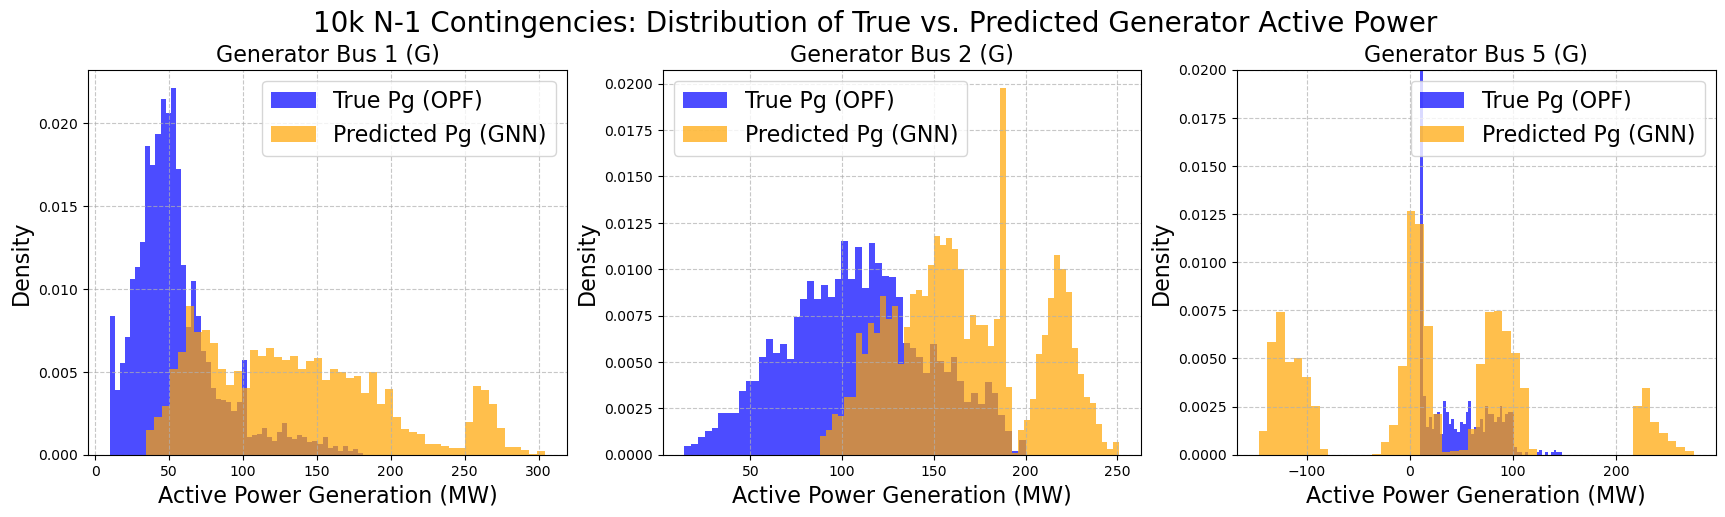

In [85]:
# Get the list of generator bus IDs (0-indexed)
generator_bus_ids = sorted([g['bus'] for g in ieee_6_generators_data])
num_generators = len(generator_bus_ids)

if num_generators == 0:
    print("No generator buses defined. Cannot plot Pg distributions.")
else:
    # Determine grid size for subplots
    cols = 3
    rows = (num_generators + cols - 1) // cols

    plt.figure(figsize=(cols * 7, rows * 5)) # Adjust figure size as needed
    plt.suptitle('10k N-1 Contingencies: Distribution of True vs. Predicted Generator Active Power', 
                 y=1.00, fontsize=20)

    for i, gen_bus_idx in enumerate(generator_bus_ids):
        ax = plt.subplot(rows, cols, i + 1)
        
        true_pg_values = all_true_pg_per_gen_buses[gen_bus_idx]
        pred_pg_values = all_pred_pg_per_gen_buses[gen_bus_idx]

        if not true_pg_values or not pred_pg_values:
            print(f"Warning: No data for generator bus {gen_bus_idx+1}. Skipping plot.")
            continue

        # Plot histograms
        ax.hist(true_pg_values, bins=50, alpha=0.7, label='True Pg (OPF)', color='blue', density=True)
        ax.hist(pred_pg_values, bins=50, alpha=0.7, label='Predicted Pg (GNN)', color='orange', density=True)
        
        ax.set_title(f'Generator Bus {gen_bus_idx+1} (G)', fontsize=16)
        ax.set_xlabel('Active Power Generation (MW)', fontsize=16)
        ax.set_ylabel('Density', fontsize=16)
        ax.legend(fontsize=16)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        if (i + 1) == 3:
            ax.set_ylim(0, 0.02) # Set y-axis limits from 0 to 0.03

#     plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust rect to make space for suptitle
#     plt.show()

print("\n--- Pg Distribution Plots Generated for Generator Buses ---")
plt.savefig("n1.png", dpi=300)


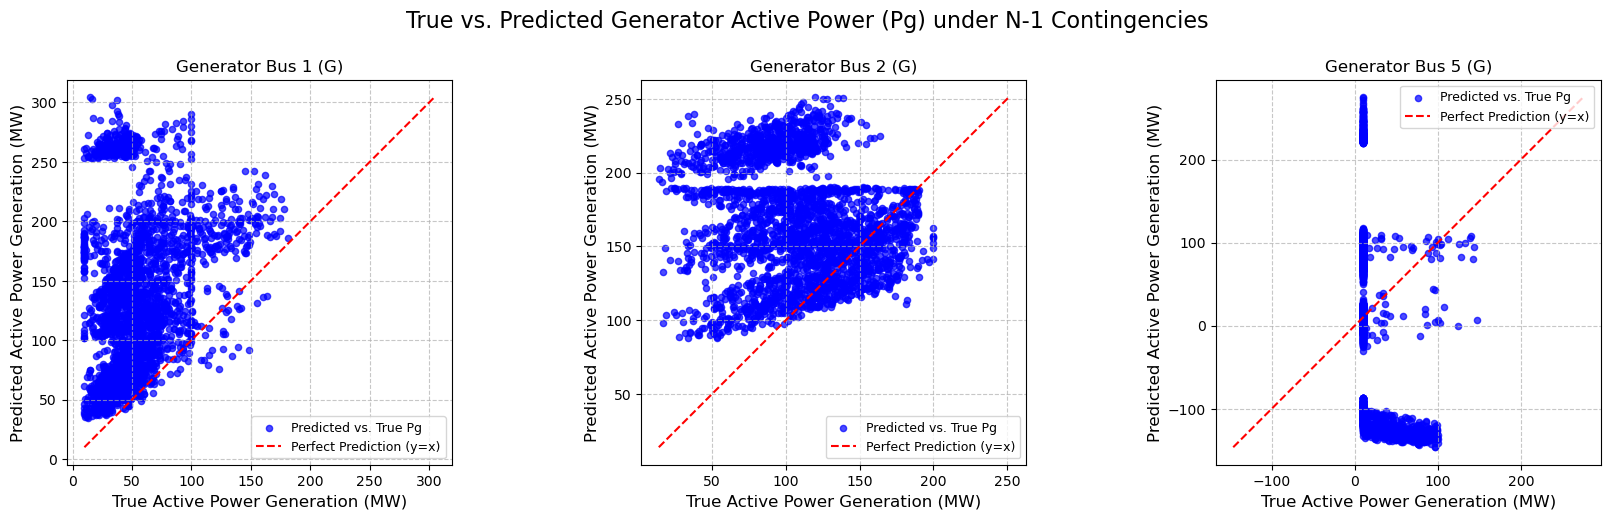


--- Pg Scatter Plots Generated for Generator Buses ---


In [86]:
# Get the list of generator bus IDs (0-indexed)
generator_bus_ids = sorted([g['bus'] for g in ieee_6_generators_data])
num_generators = len(generator_bus_ids)

if num_generators == 0:
    print("No generator buses defined. Cannot plot Pg distributions.")
else:
    # Determine grid size for subplots
    cols = 3
    rows = 1

    plt.figure(figsize=(cols * 7, rows * 5)) # Adjust figure size as needed
    plt.suptitle('True vs. Predicted Generator Active Power (Pg) under N-1 Contingencies', y=1.02, fontsize=16)

    for i, gen_bus_idx in enumerate(generator_bus_ids):
        ax = plt.subplot(rows, cols, i + 1)
        
        true_pg_values = all_true_pg_per_gen_buses[gen_bus_idx]
        pred_pg_values = all_pred_pg_per_gen_buses[gen_bus_idx]

        if not true_pg_values or not pred_pg_values:
            print(f"Warning: No data for generator bus {gen_bus_idx+1}. Skipping plot.")
            continue
        
        # Ensure true_pg_values and pred_pg_values have the same length for scatter plot
        if len(true_pg_values) != len(pred_pg_values):
            print(f"Warning: Mismatched data lengths for generator bus {gen_bus_idx+1}. Skipping scatter plot.")
            continue

        # Plot scatter plot
        ax.scatter(true_pg_values, pred_pg_values, alpha=0.7, label='Predicted vs. True Pg', color='blue', s=20) # s is marker size
        
        # Plot a perfect prediction line (y=x)
        min_val = min(min(true_pg_values), min(pred_pg_values))
        max_val = max(max(true_pg_values), max(pred_pg_values))
        ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction (y=x)')

        ax.set_title(f'Generator Bus {gen_bus_idx+1} (G)', fontsize=12)
        ax.set_xlabel('True Active Power Generation (MW)', fontsize=12)
        ax.set_ylabel('Predicted Active Power Generation (MW)', fontsize=12)
        ax.legend(fontsize=9)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_aspect('equal', adjustable='box') # To ensure x and y axes have the same scale

    plt.show()

print("\n--- Pg Scatter Plots Generated for Generator Buses ---")
